# Example usage notebook of the DD-GAN repo

In [1]:
import time
import numpy as np
import sklearn.preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt
from copy import deepcopy

After installation of the ddgan package run the following line to import it

In [2]:
import ddgan
from ddgan import *

### Loading Data

In [3]:
nPOD = 10
evaluated_subdomains = 2
nlatent = 100
subdomains = 4
start_from = 400
steps = 10
dims = 3
datapoints = 1200 + steps + 200

step_size = 3
added_dims = [2,2,4]
cumulative_dims = [0,2,4]


t_begin = 0
t_end = 1200

debug = False
train = True
find_old_model = True
noise = True
epochs = 30000


csv_data = np.load('../data/processed/DD/pod_coeffs_field_Velocity.npy', )

assert nPOD <= csv_data.shape[1], "Make sure the data includes enough POD coeffs"
assert datapoints + start_from <= csv_data.shape[2], "Not enough data"
assert evaluated_subdomains + 2 <= csv_data.shape[0], "Not enough domains"

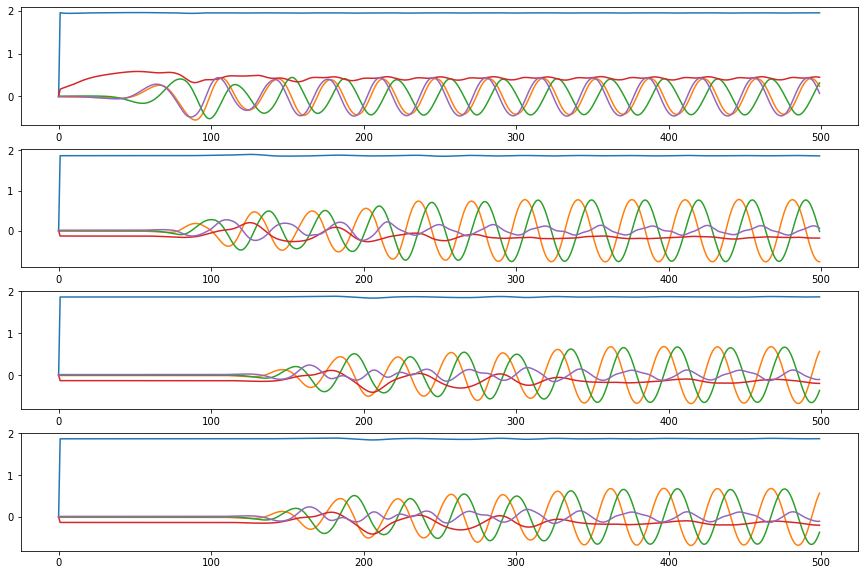

In [4]:
fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(411)
ax1.plot(csv_data[0,:5,:500].T)
ax1 = fig.add_subplot(412)
ax1.plot(csv_data[1,:5,:500].T)
ax1 = fig.add_subplot(413)
ax1.plot(csv_data[2,:5,:500].T)
ax1 = fig.add_subplot(414)
ax1.plot(csv_data[2,:5,:500].T)

plt.show()

In [5]:
# Cutting the dataset
print(csv_data.shape)
csv_data = csv_data[:subdomains,:nPOD,start_from:start_from+datapoints]
print(csv_data.shape)

(4, 10, 2000)
(4, 10, 1410)


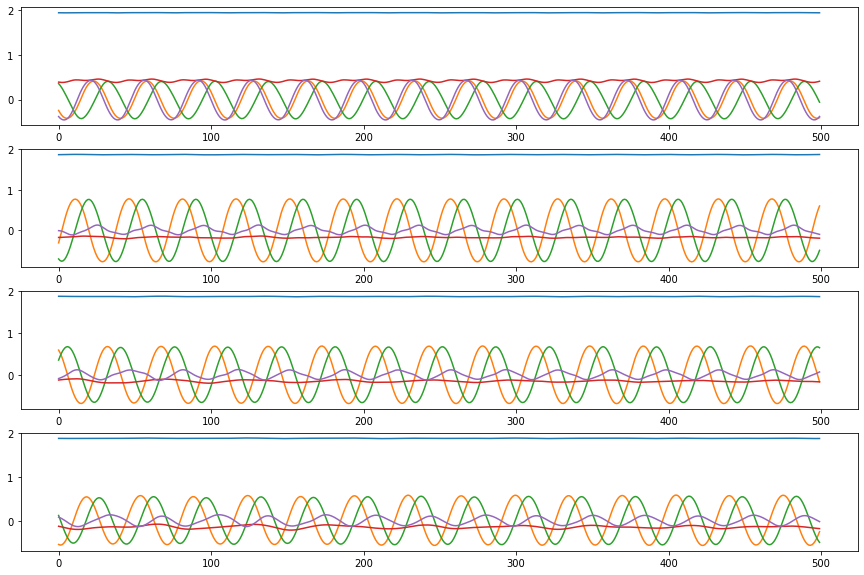

In [6]:
fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(411)
ax1.plot(csv_data[0,:5,:500].T)
ax1 = fig.add_subplot(412)
ax1.plot(csv_data[1,:5,:500].T)
ax1 = fig.add_subplot(413)
ax1.plot(csv_data[2,:5,:500].T)
ax1 = fig.add_subplot(414)
ax1.plot(csv_data[3,:5,:500].T)

plt.show()

In [7]:
# Transposing data
tmp_data = np.ones([subdomains, datapoints, nPOD])

# Making a dataset for debugging purposes
new_data = np.ones([subdomains, nPOD, datapoints])
for i in range(subdomains):
    for j in range(nPOD):
        for k in range(datapoints):
            new_data[i][j][k] = nPOD*j + (i + 1)*10000 + k  

for k in range(subdomains):
    tmp_data[k] = csv_data[k].T
    if debug:
        tmp_data[k] = new_data[k].T
    
csv_data = tmp_data
csv_data.shape

(4, 1410, 10)

In [8]:
# Scaling
scales = []
scaled_training = np.zeros_like(csv_data)
if debug is False:
    for i in range(subdomains):
        scales.append(sklearn.preprocessing.MinMaxScaler(feature_range=[-1,1]))
        scaled_training[i] = scales[i].fit_transform(csv_data[i])
if debug:
    scaled_training = csv_data

In [9]:
# Asserting scaling is accurate
if debug is False:
    cond = np.zeros_like(scaled_training)
    for i in range(subdomains):
        cond[i] = scales[i].inverse_transform(scaled_training[i])
    assert np.allclose(csv_data[0,:,0], cond[0,:,0]), "Scaling failed"  

    for dim in range(subdomains):
        for icol in range(nPOD):
            assert np.isclose(np.min(scaled_training[dim][:,icol]) + np.max(scaled_training[dim][:,icol]), 0), "Scaling failed" 

In [10]:
# Setting up the data into subdomains 
# 2 x nTrain x nsteps * nPOD *3 # 'float32' or np.float32

assert sum(added_dims[:-1]) == cumulative_dims[-1]

training_data = np.zeros((evaluated_subdomains, t_end, np.sum(added_dims * nPOD)), dtype=np.float32) 

for domain in range(evaluated_subdomains): 
    for i, dim in enumerate([0,2,1]):
        for j, step in enumerate(range(steps-added_dims[i], steps)):
            training_data[domain, :, cumulative_dims[i]*nPOD + j*nPOD : cumulative_dims[i]*nPOD + (j+1)*nPOD] = scaled_training[dim + domain][t_begin+(step*step_size) : t_end+(step*step_size), :]

# Adding data for leftmost and rightmost domain
boundrary_conditions = []
boundrary_conditions.append(scaled_training[0, (steps-1)*step_size:])
boundrary_conditions.append(scaled_training[-1, (steps-1)*step_size:])

In [11]:
assert np.allclose(training_data[0,1,(added_dims[0]-1)*nPOD:added_dims[0]*nPOD], boundrary_conditions[0][1]), 'Check the boundrary condition data.'

In [12]:
joined_train_data = training_data.reshape((training_data.shape[1]*training_data.shape[0], training_data.shape[2]))

print(training_data.shape)
print(joined_train_data.shape)
print(tmp_data[0,steps-1:].shape)

(2, 1200, 80)
(2400, 80)
(1401, 10)


### Initializing GAN

In [13]:
kwargs = {
    "nsteps" : np.sum(added_dims),
    "ndims" : nPOD,
    "nLatent": nlatent,
    "batch_size" : 400,
    "batches" : 6,
    "seed" : 143,
    "epochs" : epochs,
    "noise" : noise,
    "logs_location" : './logs/gradient_tape/224/',
    "model_location" : 'models/224/'
}

gan = GAN(**kwargs)
gan.setup(find_old_model=find_old_model)
set_seed(gan.seed)

ndims_latent_input = gan.ndims
joined_train_data = np.float32(joined_train_data)
print('type and shape (nPOD by nTrain) of POD coeffs from csv file', type(joined_train_data), joined_train_data.shape, joined_train_data.dtype)

looking for previous saved models
type and shape (nPOD by nTrain) of POD coeffs from csv file <class 'numpy.ndarray'> (2400, 80) float32


In [14]:
if train:
    # Load the TensorBoard notebook extension
    %load_ext tensorboard
    %tensorboard --logdir ./logs/gradient_tape/ --port 6008
    %reload_ext tensorboard

In [15]:
if train:
    gan.learn_hypersurface_from_POD_coeffs(joined_train_data)

beginning training
epoch: 	 0
gen loss:  2.978152 d loss:  -0.018465249 w_loss:  0.10965395
epoch: 	 1
gen loss:  2.8700283 d loss:  0.059814423 w_loss:  0.05024131
epoch: 	 2
gen loss:  2.9110699 d loss:  0.05447803 w_loss:  0.04739197
epoch: 	 3
gen loss:  2.8484728 d loss:  0.12984103 w_loss:  -0.014829556
epoch: 	 4
gen loss:  2.922519 d loss:  0.09025266 w_loss:  -0.0029108922
epoch: 	 5
gen loss:  2.8880842 d loss:  0.013557737 w_loss:  0.079655685
epoch: 	 6
gen loss:  2.9118118 d loss:  -0.07091316 w_loss:  0.14285283
epoch: 	 7
gen loss:  2.941888 d loss:  0.13628803 w_loss:  -0.037639458
epoch: 	 8
gen loss:  2.8691072 d loss:  0.0299972 w_loss:  0.051062386
epoch: 	 9
gen loss:  2.878833 d loss:  0.07984897 w_loss:  0.022428313
epoch: 	 10
gen loss:  2.9179785 d loss:  0.057544384 w_loss:  0.044184327
epoch: 	 11
gen loss:  2.8849297 d loss:  0.10935006 w_loss:  -0.030054966
epoch: 	 12
gen loss:  2.8918133 d loss:  0.090678364 w_loss:  0.008404255
epoch: 	 13
gen loss:  2.9

gen loss:  2.9034169 d loss:  0.20001787 w_loss:  -0.10388342
epoch: 	 112
gen loss:  2.9097393 d loss:  0.0933583 w_loss:  -0.003122409
epoch: 	 113
gen loss:  2.843634 d loss:  0.06770134 w_loss:  0.033344667
epoch: 	 114
gen loss:  2.938362 d loss:  0.028511517 w_loss:  0.07613691
epoch: 	 115
gen loss:  2.9779027 d loss:  0.06973857 w_loss:  0.029285392
epoch: 	 116
gen loss:  2.930198 d loss:  0.12263181 w_loss:  -0.048752625
epoch: 	 117
gen loss:  2.9055119 d loss:  0.09690899 w_loss:  -0.008798639
epoch: 	 118
gen loss:  2.8871858 d loss:  -0.017291049 w_loss:  0.12665021
epoch: 	 119
gen loss:  2.9326646 d loss:  0.04878242 w_loss:  0.036025327
epoch: 	 120
gen loss:  2.8950875 d loss:  -0.003026519 w_loss:  0.10188687
epoch: 	 121
gen loss:  2.9085674 d loss:  0.13746478 w_loss:  -0.035435278
epoch: 	 122
gen loss:  2.8499787 d loss:  0.07140713 w_loss:  0.021297693
epoch: 	 123
gen loss:  2.9473932 d loss:  0.064923234 w_loss:  0.04385261
epoch: 	 124
gen loss:  2.9403791 d 

gen loss:  2.9004784 d loss:  0.0037492912 w_loss:  0.0981526
epoch: 	 222
gen loss:  2.864621 d loss:  0.13090044 w_loss:  -0.042544167
epoch: 	 223
gen loss:  2.889952 d loss:  0.026872313 w_loss:  0.07366649
epoch: 	 224
gen loss:  2.8825495 d loss:  0.10936543 w_loss:  -0.0053916373
epoch: 	 225
gen loss:  2.8783557 d loss:  0.029872721 w_loss:  0.06414648
epoch: 	 226
gen loss:  2.9260209 d loss:  0.08263439 w_loss:  0.030892411
epoch: 	 227
gen loss:  2.8363352 d loss:  0.17738803 w_loss:  -0.07319045
epoch: 	 228
gen loss:  2.883011 d loss:  0.09907419 w_loss:  0.004579822
epoch: 	 229
gen loss:  2.883053 d loss:  0.01977866 w_loss:  0.07853552
epoch: 	 230
gen loss:  2.9740925 d loss:  0.0051788413 w_loss:  0.083772935
epoch: 	 231
gen loss:  2.9836245 d loss:  0.1239823 w_loss:  -0.0369577
epoch: 	 232
gen loss:  2.9160225 d loss:  0.08855937 w_loss:  0.023338318
epoch: 	 233
gen loss:  2.9148254 d loss:  0.087221295 w_loss:  -0.0016459624
epoch: 	 234
gen loss:  2.9625883 d l

gen loss:  2.8620503 d loss:  0.04106528 w_loss:  0.056856673
epoch: 	 332
gen loss:  2.8736355 d loss:  0.08348519 w_loss:  0.0045199
epoch: 	 333
gen loss:  2.9562051 d loss:  0.05512413 w_loss:  0.039272547
epoch: 	 334
gen loss:  2.8809164 d loss:  0.101250194 w_loss:  0.0012039343
epoch: 	 335
gen loss:  2.8914356 d loss:  0.03329066 w_loss:  0.06485172
epoch: 	 336
gen loss:  2.906108 d loss:  0.06443679 w_loss:  0.043007612
epoch: 	 337
gen loss:  2.9010293 d loss:  0.040985823 w_loss:  0.07908118
epoch: 	 338
gen loss:  2.8480809 d loss:  0.107922286 w_loss:  -0.010407209
epoch: 	 339
gen loss:  2.812211 d loss:  0.13694821 w_loss:  -0.05296429
epoch: 	 340
gen loss:  2.82382 d loss:  0.0041281213 w_loss:  0.08779713
epoch: 	 341
gen loss:  2.8802738 d loss:  0.056107033 w_loss:  0.03562395
epoch: 	 342
gen loss:  2.8804653 d loss:  -0.008051646 w_loss:  0.10890206
epoch: 	 343
gen loss:  2.8594868 d loss:  0.05364816 w_loss:  0.059782464
epoch: 	 344
gen loss:  2.8642557 d los

gen loss:  2.9269886 d loss:  -0.056358922 w_loss:  0.15772569
epoch: 	 442
gen loss:  2.9359457 d loss:  0.05451681 w_loss:  0.023544112
epoch: 	 443
gen loss:  2.9241307 d loss:  0.113439985 w_loss:  -0.020289382
epoch: 	 444
gen loss:  2.8833723 d loss:  0.039640624 w_loss:  0.04290243
epoch: 	 445
gen loss:  2.918504 d loss:  0.010781041 w_loss:  0.080115594
epoch: 	 446
gen loss:  2.9309847 d loss:  0.05775084 w_loss:  0.032217264
epoch: 	 447
gen loss:  2.946131 d loss:  0.081619464 w_loss:  0.03102541
epoch: 	 448
gen loss:  2.8494556 d loss:  0.05688122 w_loss:  0.027134856
epoch: 	 449
gen loss:  2.9044473 d loss:  0.029047906 w_loss:  0.068539225
epoch: 	 450
gen loss:  2.9447162 d loss:  0.059154097 w_loss:  0.03995192
epoch: 	 451
gen loss:  2.82808 d loss:  0.029637342 w_loss:  0.07189131
epoch: 	 452
gen loss:  2.8767493 d loss:  0.09472144 w_loss:  -0.0016727844
epoch: 	 453
gen loss:  2.9015274 d loss:  0.12407487 w_loss:  -0.039656878
epoch: 	 454
gen loss:  2.9100187 

gen loss:  2.975547 d loss:  0.041692734 w_loss:  0.050339382
epoch: 	 552
gen loss:  3.0076072 d loss:  -0.03289816 w_loss:  0.13175325
epoch: 	 553
gen loss:  2.9438102 d loss:  0.042871367 w_loss:  0.06343547
epoch: 	 554
gen loss:  2.9484184 d loss:  0.022044592 w_loss:  0.08297702
epoch: 	 555
gen loss:  2.9422119 d loss:  -0.07363459 w_loss:  0.17935383
epoch: 	 556
gen loss:  3.004692 d loss:  0.024622606 w_loss:  0.062102437
epoch: 	 557
gen loss:  2.953309 d loss:  0.15333046 w_loss:  -0.05398603
epoch: 	 558
gen loss:  2.9664967 d loss:  0.16670974 w_loss:  -0.06573983
epoch: 	 559
gen loss:  2.8909245 d loss:  0.046789467 w_loss:  0.032168787
epoch: 	 560
gen loss:  2.8303082 d loss:  0.110444404 w_loss:  -0.007671038
epoch: 	 561
gen loss:  2.9443433 d loss:  0.05105944 w_loss:  0.03536451
epoch: 	 562
gen loss:  2.920069 d loss:  0.14939307 w_loss:  -0.055474997
epoch: 	 563
gen loss:  2.9236 d loss:  -0.030407721 w_loss:  0.112053476
epoch: 	 564
gen loss:  2.946029 d los

gen loss:  2.9162445 d loss:  -0.023138551 w_loss:  0.13222957
epoch: 	 662
gen loss:  2.9472458 d loss:  0.047424722 w_loss:  0.039650798
epoch: 	 663
gen loss:  2.906605 d loss:  0.039762396 w_loss:  0.04119722
epoch: 	 664
gen loss:  2.9755862 d loss:  0.060921837 w_loss:  0.03374942
epoch: 	 665
gen loss:  2.9933357 d loss:  0.04700168 w_loss:  0.05661301
epoch: 	 666
gen loss:  2.954237 d loss:  0.10525873 w_loss:  -0.020785132
epoch: 	 667
gen loss:  2.9700966 d loss:  0.03198345 w_loss:  0.051151235
epoch: 	 668
gen loss:  2.9594011 d loss:  0.021162407 w_loss:  0.081158996
epoch: 	 669
gen loss:  2.8631048 d loss:  0.016256733 w_loss:  0.07728449
epoch: 	 670
gen loss:  2.953576 d loss:  0.024596887 w_loss:  0.0732195
epoch: 	 671
gen loss:  2.9908702 d loss:  0.17959432 w_loss:  -0.08143898
epoch: 	 672
gen loss:  2.9825914 d loss:  0.007201025 w_loss:  0.09591969
epoch: 	 673
gen loss:  2.9496305 d loss:  0.050477903 w_loss:  0.032529116
epoch: 	 674
gen loss:  2.9246693 d lo

gen loss:  2.993625 d loss:  0.15465991 w_loss:  -0.058731794
epoch: 	 772
gen loss:  2.955211 d loss:  0.14551555 w_loss:  -0.048105557
epoch: 	 773
gen loss:  2.9811192 d loss:  0.055644196 w_loss:  0.033706147
epoch: 	 774
gen loss:  2.9081156 d loss:  0.029678946 w_loss:  0.05745272
epoch: 	 775
gen loss:  2.9387817 d loss:  0.051062465 w_loss:  0.06736306
epoch: 	 776
gen loss:  2.890639 d loss:  0.028958222 w_loss:  0.06518368
epoch: 	 777
gen loss:  2.889453 d loss:  -0.03518909 w_loss:  0.117396235
epoch: 	 778
gen loss:  2.8649454 d loss:  0.04576194 w_loss:  0.05395353
epoch: 	 779
gen loss:  2.9585717 d loss:  0.07506993 w_loss:  0.009359677
epoch: 	 780
gen loss:  2.9946878 d loss:  0.030436711 w_loss:  0.06697079
epoch: 	 781
gen loss:  2.89165 d loss:  0.06645305 w_loss:  0.019375285
epoch: 	 782
gen loss:  2.9302628 d loss:  0.030978413 w_loss:  0.046989202
epoch: 	 783
gen loss:  2.847499 d loss:  0.08887079 w_loss:  0.014011105
epoch: 	 784
gen loss:  2.9153585 d loss:

gen loss:  2.862422 d loss:  0.025501097 w_loss:  0.06607851
epoch: 	 882
gen loss:  2.8770182 d loss:  0.11002102 w_loss:  -0.022786975
epoch: 	 883
gen loss:  2.9168613 d loss:  -0.032806676 w_loss:  0.11206567
epoch: 	 884
gen loss:  2.85517 d loss:  0.15503694 w_loss:  -0.053088028
epoch: 	 885
gen loss:  2.941291 d loss:  0.06103161 w_loss:  0.03674682
epoch: 	 886
gen loss:  2.9016113 d loss:  0.034609582 w_loss:  0.060910266
epoch: 	 887
gen loss:  2.9006913 d loss:  0.09461063 w_loss:  0.02218171
epoch: 	 888
gen loss:  2.9484804 d loss:  -0.042345297 w_loss:  0.12885106
epoch: 	 889
gen loss:  2.8689654 d loss:  0.06234889 w_loss:  0.016163984
epoch: 	 890
gen loss:  2.887511 d loss:  0.041068655 w_loss:  0.055906374
epoch: 	 891
gen loss:  2.905996 d loss:  0.0037802507 w_loss:  0.092883624
epoch: 	 892
gen loss:  2.9247096 d loss:  -0.03106743 w_loss:  0.12499336
epoch: 	 893
gen loss:  2.9288404 d loss:  0.059810907 w_loss:  0.058624584
epoch: 	 894
gen loss:  2.9189203 d l

gen loss:  3.0123997 d loss:  0.10709358 w_loss:  -0.021680474
epoch: 	 992
gen loss:  3.0642807 d loss:  0.026854716 w_loss:  0.06384051
epoch: 	 993
gen loss:  2.90437 d loss:  0.07468676 w_loss:  0.016062418
epoch: 	 994
gen loss:  2.8797634 d loss:  0.055915136 w_loss:  0.037349384
epoch: 	 995
gen loss:  2.9327812 d loss:  0.05511151 w_loss:  0.04313628
epoch: 	 996
gen loss:  2.9074986 d loss:  0.0057489066 w_loss:  0.078455925
epoch: 	 997
gen loss:  2.9404027 d loss:  0.11644659 w_loss:  -0.031267446
epoch: 	 998
gen loss:  2.9410868 d loss:  0.13126105 w_loss:  -0.051173806
epoch: 	 999
gen loss:  2.9073389 d loss:  0.06905489 w_loss:  0.059120934
INFO:tensorflow:Assets written to: ./models/224/saved_g_1000/assets
INFO:tensorflow:Assets written to: ./models/224/saved_c_1000/assets
epoch: 	 1000
gen loss:  2.9021282 d loss:  -0.018280119 w_loss:  0.11038753
epoch: 	 1001
gen loss:  2.9464836 d loss:  0.092415385 w_loss:  0.016103705
epoch: 	 1002
gen loss:  2.955054 d loss:  0.

gen loss:  2.9753697 d loss:  0.095983066 w_loss:  0.009231527
epoch: 	 1094
gen loss:  3.0457232 d loss:  0.12078262 w_loss:  -0.02235349
epoch: 	 1095
gen loss:  2.96615 d loss:  -0.06305331 w_loss:  0.14545707
epoch: 	 1096
gen loss:  2.9892824 d loss:  0.1028693 w_loss:  0.0019412041
epoch: 	 1097
gen loss:  3.0465765 d loss:  0.12782179 w_loss:  -0.014449954
epoch: 	 1098
gen loss:  2.9166117 d loss:  0.062179208 w_loss:  0.042963583
epoch: 	 1099
gen loss:  3.049182 d loss:  0.02102489 w_loss:  0.073697805
epoch: 	 1100
gen loss:  2.9944744 d loss:  0.07951708 w_loss:  0.008087317
epoch: 	 1101
gen loss:  3.0003126 d loss:  0.048859935 w_loss:  0.03428483
epoch: 	 1102
gen loss:  3.0174704 d loss:  -0.048754472 w_loss:  0.13573594
epoch: 	 1103
gen loss:  2.9296439 d loss:  0.06887156 w_loss:  0.04919076
epoch: 	 1104
gen loss:  2.9944518 d loss:  0.0202657 w_loss:  0.08111513
epoch: 	 1105
gen loss:  2.9724476 d loss:  0.018048966 w_loss:  0.07596588
epoch: 	 1106
gen loss:  2.9

gen loss:  3.0000591 d loss:  0.068971656 w_loss:  0.025441727
epoch: 	 1202
gen loss:  3.0404663 d loss:  -0.010836803 w_loss:  0.10762175
epoch: 	 1203
gen loss:  2.9946706 d loss:  0.04098453 w_loss:  0.043651182
epoch: 	 1204
gen loss:  2.9664125 d loss:  0.07829526 w_loss:  0.016801
epoch: 	 1205
gen loss:  3.028742 d loss:  0.024434214 w_loss:  0.051489156
epoch: 	 1206
gen loss:  3.0509596 d loss:  0.07955329 w_loss:  0.003610611
epoch: 	 1207
gen loss:  3.0462081 d loss:  0.16023986 w_loss:  -0.058060806
epoch: 	 1208
gen loss:  2.95601 d loss:  0.06446586 w_loss:  0.021087527
epoch: 	 1209
gen loss:  3.0755546 d loss:  0.13256769 w_loss:  -0.043675423
epoch: 	 1210
gen loss:  2.981992 d loss:  0.110543825 w_loss:  -0.0030233066
epoch: 	 1211
gen loss:  3.047454 d loss:  0.03508764 w_loss:  0.048609257
epoch: 	 1212
gen loss:  2.9880311 d loss:  0.1771626 w_loss:  -0.07126216
epoch: 	 1213
gen loss:  3.0585566 d loss:  -0.050158173 w_loss:  0.139226
epoch: 	 1214
gen loss:  3.0

gen loss:  3.0210865 d loss:  0.00028203428 w_loss:  0.10474563
epoch: 	 1310
gen loss:  2.9185295 d loss:  0.050187606 w_loss:  0.042446334
epoch: 	 1311
gen loss:  3.0059166 d loss:  0.024524225 w_loss:  0.07173494
epoch: 	 1312
gen loss:  2.9866612 d loss:  0.08372784 w_loss:  0.023131609
epoch: 	 1313
gen loss:  3.0403244 d loss:  -0.0050323955 w_loss:  0.10330856
epoch: 	 1314
gen loss:  2.9885056 d loss:  0.078646846 w_loss:  0.03157274
epoch: 	 1315
gen loss:  2.9613345 d loss:  -0.027924927 w_loss:  0.12739372
epoch: 	 1316
gen loss:  2.9612992 d loss:  0.025923816 w_loss:  0.0693624
epoch: 	 1317
gen loss:  3.0236845 d loss:  -0.0041320436 w_loss:  0.095698714
epoch: 	 1318
gen loss:  2.97404 d loss:  0.009577324 w_loss:  0.071178555
epoch: 	 1319
gen loss:  2.982501 d loss:  0.12730706 w_loss:  -0.019733468
epoch: 	 1320
gen loss:  2.9494655 d loss:  0.101156764 w_loss:  -0.008152366
epoch: 	 1321
gen loss:  2.9320545 d loss:  0.060565326 w_loss:  0.042033434
epoch: 	 1322
ge

gen loss:  2.9861364 d loss:  0.11582753 w_loss:  -0.03133015
epoch: 	 1418
gen loss:  2.9975882 d loss:  0.06415462 w_loss:  0.025161982
epoch: 	 1419
gen loss:  2.9483721 d loss:  0.033857636 w_loss:  0.058446486
epoch: 	 1420
gen loss:  2.9798777 d loss:  0.07180952 w_loss:  0.013174136
epoch: 	 1421
gen loss:  2.9630148 d loss:  -0.014263854 w_loss:  0.10118139
epoch: 	 1422
gen loss:  2.9123557 d loss:  0.1839339 w_loss:  -0.08912289
epoch: 	 1423
gen loss:  2.9243557 d loss:  -0.008851691 w_loss:  0.10355612
epoch: 	 1424
gen loss:  2.9922924 d loss:  0.04493768 w_loss:  0.0333155
epoch: 	 1425
gen loss:  2.9542024 d loss:  -0.017724153 w_loss:  0.12433878
epoch: 	 1426
gen loss:  2.9061613 d loss:  0.07233238 w_loss:  0.021927834
epoch: 	 1427
gen loss:  2.9444249 d loss:  0.082453355 w_loss:  0.03390233
epoch: 	 1428
gen loss:  2.9535475 d loss:  0.08816546 w_loss:  0.013103287
epoch: 	 1429
gen loss:  2.9401855 d loss:  0.11988481 w_loss:  -0.0006476243
epoch: 	 1430
gen loss:

gen loss:  2.9217718 d loss:  0.10540398 w_loss:  -0.0035819213
epoch: 	 1526
gen loss:  2.910312 d loss:  0.09301334 w_loss:  0.012994687
epoch: 	 1527
gen loss:  2.9415236 d loss:  0.020880729 w_loss:  0.07959863
epoch: 	 1528
gen loss:  2.9814746 d loss:  0.008482789 w_loss:  0.08053247
epoch: 	 1529
gen loss:  3.004544 d loss:  0.020942336 w_loss:  0.084297575
epoch: 	 1530
gen loss:  2.981003 d loss:  0.031333815 w_loss:  0.059832413
epoch: 	 1531
gen loss:  2.9317372 d loss:  0.094519675 w_loss:  0.014269312
epoch: 	 1532
gen loss:  2.9929752 d loss:  0.09475166 w_loss:  -0.010872404
epoch: 	 1533
gen loss:  2.9479086 d loss:  0.022051781 w_loss:  0.09805095
epoch: 	 1534
gen loss:  3.0157197 d loss:  0.08820528 w_loss:  0.0020805995
epoch: 	 1535
gen loss:  2.926545 d loss:  0.06031588 w_loss:  0.01464951
epoch: 	 1536
gen loss:  2.9488513 d loss:  0.10175577 w_loss:  -0.020665288
epoch: 	 1537
gen loss:  2.9673426 d loss:  0.076496676 w_loss:  0.029284796
epoch: 	 1538
gen loss

gen loss:  3.0358057 d loss:  0.13492624 w_loss:  -0.036866385
epoch: 	 1634
gen loss:  3.0368671 d loss:  0.0030553069 w_loss:  0.086931705
epoch: 	 1635
gen loss:  3.048073 d loss:  0.051592376 w_loss:  0.055773657
epoch: 	 1636
gen loss:  2.9833581 d loss:  -0.005168222 w_loss:  0.074605264
epoch: 	 1637
gen loss:  2.9761207 d loss:  0.0873248 w_loss:  0.02200977
epoch: 	 1638
gen loss:  2.9766014 d loss:  0.07164607 w_loss:  0.011207144
epoch: 	 1639
gen loss:  2.9981196 d loss:  0.11492741 w_loss:  -0.028983077
epoch: 	 1640
gen loss:  2.985569 d loss:  0.04513128 w_loss:  0.04345377
epoch: 	 1641
gen loss:  3.004535 d loss:  -0.01588055 w_loss:  0.111244716
epoch: 	 1642
gen loss:  3.020726 d loss:  0.033665203 w_loss:  0.049274683
epoch: 	 1643
gen loss:  3.0148566 d loss:  0.028980931 w_loss:  0.06442571
epoch: 	 1644
gen loss:  2.967331 d loss:  0.05329558 w_loss:  0.047194004
epoch: 	 1645
gen loss:  2.956845 d loss:  0.09043165 w_loss:  -0.0059903464
epoch: 	 1646
gen loss: 

gen loss:  3.0396216 d loss:  0.04588771 w_loss:  0.034565646
epoch: 	 1742
gen loss:  2.9910662 d loss:  0.040583897 w_loss:  0.04688418
epoch: 	 1743
gen loss:  3.0350904 d loss:  0.027728379 w_loss:  0.059849817
epoch: 	 1744
gen loss:  2.9741237 d loss:  0.018967979 w_loss:  0.061477263
epoch: 	 1745
gen loss:  2.9692266 d loss:  -0.081839494 w_loss:  0.16280794
epoch: 	 1746
gen loss:  3.0800607 d loss:  0.053912655 w_loss:  0.0461123
epoch: 	 1747
gen loss:  2.9845037 d loss:  0.19582106 w_loss:  -0.09788251
epoch: 	 1748
gen loss:  2.9635313 d loss:  0.01334323 w_loss:  0.065413356
epoch: 	 1749
gen loss:  2.9571571 d loss:  -0.038898263 w_loss:  0.12208577
epoch: 	 1750
gen loss:  2.9727383 d loss:  0.13978402 w_loss:  -0.028237024
epoch: 	 1751
gen loss:  3.002863 d loss:  -0.016536431 w_loss:  0.10797576
epoch: 	 1752
gen loss:  3.0568047 d loss:  0.07394057 w_loss:  0.014757395
epoch: 	 1753
gen loss:  2.9913204 d loss:  0.010558348 w_loss:  0.07064899
epoch: 	 1754
gen loss

gen loss:  3.0601494 d loss:  0.069252186 w_loss:  0.044634063
epoch: 	 1850
gen loss:  3.0134895 d loss:  0.08662146 w_loss:  0.016422113
epoch: 	 1851
gen loss:  3.0763388 d loss:  0.07887026 w_loss:  0.0132575035
epoch: 	 1852
gen loss:  3.067207 d loss:  0.06849944 w_loss:  0.04060475
epoch: 	 1853
gen loss:  3.0463238 d loss:  0.10220134 w_loss:  -0.017024478
epoch: 	 1854
gen loss:  3.0679388 d loss:  0.06170824 w_loss:  0.022660932
epoch: 	 1855
gen loss:  3.0684083 d loss:  0.029107815 w_loss:  0.06556455
epoch: 	 1856
gen loss:  2.9780853 d loss:  0.041948628 w_loss:  0.04952653
epoch: 	 1857
gen loss:  3.0275764 d loss:  0.014061227 w_loss:  0.05977559
epoch: 	 1858
gen loss:  3.099903 d loss:  0.0005992924 w_loss:  0.098105155
epoch: 	 1859
gen loss:  3.0515606 d loss:  0.111021005 w_loss:  -0.019988617
epoch: 	 1860
gen loss:  3.0431416 d loss:  0.09622202 w_loss:  -0.011372526
epoch: 	 1861
gen loss:  3.0411537 d loss:  0.059249353 w_loss:  0.027360877
epoch: 	 1862
gen lo

gen loss:  3.0212758 d loss:  0.1220623 w_loss:  -0.03512625
epoch: 	 1958
gen loss:  3.0463622 d loss:  0.12071782 w_loss:  -0.023866296
epoch: 	 1959
gen loss:  3.0375884 d loss:  0.053184796 w_loss:  0.04876562
epoch: 	 1960
gen loss:  3.047739 d loss:  0.059324075 w_loss:  0.049492598
epoch: 	 1961
gen loss:  3.0326202 d loss:  0.0681678 w_loss:  0.04516208
epoch: 	 1962
gen loss:  3.0503714 d loss:  0.051142633 w_loss:  0.03459211
epoch: 	 1963
gen loss:  3.0471237 d loss:  0.06446331 w_loss:  0.019153634
epoch: 	 1964
gen loss:  3.11232 d loss:  0.07163892 w_loss:  0.042220633
epoch: 	 1965
gen loss:  3.0668955 d loss:  0.07241999 w_loss:  0.018116077
epoch: 	 1966
gen loss:  3.070995 d loss:  0.06554295 w_loss:  0.03071765
epoch: 	 1967
gen loss:  3.0825388 d loss:  0.043794975 w_loss:  0.050533295
epoch: 	 1968
gen loss:  3.0275495 d loss:  -0.011023429 w_loss:  0.11119175
epoch: 	 1969
gen loss:  3.061594 d loss:  0.13552347 w_loss:  -0.041866023
epoch: 	 1970
gen loss:  3.054

gen loss:  3.002875 d loss:  0.033094283 w_loss:  0.051894903
epoch: 	 2060
gen loss:  3.0161874 d loss:  -0.031213744 w_loss:  0.11552354
epoch: 	 2061
gen loss:  3.015112 d loss:  0.09852394 w_loss:  0.010856708
epoch: 	 2062
gen loss:  3.0241868 d loss:  0.0704621 w_loss:  0.03412203
epoch: 	 2063
gen loss:  2.9699323 d loss:  -0.048446257 w_loss:  0.13737679
epoch: 	 2064
gen loss:  3.012221 d loss:  0.04583103 w_loss:  0.050334293
epoch: 	 2065
gen loss:  2.9793186 d loss:  0.12824422 w_loss:  -0.03233238
epoch: 	 2066
gen loss:  3.039007 d loss:  0.0027761783 w_loss:  0.112591185
epoch: 	 2067
gen loss:  3.0340998 d loss:  0.02229399 w_loss:  0.06772987
epoch: 	 2068
gen loss:  3.0541945 d loss:  -0.05680853 w_loss:  0.15419078
epoch: 	 2069
gen loss:  3.016507 d loss:  0.14497416 w_loss:  -0.03657015
epoch: 	 2070
gen loss:  3.0482273 d loss:  0.06565647 w_loss:  0.010415077
epoch: 	 2071
gen loss:  3.0368814 d loss:  0.041831482 w_loss:  0.046753485
epoch: 	 2072
gen loss:  3.0

gen loss:  3.0499647 d loss:  0.080971144 w_loss:  -0.007137219
epoch: 	 2169
gen loss:  3.044978 d loss:  0.048759025 w_loss:  0.030347427
epoch: 	 2170
gen loss:  3.0091026 d loss:  -0.045879234 w_loss:  0.13119876
epoch: 	 2171
gen loss:  3.025142 d loss:  0.025214896 w_loss:  0.07287379
epoch: 	 2172
gen loss:  3.0420763 d loss:  0.033827856 w_loss:  0.049431246
epoch: 	 2173
gen loss:  3.0146854 d loss:  0.10147444 w_loss:  -0.026259223
epoch: 	 2174
gen loss:  3.0348558 d loss:  0.026116291 w_loss:  0.05788668
epoch: 	 2175
gen loss:  3.0412724 d loss:  0.0060760193 w_loss:  0.073527895
epoch: 	 2176
gen loss:  3.045061 d loss:  0.0956954 w_loss:  -0.0082581835
epoch: 	 2177
gen loss:  3.0797822 d loss:  0.093167484 w_loss:  -0.007700801
epoch: 	 2178
gen loss:  2.986997 d loss:  0.104620524 w_loss:  -0.0015699863
epoch: 	 2179
gen loss:  3.0234964 d loss:  0.01785366 w_loss:  0.080601096
epoch: 	 2180
gen loss:  3.0461128 d loss:  0.124880195 w_loss:  -0.0048518577
epoch: 	 2181

gen loss:  3.1182067 d loss:  -0.002735888 w_loss:  0.08745202
epoch: 	 2277
gen loss:  3.0669718 d loss:  0.009131912 w_loss:  0.067691326
epoch: 	 2278
gen loss:  3.064634 d loss:  0.030503819 w_loss:  0.06575962
epoch: 	 2279
gen loss:  3.1473372 d loss:  0.08158496 w_loss:  0.008726478
epoch: 	 2280
gen loss:  2.9520943 d loss:  0.06752642 w_loss:  0.025842786
epoch: 	 2281
gen loss:  3.0425594 d loss:  0.14585118 w_loss:  -0.029872576
epoch: 	 2282
gen loss:  3.012417 d loss:  0.07239308 w_loss:  0.0055809417
epoch: 	 2283
gen loss:  3.1123822 d loss:  0.03840341 w_loss:  0.05595708
epoch: 	 2284
gen loss:  3.0501642 d loss:  0.011804956 w_loss:  0.0693059
epoch: 	 2285
gen loss:  3.1069963 d loss:  0.0706858 w_loss:  0.01809148
epoch: 	 2286
gen loss:  3.0810878 d loss:  0.04225747 w_loss:  0.051962655
epoch: 	 2287
gen loss:  3.0476525 d loss:  -0.015669545 w_loss:  0.1216594
epoch: 	 2288
gen loss:  3.0540485 d loss:  0.13448025 w_loss:  -0.042685032
epoch: 	 2289
gen loss:  3.

gen loss:  3.025645 d loss:  0.08000455 w_loss:  0.0035680532
epoch: 	 2385
gen loss:  3.1509306 d loss:  0.07640936 w_loss:  0.037979484
epoch: 	 2386
gen loss:  3.0570247 d loss:  0.03013505 w_loss:  0.06329838
epoch: 	 2387
gen loss:  3.025256 d loss:  0.049054135 w_loss:  0.040701073
epoch: 	 2388
gen loss:  3.0917795 d loss:  0.10805205 w_loss:  -0.005484899
epoch: 	 2389
gen loss:  3.0658054 d loss:  0.10077379 w_loss:  -0.014522314
epoch: 	 2390
gen loss:  3.0649393 d loss:  0.03775153 w_loss:  0.047659915
epoch: 	 2391
gen loss:  3.0736172 d loss:  -0.008167646 w_loss:  0.08661306
epoch: 	 2392
gen loss:  3.1191046 d loss:  0.07278756 w_loss:  0.019551119
epoch: 	 2393
gen loss:  3.1232235 d loss:  0.09096277 w_loss:  0.00842464
epoch: 	 2394
gen loss:  3.05384 d loss:  0.074209265 w_loss:  0.015208284
epoch: 	 2395
gen loss:  3.0597765 d loss:  0.07945525 w_loss:  0.007874529
epoch: 	 2396
gen loss:  3.057868 d loss:  0.04448316 w_loss:  0.04075734
epoch: 	 2397
gen loss:  3.0

gen loss:  3.0044215 d loss:  0.063870035 w_loss:  0.03849761
epoch: 	 2493
gen loss:  2.9675138 d loss:  0.06661133 w_loss:  0.031127453
epoch: 	 2494
gen loss:  2.979826 d loss:  0.1280187 w_loss:  -0.023903688
epoch: 	 2495
gen loss:  3.0456247 d loss:  0.050353725 w_loss:  0.056771237
epoch: 	 2496
gen loss:  2.9888551 d loss:  0.059108663 w_loss:  0.035873372
epoch: 	 2497
gen loss:  2.9857988 d loss:  0.09379607 w_loss:  -0.0073328414
epoch: 	 2498
gen loss:  3.001798 d loss:  -0.0267383 w_loss:  0.11813116
epoch: 	 2499
gen loss:  2.9694512 d loss:  0.05272231 w_loss:  0.022055665
epoch: 	 2500
gen loss:  3.0099316 d loss:  0.12623714 w_loss:  -0.034263533
epoch: 	 2501
gen loss:  3.010972 d loss:  0.0674285 w_loss:  0.022634229
epoch: 	 2502
gen loss:  3.0261946 d loss:  0.059824005 w_loss:  0.030281782
epoch: 	 2503
gen loss:  3.1170232 d loss:  0.06917618 w_loss:  0.027600685
epoch: 	 2504
gen loss:  3.0443487 d loss:  0.05599274 w_loss:  0.054031808
epoch: 	 2505
gen loss:  

gen loss:  3.098156 d loss:  -0.02744089 w_loss:  0.11478627
epoch: 	 2602
gen loss:  3.0973828 d loss:  0.11549654 w_loss:  -0.019880453
epoch: 	 2603
gen loss:  3.0537984 d loss:  0.025177747 w_loss:  0.07850158
epoch: 	 2604
gen loss:  3.080118 d loss:  0.06343689 w_loss:  0.038617175
epoch: 	 2605
gen loss:  3.0544932 d loss:  0.06254736 w_loss:  0.012121637
epoch: 	 2606
gen loss:  3.010617 d loss:  0.08527106 w_loss:  0.0105263395
epoch: 	 2607
gen loss:  2.947014 d loss:  0.11325223 w_loss:  -0.030338088
epoch: 	 2608
gen loss:  3.1075776 d loss:  0.0903962 w_loss:  0.0050226846
epoch: 	 2609
gen loss:  3.0819604 d loss:  0.13380969 w_loss:  -0.020809928
epoch: 	 2610
gen loss:  3.0134037 d loss:  0.051460057 w_loss:  0.033414047
epoch: 	 2611
gen loss:  3.0014193 d loss:  0.043665636 w_loss:  0.03756829
epoch: 	 2612
gen loss:  3.0121815 d loss:  0.14309098 w_loss:  -0.023820043
epoch: 	 2613
gen loss:  3.0162485 d loss:  0.07474927 w_loss:  0.011394898
epoch: 	 2614
gen loss: 

gen loss:  3.1199303 d loss:  0.0145498505 w_loss:  0.06888624
epoch: 	 2711
gen loss:  3.0735455 d loss:  0.04334691 w_loss:  0.043809414
epoch: 	 2712
gen loss:  3.0866592 d loss:  0.11368289 w_loss:  0.0021359127
epoch: 	 2713
gen loss:  3.063123 d loss:  0.052546177 w_loss:  0.027361432
epoch: 	 2714
gen loss:  3.0607986 d loss:  0.088975884 w_loss:  0.024623156
epoch: 	 2715
gen loss:  3.1242373 d loss:  0.121837996 w_loss:  -0.016091267
epoch: 	 2716
gen loss:  3.0395267 d loss:  0.014967884 w_loss:  0.083032094
epoch: 	 2717
gen loss:  3.0654964 d loss:  -0.0043510944 w_loss:  0.08881966
epoch: 	 2718
gen loss:  3.1128206 d loss:  0.13738386 w_loss:  -0.05082174
epoch: 	 2719
gen loss:  3.0993326 d loss:  0.062122393 w_loss:  0.029218039
epoch: 	 2720
gen loss:  3.1464748 d loss:  -0.04278971 w_loss:  0.13310666
epoch: 	 2721
gen loss:  3.1336472 d loss:  0.06818721 w_loss:  0.030367175
epoch: 	 2722
gen loss:  3.0397313 d loss:  0.059245918 w_loss:  0.056272507
epoch: 	 2723
ge

gen loss:  3.0793464 d loss:  0.1013483 w_loss:  -0.01473999
epoch: 	 2819
gen loss:  3.0786352 d loss:  0.07373745 w_loss:  0.03337006
epoch: 	 2820
gen loss:  3.0612953 d loss:  0.08987554 w_loss:  0.029332638
epoch: 	 2821
gen loss:  3.0126312 d loss:  0.15654904 w_loss:  -0.06180954
epoch: 	 2822
gen loss:  3.0532093 d loss:  0.07934519 w_loss:  0.022514781
epoch: 	 2823
gen loss:  2.9733915 d loss:  0.09510962 w_loss:  -0.008648197
epoch: 	 2824
gen loss:  3.028677 d loss:  0.06706712 w_loss:  0.035444062
epoch: 	 2825
gen loss:  2.9736407 d loss:  0.040382866 w_loss:  0.057629943
epoch: 	 2826
gen loss:  2.9942353 d loss:  0.09188766 w_loss:  0.009743054
epoch: 	 2827
gen loss:  3.0347536 d loss:  0.15108289 w_loss:  -0.05472235
epoch: 	 2828
gen loss:  3.0513916 d loss:  0.12324945 w_loss:  -0.009308894
epoch: 	 2829
gen loss:  3.0288527 d loss:  0.07073051 w_loss:  0.027913054
epoch: 	 2830
gen loss:  3.0683334 d loss:  0.039376836 w_loss:  0.05717798
epoch: 	 2831
gen loss:  2

gen loss:  3.0773373 d loss:  0.07998192 w_loss:  0.012138605
epoch: 	 2927
gen loss:  3.0075414 d loss:  0.032650046 w_loss:  0.071864046
epoch: 	 2928
gen loss:  3.0220912 d loss:  -0.034684177 w_loss:  0.114966474
epoch: 	 2929
gen loss:  3.007638 d loss:  0.093105376 w_loss:  0.008234501
epoch: 	 2930
gen loss:  3.0292418 d loss:  -0.021002287 w_loss:  0.11410233
epoch: 	 2931
gen loss:  3.0797586 d loss:  -0.021883914 w_loss:  0.102084994
epoch: 	 2932
gen loss:  3.0719233 d loss:  0.0931553 w_loss:  -0.0037317674
epoch: 	 2933
gen loss:  3.141452 d loss:  0.08377019 w_loss:  -0.013095577
epoch: 	 2934
gen loss:  3.071539 d loss:  -0.01934237 w_loss:  0.116890945
epoch: 	 2935
gen loss:  3.0580428 d loss:  0.004863446 w_loss:  0.08098495
epoch: 	 2936
gen loss:  3.056877 d loss:  0.06119271 w_loss:  0.014455517
epoch: 	 2937
gen loss:  3.0362213 d loss:  0.08046701 w_loss:  -0.008198659
epoch: 	 2938
gen loss:  3.107436 d loss:  0.0350786 w_loss:  0.07593695
epoch: 	 2939
gen loss

epoch: 	 3028
gen loss:  3.0967119 d loss:  0.06077629 w_loss:  0.022486925
epoch: 	 3029
gen loss:  3.1092827 d loss:  0.013799422 w_loss:  0.093925275
epoch: 	 3030
gen loss:  3.07217 d loss:  0.09225583 w_loss:  -0.02874712
epoch: 	 3031
gen loss:  3.098336 d loss:  0.09576423 w_loss:  -0.014493744
epoch: 	 3032
gen loss:  3.087866 d loss:  0.039290484 w_loss:  0.05885156
epoch: 	 3033
gen loss:  3.0744822 d loss:  0.09066752 w_loss:  0.008607467
epoch: 	 3034
gen loss:  3.1151202 d loss:  -0.0057006977 w_loss:  0.086145364
epoch: 	 3035
gen loss:  3.040018 d loss:  0.047527373 w_loss:  0.06114753
epoch: 	 3036
gen loss:  3.110814 d loss:  -0.024989115 w_loss:  0.10908369
epoch: 	 3037
gen loss:  3.084789 d loss:  0.07872161 w_loss:  0.007880966
epoch: 	 3038
gen loss:  3.0894873 d loss:  -0.003590477 w_loss:  0.08367407
epoch: 	 3039
gen loss:  3.0392027 d loss:  0.17296238 w_loss:  -0.07141888
epoch: 	 3040
gen loss:  3.0081651 d loss:  0.033831984 w_loss:  0.044578433
epoch: 	 30

gen loss:  3.0070257 d loss:  0.055925805 w_loss:  0.014538686
epoch: 	 3137
gen loss:  3.073507 d loss:  -0.037924644 w_loss:  0.1340727
epoch: 	 3138
gen loss:  3.1124203 d loss:  0.04196858 w_loss:  0.04557137
epoch: 	 3139
gen loss:  3.0524995 d loss:  0.060348004 w_loss:  0.026668191
epoch: 	 3140
gen loss:  3.071234 d loss:  0.1578167 w_loss:  -0.04004228
epoch: 	 3141
gen loss:  2.9961975 d loss:  0.0731345 w_loss:  0.020945111
epoch: 	 3142
gen loss:  3.0700321 d loss:  0.082749195 w_loss:  0.025739828
epoch: 	 3143
gen loss:  3.0533473 d loss:  0.075188525 w_loss:  0.024143776
epoch: 	 3144
gen loss:  3.080367 d loss:  0.04401191 w_loss:  0.06602856
epoch: 	 3145
gen loss:  3.0240488 d loss:  0.04459794 w_loss:  0.048414033
epoch: 	 3146
gen loss:  3.0714178 d loss:  -0.050870746 w_loss:  0.14882445
epoch: 	 3147
gen loss:  3.1252153 d loss:  0.066143416 w_loss:  0.03759229
epoch: 	 3148
gen loss:  2.983549 d loss:  0.11667325 w_loss:  -0.013374169
epoch: 	 3149
gen loss:  3.1

gen loss:  3.0485108 d loss:  0.05643939 w_loss:  0.026657581
epoch: 	 3245
gen loss:  3.0295823 d loss:  0.07365962 w_loss:  0.041267276
epoch: 	 3246
gen loss:  3.0732422 d loss:  0.0019056462 w_loss:  0.094998084
epoch: 	 3247
gen loss:  3.0678208 d loss:  0.18870991 w_loss:  -0.087963104
epoch: 	 3248
gen loss:  3.0115488 d loss:  0.004946087 w_loss:  0.075937666
epoch: 	 3249
gen loss:  3.102483 d loss:  -0.021205926 w_loss:  0.10973903
epoch: 	 3250
gen loss:  3.0886307 d loss:  0.004556405 w_loss:  0.07017902
epoch: 	 3251
gen loss:  3.0974844 d loss:  0.038464718 w_loss:  0.04653291
epoch: 	 3252
gen loss:  3.0933392 d loss:  0.11147662 w_loss:  -0.020578107
epoch: 	 3253
gen loss:  3.0804775 d loss:  0.09688959 w_loss:  -0.0042800903
epoch: 	 3254
gen loss:  3.1450157 d loss:  0.0059937513 w_loss:  0.100528084
epoch: 	 3255
gen loss:  3.083903 d loss:  0.067851655 w_loss:  0.0398614
epoch: 	 3256
gen loss:  3.1190608 d loss:  0.11793575 w_loss:  -0.01582559
epoch: 	 3257
gen l

epoch: 	 3352
gen loss:  3.1092608 d loss:  0.16104688 w_loss:  -0.079243265
epoch: 	 3353
gen loss:  3.105025 d loss:  0.025730379 w_loss:  0.06267909
epoch: 	 3354
gen loss:  3.1303852 d loss:  0.050264437 w_loss:  0.053943556
epoch: 	 3355
gen loss:  3.168012 d loss:  0.028410822 w_loss:  0.064740025
epoch: 	 3356
gen loss:  3.1097653 d loss:  0.10396365 w_loss:  -0.014965852
epoch: 	 3357
gen loss:  3.148673 d loss:  0.11978865 w_loss:  -0.027140101
epoch: 	 3358
gen loss:  3.0821667 d loss:  0.051396508 w_loss:  0.054415304
epoch: 	 3359
gen loss:  3.1765375 d loss:  0.111922465 w_loss:  0.0053093433
epoch: 	 3360
gen loss:  3.1351807 d loss:  0.07712874 w_loss:  0.020207167
epoch: 	 3361
gen loss:  3.155343 d loss:  0.06769126 w_loss:  0.025510272
epoch: 	 3362
gen loss:  3.2233174 d loss:  -0.014554382 w_loss:  0.093948685
epoch: 	 3363
gen loss:  3.2034166 d loss:  0.14320904 w_loss:  -0.046663363
epoch: 	 3364
gen loss:  3.202546 d loss:  0.0993877 w_loss:  0.0052030482
epoch:

epoch: 	 3460
gen loss:  3.173439 d loss:  0.13206865 w_loss:  -0.033560872
epoch: 	 3461
gen loss:  3.2058666 d loss:  -0.021055728 w_loss:  0.11140958
epoch: 	 3462
gen loss:  3.2378 d loss:  0.09049981 w_loss:  -0.005397717
epoch: 	 3463
gen loss:  3.1288254 d loss:  0.12761909 w_loss:  -0.020701805
epoch: 	 3464
gen loss:  3.2264585 d loss:  0.037334595 w_loss:  0.041946847
epoch: 	 3465
gen loss:  3.1219423 d loss:  0.03462332 w_loss:  0.060061652
epoch: 	 3466
gen loss:  3.1406524 d loss:  0.05002765 w_loss:  0.045562703
epoch: 	 3467
gen loss:  3.1463413 d loss:  0.09785869 w_loss:  -0.0019344887
epoch: 	 3468
gen loss:  3.216365 d loss:  0.05521677 w_loss:  0.06241111
epoch: 	 3469
gen loss:  3.1874685 d loss:  0.06128492 w_loss:  0.03932178
epoch: 	 3470
gen loss:  3.1791344 d loss:  0.032223314 w_loss:  0.05898376
epoch: 	 3471
gen loss:  3.1660156 d loss:  -0.01746701 w_loss:  0.12061099
epoch: 	 3472
gen loss:  3.0804348 d loss:  0.056472182 w_loss:  0.047889072
epoch: 	 34

gen loss:  3.228923 d loss:  0.07652959 w_loss:  0.0056869187
epoch: 	 3570
gen loss:  3.143925 d loss:  0.09679388 w_loss:  -0.015986204
epoch: 	 3571
gen loss:  3.1412258 d loss:  0.027342169 w_loss:  0.04391229
epoch: 	 3572
gen loss:  3.1760569 d loss:  0.017301392 w_loss:  0.06478715
epoch: 	 3573
gen loss:  3.1575735 d loss:  0.034787573 w_loss:  0.0643419
epoch: 	 3574
gen loss:  3.1416323 d loss:  0.042368326 w_loss:  0.040937185
epoch: 	 3575
gen loss:  3.1616938 d loss:  0.13152367 w_loss:  -0.030958256
epoch: 	 3576
gen loss:  3.1697862 d loss:  -0.02592005 w_loss:  0.111669265
epoch: 	 3577
gen loss:  3.2321987 d loss:  -0.0052455734 w_loss:  0.097396575
epoch: 	 3578
gen loss:  3.1557195 d loss:  0.07853002 w_loss:  0.019531528
epoch: 	 3579
gen loss:  3.206439 d loss:  -0.01911506 w_loss:  0.1010139
epoch: 	 3580
gen loss:  3.1543887 d loss:  -0.010164564 w_loss:  0.113491416
epoch: 	 3581
gen loss:  3.15076 d loss:  0.12087666 w_loss:  -0.032878757
epoch: 	 3582
gen loss

gen loss:  3.1069412 d loss:  0.052505676 w_loss:  0.04282236
epoch: 	 3679
gen loss:  3.1541698 d loss:  -0.0076297843 w_loss:  0.106547594
epoch: 	 3680
gen loss:  3.1849964 d loss:  0.10674056 w_loss:  -0.013979594
epoch: 	 3681
gen loss:  3.1318023 d loss:  0.051833194 w_loss:  0.04707555
epoch: 	 3682
gen loss:  3.092346 d loss:  0.019106874 w_loss:  0.074875675
epoch: 	 3683
gen loss:  3.1406944 d loss:  -0.012931076 w_loss:  0.10362109
epoch: 	 3684
gen loss:  3.1088822 d loss:  0.10802022 w_loss:  0.0032600958
epoch: 	 3685
gen loss:  3.0834768 d loss:  0.0091832355 w_loss:  0.0840346
epoch: 	 3686
gen loss:  3.1491642 d loss:  0.052886546 w_loss:  0.049155194
epoch: 	 3687
gen loss:  3.0895422 d loss:  0.04181555 w_loss:  0.06156993
epoch: 	 3688
gen loss:  3.1222515 d loss:  0.063064516 w_loss:  0.04905359
epoch: 	 3689
gen loss:  3.1145923 d loss:  0.053561687 w_loss:  0.035481017
epoch: 	 3690
gen loss:  3.1223555 d loss:  0.06803096 w_loss:  0.02854403
epoch: 	 3691
gen lo

gen loss:  3.1324403 d loss:  0.03140031 w_loss:  0.07309719
epoch: 	 3787
gen loss:  3.123889 d loss:  0.19394882 w_loss:  -0.105845965
epoch: 	 3788
gen loss:  3.1079905 d loss:  0.008200203 w_loss:  0.09217715
epoch: 	 3789
gen loss:  3.0825584 d loss:  0.084871344 w_loss:  0.002311508
epoch: 	 3790
gen loss:  3.140608 d loss:  0.015176312 w_loss:  0.084277116
epoch: 	 3791
gen loss:  3.1571114 d loss:  0.0720823 w_loss:  0.02488009
epoch: 	 3792
gen loss:  3.1283808 d loss:  0.10096529 w_loss:  0.016209086
epoch: 	 3793
gen loss:  3.1052084 d loss:  0.006402707 w_loss:  0.07574383
epoch: 	 3794
gen loss:  3.1431684 d loss:  0.08637985 w_loss:  0.010845184
epoch: 	 3795
gen loss:  3.1799805 d loss:  0.047427148 w_loss:  0.050374825
epoch: 	 3796
gen loss:  3.0885732 d loss:  0.13642807 w_loss:  -0.037918527
epoch: 	 3797
gen loss:  3.1443126 d loss:  0.104537845 w_loss:  -0.004843513
epoch: 	 3798
gen loss:  3.1617286 d loss:  0.053829912 w_loss:  0.04884668
epoch: 	 3799
gen loss: 

gen loss:  3.089819 d loss:  0.020325486 w_loss:  0.07261308
epoch: 	 3895
gen loss:  3.1509788 d loss:  0.059745654 w_loss:  0.042460877
epoch: 	 3896
gen loss:  3.0947907 d loss:  -0.0071462155 w_loss:  0.09701669
epoch: 	 3897
gen loss:  3.0649803 d loss:  0.06386156 w_loss:  0.03281216
epoch: 	 3898
gen loss:  3.0885773 d loss:  0.030858299 w_loss:  0.08111187
epoch: 	 3899
gen loss:  3.03327 d loss:  0.037662864 w_loss:  0.07584187
epoch: 	 3900
gen loss:  3.1227236 d loss:  0.03262183 w_loss:  0.069097675
epoch: 	 3901
gen loss:  3.1596334 d loss:  0.039379727 w_loss:  0.051541727
epoch: 	 3902
gen loss:  3.1044056 d loss:  0.0837904 w_loss:  0.008900206
epoch: 	 3903
gen loss:  3.070671 d loss:  0.09427912 w_loss:  -0.0014101664
epoch: 	 3904
gen loss:  3.10169 d loss:  0.06819115 w_loss:  0.032295704
epoch: 	 3905
gen loss:  3.158205 d loss:  0.06743287 w_loss:  0.03600808
epoch: 	 3906
gen loss:  3.1228368 d loss:  0.06297495 w_loss:  0.026603341
epoch: 	 3907
gen loss:  3.064

INFO:tensorflow:Assets written to: ./models/224/saved_g_4000/assets
INFO:tensorflow:Assets written to: ./models/224/saved_c_4000/assets
epoch: 	 4000
gen loss:  3.089797 d loss:  0.08947855 w_loss:  0.008626819
epoch: 	 4001
gen loss:  3.1342595 d loss:  0.08449707 w_loss:  0.021036148
epoch: 	 4002
gen loss:  3.1970165 d loss:  0.04335107 w_loss:  0.040432412
epoch: 	 4003
gen loss:  3.1210756 d loss:  0.055659194 w_loss:  0.05361092
epoch: 	 4004
gen loss:  3.1285326 d loss:  -0.044688 w_loss:  0.13820557
epoch: 	 4005
gen loss:  3.1255653 d loss:  0.028678762 w_loss:  0.06779814
epoch: 	 4006
gen loss:  3.192358 d loss:  -0.01080305 w_loss:  0.099594235
epoch: 	 4007
gen loss:  3.169501 d loss:  0.058195908 w_loss:  0.0313613
epoch: 	 4008
gen loss:  3.1476047 d loss:  0.09295782 w_loss:  0.010449369
epoch: 	 4009
gen loss:  3.1813774 d loss:  0.08347247 w_loss:  0.015668353
epoch: 	 4010
gen loss:  3.1815593 d loss:  0.1018068 w_loss:  -0.0029410124
epoch: 	 4011
gen loss:  3.11455

gen loss:  3.116244 d loss:  0.04721221 w_loss:  0.058605194
epoch: 	 4105
gen loss:  3.1003628 d loss:  0.041917454 w_loss:  0.050605655
epoch: 	 4106
gen loss:  3.1382978 d loss:  -0.00900877 w_loss:  0.09203669
epoch: 	 4107
gen loss:  3.1078365 d loss:  0.026094833 w_loss:  0.06275686
epoch: 	 4108
gen loss:  3.0893571 d loss:  0.04125641 w_loss:  0.054413002
epoch: 	 4109
gen loss:  3.135083 d loss:  0.06031015 w_loss:  0.048340123
epoch: 	 4110
gen loss:  3.1574109 d loss:  0.119418524 w_loss:  -0.02491478
epoch: 	 4111
gen loss:  3.0814416 d loss:  -0.0054061473 w_loss:  0.10213295
epoch: 	 4112
gen loss:  3.133662 d loss:  0.14774676 w_loss:  -0.046204288
epoch: 	 4113
gen loss:  3.1830463 d loss:  0.01707914 w_loss:  0.09060375
epoch: 	 4114
gen loss:  3.14102 d loss:  0.09232542 w_loss:  0.018288374
epoch: 	 4115
gen loss:  3.1587868 d loss:  0.044121753 w_loss:  0.049777668
epoch: 	 4116
gen loss:  3.0997422 d loss:  0.019011572 w_loss:  0.07822406
epoch: 	 4117
gen loss:  3

gen loss:  3.0829432 d loss:  -0.084246986 w_loss:  0.179285
epoch: 	 4213
gen loss:  3.1656456 d loss:  0.08379674 w_loss:  0.019333959
epoch: 	 4214
gen loss:  3.1592684 d loss:  0.06629382 w_loss:  0.023122668
epoch: 	 4215
gen loss:  3.170934 d loss:  0.027745416 w_loss:  0.07484452
epoch: 	 4216
gen loss:  3.1750457 d loss:  0.083530255 w_loss:  0.019803524
epoch: 	 4217
gen loss:  3.1476755 d loss:  -0.008754899 w_loss:  0.09672022
epoch: 	 4218
gen loss:  3.022912 d loss:  0.075122565 w_loss:  0.009133975
epoch: 	 4219
gen loss:  3.2162437 d loss:  0.079565786 w_loss:  0.008572738
epoch: 	 4220
gen loss:  3.1181839 d loss:  0.029305704 w_loss:  0.08074144
epoch: 	 4221
gen loss:  3.14925 d loss:  0.089577354 w_loss:  -0.007266442
epoch: 	 4222
gen loss:  3.12346 d loss:  0.11701242 w_loss:  0.009498079
epoch: 	 4223
gen loss:  3.0971212 d loss:  0.073287964 w_loss:  0.020749092
epoch: 	 4224
gen loss:  3.1479213 d loss:  0.020210864 w_loss:  0.06252098
epoch: 	 4225
gen loss:  3

gen loss:  3.1062524 d loss:  0.03553435 w_loss:  0.06416718
epoch: 	 4320
gen loss:  3.154729 d loss:  0.082680605 w_loss:  -0.0045086145
epoch: 	 4321
gen loss:  3.1491868 d loss:  0.09980642 w_loss:  -0.0091923075
epoch: 	 4322
gen loss:  3.1270647 d loss:  0.072715074 w_loss:  0.026622096
epoch: 	 4323
gen loss:  3.066384 d loss:  0.106774084 w_loss:  -0.008157253
epoch: 	 4324
gen loss:  3.107684 d loss:  0.045444965 w_loss:  0.026373029
epoch: 	 4325
gen loss:  3.172987 d loss:  -0.047487427 w_loss:  0.12719083
epoch: 	 4326
gen loss:  3.2605152 d loss:  0.062485825 w_loss:  0.030993938
epoch: 	 4327
gen loss:  3.189108 d loss:  0.11509637 w_loss:  -0.004336357
epoch: 	 4328
gen loss:  3.0778573 d loss:  0.1012165 w_loss:  0.008421858
epoch: 	 4329
gen loss:  3.1798284 d loss:  -0.020733237 w_loss:  0.11206325
epoch: 	 4330
gen loss:  3.1730468 d loss:  0.077463835 w_loss:  0.00049511594
epoch: 	 4331
gen loss:  3.2075682 d loss:  -0.0055974014 w_loss:  0.079027615
epoch: 	 4332


epoch: 	 4427
gen loss:  3.203293 d loss:  0.011582873 w_loss:  0.08324345
epoch: 	 4428
gen loss:  3.243839 d loss:  0.104134984 w_loss:  0.007079085
epoch: 	 4429
gen loss:  3.2039688 d loss:  0.09042748 w_loss:  0.012765487
epoch: 	 4430
gen loss:  3.2293966 d loss:  0.041630216 w_loss:  0.07071141
epoch: 	 4431
gen loss:  3.2021303 d loss:  0.06613306 w_loss:  0.028522095
epoch: 	 4432
gen loss:  3.1680143 d loss:  0.032931287 w_loss:  0.075654745
epoch: 	 4433
gen loss:  3.1792727 d loss:  0.018538963 w_loss:  0.07439824
epoch: 	 4434
gen loss:  3.1520321 d loss:  0.062933534 w_loss:  0.037263114
epoch: 	 4435
gen loss:  3.170314 d loss:  0.02597472 w_loss:  0.060055774
epoch: 	 4436
gen loss:  3.162412 d loss:  0.14390202 w_loss:  -0.021105329
epoch: 	 4437
gen loss:  3.213784 d loss:  0.107738726 w_loss:  -0.024545074
epoch: 	 4438
gen loss:  3.1297672 d loss:  0.07645991 w_loss:  0.0128576355
epoch: 	 4439
gen loss:  3.21422 d loss:  0.09203716 w_loss:  0.03907283
epoch: 	 4440

gen loss:  3.1572516 d loss:  0.077246524 w_loss:  0.02330049
epoch: 	 4537
gen loss:  3.1537821 d loss:  0.0452597 w_loss:  0.05739093
epoch: 	 4538
gen loss:  3.202397 d loss:  0.028338393 w_loss:  0.06187749
epoch: 	 4539
gen loss:  3.1594012 d loss:  0.08933244 w_loss:  -0.0047364235
epoch: 	 4540
gen loss:  3.1336315 d loss:  0.118350185 w_loss:  0.010689537
epoch: 	 4541
gen loss:  3.1731598 d loss:  -0.03621261 w_loss:  0.1125859
epoch: 	 4542
gen loss:  3.16164 d loss:  0.122250736 w_loss:  -0.042284925
epoch: 	 4543
gen loss:  3.2052848 d loss:  0.08793665 w_loss:  0.0245229
epoch: 	 4544
gen loss:  3.144704 d loss:  0.041609224 w_loss:  0.041743398
epoch: 	 4545
gen loss:  3.2084415 d loss:  -0.0076679583 w_loss:  0.12302947
epoch: 	 4546
gen loss:  3.1647437 d loss:  0.030837238 w_loss:  0.06477646
epoch: 	 4547
gen loss:  3.1061764 d loss:  0.05962808 w_loss:  0.037587564
epoch: 	 4548
gen loss:  3.142871 d loss:  -0.0053332397 w_loss:  0.10329807
epoch: 	 4549
gen loss:  3

gen loss:  3.1760912 d loss:  0.084307276 w_loss:  -0.0011756023
epoch: 	 4645
gen loss:  3.151509 d loss:  -0.055364054 w_loss:  0.15631254
epoch: 	 4646
gen loss:  3.1375399 d loss:  0.06968511 w_loss:  0.019303283
epoch: 	 4647
gen loss:  3.2212353 d loss:  0.10459807 w_loss:  -0.010351062
epoch: 	 4648
gen loss:  3.1703498 d loss:  0.08773753 w_loss:  -0.011662762
epoch: 	 4649
gen loss:  3.219308 d loss:  0.032967668 w_loss:  0.05882247
epoch: 	 4650
gen loss:  3.182005 d loss:  -0.019873483 w_loss:  0.10654926
epoch: 	 4651
gen loss:  3.264212 d loss:  0.05296107 w_loss:  0.05420236
epoch: 	 4652
gen loss:  3.1922493 d loss:  0.07994624 w_loss:  0.019594511
epoch: 	 4653
gen loss:  3.1726186 d loss:  0.080300085 w_loss:  0.009250164
epoch: 	 4654
gen loss:  3.1900244 d loss:  0.11546471 w_loss:  0.0014785925
epoch: 	 4655
gen loss:  3.1561854 d loss:  0.013859119 w_loss:  0.07328161
epoch: 	 4656
gen loss:  3.216795 d loss:  0.04989094 w_loss:  0.03865373
epoch: 	 4657
gen loss: 

gen loss:  3.128709 d loss:  0.12779127 w_loss:  -0.04495859
epoch: 	 4754
gen loss:  3.147767 d loss:  -0.029022202 w_loss:  0.100883804
epoch: 	 4755
gen loss:  3.1204424 d loss:  0.0005733793 w_loss:  0.081417404
epoch: 	 4756
gen loss:  3.186333 d loss:  0.15582848 w_loss:  -0.06803373
epoch: 	 4757
gen loss:  3.1449738 d loss:  0.09203199 w_loss:  -0.0055403314
epoch: 	 4758
gen loss:  3.1712294 d loss:  0.058925733 w_loss:  0.031333644
epoch: 	 4759
gen loss:  3.1785479 d loss:  0.03522904 w_loss:  0.059047025
epoch: 	 4760
gen loss:  3.1224387 d loss:  0.089325644 w_loss:  -0.0014422337
epoch: 	 4761
gen loss:  3.090165 d loss:  -0.012736946 w_loss:  0.11883557
epoch: 	 4762
gen loss:  3.1261356 d loss:  0.051780034 w_loss:  0.056407213
epoch: 	 4763
gen loss:  3.0892742 d loss:  0.04994258 w_loss:  0.022169271
epoch: 	 4764
gen loss:  3.1146364 d loss:  0.114033036 w_loss:  -0.034516018
epoch: 	 4765
gen loss:  3.1725113 d loss:  0.07058501 w_loss:  0.013870835
epoch: 	 4766
ge

gen loss:  3.131794 d loss:  0.10516584 w_loss:  -0.0026138227
epoch: 	 4862
gen loss:  3.101436 d loss:  0.013387636 w_loss:  0.090156235
epoch: 	 4863
gen loss:  3.1387446 d loss:  0.16619195 w_loss:  -0.07436359
epoch: 	 4864
gen loss:  3.173255 d loss:  0.06590614 w_loss:  0.007381002
epoch: 	 4865
gen loss:  3.0876179 d loss:  0.12666859 w_loss:  -0.017433325
epoch: 	 4866
gen loss:  3.15975 d loss:  0.07237625 w_loss:  0.011829774
epoch: 	 4867
gen loss:  3.1256278 d loss:  0.031493124 w_loss:  0.04245925
epoch: 	 4868
gen loss:  3.1662128 d loss:  0.000101581216 w_loss:  0.089010715
epoch: 	 4869
gen loss:  3.176432 d loss:  -0.0025938824 w_loss:  0.1024274
epoch: 	 4870
gen loss:  3.245017 d loss:  0.031895768 w_loss:  0.05585873
epoch: 	 4871
gen loss:  3.2064412 d loss:  0.011775059 w_loss:  0.07447294
epoch: 	 4872
gen loss:  3.2028406 d loss:  0.025822943 w_loss:  0.073694386
epoch: 	 4873
gen loss:  3.2355897 d loss:  0.11194102 w_loss:  -0.006656965
epoch: 	 4874
gen loss

epoch: 	 4969
gen loss:  3.1162732 d loss:  0.0023847346 w_loss:  0.07918692
epoch: 	 4970
gen loss:  3.1582706 d loss:  0.12439841 w_loss:  -0.03641033
epoch: 	 4971
gen loss:  3.18205 d loss:  0.052660387 w_loss:  0.033949494
epoch: 	 4972
gen loss:  3.174163 d loss:  0.15268423 w_loss:  -0.040235758
epoch: 	 4973
gen loss:  3.1666098 d loss:  0.10482976 w_loss:  0.0036516984
epoch: 	 4974
gen loss:  3.1699018 d loss:  0.01708879 w_loss:  0.08684353
epoch: 	 4975
gen loss:  3.1222537 d loss:  0.009495164 w_loss:  0.081005774
epoch: 	 4976
gen loss:  3.1804981 d loss:  0.10663874 w_loss:  -0.0033590794
epoch: 	 4977
gen loss:  3.1789553 d loss:  0.087125294 w_loss:  0.019407988
epoch: 	 4978
gen loss:  3.1699936 d loss:  0.099491514 w_loss:  0.004534801
epoch: 	 4979
gen loss:  3.1677134 d loss:  0.15415932 w_loss:  -0.020111242
epoch: 	 4980
gen loss:  3.1305294 d loss:  0.009120733 w_loss:  0.096686445
epoch: 	 4981
gen loss:  3.1076689 d loss:  0.16603638 w_loss:  -0.068031825
epoc

gen loss:  3.229391 d loss:  0.073396705 w_loss:  0.0376873
epoch: 	 5072
gen loss:  3.1512978 d loss:  0.04294241 w_loss:  0.050793808
epoch: 	 5073
gen loss:  3.118726 d loss:  0.01609394 w_loss:  0.078902364
epoch: 	 5074
gen loss:  3.1301088 d loss:  0.11584288 w_loss:  -0.00937895
epoch: 	 5075
gen loss:  3.131198 d loss:  0.12784804 w_loss:  0.0050910315
epoch: 	 5076
gen loss:  3.0724018 d loss:  0.09448844 w_loss:  0.0032205184
epoch: 	 5077
gen loss:  3.0778816 d loss:  0.014811139 w_loss:  0.07982627
epoch: 	 5078
gen loss:  3.1290953 d loss:  0.02204586 w_loss:  0.06641567
epoch: 	 5079
gen loss:  3.157056 d loss:  0.028940976 w_loss:  0.07271671
epoch: 	 5080
gen loss:  3.1581671 d loss:  -0.043354973 w_loss:  0.14001362
epoch: 	 5081
gen loss:  3.0994947 d loss:  -0.0127266 w_loss:  0.10770035
epoch: 	 5082
gen loss:  3.143382 d loss:  0.08576584 w_loss:  0.007969777
epoch: 	 5083
gen loss:  3.1434042 d loss:  0.0061867223 w_loss:  0.092393674
epoch: 	 5084
gen loss:  3.11

gen loss:  3.118983 d loss:  0.12257164 w_loss:  -0.036238987
epoch: 	 5180
gen loss:  3.1399717 d loss:  0.07112757 w_loss:  0.02684919
epoch: 	 5181
gen loss:  3.166632 d loss:  0.009136688 w_loss:  0.08379785
epoch: 	 5182
gen loss:  3.1475704 d loss:  0.09046472 w_loss:  0.002121051
epoch: 	 5183
gen loss:  3.079772 d loss:  0.10231531 w_loss:  0.007257382
epoch: 	 5184
gen loss:  3.1182945 d loss:  0.10799854 w_loss:  -0.015820226
epoch: 	 5185
gen loss:  3.049208 d loss:  0.18264872 w_loss:  -0.072449364
epoch: 	 5186
gen loss:  3.040244 d loss:  0.19850807 w_loss:  -0.08835518
epoch: 	 5187
gen loss:  3.096717 d loss:  0.14641707 w_loss:  -0.03610273
epoch: 	 5188
gen loss:  3.1012526 d loss:  0.09764885 w_loss:  -0.0055958033
epoch: 	 5189
gen loss:  3.10407 d loss:  0.09625178 w_loss:  0.026862502
epoch: 	 5190
gen loss:  3.0882576 d loss:  0.0678569 w_loss:  0.03088983
epoch: 	 5191
gen loss:  3.084093 d loss:  0.09271177 w_loss:  -0.011304776
epoch: 	 5192
gen loss:  3.04629

gen loss:  3.0813608 d loss:  -0.0004531654 w_loss:  0.09251145
epoch: 	 5289
gen loss:  3.0805683 d loss:  -0.020973489 w_loss:  0.12274921
epoch: 	 5290
gen loss:  3.1189241 d loss:  0.08175245 w_loss:  0.0037782192
epoch: 	 5291
gen loss:  3.1133842 d loss:  0.03527468 w_loss:  0.06612555
epoch: 	 5292
gen loss:  3.1328027 d loss:  0.09957653 w_loss:  -0.0121792555
epoch: 	 5293
gen loss:  3.0981665 d loss:  0.008243618 w_loss:  0.081004106
epoch: 	 5294
gen loss:  3.1486785 d loss:  0.0044126757 w_loss:  0.10156715
epoch: 	 5295
gen loss:  3.1748173 d loss:  0.016439961 w_loss:  0.07098842
epoch: 	 5296
gen loss:  3.1051037 d loss:  0.0015614046 w_loss:  0.103868246
epoch: 	 5297
gen loss:  3.2282038 d loss:  0.07099435 w_loss:  0.032991927
epoch: 	 5298
gen loss:  3.033941 d loss:  0.018812502 w_loss:  0.06281432
epoch: 	 5299
gen loss:  3.1257417 d loss:  0.054446656 w_loss:  0.04914248
epoch: 	 5300
gen loss:  3.1092198 d loss:  0.075190306 w_loss:  0.0052268505
epoch: 	 5301
ge

gen loss:  3.0466573 d loss:  0.16323042 w_loss:  -0.040962774
epoch: 	 5397
gen loss:  3.0393112 d loss:  0.114137895 w_loss:  -0.016041717
epoch: 	 5398
gen loss:  3.0597372 d loss:  0.04782031 w_loss:  0.0432386
epoch: 	 5399
gen loss:  3.0912 d loss:  0.09304646 w_loss:  0.00018060207
epoch: 	 5400
gen loss:  3.1192567 d loss:  0.07367346 w_loss:  0.01943616
epoch: 	 5401
gen loss:  3.1162665 d loss:  0.11178693 w_loss:  -0.014428775
epoch: 	 5402
gen loss:  3.0949767 d loss:  0.15138598 w_loss:  -0.038021605
epoch: 	 5403
gen loss:  3.0924723 d loss:  0.10457044 w_loss:  -0.015616219
epoch: 	 5404
gen loss:  3.0674765 d loss:  0.059634525 w_loss:  0.04624967
epoch: 	 5405
gen loss:  3.032449 d loss:  0.05319654 w_loss:  0.039116938
epoch: 	 5406
gen loss:  3.0291185 d loss:  0.100776695 w_loss:  -0.015531381
epoch: 	 5407
gen loss:  3.1600196 d loss:  0.07638908 w_loss:  0.011845271
epoch: 	 5408
gen loss:  3.079591 d loss:  -0.040012047 w_loss:  0.13441296
epoch: 	 5409
gen loss:

gen loss:  3.2022429 d loss:  0.018013349 w_loss:  0.06742505
epoch: 	 5505
gen loss:  3.1582778 d loss:  0.06113966 w_loss:  0.0327487
epoch: 	 5506
gen loss:  3.1132038 d loss:  0.12081621 w_loss:  -0.014984568
epoch: 	 5507
gen loss:  3.204952 d loss:  0.15295932 w_loss:  -0.067498125
epoch: 	 5508
gen loss:  3.1570244 d loss:  -0.024284065 w_loss:  0.11663997
epoch: 	 5509
gen loss:  3.1696846 d loss:  0.037612345 w_loss:  0.048769552
epoch: 	 5510
gen loss:  3.1171286 d loss:  0.07496861 w_loss:  0.024976691
epoch: 	 5511
gen loss:  3.1567304 d loss:  0.0666627 w_loss:  0.03782344
epoch: 	 5512
gen loss:  3.1817048 d loss:  0.2289794 w_loss:  -0.14499958
epoch: 	 5513
gen loss:  3.168413 d loss:  -0.02501137 w_loss:  0.11832806
epoch: 	 5514
gen loss:  3.2103722 d loss:  0.085751176 w_loss:  0.011505961
epoch: 	 5515
gen loss:  3.1866448 d loss:  0.044521987 w_loss:  0.050435662
epoch: 	 5516
gen loss:  3.1738498 d loss:  0.09108717 w_loss:  0.004151106
epoch: 	 5517
gen loss:  3.

gen loss:  3.2261467 d loss:  0.08613151 w_loss:  0.000951608
epoch: 	 5614
gen loss:  3.2041757 d loss:  0.05547582 w_loss:  0.037963074
epoch: 	 5615
gen loss:  3.2374222 d loss:  0.06703061 w_loss:  0.019678632
epoch: 	 5616
gen loss:  3.223072 d loss:  0.09528545 w_loss:  0.002962311
epoch: 	 5617
gen loss:  3.2243125 d loss:  0.058251668 w_loss:  0.02755181
epoch: 	 5618
gen loss:  3.2012565 d loss:  0.0631788 w_loss:  0.05318554
epoch: 	 5619
gen loss:  3.2099087 d loss:  -0.027929142 w_loss:  0.11115301
epoch: 	 5620
gen loss:  3.2287388 d loss:  0.0023789406 w_loss:  0.08999109
epoch: 	 5621
gen loss:  3.1878414 d loss:  0.07662202 w_loss:  0.028939962
epoch: 	 5622
gen loss:  3.2881804 d loss:  0.04882288 w_loss:  0.03963101
epoch: 	 5623
gen loss:  3.2425363 d loss:  0.03087824 w_loss:  0.054443877
epoch: 	 5624
gen loss:  3.1588829 d loss:  0.043849137 w_loss:  0.038313586
epoch: 	 5625
gen loss:  3.2506402 d loss:  0.019716782 w_loss:  0.08118156
epoch: 	 5626
gen loss:  3.

gen loss:  3.1584618 d loss:  0.049641382 w_loss:  0.03737096
epoch: 	 5722
gen loss:  3.1480083 d loss:  0.12769903 w_loss:  -0.014462789
epoch: 	 5723
gen loss:  3.1831903 d loss:  0.0829842 w_loss:  0.008362055
epoch: 	 5724
gen loss:  3.1307566 d loss:  0.21367235 w_loss:  -0.112819076
epoch: 	 5725
gen loss:  3.1379035 d loss:  0.11116127 w_loss:  0.0010973215
epoch: 	 5726
gen loss:  3.220329 d loss:  0.028294226 w_loss:  0.05733295
epoch: 	 5727
gen loss:  3.1969707 d loss:  0.06840876 w_loss:  0.047030013
epoch: 	 5728
gen loss:  3.1807938 d loss:  0.054081697 w_loss:  0.024891535
epoch: 	 5729
gen loss:  3.1894817 d loss:  0.048381742 w_loss:  0.035702545
epoch: 	 5730
gen loss:  3.1828454 d loss:  0.012867349 w_loss:  0.08315277
epoch: 	 5731
gen loss:  3.1939764 d loss:  0.030477574 w_loss:  0.06976652
epoch: 	 5732
gen loss:  3.178424 d loss:  0.03214982 w_loss:  0.053540945
epoch: 	 5733
gen loss:  3.266658 d loss:  0.020522976 w_loss:  0.072928905
epoch: 	 5734
gen loss: 

gen loss:  3.2234328 d loss:  0.09973785 w_loss:  -0.010347764
epoch: 	 5830
gen loss:  3.237462 d loss:  0.07665094 w_loss:  0.0071295896
epoch: 	 5831
gen loss:  3.2312667 d loss:  0.101816975 w_loss:  0.0016066233
epoch: 	 5832
gen loss:  3.2407684 d loss:  0.007061088 w_loss:  0.10534155
epoch: 	 5833
gen loss:  3.2602174 d loss:  0.048339773 w_loss:  0.031916898
epoch: 	 5834
gen loss:  3.2455313 d loss:  -0.026301889 w_loss:  0.11182793
epoch: 	 5835
gen loss:  3.2058427 d loss:  0.04615916 w_loss:  0.04140095
epoch: 	 5836
gen loss:  3.2790778 d loss:  0.1077702 w_loss:  -0.010614951
epoch: 	 5837
gen loss:  3.2458553 d loss:  0.12340429 w_loss:  -0.037371356
epoch: 	 5838
gen loss:  3.198988 d loss:  0.02975046 w_loss:  0.048732597
epoch: 	 5839
gen loss:  3.2816908 d loss:  0.04540761 w_loss:  0.04951306
epoch: 	 5840
gen loss:  3.2141917 d loss:  0.058380947 w_loss:  0.05735715
epoch: 	 5841
gen loss:  3.2222786 d loss:  0.013142232 w_loss:  0.066215836
epoch: 	 5842
gen loss

gen loss:  3.2936618 d loss:  0.0861726 w_loss:  0.021840692
epoch: 	 5939
gen loss:  3.2775545 d loss:  0.063045226 w_loss:  0.02221334
epoch: 	 5940
gen loss:  3.3243287 d loss:  -0.050325945 w_loss:  0.1258384
epoch: 	 5941
gen loss:  3.2782078 d loss:  0.124278106 w_loss:  -0.015901089
epoch: 	 5942
gen loss:  3.2668865 d loss:  -0.022526294 w_loss:  0.12535922
epoch: 	 5943
gen loss:  3.3443134 d loss:  0.09572815 w_loss:  0.0018425783
epoch: 	 5944
gen loss:  3.3202803 d loss:  0.17454697 w_loss:  -0.062981606
epoch: 	 5945
gen loss:  3.3252532 d loss:  -0.065435134 w_loss:  0.16282232
epoch: 	 5946
gen loss:  3.2900498 d loss:  0.04427896 w_loss:  0.038618047
epoch: 	 5947
gen loss:  3.301635 d loss:  -0.008206345 w_loss:  0.091035604
epoch: 	 5948
gen loss:  3.3121617 d loss:  0.048404973 w_loss:  0.045454305
epoch: 	 5949
gen loss:  3.3428257 d loss:  -0.05189261 w_loss:  0.118930064
epoch: 	 5950
gen loss:  3.3530216 d loss:  0.022575507 w_loss:  0.064107336
epoch: 	 5951
gen

gen loss:  3.337718 d loss:  0.027674003 w_loss:  0.06988776
epoch: 	 6042
gen loss:  3.3376322 d loss:  0.073402666 w_loss:  0.027327022
epoch: 	 6043
gen loss:  3.2763605 d loss:  0.061592456 w_loss:  0.050652225
epoch: 	 6044
gen loss:  3.2826293 d loss:  0.118533306 w_loss:  -0.030200362
epoch: 	 6045
gen loss:  3.2997196 d loss:  0.13647531 w_loss:  -0.036443908
epoch: 	 6046
gen loss:  3.346772 d loss:  0.025120983 w_loss:  0.049540203
epoch: 	 6047
gen loss:  3.2997396 d loss:  0.0363036 w_loss:  0.055096667
epoch: 	 6048
gen loss:  3.3258345 d loss:  0.09964474 w_loss:  -0.009555896
epoch: 	 6049
gen loss:  3.3534997 d loss:  0.08111522 w_loss:  0.013590415
epoch: 	 6050
gen loss:  3.3265603 d loss:  0.059911728 w_loss:  0.022778908
epoch: 	 6051
gen loss:  3.2957795 d loss:  0.0034077403 w_loss:  0.086364985
epoch: 	 6052
gen loss:  3.2795284 d loss:  0.058900774 w_loss:  0.030733386
epoch: 	 6053
gen loss:  3.3188503 d loss:  0.1016384 w_loss:  -0.0064561367
epoch: 	 6054
gen

gen loss:  3.3525438 d loss:  0.080193244 w_loss:  0.00034340224
epoch: 	 6151
gen loss:  3.3337095 d loss:  0.08837827 w_loss:  0.021026531
epoch: 	 6152
gen loss:  3.3594158 d loss:  -0.007066781 w_loss:  0.09893636
epoch: 	 6153
gen loss:  3.3247032 d loss:  0.09113195 w_loss:  0.008838177
epoch: 	 6154
gen loss:  3.3304522 d loss:  0.117360026 w_loss:  -0.017266909
epoch: 	 6155
gen loss:  3.319643 d loss:  0.14532612 w_loss:  -0.054709356
epoch: 	 6156
gen loss:  3.3111894 d loss:  0.02748263 w_loss:  0.06937329
epoch: 	 6157
gen loss:  3.2752275 d loss:  0.084438145 w_loss:  0.0037435293
epoch: 	 6158
gen loss:  3.3284085 d loss:  0.091896124 w_loss:  1.291434e-05
epoch: 	 6159
gen loss:  3.3019416 d loss:  0.090221345 w_loss:  0.0067672334
epoch: 	 6160
gen loss:  3.359608 d loss:  0.06668534 w_loss:  0.01822718
epoch: 	 6161
gen loss:  3.2442055 d loss:  0.031230437 w_loss:  0.04097728
epoch: 	 6162
gen loss:  3.2663076 d loss:  0.042957306 w_loss:  0.044373352
epoch: 	 6163
ge

gen loss:  3.3835382 d loss:  -0.009352248 w_loss:  0.09825472
epoch: 	 6259
gen loss:  3.3235714 d loss:  -0.054462615 w_loss:  0.12604041
epoch: 	 6260
gen loss:  3.3731575 d loss:  0.15043265 w_loss:  -0.049200494
epoch: 	 6261
gen loss:  3.384607 d loss:  0.047911417 w_loss:  0.041333955
epoch: 	 6262
gen loss:  3.3494146 d loss:  0.15712497 w_loss:  -0.060963392
epoch: 	 6263
gen loss:  3.3590012 d loss:  0.060816992 w_loss:  0.012901346
epoch: 	 6264
gen loss:  3.2774706 d loss:  0.010364915 w_loss:  0.0745697
epoch: 	 6265
gen loss:  3.302077 d loss:  0.14153858 w_loss:  -0.04175206
epoch: 	 6266
gen loss:  3.291034 d loss:  0.15648328 w_loss:  -0.05285116
epoch: 	 6267
gen loss:  3.255185 d loss:  0.13924433 w_loss:  -0.04968671
epoch: 	 6268
gen loss:  3.4030802 d loss:  0.1194523 w_loss:  -0.012995203
epoch: 	 6269
gen loss:  3.3082855 d loss:  0.08297746 w_loss:  -0.0009411176
epoch: 	 6270
gen loss:  3.3538084 d loss:  0.039628416 w_loss:  0.045634985
epoch: 	 6271
gen loss

gen loss:  3.3466084 d loss:  0.058484126 w_loss:  0.047524612
epoch: 	 6367
gen loss:  3.3039868 d loss:  0.12403598 w_loss:  -0.033984184
epoch: 	 6368
gen loss:  3.305007 d loss:  0.0049420893 w_loss:  0.08166599
epoch: 	 6369
gen loss:  3.3574524 d loss:  0.05253239 w_loss:  0.031598132
epoch: 	 6370
gen loss:  3.3630416 d loss:  0.057912443 w_loss:  0.035653193
epoch: 	 6371
gen loss:  3.3636754 d loss:  0.022242626 w_loss:  0.07578659
epoch: 	 6372
gen loss:  3.3192618 d loss:  0.08798952 w_loss:  0.019227544
epoch: 	 6373
gen loss:  3.3372195 d loss:  -0.08397444 w_loss:  0.15533948
epoch: 	 6374
gen loss:  3.2767742 d loss:  0.037137438 w_loss:  0.07839886
epoch: 	 6375
gen loss:  3.3246615 d loss:  0.030127754 w_loss:  0.059120376
epoch: 	 6376
gen loss:  3.4230378 d loss:  -0.03174277 w_loss:  0.10804757
epoch: 	 6377
gen loss:  3.331665 d loss:  -0.07672835 w_loss:  0.15885706
epoch: 	 6378
gen loss:  3.3215497 d loss:  0.067638054 w_loss:  0.024997154
epoch: 	 6379
gen loss

gen loss:  3.3189652 d loss:  0.092168905 w_loss:  0.0076770782
epoch: 	 6475
gen loss:  3.3242843 d loss:  0.08862067 w_loss:  -0.0015174946
epoch: 	 6476
gen loss:  3.2794874 d loss:  0.12193485 w_loss:  -0.012194832
epoch: 	 6477
gen loss:  3.3671796 d loss:  0.08219386 w_loss:  0.0018918911
epoch: 	 6478
gen loss:  3.309662 d loss:  0.07144963 w_loss:  0.030620456
epoch: 	 6479
gen loss:  3.39153 d loss:  -0.026260728 w_loss:  0.115988016
epoch: 	 6480
gen loss:  3.3414087 d loss:  0.085128985 w_loss:  0.020048222
epoch: 	 6481
gen loss:  3.272274 d loss:  0.12080506 w_loss:  -0.014096618
epoch: 	 6482
gen loss:  3.2964058 d loss:  0.013120174 w_loss:  0.08191446
epoch: 	 6483
gen loss:  3.2705953 d loss:  0.05934537 w_loss:  0.0380675
epoch: 	 6484
gen loss:  3.3865259 d loss:  0.064064145 w_loss:  0.029434523
epoch: 	 6485
gen loss:  3.2508402 d loss:  0.103882074 w_loss:  -0.0058291354
epoch: 	 6486
gen loss:  3.2429821 d loss:  0.0030148749 w_loss:  0.081411086
epoch: 	 6487
ge

gen loss:  3.3850458 d loss:  0.024951393 w_loss:  0.08296629
epoch: 	 6583
gen loss:  3.3286085 d loss:  -0.009677307 w_loss:  0.101365924
epoch: 	 6584
gen loss:  3.2857335 d loss:  -0.02991055 w_loss:  0.11350445
epoch: 	 6585
gen loss:  3.4144678 d loss:  0.21580659 w_loss:  -0.10718008
epoch: 	 6586
gen loss:  3.3666894 d loss:  -0.0027860377 w_loss:  0.08735812
epoch: 	 6587
gen loss:  3.32422 d loss:  0.06869178 w_loss:  0.02464644
epoch: 	 6588
gen loss:  3.3831017 d loss:  -0.06475225 w_loss:  0.15526064
epoch: 	 6589
gen loss:  3.4201915 d loss:  -0.007855892 w_loss:  0.09196123
epoch: 	 6590
gen loss:  3.396451 d loss:  0.03306335 w_loss:  0.09253645
epoch: 	 6591
gen loss:  3.328502 d loss:  0.071178325 w_loss:  0.009197514
epoch: 	 6592
gen loss:  3.3662665 d loss:  0.054322124 w_loss:  0.042189796
epoch: 	 6593
gen loss:  3.4098008 d loss:  0.0068689794 w_loss:  0.08724102
epoch: 	 6594
gen loss:  3.3934228 d loss:  0.02061634 w_loss:  0.06756695
epoch: 	 6595
gen loss:  

gen loss:  3.361767 d loss:  0.0043550134 w_loss:  0.09262494
epoch: 	 6691
gen loss:  3.3753345 d loss:  0.076591246 w_loss:  0.013764937
epoch: 	 6692
gen loss:  3.372837 d loss:  0.049331516 w_loss:  0.061951835
epoch: 	 6693
gen loss:  3.3442614 d loss:  0.022068432 w_loss:  0.05608666
epoch: 	 6694
gen loss:  3.4733667 d loss:  0.11055026 w_loss:  -0.021928111
epoch: 	 6695
gen loss:  3.3533223 d loss:  0.11546633 w_loss:  -0.028184533
epoch: 	 6696
gen loss:  3.40815 d loss:  -0.025190452 w_loss:  0.12231656
epoch: 	 6697
gen loss:  3.3930867 d loss:  0.03146316 w_loss:  0.07068399
epoch: 	 6698
gen loss:  3.3167903 d loss:  0.10304203 w_loss:  0.006527066
epoch: 	 6699
gen loss:  3.4381106 d loss:  0.0022562544 w_loss:  0.104134284
epoch: 	 6700
gen loss:  3.2997208 d loss:  0.1847793 w_loss:  -0.09111524
epoch: 	 6701
gen loss:  3.4161596 d loss:  0.07196212 w_loss:  0.018297711
epoch: 	 6702
gen loss:  3.3979769 d loss:  0.08662828 w_loss:  0.017852068
epoch: 	 6703
gen loss: 

gen loss:  3.3456495 d loss:  0.14438479 w_loss:  -0.038226962
epoch: 	 6799
gen loss:  3.353091 d loss:  0.027135223 w_loss:  0.07476739
epoch: 	 6800
gen loss:  3.3749454 d loss:  0.0918852 w_loss:  -0.00041655698
epoch: 	 6801
gen loss:  3.2737086 d loss:  0.03657821 w_loss:  0.048707962
epoch: 	 6802
gen loss:  3.3041232 d loss:  0.17116953 w_loss:  -0.06735563
epoch: 	 6803
gen loss:  3.3267572 d loss:  0.06981575 w_loss:  0.025693694
epoch: 	 6804
gen loss:  3.3879385 d loss:  0.08215718 w_loss:  0.019146124
epoch: 	 6805
gen loss:  3.2322102 d loss:  0.09118754 w_loss:  0.0074353614
epoch: 	 6806
gen loss:  3.2921026 d loss:  0.056066226 w_loss:  0.052321713
epoch: 	 6807
gen loss:  3.2942276 d loss:  0.04913448 w_loss:  0.07602211
epoch: 	 6808
gen loss:  3.269638 d loss:  0.10464078 w_loss:  -0.0061246953
epoch: 	 6809
gen loss:  3.2805855 d loss:  0.056112558 w_loss:  0.040890377
epoch: 	 6810
gen loss:  3.26968 d loss:  0.005708979 w_loss:  0.06742092
epoch: 	 6811
gen loss:

gen loss:  3.2990687 d loss:  0.003138464 w_loss:  0.10277168
epoch: 	 6907
gen loss:  3.3228166 d loss:  0.09985641 w_loss:  -0.021309495
epoch: 	 6908
gen loss:  3.3072674 d loss:  0.12930642 w_loss:  -0.030892769
epoch: 	 6909
gen loss:  3.3001835 d loss:  -0.033183087 w_loss:  0.12638552
epoch: 	 6910
gen loss:  3.3663368 d loss:  0.04951176 w_loss:  0.036256313
epoch: 	 6911
gen loss:  3.2394905 d loss:  0.03973788 w_loss:  0.062717795
epoch: 	 6912
gen loss:  3.3271048 d loss:  0.038559303 w_loss:  0.05875353
epoch: 	 6913
gen loss:  3.2251298 d loss:  -0.0097297905 w_loss:  0.11006824
epoch: 	 6914
gen loss:  3.2913532 d loss:  0.13962188 w_loss:  -0.046682835
epoch: 	 6915
gen loss:  3.3099184 d loss:  0.09145352 w_loss:  -0.00044063726
epoch: 	 6916
gen loss:  3.3414543 d loss:  0.05388446 w_loss:  0.03646334
epoch: 	 6917
gen loss:  3.3056002 d loss:  0.049241368 w_loss:  0.042209346
epoch: 	 6918
gen loss:  3.3059962 d loss:  0.029860958 w_loss:  0.06896254
epoch: 	 6919
gen

gen loss:  3.3190491 d loss:  0.04496335 w_loss:  0.06987568
epoch: 	 7009
gen loss:  3.2877648 d loss:  0.07273545 w_loss:  0.04221948
epoch: 	 7010
gen loss:  3.2900188 d loss:  0.04746863 w_loss:  0.043511707
epoch: 	 7011
gen loss:  3.273534 d loss:  0.008834374 w_loss:  0.07590985
epoch: 	 7012
gen loss:  3.3333662 d loss:  0.080379434 w_loss:  0.0107365055
epoch: 	 7013
gen loss:  3.307866 d loss:  0.13630609 w_loss:  -0.04577732
epoch: 	 7014
gen loss:  3.3304682 d loss:  0.049120683 w_loss:  0.03709503
epoch: 	 7015
gen loss:  3.33908 d loss:  0.14440566 w_loss:  -0.026208797
epoch: 	 7016
gen loss:  3.3270462 d loss:  0.005932829 w_loss:  0.087828435
epoch: 	 7017
gen loss:  3.2397785 d loss:  0.08951458 w_loss:  0.00848635
epoch: 	 7018
gen loss:  3.3748524 d loss:  0.031394947 w_loss:  0.061190408
epoch: 	 7019
gen loss:  3.3197365 d loss:  0.054816823 w_loss:  0.023490747
epoch: 	 7020
gen loss:  3.3258495 d loss:  0.010599703 w_loss:  0.08016165
epoch: 	 7021
gen loss:  3.

gen loss:  3.1924808 d loss:  0.06986331 w_loss:  0.025880456
epoch: 	 7118
gen loss:  3.2343094 d loss:  0.026009528 w_loss:  0.06272098
epoch: 	 7119
gen loss:  3.2055962 d loss:  0.16048378 w_loss:  -0.08769723
epoch: 	 7120
gen loss:  3.2292187 d loss:  0.061514795 w_loss:  0.03270785
epoch: 	 7121
gen loss:  3.1264904 d loss:  -3.779928e-06 w_loss:  0.08712832
epoch: 	 7122
gen loss:  3.2291062 d loss:  0.101868816 w_loss:  0.007772406
epoch: 	 7123
gen loss:  3.2135437 d loss:  0.03298748 w_loss:  0.08303956
epoch: 	 7124
gen loss:  3.186243 d loss:  0.07686092 w_loss:  0.018523654
epoch: 	 7125
gen loss:  3.2152941 d loss:  0.123478286 w_loss:  -0.032672565
epoch: 	 7126
gen loss:  3.167445 d loss:  -0.023856645 w_loss:  0.13798101
epoch: 	 7127
gen loss:  3.2373343 d loss:  0.07762263 w_loss:  0.02229011
epoch: 	 7128
gen loss:  3.2023456 d loss:  0.054097027 w_loss:  0.031288903
epoch: 	 7129
gen loss:  3.2737627 d loss:  0.07376901 w_loss:  0.019710818
epoch: 	 7130
gen loss:

gen loss:  3.1436603 d loss:  0.07985317 w_loss:  0.036601067
epoch: 	 7227
gen loss:  3.1661828 d loss:  0.012914818 w_loss:  0.10181507
epoch: 	 7228
gen loss:  3.1535008 d loss:  0.0800365 w_loss:  0.0018248161
epoch: 	 7229
gen loss:  3.179201 d loss:  0.12477249 w_loss:  0.001679182
epoch: 	 7230
gen loss:  3.1311579 d loss:  0.15667073 w_loss:  -0.040565252
epoch: 	 7231
gen loss:  3.1299913 d loss:  0.022554686 w_loss:  0.066164136
epoch: 	 7232
gen loss:  3.1179543 d loss:  0.07598255 w_loss:  0.014311354
epoch: 	 7233
gen loss:  3.1395655 d loss:  0.07434612 w_loss:  0.008627812
epoch: 	 7234
gen loss:  3.1310396 d loss:  0.05395707 w_loss:  0.056929827
epoch: 	 7235
gen loss:  3.1348016 d loss:  0.013274982 w_loss:  0.07393682
epoch: 	 7236
gen loss:  3.139741 d loss:  0.11883885 w_loss:  -0.027495265
epoch: 	 7237
gen loss:  3.1692066 d loss:  0.09860379 w_loss:  0.0016774336
epoch: 	 7238
gen loss:  3.1795967 d loss:  -0.02194503 w_loss:  0.10159695
epoch: 	 7239
gen loss: 

gen loss:  3.1986935 d loss:  0.09723709 w_loss:  -0.0059279203
epoch: 	 7335
gen loss:  3.146906 d loss:  0.03016346 w_loss:  0.04069336
epoch: 	 7336
gen loss:  3.1142397 d loss:  0.0013436464 w_loss:  0.09963143
epoch: 	 7337
gen loss:  3.1588442 d loss:  0.093465865 w_loss:  0.037139814
epoch: 	 7338
gen loss:  3.1580782 d loss:  0.099543594 w_loss:  0.004663348
epoch: 	 7339
gen loss:  3.0565803 d loss:  0.06955727 w_loss:  0.02756981
epoch: 	 7340
gen loss:  3.1661186 d loss:  0.102558225 w_loss:  -0.0004756848
epoch: 	 7341
gen loss:  3.1079028 d loss:  -0.0022679355 w_loss:  0.09872111
epoch: 	 7342
gen loss:  3.2214193 d loss:  0.06380839 w_loss:  0.02976819
epoch: 	 7343
gen loss:  3.1933506 d loss:  0.03628379 w_loss:  0.043729585
epoch: 	 7344
gen loss:  3.169124 d loss:  0.028671166 w_loss:  0.07191972
epoch: 	 7345
gen loss:  3.2060702 d loss:  0.15462185 w_loss:  -0.047460556
epoch: 	 7346
gen loss:  3.1578987 d loss:  0.073586464 w_loss:  0.0142895775
epoch: 	 7347
gen 

gen loss:  3.22636 d loss:  0.063270204 w_loss:  0.039804697
epoch: 	 7443
gen loss:  3.217583 d loss:  0.038395237 w_loss:  0.07345184
epoch: 	 7444
gen loss:  3.217889 d loss:  0.14872378 w_loss:  -0.039568584
epoch: 	 7445
gen loss:  3.268348 d loss:  0.04733393 w_loss:  0.026647171
epoch: 	 7446
gen loss:  3.165951 d loss:  -0.08365589 w_loss:  0.16768622
epoch: 	 7447
gen loss:  3.1777945 d loss:  0.08012884 w_loss:  0.01624751
epoch: 	 7448
gen loss:  3.2699072 d loss:  0.05122207 w_loss:  0.03678326
epoch: 	 7449
gen loss:  3.2802677 d loss:  -0.019145817 w_loss:  0.10767043
epoch: 	 7450
gen loss:  3.2205982 d loss:  0.03277463 w_loss:  0.047331054
epoch: 	 7451
gen loss:  3.2198393 d loss:  0.05648765 w_loss:  0.028219422
epoch: 	 7452
gen loss:  3.2688313 d loss:  -0.019613178 w_loss:  0.106915034
epoch: 	 7453
gen loss:  3.2457507 d loss:  0.08772003 w_loss:  0.00020794074
epoch: 	 7454
gen loss:  3.3065755 d loss:  0.002214392 w_loss:  0.10029224
epoch: 	 7455
gen loss:  3.

gen loss:  3.3257434 d loss:  0.027470509 w_loss:  0.051179808
epoch: 	 7552
gen loss:  3.3082411 d loss:  0.04864664 w_loss:  0.026808659
epoch: 	 7553
gen loss:  3.306219 d loss:  0.050348192 w_loss:  0.04071744
epoch: 	 7554
gen loss:  3.2922661 d loss:  0.04594486 w_loss:  0.033456564
epoch: 	 7555
gen loss:  3.2794037 d loss:  0.1373998 w_loss:  -0.037112195
epoch: 	 7556
gen loss:  3.2484608 d loss:  0.1094115 w_loss:  -0.01598394
epoch: 	 7557
gen loss:  3.2503664 d loss:  0.1505766 w_loss:  -0.060729224
epoch: 	 7558
gen loss:  3.250995 d loss:  0.20459871 w_loss:  -0.08148833
epoch: 	 7559
gen loss:  3.2320929 d loss:  0.08914393 w_loss:  0.012495995
epoch: 	 7560
gen loss:  3.2275941 d loss:  0.01026427 w_loss:  0.07102267
epoch: 	 7561
gen loss:  3.2793796 d loss:  0.096143104 w_loss:  0.0015741984
epoch: 	 7562
gen loss:  3.1957552 d loss:  0.047164906 w_loss:  0.050840657
epoch: 	 7563
gen loss:  3.2805493 d loss:  -0.023549855 w_loss:  0.1189419
epoch: 	 7564
gen loss:  3

gen loss:  3.2656276 d loss:  0.015574521 w_loss:  0.06414262
epoch: 	 7660
gen loss:  3.2537138 d loss:  0.09380215 w_loss:  0.00221169
epoch: 	 7661
gen loss:  3.1978414 d loss:  -0.012541928 w_loss:  0.10280029
epoch: 	 7662
gen loss:  3.281456 d loss:  0.007402183 w_loss:  0.07396694
epoch: 	 7663
gen loss:  3.3362687 d loss:  0.05439256 w_loss:  0.040569108
epoch: 	 7664
gen loss:  3.389301 d loss:  0.020003505 w_loss:  0.07001897
epoch: 	 7665
gen loss:  3.2357147 d loss:  0.02509755 w_loss:  0.068065204
epoch: 	 7666
gen loss:  3.3263228 d loss:  0.12539262 w_loss:  -0.021460533
epoch: 	 7667
gen loss:  3.378024 d loss:  -0.048308 w_loss:  0.13380165
epoch: 	 7668
gen loss:  3.3659356 d loss:  0.028319223 w_loss:  0.07915807
epoch: 	 7669
gen loss:  3.3073995 d loss:  0.03943767 w_loss:  0.07012979
epoch: 	 7670
gen loss:  3.314677 d loss:  0.12795459 w_loss:  -0.029879251
epoch: 	 7671
gen loss:  3.3283463 d loss:  0.04087165 w_loss:  0.054214876
epoch: 	 7672
gen loss:  3.3332

gen loss:  3.3057356 d loss:  0.15688778 w_loss:  -0.07442367
epoch: 	 7768
gen loss:  3.2587214 d loss:  0.07189474 w_loss:  0.009068926
epoch: 	 7769
gen loss:  3.3070838 d loss:  0.074211545 w_loss:  0.023442307
epoch: 	 7770
gen loss:  3.3270051 d loss:  0.016034734 w_loss:  0.073483266
epoch: 	 7771
gen loss:  3.318721 d loss:  0.0006761973 w_loss:  0.08149532
epoch: 	 7772
gen loss:  3.2924023 d loss:  0.057182807 w_loss:  0.029798865
epoch: 	 7773
gen loss:  3.2814386 d loss:  0.16056412 w_loss:  -0.047332883
epoch: 	 7774
gen loss:  3.2859647 d loss:  0.095683195 w_loss:  8.014838e-05
epoch: 	 7775
gen loss:  3.2873707 d loss:  0.08557246 w_loss:  -0.0012555917
epoch: 	 7776
gen loss:  3.3606548 d loss:  0.029762534 w_loss:  0.06370628
epoch: 	 7777
gen loss:  3.409956 d loss:  0.02214325 w_loss:  0.06447057
epoch: 	 7778
gen loss:  3.338456 d loss:  0.15662782 w_loss:  -0.04613614
epoch: 	 7779
gen loss:  3.2831 d loss:  0.06793676 w_loss:  0.039577246
epoch: 	 7780
gen loss: 

gen loss:  3.3727324 d loss:  0.09314432 w_loss:  -0.003524224
epoch: 	 7876
gen loss:  3.3324106 d loss:  0.18559675 w_loss:  -0.09205997
epoch: 	 7877
gen loss:  3.2974946 d loss:  0.033336457 w_loss:  0.058249395
epoch: 	 7878
gen loss:  3.3305614 d loss:  0.101733655 w_loss:  0.006599188
epoch: 	 7879
gen loss:  3.3300488 d loss:  0.03206442 w_loss:  0.07665014
epoch: 	 7880
gen loss:  3.381834 d loss:  0.030918011 w_loss:  0.06578708
epoch: 	 7881
gen loss:  3.3740768 d loss:  0.057700004 w_loss:  0.030616283
epoch: 	 7882
gen loss:  3.27342 d loss:  0.011938176 w_loss:  0.080785595
epoch: 	 7883
gen loss:  3.2980337 d loss:  0.039832115 w_loss:  0.05650576
epoch: 	 7884
gen loss:  3.3286724 d loss:  0.040482543 w_loss:  0.061135728
epoch: 	 7885
gen loss:  3.2989101 d loss:  0.016139282 w_loss:  0.08084837
epoch: 	 7886
gen loss:  3.3742397 d loss:  0.06873521 w_loss:  0.030529022
epoch: 	 7887
gen loss:  3.280184 d loss:  0.14268605 w_loss:  -0.04292643
epoch: 	 7888
gen loss:  

gen loss:  3.3782794 d loss:  0.04879128 w_loss:  0.035818975
epoch: 	 7985
gen loss:  3.260369 d loss:  0.04738669 w_loss:  0.050526697
epoch: 	 7986
gen loss:  3.319992 d loss:  0.10620732 w_loss:  -0.016613206
epoch: 	 7987
gen loss:  3.3792458 d loss:  -0.022186024 w_loss:  0.11506001
epoch: 	 7988
gen loss:  3.2940514 d loss:  0.019254463 w_loss:  0.08660587
epoch: 	 7989
gen loss:  3.2514746 d loss:  0.02636859 w_loss:  0.06856712
epoch: 	 7990
gen loss:  3.3959377 d loss:  0.06613555 w_loss:  0.036229927
epoch: 	 7991
gen loss:  3.3015242 d loss:  -0.009465247 w_loss:  0.11094233
epoch: 	 7992
gen loss:  3.3358288 d loss:  0.12146875 w_loss:  -0.012570937
epoch: 	 7993
gen loss:  3.3616536 d loss:  0.070721425 w_loss:  0.030297756
epoch: 	 7994
gen loss:  3.3498743 d loss:  0.11715265 w_loss:  -0.019940734
epoch: 	 7995
gen loss:  3.2026904 d loss:  0.036384407 w_loss:  0.05848372
epoch: 	 7996
gen loss:  3.2711792 d loss:  0.019431662 w_loss:  0.051469207
epoch: 	 7997
gen loss

gen loss:  3.3301136 d loss:  0.05695414 w_loss:  0.028603435
epoch: 	 8087
gen loss:  3.3823535 d loss:  0.070064165 w_loss:  0.017183185
epoch: 	 8088
gen loss:  3.3937263 d loss:  0.052518766 w_loss:  0.035129827
epoch: 	 8089
gen loss:  3.352802 d loss:  0.0148267895 w_loss:  0.068721056
epoch: 	 8090
gen loss:  3.322241 d loss:  0.10544152 w_loss:  -0.016674718
epoch: 	 8091
gen loss:  3.3935878 d loss:  0.058665138 w_loss:  0.038957555
epoch: 	 8092
gen loss:  3.4385607 d loss:  0.13486284 w_loss:  -0.02876532
epoch: 	 8093
gen loss:  3.3974485 d loss:  -0.03753485 w_loss:  0.15325244
epoch: 	 8094
gen loss:  3.35452 d loss:  0.047536436 w_loss:  0.057631332
epoch: 	 8095
gen loss:  3.4677954 d loss:  0.02095562 w_loss:  0.082727075
epoch: 	 8096
gen loss:  3.3976939 d loss:  -0.030088896 w_loss:  0.11980549
epoch: 	 8097
gen loss:  3.3585434 d loss:  0.09530937 w_loss:  0.005000671
epoch: 	 8098
gen loss:  3.3153353 d loss:  0.052386884 w_loss:  0.045165062
epoch: 	 8099
gen los

gen loss:  3.3978188 d loss:  0.077227466 w_loss:  0.037231684
epoch: 	 8195
gen loss:  3.3697822 d loss:  0.029110432 w_loss:  0.05519573
epoch: 	 8196
gen loss:  3.3363369 d loss:  0.048856135 w_loss:  0.036720913
epoch: 	 8197
gen loss:  3.3573582 d loss:  0.048449934 w_loss:  0.030955395
epoch: 	 8198
gen loss:  3.2929773 d loss:  0.07156735 w_loss:  0.022950768
epoch: 	 8199
gen loss:  3.3713417 d loss:  0.030881757 w_loss:  0.046383023
epoch: 	 8200
gen loss:  3.420636 d loss:  0.060726777 w_loss:  0.035699487
epoch: 	 8201
gen loss:  3.356088 d loss:  0.06494028 w_loss:  0.04253562
epoch: 	 8202
gen loss:  3.3752644 d loss:  0.09475472 w_loss:  0.00836591
epoch: 	 8203
gen loss:  3.3138828 d loss:  0.17371844 w_loss:  -0.094295226
epoch: 	 8204
gen loss:  3.3687296 d loss:  0.073299564 w_loss:  0.027801394
epoch: 	 8205
gen loss:  3.379596 d loss:  0.08243891 w_loss:  0.015339772
epoch: 	 8206
gen loss:  3.3567288 d loss:  0.014118188 w_loss:  0.07766795
epoch: 	 8207
gen loss: 

gen loss:  3.3231678 d loss:  0.12495736 w_loss:  -0.022228042
epoch: 	 8303
gen loss:  3.3226092 d loss:  0.17588742 w_loss:  -0.056303144
epoch: 	 8304
gen loss:  3.3155603 d loss:  0.11819711 w_loss:  -0.039227683
epoch: 	 8305
gen loss:  3.297509 d loss:  0.08946862 w_loss:  0.007218202
epoch: 	 8306
gen loss:  3.3365586 d loss:  0.07668919 w_loss:  0.021016637
epoch: 	 8307
gen loss:  3.348611 d loss:  0.031362962 w_loss:  0.059291285
epoch: 	 8308
gen loss:  3.312685 d loss:  0.09433905 w_loss:  0.0069208145
epoch: 	 8309
gen loss:  3.3756754 d loss:  0.07976607 w_loss:  0.0248247
epoch: 	 8310
gen loss:  3.2524834 d loss:  -0.016125064 w_loss:  0.11518574
epoch: 	 8311
gen loss:  3.3373353 d loss:  0.025349079 w_loss:  0.089835964
epoch: 	 8312
gen loss:  3.3785512 d loss:  0.0666458 w_loss:  0.046584606
epoch: 	 8313
gen loss:  3.2987926 d loss:  0.121387005 w_loss:  -0.011256297
epoch: 	 8314
gen loss:  3.3666277 d loss:  0.029457703 w_loss:  0.08582842
epoch: 	 8315
gen loss:

gen loss:  3.3957317 d loss:  -0.029323285 w_loss:  0.11861435
epoch: 	 8411
gen loss:  3.2820418 d loss:  0.060964093 w_loss:  0.02247711
epoch: 	 8412
gen loss:  3.2748137 d loss:  0.07199896 w_loss:  0.007372737
epoch: 	 8413
gen loss:  3.3005059 d loss:  0.14142354 w_loss:  -0.04758386
epoch: 	 8414
gen loss:  3.306816 d loss:  -0.0238591 w_loss:  0.12043325
epoch: 	 8415
gen loss:  3.2937155 d loss:  0.062220532 w_loss:  0.044326585
epoch: 	 8416
gen loss:  3.312172 d loss:  0.0350956 w_loss:  0.06135563
epoch: 	 8417
gen loss:  3.3746722 d loss:  0.013354403 w_loss:  0.07952257
epoch: 	 8418
gen loss:  3.379122 d loss:  0.053045828 w_loss:  0.034567356
epoch: 	 8419
gen loss:  3.2743227 d loss:  0.08873256 w_loss:  -0.004709363
epoch: 	 8420
gen loss:  3.3071613 d loss:  0.021194307 w_loss:  0.07062169
epoch: 	 8421
gen loss:  3.288992 d loss:  0.04711933 w_loss:  0.049076956
epoch: 	 8422
gen loss:  3.3734493 d loss:  0.11740137 w_loss:  -0.030893326
epoch: 	 8423
gen loss:  3.3

gen loss:  3.3757496 d loss:  0.06247885 w_loss:  0.014318029
epoch: 	 8519
gen loss:  3.3694153 d loss:  0.080651514 w_loss:  0.021430016
epoch: 	 8520
gen loss:  3.3543253 d loss:  0.022832572 w_loss:  0.08261637
epoch: 	 8521
gen loss:  3.365404 d loss:  0.103575 w_loss:  -0.012427728
epoch: 	 8522
gen loss:  3.3414085 d loss:  0.07636317 w_loss:  0.03544855
epoch: 	 8523
gen loss:  3.341647 d loss:  0.05330017 w_loss:  0.05050254
epoch: 	 8524
gen loss:  3.3572533 d loss:  0.012130317 w_loss:  0.0825539
epoch: 	 8525
gen loss:  3.4041843 d loss:  0.076184176 w_loss:  0.015402715
epoch: 	 8526
gen loss:  3.4489594 d loss:  0.08289349 w_loss:  0.012089212
epoch: 	 8527
gen loss:  3.4141128 d loss:  0.020529464 w_loss:  0.062217433
epoch: 	 8528
gen loss:  3.419896 d loss:  0.14607044 w_loss:  -0.04781838
epoch: 	 8529
gen loss:  3.451338 d loss:  -0.012009355 w_loss:  0.11026653
epoch: 	 8530
gen loss:  3.3550165 d loss:  0.09448668 w_loss:  -0.00638322
epoch: 	 8531
gen loss:  3.410

gen loss:  3.2837744 d loss:  0.05164398 w_loss:  0.038023394
epoch: 	 8628
gen loss:  3.2658303 d loss:  0.024933452 w_loss:  0.062515415
epoch: 	 8629
gen loss:  3.2633588 d loss:  0.08798098 w_loss:  0.00086700916
epoch: 	 8630
gen loss:  3.2824938 d loss:  0.08465681 w_loss:  0.00031344095
epoch: 	 8631
gen loss:  3.2111757 d loss:  0.06576853 w_loss:  0.028298339
epoch: 	 8632
gen loss:  3.2489119 d loss:  0.017547453 w_loss:  0.0879645
epoch: 	 8633
gen loss:  3.2519324 d loss:  0.09063238 w_loss:  0.0037072499
epoch: 	 8634
gen loss:  3.190972 d loss:  -0.008028426 w_loss:  0.095446624
epoch: 	 8635
gen loss:  3.260135 d loss:  0.080480866 w_loss:  0.009536068
epoch: 	 8636
gen loss:  3.2666528 d loss:  0.1410412 w_loss:  -0.041312218
epoch: 	 8637
gen loss:  3.2878954 d loss:  0.07101524 w_loss:  0.02984794
epoch: 	 8638
gen loss:  3.3042762 d loss:  0.113780595 w_loss:  0.00035341582
epoch: 	 8639
gen loss:  3.2575681 d loss:  0.058126494 w_loss:  0.032533247
epoch: 	 8640
gen

gen loss:  3.2675822 d loss:  -0.021135429 w_loss:  0.109012365
epoch: 	 8736
gen loss:  3.2517917 d loss:  0.0631054 w_loss:  0.03951637
epoch: 	 8737
gen loss:  3.245065 d loss:  0.05483443 w_loss:  0.0347836
epoch: 	 8738
gen loss:  3.2527196 d loss:  0.08548897 w_loss:  0.00022319953
epoch: 	 8739
gen loss:  3.2459097 d loss:  0.06533633 w_loss:  0.03127837
epoch: 	 8740
gen loss:  3.1965024 d loss:  -0.015745759 w_loss:  0.10804208
epoch: 	 8741
gen loss:  3.271608 d loss:  -0.003928691 w_loss:  0.09419743
epoch: 	 8742
gen loss:  3.2565708 d loss:  0.10644513 w_loss:  -0.013287823
epoch: 	 8743
gen loss:  3.188221 d loss:  -0.03221557 w_loss:  0.10944875
epoch: 	 8744
gen loss:  3.1802971 d loss:  -0.036485203 w_loss:  0.1279124
epoch: 	 8745
gen loss:  3.1764238 d loss:  -0.012628983 w_loss:  0.10932132
epoch: 	 8746
gen loss:  3.3352387 d loss:  -0.0067790076 w_loss:  0.10072497
epoch: 	 8747
gen loss:  3.3169975 d loss:  -0.02141959 w_loss:  0.11061641
epoch: 	 8748
gen loss: 

gen loss:  3.2078593 d loss:  0.02602605 w_loss:  0.05726993
epoch: 	 8844
gen loss:  3.2664938 d loss:  0.04803433 w_loss:  0.038820744
epoch: 	 8845
gen loss:  3.2640402 d loss:  0.088128604 w_loss:  0.008094232
epoch: 	 8846
gen loss:  3.277064 d loss:  -0.017406473 w_loss:  0.11858729
epoch: 	 8847
gen loss:  3.212637 d loss:  0.013026251 w_loss:  0.09126794
epoch: 	 8848
gen loss:  3.325652 d loss:  0.07605658 w_loss:  0.031574327
epoch: 	 8849
gen loss:  3.2535846 d loss:  0.020963855 w_loss:  0.05210789
epoch: 	 8850
gen loss:  3.2997112 d loss:  -0.0036967124 w_loss:  0.08953794
epoch: 	 8851
gen loss:  3.3202937 d loss:  -0.078445695 w_loss:  0.15643561
epoch: 	 8852
gen loss:  3.3020782 d loss:  -0.0023214966 w_loss:  0.12530823
epoch: 	 8853
gen loss:  3.3678665 d loss:  0.08061137 w_loss:  0.00086470443
epoch: 	 8854
gen loss:  3.2981145 d loss:  -0.045541834 w_loss:  0.13253427
epoch: 	 8855
gen loss:  3.315107 d loss:  -0.04238826 w_loss:  0.13777821
epoch: 	 8856
gen los

gen loss:  3.2273161 d loss:  0.09999656 w_loss:  -0.009524822
epoch: 	 8952
gen loss:  3.1914823 d loss:  0.0037638831 w_loss:  0.086047016
epoch: 	 8953
gen loss:  3.2235224 d loss:  0.089064114 w_loss:  4.8995018e-05
epoch: 	 8954
gen loss:  3.1713831 d loss:  0.07299127 w_loss:  0.02294588
epoch: 	 8955
gen loss:  3.2937896 d loss:  0.06708091 w_loss:  0.034229558
epoch: 	 8956
gen loss:  3.2868845 d loss:  0.09895268 w_loss:  -0.001046141
epoch: 	 8957
gen loss:  3.2633297 d loss:  -0.016471371 w_loss:  0.09971575
epoch: 	 8958
gen loss:  3.2882974 d loss:  0.14476295 w_loss:  -0.06838099
epoch: 	 8959
gen loss:  3.268465 d loss:  0.013493518 w_loss:  0.07313287
epoch: 	 8960
gen loss:  3.2536366 d loss:  0.09421257 w_loss:  -0.0017059644
epoch: 	 8961
gen loss:  3.2454789 d loss:  0.019448439 w_loss:  0.07074102
epoch: 	 8962
gen loss:  3.2063944 d loss:  0.088735916 w_loss:  0.0049650273
epoch: 	 8963
gen loss:  3.2401485 d loss:  0.105285816 w_loss:  -0.0073966184
epoch: 	 8964

gen loss:  3.2850597 d loss:  0.17693543 w_loss:  -0.07219037
epoch: 	 9054
gen loss:  3.302496 d loss:  0.057062786 w_loss:  0.029047051
epoch: 	 9055
gen loss:  3.3500717 d loss:  0.048711702 w_loss:  0.04100104
epoch: 	 9056
gen loss:  3.3096437 d loss:  0.009830589 w_loss:  0.09364462
epoch: 	 9057
gen loss:  3.3023822 d loss:  0.08311576 w_loss:  0.011907498
epoch: 	 9058
gen loss:  3.279855 d loss:  0.11917149 w_loss:  -0.013891776
epoch: 	 9059
gen loss:  3.2975814 d loss:  0.02599284 w_loss:  0.050709963
epoch: 	 9060
gen loss:  3.2650902 d loss:  0.085653454 w_loss:  -0.0026819308
epoch: 	 9061
gen loss:  3.3038204 d loss:  0.039991673 w_loss:  0.059344966
epoch: 	 9062
gen loss:  3.356548 d loss:  0.052293062 w_loss:  0.039173562
epoch: 	 9063
gen loss:  3.3420906 d loss:  -0.021009615 w_loss:  0.117040634
epoch: 	 9064
gen loss:  3.318189 d loss:  0.09454768 w_loss:  -0.0072640576
epoch: 	 9065
gen loss:  3.3633025 d loss:  0.025963604 w_loss:  0.05700159
epoch: 	 9066
gen l

gen loss:  3.2303956 d loss:  0.019212237 w_loss:  0.047950547
epoch: 	 9162
gen loss:  3.272238 d loss:  0.08125428 w_loss:  0.02420783
epoch: 	 9163
gen loss:  3.2818096 d loss:  0.033974916 w_loss:  0.06398324
epoch: 	 9164
gen loss:  3.3315318 d loss:  0.06949731 w_loss:  0.011063178
epoch: 	 9165
gen loss:  3.2862756 d loss:  0.020130552 w_loss:  0.07101365
epoch: 	 9166
gen loss:  3.3056276 d loss:  0.07706476 w_loss:  0.0047810874
epoch: 	 9167
gen loss:  3.2404191 d loss:  0.13312863 w_loss:  -0.04211998
epoch: 	 9168
gen loss:  3.3358345 d loss:  0.1594178 w_loss:  -0.052681524
epoch: 	 9169
gen loss:  3.3027499 d loss:  0.078718744 w_loss:  0.021856746
epoch: 	 9170
gen loss:  3.2533064 d loss:  0.102943815 w_loss:  -0.01637288
epoch: 	 9171
gen loss:  3.2778168 d loss:  0.10436159 w_loss:  -0.004065474
epoch: 	 9172
gen loss:  3.2593536 d loss:  0.041763414 w_loss:  0.055408042
epoch: 	 9173
gen loss:  3.2183635 d loss:  0.11808636 w_loss:  -0.020552317
epoch: 	 9174
gen los

gen loss:  3.3394372 d loss:  0.015013454 w_loss:  0.07659765
epoch: 	 9270
gen loss:  3.3112714 d loss:  0.045644652 w_loss:  0.05429415
epoch: 	 9271
gen loss:  3.3748415 d loss:  0.08368201 w_loss:  0.020181775
epoch: 	 9272
gen loss:  3.2931654 d loss:  0.10855293 w_loss:  -0.029750943
epoch: 	 9273
gen loss:  3.2982454 d loss:  0.037730582 w_loss:  0.058918197
epoch: 	 9274
gen loss:  3.3649538 d loss:  0.12967356 w_loss:  -0.021071037
epoch: 	 9275
gen loss:  3.3499184 d loss:  0.092000425 w_loss:  0.0020055373
epoch: 	 9276
gen loss:  3.335617 d loss:  0.018825704 w_loss:  0.071607985
epoch: 	 9277
gen loss:  3.3295505 d loss:  0.06382679 w_loss:  0.02936995
epoch: 	 9278
gen loss:  3.315328 d loss:  0.06881535 w_loss:  0.030068398
epoch: 	 9279
gen loss:  3.328841 d loss:  0.053223964 w_loss:  0.036370993
epoch: 	 9280
gen loss:  3.340923 d loss:  0.06037602 w_loss:  0.058739346
epoch: 	 9281
gen loss:  3.4035416 d loss:  0.05498758 w_loss:  0.042194564
epoch: 	 9282
gen loss: 

gen loss:  3.2871094 d loss:  0.07555477 w_loss:  0.045872647
epoch: 	 9378
gen loss:  3.2549088 d loss:  0.19995625 w_loss:  -0.11343964
epoch: 	 9379
gen loss:  3.3202255 d loss:  0.13332994 w_loss:  -0.021960616
epoch: 	 9380
gen loss:  3.3818293 d loss:  0.006158352 w_loss:  0.0705961
epoch: 	 9381
gen loss:  3.2656744 d loss:  0.001995602 w_loss:  0.10663291
epoch: 	 9382
gen loss:  3.309563 d loss:  0.025556756 w_loss:  0.07306286
epoch: 	 9383
gen loss:  3.299842 d loss:  0.092137754 w_loss:  -0.0035721858
epoch: 	 9384
gen loss:  3.3430836 d loss:  -0.009268197 w_loss:  0.10694977
epoch: 	 9385
gen loss:  3.3434803 d loss:  0.06699128 w_loss:  0.03941186
epoch: 	 9386
gen loss:  3.3474133 d loss:  0.1187456 w_loss:  -0.030149778
epoch: 	 9387
gen loss:  3.4016638 d loss:  0.028296659 w_loss:  0.061950605
epoch: 	 9388
gen loss:  3.3853662 d loss:  0.016017636 w_loss:  0.09948822
epoch: 	 9389
gen loss:  3.3099766 d loss:  0.0845877 w_loss:  -0.00064913434
epoch: 	 9390
gen loss

gen loss:  3.2876103 d loss:  0.05351879 w_loss:  0.04330051
epoch: 	 9486
gen loss:  3.323046 d loss:  0.08727852 w_loss:  0.010328929
epoch: 	 9487
gen loss:  3.3437903 d loss:  0.0367248 w_loss:  0.05867048
epoch: 	 9488
gen loss:  3.194399 d loss:  0.08816723 w_loss:  0.011938135
epoch: 	 9489
gen loss:  3.3438187 d loss:  0.053477738 w_loss:  0.05367859
epoch: 	 9490
gen loss:  3.2798388 d loss:  0.1193257 w_loss:  -0.02796638
epoch: 	 9491
gen loss:  3.3299417 d loss:  0.11286106 w_loss:  -0.027322173
epoch: 	 9492
gen loss:  3.3030722 d loss:  -0.037967 w_loss:  0.12769763
epoch: 	 9493
gen loss:  3.304223 d loss:  0.0637605 w_loss:  0.032852013
epoch: 	 9494
gen loss:  3.260293 d loss:  0.11341409 w_loss:  -0.012414296
epoch: 	 9495
gen loss:  3.3416264 d loss:  0.056080226 w_loss:  0.03467655
epoch: 	 9496
gen loss:  3.3146667 d loss:  0.023286277 w_loss:  0.06703317
epoch: 	 9497
gen loss:  3.2903268 d loss:  0.13514604 w_loss:  -0.031921823
epoch: 	 9498
gen loss:  3.3024333

gen loss:  3.3601322 d loss:  0.0391198 w_loss:  0.061290186
epoch: 	 9594
gen loss:  3.2869384 d loss:  0.032080676 w_loss:  0.059663296
epoch: 	 9595
gen loss:  3.3475735 d loss:  0.074582286 w_loss:  0.030554175
epoch: 	 9596
gen loss:  3.3536737 d loss:  -0.004322499 w_loss:  0.102265
epoch: 	 9597
gen loss:  3.3398101 d loss:  0.13892129 w_loss:  -0.022773027
epoch: 	 9598
gen loss:  3.3730934 d loss:  0.09683343 w_loss:  -0.016157985
epoch: 	 9599
gen loss:  3.3280647 d loss:  0.06454989 w_loss:  0.04703049
epoch: 	 9600
gen loss:  3.2691848 d loss:  -0.0065169088 w_loss:  0.094877325
epoch: 	 9601
gen loss:  3.2550106 d loss:  0.075576 w_loss:  0.010942499
epoch: 	 9602
gen loss:  3.3280153 d loss:  0.0049791746 w_loss:  0.088273205
epoch: 	 9603
gen loss:  3.3399446 d loss:  0.08787027 w_loss:  0.009067297
epoch: 	 9604
gen loss:  3.3822796 d loss:  0.072565354 w_loss:  0.0325553
epoch: 	 9605
gen loss:  3.2840147 d loss:  0.09616669 w_loss:  0.018474102
epoch: 	 9606
gen loss:

gen loss:  3.296004 d loss:  0.0153675 w_loss:  0.06602987
epoch: 	 9702
gen loss:  3.2782605 d loss:  0.048481878 w_loss:  0.044083316
epoch: 	 9703
gen loss:  3.4338858 d loss:  0.0072677247 w_loss:  0.07214614
epoch: 	 9704
gen loss:  3.3699582 d loss:  0.08330163 w_loss:  0.00470829
epoch: 	 9705
gen loss:  3.305644 d loss:  0.07805137 w_loss:  0.018233499
epoch: 	 9706
gen loss:  3.369397 d loss:  0.03700654 w_loss:  0.07064712
epoch: 	 9707
gen loss:  3.3926532 d loss:  0.12777583 w_loss:  -0.025375089
epoch: 	 9708
gen loss:  3.3294458 d loss:  0.09437268 w_loss:  0.0238686
epoch: 	 9709
gen loss:  3.3658345 d loss:  -0.1807586 w_loss:  0.28138435
epoch: 	 9710
gen loss:  3.4203892 d loss:  0.09472533 w_loss:  0.009328286
epoch: 	 9711
gen loss:  3.3305547 d loss:  0.081026874 w_loss:  0.03815353
epoch: 	 9712
gen loss:  3.2984164 d loss:  0.06010081 w_loss:  0.037195724
epoch: 	 9713
gen loss:  3.3487427 d loss:  0.09259555 w_loss:  0.0034720104
epoch: 	 9714
gen loss:  3.35288

gen loss:  3.3402073 d loss:  0.048321884 w_loss:  0.04878791
epoch: 	 9810
gen loss:  3.3383074 d loss:  0.08026639 w_loss:  0.012210648
epoch: 	 9811
gen loss:  3.4037297 d loss:  -0.009130138 w_loss:  0.09148566
epoch: 	 9812
gen loss:  3.3601704 d loss:  0.049491078 w_loss:  0.02951622
epoch: 	 9813
gen loss:  3.3526647 d loss:  0.08203705 w_loss:  0.01935637
epoch: 	 9814
gen loss:  3.322244 d loss:  0.07138126 w_loss:  0.025631508
epoch: 	 9815
gen loss:  3.348339 d loss:  0.15276049 w_loss:  -0.041333597
epoch: 	 9816
gen loss:  3.3857784 d loss:  0.052484673 w_loss:  0.032746393
epoch: 	 9817
gen loss:  3.327789 d loss:  -0.009796472 w_loss:  0.086509265
epoch: 	 9818
gen loss:  3.4230194 d loss:  0.0768654 w_loss:  0.008610765
epoch: 	 9819
gen loss:  3.3994818 d loss:  0.008211397 w_loss:  0.080612935
epoch: 	 9820
gen loss:  3.3381166 d loss:  0.0009918561 w_loss:  0.08009056
epoch: 	 9821
gen loss:  3.3667614 d loss:  0.08377049 w_loss:  0.03408277
epoch: 	 9822
gen loss:  

gen loss:  3.322257 d loss:  -0.040665757 w_loss:  0.114698924
epoch: 	 9918
gen loss:  3.2721374 d loss:  0.09034201 w_loss:  0.023139715
epoch: 	 9919
gen loss:  3.3675225 d loss:  0.03948048 w_loss:  0.05097918
epoch: 	 9920
gen loss:  3.4055736 d loss:  0.025362292 w_loss:  0.06569612
epoch: 	 9921
gen loss:  3.3808043 d loss:  0.122066475 w_loss:  -0.027810177
epoch: 	 9922
gen loss:  3.4239743 d loss:  0.04377682 w_loss:  0.044492763
epoch: 	 9923
gen loss:  3.4359686 d loss:  0.08333353 w_loss:  0.012988965
epoch: 	 9924
gen loss:  3.421296 d loss:  -0.010924376 w_loss:  0.11195441
epoch: 	 9925
gen loss:  3.3984363 d loss:  0.034972247 w_loss:  0.059436876
epoch: 	 9926
gen loss:  3.4004612 d loss:  0.10072914 w_loss:  -0.0005946557
epoch: 	 9927
gen loss:  3.3753402 d loss:  0.07259665 w_loss:  0.015718898
epoch: 	 9928
gen loss:  3.394437 d loss:  0.09766489 w_loss:  -0.006506443
epoch: 	 9929
gen loss:  3.4289064 d loss:  0.07834595 w_loss:  0.026253501
epoch: 	 9930
gen los

gen loss:  3.372072 d loss:  0.050797153 w_loss:  0.044792693
epoch: 	 10020
gen loss:  3.4225943 d loss:  0.13825656 w_loss:  -0.05376919
epoch: 	 10021
gen loss:  3.3589432 d loss:  0.009109761 w_loss:  0.08902422
epoch: 	 10022
gen loss:  3.3621886 d loss:  0.09006821 w_loss:  -2.7577082e-05
epoch: 	 10023
gen loss:  3.426883 d loss:  -0.03612919 w_loss:  0.12073743
epoch: 	 10024
gen loss:  3.4527054 d loss:  0.007746869 w_loss:  0.08109435
epoch: 	 10025
gen loss:  3.3925095 d loss:  0.06920109 w_loss:  0.030031005
epoch: 	 10026
gen loss:  3.3713496 d loss:  0.060087074 w_loss:  0.04081921
epoch: 	 10027
gen loss:  3.3609154 d loss:  -0.048174012 w_loss:  0.12710774
epoch: 	 10028
gen loss:  3.4178722 d loss:  0.034887116 w_loss:  0.07129383
epoch: 	 10029
gen loss:  3.3824615 d loss:  0.008797936 w_loss:  0.0744888
epoch: 	 10030
gen loss:  3.3347216 d loss:  0.037347425 w_loss:  0.07175728
epoch: 	 10031
gen loss:  3.354535 d loss:  0.11422145 w_loss:  -0.012756109
epoch: 	 100

gen loss:  3.473478 d loss:  0.072767645 w_loss:  0.0136157675
epoch: 	 10127
gen loss:  3.3925393 d loss:  0.11487933 w_loss:  0.00033315024
epoch: 	 10128
gen loss:  3.3833148 d loss:  0.070259705 w_loss:  0.038912375
epoch: 	 10129
gen loss:  3.385813 d loss:  0.016455611 w_loss:  0.07892835
epoch: 	 10130
gen loss:  3.4125278 d loss:  0.05107346 w_loss:  0.04533434
epoch: 	 10131
gen loss:  3.423647 d loss:  0.07444344 w_loss:  0.008882563
epoch: 	 10132
gen loss:  3.3372164 d loss:  -0.06688816 w_loss:  0.16653676
epoch: 	 10133
gen loss:  3.3914125 d loss:  0.08831913 w_loss:  -0.0016495386
epoch: 	 10134
gen loss:  3.3095846 d loss:  0.09867069 w_loss:  -0.018534025
epoch: 	 10135
gen loss:  3.323755 d loss:  0.048609804 w_loss:  0.038887065
epoch: 	 10136
gen loss:  3.308606 d loss:  0.02278439 w_loss:  0.07632097
epoch: 	 10137
gen loss:  3.3940334 d loss:  -0.042257503 w_loss:  0.13980336
epoch: 	 10138
gen loss:  3.3293736 d loss:  0.021047115 w_loss:  0.057665545
epoch: 	 1

gen loss:  3.474759 d loss:  0.17289434 w_loss:  -0.06801363
epoch: 	 10234
gen loss:  3.3536224 d loss:  0.027590469 w_loss:  0.08712331
epoch: 	 10235
gen loss:  3.3663034 d loss:  0.10212433 w_loss:  -0.006265799
epoch: 	 10236
gen loss:  3.345398 d loss:  0.09002008 w_loss:  0.0004618168
epoch: 	 10237
gen loss:  3.374958 d loss:  0.07163689 w_loss:  0.00530537
epoch: 	 10238
gen loss:  3.3321514 d loss:  0.13623929 w_loss:  -0.040957887
epoch: 	 10239
gen loss:  3.2940972 d loss:  0.09299282 w_loss:  0.009588917
epoch: 	 10240
gen loss:  3.3468463 d loss:  0.035540637 w_loss:  0.07892879
epoch: 	 10241
gen loss:  3.405399 d loss:  -0.038149256 w_loss:  0.13063614
epoch: 	 10242
gen loss:  3.3690712 d loss:  0.08300797 w_loss:  0.017654896
epoch: 	 10243
gen loss:  3.3487842 d loss:  0.07545242 w_loss:  0.02349774
epoch: 	 10244
gen loss:  3.2932415 d loss:  0.0642548 w_loss:  0.015093088
epoch: 	 10245
gen loss:  3.355586 d loss:  0.14330193 w_loss:  -0.060437918
epoch: 	 10246
ge

gen loss:  3.3836126 d loss:  0.14109023 w_loss:  -0.04184242
epoch: 	 10341
gen loss:  3.3462665 d loss:  0.17680462 w_loss:  -0.09296628
epoch: 	 10342
gen loss:  3.4390125 d loss:  0.06021337 w_loss:  0.03870678
epoch: 	 10343
gen loss:  3.3610163 d loss:  0.055295963 w_loss:  0.045562267
epoch: 	 10344
gen loss:  3.2959652 d loss:  0.06584167 w_loss:  0.028268417
epoch: 	 10345
gen loss:  3.3397396 d loss:  0.07883755 w_loss:  0.01628089
epoch: 	 10346
gen loss:  3.3620956 d loss:  0.06218505 w_loss:  0.0067776046
epoch: 	 10347
gen loss:  3.3498824 d loss:  -0.033264596 w_loss:  0.12050799
epoch: 	 10348
gen loss:  3.3341696 d loss:  0.046886858 w_loss:  0.05479129
epoch: 	 10349
gen loss:  3.3478863 d loss:  0.0780978 w_loss:  0.009228309
epoch: 	 10350
gen loss:  3.3660946 d loss:  0.06149495 w_loss:  0.033565044
epoch: 	 10351
gen loss:  3.3272793 d loss:  0.19379659 w_loss:  -0.105968274
epoch: 	 10352
gen loss:  3.3616178 d loss:  0.19542797 w_loss:  -0.09330881
epoch: 	 1035

gen loss:  3.3229215 d loss:  0.03472362 w_loss:  0.06947335
epoch: 	 10448
gen loss:  3.2718709 d loss:  0.079948075 w_loss:  0.031888325
epoch: 	 10449
gen loss:  3.356623 d loss:  0.047647636 w_loss:  0.034013826
epoch: 	 10450
gen loss:  3.3809478 d loss:  0.069369145 w_loss:  0.03575647
epoch: 	 10451
gen loss:  3.3482513 d loss:  0.079478726 w_loss:  0.004276077
epoch: 	 10452
gen loss:  3.3717291 d loss:  0.12755924 w_loss:  -0.029478708
epoch: 	 10453
gen loss:  3.3376858 d loss:  0.075758934 w_loss:  0.019295493
epoch: 	 10454
gen loss:  3.3105097 d loss:  0.1486652 w_loss:  -0.059864562
epoch: 	 10455
gen loss:  3.374914 d loss:  0.024801066 w_loss:  0.06966925
epoch: 	 10456
gen loss:  3.3445199 d loss:  0.04264015 w_loss:  0.047346395
epoch: 	 10457
gen loss:  3.3555362 d loss:  -0.06913168 w_loss:  0.15254243
epoch: 	 10458
gen loss:  3.3716118 d loss:  0.09456339 w_loss:  -0.0017571449
epoch: 	 10459
gen loss:  3.3778732 d loss:  0.13544486 w_loss:  -0.04737659
epoch: 	 1

gen loss:  3.3249323 d loss:  0.085898675 w_loss:  -0.011715651
epoch: 	 10555
gen loss:  3.3085353 d loss:  0.055000227 w_loss:  0.03224957
epoch: 	 10556
gen loss:  3.3373413 d loss:  -0.0335795 w_loss:  0.13766877
epoch: 	 10557
gen loss:  3.368193 d loss:  0.048898343 w_loss:  0.05349632
epoch: 	 10558
gen loss:  3.2823179 d loss:  0.063849345 w_loss:  0.029654821
epoch: 	 10559
gen loss:  3.3274949 d loss:  0.06187885 w_loss:  0.019042173
epoch: 	 10560
gen loss:  3.2924776 d loss:  0.0054324507 w_loss:  0.090666614
epoch: 	 10561
gen loss:  3.298751 d loss:  0.065556504 w_loss:  0.016821543
epoch: 	 10562
gen loss:  3.3082144 d loss:  0.042184055 w_loss:  0.04542919
epoch: 	 10563
gen loss:  3.3168132 d loss:  0.09735621 w_loss:  0.010986249
epoch: 	 10564
gen loss:  3.349861 d loss:  0.031004677 w_loss:  0.06384095
epoch: 	 10565
gen loss:  3.3025227 d loss:  0.012022468 w_loss:  0.0776577
epoch: 	 10566
gen loss:  3.2459447 d loss:  0.041266724 w_loss:  0.03713532
epoch: 	 1056

gen loss:  3.3111305 d loss:  -0.06416386 w_loss:  0.15278621
epoch: 	 10662
gen loss:  3.331271 d loss:  0.10304657 w_loss:  -0.006746014
epoch: 	 10663
gen loss:  3.2711563 d loss:  -0.040389817 w_loss:  0.11858106
epoch: 	 10664
gen loss:  3.2992823 d loss:  0.058420986 w_loss:  0.042848628
epoch: 	 10665
gen loss:  3.2839282 d loss:  0.032613557 w_loss:  0.053191304
epoch: 	 10666
gen loss:  3.2482157 d loss:  -0.05538018 w_loss:  0.15377776
epoch: 	 10667
gen loss:  3.3182297 d loss:  0.059365828 w_loss:  0.035043877
epoch: 	 10668
gen loss:  3.2466288 d loss:  0.14365031 w_loss:  -0.055532575
epoch: 	 10669
gen loss:  3.2623584 d loss:  0.15865602 w_loss:  -0.076577626
epoch: 	 10670
gen loss:  3.291331 d loss:  -0.075214006 w_loss:  0.15049772
epoch: 	 10671
gen loss:  3.284586 d loss:  0.071321785 w_loss:  0.010071357
epoch: 	 10672
gen loss:  3.213233 d loss:  0.1067171 w_loss:  -0.002921025
epoch: 	 10673
gen loss:  3.3065484 d loss:  0.044968564 w_loss:  0.039069097
epoch: 	

gen loss:  3.2878788 d loss:  0.014183481 w_loss:  0.063311934
epoch: 	 10768
gen loss:  3.2154093 d loss:  0.16549541 w_loss:  -0.06069982
epoch: 	 10769
gen loss:  3.2554817 d loss:  0.07644484 w_loss:  0.009873708
epoch: 	 10770
gen loss:  3.2443724 d loss:  0.023110032 w_loss:  0.06564764
epoch: 	 10771
gen loss:  3.3080742 d loss:  -0.016623368 w_loss:  0.11233115
epoch: 	 10772
gen loss:  3.1863346 d loss:  0.045471624 w_loss:  0.065257035
epoch: 	 10773
gen loss:  3.2517564 d loss:  0.023015896 w_loss:  0.052030843
epoch: 	 10774
gen loss:  3.2382114 d loss:  0.1097619 w_loss:  -0.031929534
epoch: 	 10775
gen loss:  3.263531 d loss:  0.046332914 w_loss:  0.05145069
epoch: 	 10776
gen loss:  3.2495537 d loss:  0.11628842 w_loss:  -0.0050448575
epoch: 	 10777
gen loss:  3.2198923 d loss:  0.04806589 w_loss:  0.07551297
epoch: 	 10778
gen loss:  3.2044659 d loss:  0.06978113 w_loss:  0.030391574
epoch: 	 10779
gen loss:  3.2238605 d loss:  0.14163606 w_loss:  -0.04997142
epoch: 	 1

gen loss:  3.1029441 d loss:  0.030832311 w_loss:  0.06874827
epoch: 	 10875
gen loss:  3.147229 d loss:  0.10700514 w_loss:  -0.012895663
epoch: 	 10876
gen loss:  3.2240903 d loss:  0.067384936 w_loss:  0.029425144
epoch: 	 10877
gen loss:  3.139084 d loss:  0.0074145966 w_loss:  0.08089038
epoch: 	 10878
gen loss:  3.2264445 d loss:  0.19316608 w_loss:  -0.0884519
epoch: 	 10879
gen loss:  3.2045581 d loss:  0.024479205 w_loss:  0.07687616
epoch: 	 10880
gen loss:  3.1996858 d loss:  0.06745878 w_loss:  0.03235058
epoch: 	 10881
gen loss:  3.189146 d loss:  0.12683026 w_loss:  -0.026250204
epoch: 	 10882
gen loss:  3.2149649 d loss:  0.0335924 w_loss:  0.06764849
epoch: 	 10883
gen loss:  3.2733066 d loss:  0.024627274 w_loss:  0.0681206
epoch: 	 10884
gen loss:  3.2090294 d loss:  -0.032462314 w_loss:  0.124129295
epoch: 	 10885
gen loss:  3.161341 d loss:  0.14903878 w_loss:  -0.053481776
epoch: 	 10886
gen loss:  3.1141262 d loss:  0.014612503 w_loss:  0.10554143
epoch: 	 10887
g

gen loss:  3.1252816 d loss:  0.04212008 w_loss:  0.044460416
epoch: 	 10982
gen loss:  3.1469727 d loss:  0.087595604 w_loss:  0.003909906
epoch: 	 10983
gen loss:  3.1381152 d loss:  0.06752706 w_loss:  0.029274344
epoch: 	 10984
gen loss:  3.1440904 d loss:  0.002603839 w_loss:  0.08618208
epoch: 	 10985
gen loss:  3.1190245 d loss:  -0.020285912 w_loss:  0.110694565
epoch: 	 10986
gen loss:  3.090585 d loss:  0.06432124 w_loss:  0.03380124
epoch: 	 10987
gen loss:  3.1560154 d loss:  0.00055443 w_loss:  0.07747237
epoch: 	 10988
gen loss:  3.1302006 d loss:  0.059465867 w_loss:  0.03461011
epoch: 	 10989
gen loss:  3.217783 d loss:  -0.07789395 w_loss:  0.15508752
epoch: 	 10990
gen loss:  3.133793 d loss:  0.062686436 w_loss:  0.022398869
epoch: 	 10991
gen loss:  3.218198 d loss:  0.12159138 w_loss:  -0.023394624
epoch: 	 10992
gen loss:  3.127102 d loss:  0.081912704 w_loss:  0.01204896
epoch: 	 10993
gen loss:  3.1580446 d loss:  0.043002505 w_loss:  0.04349649
epoch: 	 10994
g

gen loss:  3.121762 d loss:  0.043370634 w_loss:  0.05354468
epoch: 	 11082
gen loss:  3.1419106 d loss:  0.056541324 w_loss:  0.03744058
epoch: 	 11083
gen loss:  3.1861684 d loss:  0.12979355 w_loss:  -0.0364935
epoch: 	 11084
gen loss:  3.114549 d loss:  0.10950335 w_loss:  -0.02401193
epoch: 	 11085
gen loss:  3.1729395 d loss:  0.041131847 w_loss:  0.049632747
epoch: 	 11086
gen loss:  3.1718016 d loss:  0.13591115 w_loss:  -0.038550258
epoch: 	 11087
gen loss:  3.1363792 d loss:  0.028273912 w_loss:  0.054735977
epoch: 	 11088
gen loss:  3.1612222 d loss:  0.0703693 w_loss:  0.009880702
epoch: 	 11089
gen loss:  3.1565197 d loss:  0.07694457 w_loss:  0.012357156
epoch: 	 11090
gen loss:  3.133813 d loss:  0.11569332 w_loss:  -0.024863044
epoch: 	 11091
gen loss:  3.17813 d loss:  0.0071081384 w_loss:  0.08961777
epoch: 	 11092
gen loss:  3.207656 d loss:  0.1260126 w_loss:  -0.01870668
epoch: 	 11093
gen loss:  3.177745 d loss:  -0.02671734 w_loss:  0.1090945
epoch: 	 11094
gen l

gen loss:  3.2523997 d loss:  0.11613702 w_loss:  -0.030307611
epoch: 	 11190
gen loss:  3.173805 d loss:  0.025319038 w_loss:  0.07495376
epoch: 	 11191
gen loss:  3.2728417 d loss:  0.037421886 w_loss:  0.062932216
epoch: 	 11192
gen loss:  3.216088 d loss:  0.07386746 w_loss:  0.029219905
epoch: 	 11193
gen loss:  3.2145338 d loss:  0.09987763 w_loss:  0.006188154
epoch: 	 11194
gen loss:  3.2104442 d loss:  0.11162243 w_loss:  -0.0156703
epoch: 	 11195
gen loss:  3.215861 d loss:  0.057600822 w_loss:  0.034484904
epoch: 	 11196
gen loss:  3.2135198 d loss:  0.04235434 w_loss:  0.042627335
epoch: 	 11197
gen loss:  3.2044199 d loss:  0.061161548 w_loss:  0.031212846
epoch: 	 11198
gen loss:  3.254594 d loss:  0.09798328 w_loss:  -0.0010838509
epoch: 	 11199
gen loss:  3.279256 d loss:  0.026793314 w_loss:  0.07232658
epoch: 	 11200
gen loss:  3.235338 d loss:  0.014507118 w_loss:  0.07393861
epoch: 	 11201
gen loss:  3.258927 d loss:  0.1233085 w_loss:  -0.028429111
epoch: 	 11202
g

gen loss:  3.2850645 d loss:  0.09057793 w_loss:  0.016945163
epoch: 	 11298
gen loss:  3.2524865 d loss:  0.02166695 w_loss:  0.06694313
epoch: 	 11299
gen loss:  3.2918804 d loss:  0.01576007 w_loss:  0.078160405
epoch: 	 11300
gen loss:  3.27752 d loss:  0.010700345 w_loss:  0.08699802
epoch: 	 11301
gen loss:  3.2504866 d loss:  0.12078822 w_loss:  -0.019380292
epoch: 	 11302
gen loss:  3.218682 d loss:  0.09415692 w_loss:  0.0039442778
epoch: 	 11303
gen loss:  3.226736 d loss:  0.0857084 w_loss:  0.018882075
epoch: 	 11304
gen loss:  3.2644608 d loss:  0.0742085 w_loss:  0.014820735
epoch: 	 11305
gen loss:  3.2624683 d loss:  0.03887746 w_loss:  0.032985765
epoch: 	 11306
gen loss:  3.24642 d loss:  0.020674855 w_loss:  0.063268185
epoch: 	 11307
gen loss:  3.3374388 d loss:  0.055615027 w_loss:  0.025203785
epoch: 	 11308
gen loss:  3.280285 d loss:  -0.0065099807 w_loss:  0.11304561
epoch: 	 11309
gen loss:  3.264741 d loss:  0.08022242 w_loss:  0.016499957
epoch: 	 11310
gen 

gen loss:  3.2858555 d loss:  0.034863997 w_loss:  0.057384413
epoch: 	 11405
gen loss:  3.2119691 d loss:  0.038187016 w_loss:  0.047558147
epoch: 	 11406
gen loss:  3.211424 d loss:  0.12817307 w_loss:  -0.02725164
epoch: 	 11407
gen loss:  3.2519054 d loss:  0.13461493 w_loss:  -0.04069535
epoch: 	 11408
gen loss:  3.3008347 d loss:  0.06665586 w_loss:  0.032362897
epoch: 	 11409
gen loss:  3.3203843 d loss:  0.10607585 w_loss:  -0.015286406
epoch: 	 11410
gen loss:  3.2344654 d loss:  0.11266253 w_loss:  -0.015299161
epoch: 	 11411
gen loss:  3.1509445 d loss:  0.08483341 w_loss:  0.019755205
epoch: 	 11412
gen loss:  3.2873917 d loss:  0.053789362 w_loss:  0.0548559
epoch: 	 11413
gen loss:  3.1893032 d loss:  0.07137663 w_loss:  0.026608786
epoch: 	 11414
gen loss:  3.2130563 d loss:  0.022834418 w_loss:  0.067537546
epoch: 	 11415
gen loss:  3.3229039 d loss:  0.10991114 w_loss:  -0.03539443
epoch: 	 11416
gen loss:  3.2317536 d loss:  0.03275903 w_loss:  0.06318903
epoch: 	 114

gen loss:  3.1755037 d loss:  0.13547328 w_loss:  -0.04613666
epoch: 	 11513
gen loss:  3.193165 d loss:  -0.0051532 w_loss:  0.092011295
epoch: 	 11514
gen loss:  3.1474144 d loss:  0.024502441 w_loss:  0.07395291
epoch: 	 11515
gen loss:  3.1758006 d loss:  0.09488529 w_loss:  0.015711546
epoch: 	 11516
gen loss:  3.191475 d loss:  0.0011998179 w_loss:  0.09316512
epoch: 	 11517
gen loss:  3.2355587 d loss:  0.08708632 w_loss:  0.022218784
epoch: 	 11518
gen loss:  3.222759 d loss:  0.13162252 w_loss:  -0.05129226
epoch: 	 11519
gen loss:  3.1712675 d loss:  0.11186149 w_loss:  0.014669855
epoch: 	 11520
gen loss:  3.083623 d loss:  0.035089333 w_loss:  0.058467984
epoch: 	 11521
gen loss:  3.1955745 d loss:  0.10599459 w_loss:  -0.016767541
epoch: 	 11522
gen loss:  3.1537907 d loss:  0.06765911 w_loss:  0.025524974
epoch: 	 11523
gen loss:  3.1948385 d loss:  -0.04329406 w_loss:  0.13754416
epoch: 	 11524
gen loss:  3.1900883 d loss:  0.033659454 w_loss:  0.053296447
epoch: 	 11525

gen loss:  3.0823677 d loss:  0.058852196 w_loss:  0.04678305
epoch: 	 11619
gen loss:  3.1340148 d loss:  0.10309335 w_loss:  -0.011143963
epoch: 	 11620
gen loss:  3.120537 d loss:  0.09754038 w_loss:  0.013102134
epoch: 	 11621
gen loss:  3.1336365 d loss:  0.17564683 w_loss:  -0.08218423
epoch: 	 11622
gen loss:  3.154375 d loss:  0.103606336 w_loss:  -0.006653905
epoch: 	 11623
gen loss:  3.125878 d loss:  0.040540684 w_loss:  0.06223631
epoch: 	 11624
gen loss:  3.0765235 d loss:  0.18554728 w_loss:  -0.08946375
epoch: 	 11625
gen loss:  3.0898304 d loss:  0.019573083 w_loss:  0.06789557
epoch: 	 11626
gen loss:  3.136213 d loss:  0.065768205 w_loss:  0.025681099
epoch: 	 11627
gen loss:  3.153076 d loss:  0.10748372 w_loss:  -0.0021197002
epoch: 	 11628
gen loss:  3.1565409 d loss:  0.016213233 w_loss:  0.082248926
epoch: 	 11629
gen loss:  3.1595247 d loss:  0.15506035 w_loss:  -0.034547288
epoch: 	 11630
gen loss:  3.159237 d loss:  -0.03587721 w_loss:  0.12669373
epoch: 	 116

gen loss:  3.2640831 d loss:  0.10384131 w_loss:  -0.0148681
epoch: 	 11727
gen loss:  3.2371485 d loss:  0.18322091 w_loss:  -0.094604015
epoch: 	 11728
gen loss:  3.2728364 d loss:  -0.0027218622 w_loss:  0.102089204
epoch: 	 11729
gen loss:  3.24179 d loss:  0.072937995 w_loss:  0.026494622
epoch: 	 11730
gen loss:  3.195222 d loss:  0.08428407 w_loss:  0.009928863
epoch: 	 11731
gen loss:  3.1947603 d loss:  0.055426877 w_loss:  0.03399865
epoch: 	 11732
gen loss:  3.1907833 d loss:  0.13878635 w_loss:  -0.06739823
epoch: 	 11733
gen loss:  3.233287 d loss:  0.10729513 w_loss:  -0.012340665
epoch: 	 11734
gen loss:  3.2543862 d loss:  -0.04736935 w_loss:  0.16599536
epoch: 	 11735
gen loss:  3.2710533 d loss:  -0.014010594 w_loss:  0.11657846
epoch: 	 11736
gen loss:  3.196355 d loss:  0.034403276 w_loss:  0.059412558
epoch: 	 11737
gen loss:  3.2489424 d loss:  0.0710339 w_loss:  0.027075807
epoch: 	 11738
gen loss:  3.2213726 d loss:  0.061552465 w_loss:  0.057453156
epoch: 	 117

gen loss:  3.1729782 d loss:  0.05791822 w_loss:  0.038993
epoch: 	 11833
gen loss:  3.1677144 d loss:  0.050603885 w_loss:  0.050011557
epoch: 	 11834
gen loss:  3.2520266 d loss:  0.05383673 w_loss:  0.03668304
epoch: 	 11835
gen loss:  3.2390769 d loss:  0.118850686 w_loss:  -0.018091997
epoch: 	 11836
gen loss:  3.2675464 d loss:  0.051862627 w_loss:  0.043067455
epoch: 	 11837
gen loss:  3.2448738 d loss:  0.13161764 w_loss:  -0.015807271
epoch: 	 11838
gen loss:  3.300029 d loss:  0.051976234 w_loss:  0.06709472
epoch: 	 11839
gen loss:  3.2594862 d loss:  0.13420074 w_loss:  -0.04901127
epoch: 	 11840
gen loss:  3.1701195 d loss:  0.07307827 w_loss:  0.027317444
epoch: 	 11841
gen loss:  3.226637 d loss:  0.013920161 w_loss:  0.07417667
epoch: 	 11842
gen loss:  3.2425754 d loss:  0.031929974 w_loss:  0.05839332
epoch: 	 11843
gen loss:  3.3109484 d loss:  0.039351407 w_loss:  0.06396512
epoch: 	 11844
gen loss:  3.1877759 d loss:  0.06355175 w_loss:  0.009917378
epoch: 	 11845


gen loss:  3.0973737 d loss:  0.08562207 w_loss:  0.0010908047
epoch: 	 11941
gen loss:  3.1225433 d loss:  0.03273576 w_loss:  0.057516176
epoch: 	 11942
gen loss:  3.0941255 d loss:  0.107905604 w_loss:  -0.0018694004
epoch: 	 11943
gen loss:  3.1341171 d loss:  0.11764282 w_loss:  -0.018229643
epoch: 	 11944
gen loss:  3.1100304 d loss:  0.10766536 w_loss:  -0.013530294
epoch: 	 11945
gen loss:  3.0652134 d loss:  0.0010408834 w_loss:  0.09795316
epoch: 	 11946
gen loss:  3.0576897 d loss:  0.038358424 w_loss:  0.06478107
epoch: 	 11947
gen loss:  3.1086032 d loss:  0.008015198 w_loss:  0.076962866
epoch: 	 11948
gen loss:  3.1452742 d loss:  0.029630756 w_loss:  0.07474967
epoch: 	 11949
gen loss:  3.148945 d loss:  0.0123028355 w_loss:  0.073205985
epoch: 	 11950
gen loss:  3.0834434 d loss:  0.075051874 w_loss:  0.01475215
epoch: 	 11951
gen loss:  3.107281 d loss:  0.021406462 w_loss:  0.075611986
epoch: 	 11952
gen loss:  3.0947583 d loss:  0.12269771 w_loss:  -0.04014818
epoch

gen loss:  3.088355 d loss:  0.076219186 w_loss:  0.016497454
epoch: 	 12042
gen loss:  3.0891383 d loss:  0.1144396 w_loss:  -0.016780099
epoch: 	 12043
gen loss:  3.1005087 d loss:  0.033219513 w_loss:  0.062375706
epoch: 	 12044
gen loss:  3.1313179 d loss:  0.089043885 w_loss:  0.0016658703
epoch: 	 12045
gen loss:  3.1066787 d loss:  0.073545985 w_loss:  0.0168645
epoch: 	 12046
gen loss:  3.210847 d loss:  0.007343394 w_loss:  0.09826323
epoch: 	 12047
gen loss:  3.1307003 d loss:  0.05722482 w_loss:  0.04739205
epoch: 	 12048
gen loss:  3.1446831 d loss:  0.08770916 w_loss:  0.014262676
epoch: 	 12049
gen loss:  3.0908616 d loss:  0.10239234 w_loss:  -0.0068820715
epoch: 	 12050
gen loss:  3.0991638 d loss:  0.052418012 w_loss:  0.039934356
epoch: 	 12051
gen loss:  3.2093518 d loss:  0.1480406 w_loss:  -0.060777027
epoch: 	 12052
gen loss:  3.1347837 d loss:  0.02963095 w_loss:  0.0733256
epoch: 	 12053
gen loss:  3.1050727 d loss:  0.0762431 w_loss:  0.011100928
epoch: 	 12054

gen loss:  3.0941598 d loss:  0.08765269 w_loss:  0.023444334
epoch: 	 12150
gen loss:  3.1165886 d loss:  0.11291039 w_loss:  -0.029593507
epoch: 	 12151
gen loss:  3.0933158 d loss:  0.09664156 w_loss:  0.0061873593
epoch: 	 12152
gen loss:  3.0759366 d loss:  -0.0052372725 w_loss:  0.0801123
epoch: 	 12153
gen loss:  3.089053 d loss:  0.04922844 w_loss:  0.024404803
epoch: 	 12154
gen loss:  3.0797474 d loss:  0.12047138 w_loss:  -0.020415187
epoch: 	 12155
gen loss:  3.0842803 d loss:  0.09784892 w_loss:  -0.0042162337
epoch: 	 12156
gen loss:  3.051526 d loss:  0.06059708 w_loss:  0.034635466
epoch: 	 12157
gen loss:  3.1040432 d loss:  0.12240348 w_loss:  0.002175371
epoch: 	 12158
gen loss:  3.060931 d loss:  0.09361001 w_loss:  -0.010467808
epoch: 	 12159
gen loss:  3.096371 d loss:  0.053563576 w_loss:  0.041805465
epoch: 	 12160
gen loss:  3.104623 d loss:  0.021274507 w_loss:  0.07348708
epoch: 	 12161
gen loss:  3.1037197 d loss:  0.12582593 w_loss:  -0.042144895
epoch: 	 1

gen loss:  3.1227257 d loss:  0.17229931 w_loss:  -0.068047725
epoch: 	 12257
gen loss:  3.1138666 d loss:  0.05323531 w_loss:  0.029740294
epoch: 	 12258
gen loss:  3.0781715 d loss:  0.08822652 w_loss:  0.0017285347
epoch: 	 12259
gen loss:  3.104274 d loss:  0.07850477 w_loss:  0.017247519
epoch: 	 12260
gen loss:  3.114858 d loss:  0.10620076 w_loss:  0.008499503
epoch: 	 12261
gen loss:  3.1905396 d loss:  0.09116181 w_loss:  0.0044731298
epoch: 	 12262
gen loss:  3.0993645 d loss:  0.058596816 w_loss:  0.03388532
epoch: 	 12263
gen loss:  3.1733558 d loss:  0.01953562 w_loss:  0.0874354
epoch: 	 12264
gen loss:  3.0960577 d loss:  0.07194523 w_loss:  0.020671686
epoch: 	 12265
gen loss:  3.103875 d loss:  0.062395845 w_loss:  0.045787454
epoch: 	 12266
gen loss:  3.067872 d loss:  0.05497287 w_loss:  0.036694247
epoch: 	 12267
gen loss:  3.0741503 d loss:  0.09370037 w_loss:  -0.0024220943
epoch: 	 12268
gen loss:  3.0214803 d loss:  0.07366998 w_loss:  0.014501691
epoch: 	 12269

gen loss:  3.128768 d loss:  0.07556663 w_loss:  0.008476059
epoch: 	 12363
gen loss:  3.140488 d loss:  0.04378672 w_loss:  0.050115187
epoch: 	 12364
gen loss:  3.1052296 d loss:  0.04361834 w_loss:  0.05502625
epoch: 	 12365
gen loss:  3.2049005 d loss:  0.13751502 w_loss:  -0.04524243
epoch: 	 12366
gen loss:  3.145322 d loss:  0.04989049 w_loss:  0.05434696
epoch: 	 12367
gen loss:  3.1513002 d loss:  0.061668705 w_loss:  0.035819966
epoch: 	 12368
gen loss:  3.1244047 d loss:  0.043299317 w_loss:  0.066402555
epoch: 	 12369
gen loss:  3.097812 d loss:  0.046018507 w_loss:  0.04967312
epoch: 	 12370
gen loss:  3.1618183 d loss:  0.04434857 w_loss:  0.055633187
epoch: 	 12371
gen loss:  3.1737242 d loss:  -0.016789531 w_loss:  0.108438574
epoch: 	 12372
gen loss:  3.1975353 d loss:  0.06884421 w_loss:  0.016241789
epoch: 	 12373
gen loss:  3.1337461 d loss:  0.09902987 w_loss:  -0.0093148155
epoch: 	 12374
gen loss:  3.1450465 d loss:  0.13987143 w_loss:  -0.040779114
epoch: 	 1237

gen loss:  3.109206 d loss:  0.11350892 w_loss:  -0.015704751
epoch: 	 12471
gen loss:  3.1519492 d loss:  0.1357667 w_loss:  -0.027269324
epoch: 	 12472
gen loss:  3.1099176 d loss:  0.11972041 w_loss:  -0.0029400587
epoch: 	 12473
gen loss:  3.110038 d loss:  0.18954225 w_loss:  -0.07465994
epoch: 	 12474
gen loss:  3.0513623 d loss:  0.06251369 w_loss:  0.0213029
epoch: 	 12475
gen loss:  3.0556633 d loss:  0.07319335 w_loss:  0.043525655
epoch: 	 12476
gen loss:  3.129731 d loss:  0.10875681 w_loss:  -0.020047506
epoch: 	 12477
gen loss:  3.130328 d loss:  0.018337725 w_loss:  0.07241114
epoch: 	 12478
gen loss:  3.0869682 d loss:  0.19011839 w_loss:  -0.08163265
epoch: 	 12479
gen loss:  3.1420891 d loss:  0.06262287 w_loss:  0.041388195
epoch: 	 12480
gen loss:  3.1880987 d loss:  0.102337 w_loss:  0.0007176399
epoch: 	 12481
gen loss:  3.1007824 d loss:  0.042013776 w_loss:  0.0533489
epoch: 	 12482
gen loss:  3.1365213 d loss:  0.13376792 w_loss:  -0.040620685
epoch: 	 12483
ge

gen loss:  3.2064655 d loss:  0.07729743 w_loss:  0.022770206
epoch: 	 12579
gen loss:  3.1554458 d loss:  0.06528524 w_loss:  0.026551127
epoch: 	 12580
gen loss:  3.1425953 d loss:  0.12112685 w_loss:  -0.02643164
epoch: 	 12581
gen loss:  3.1731415 d loss:  0.0202925 w_loss:  0.059591573
epoch: 	 12582
gen loss:  3.1343892 d loss:  0.060178485 w_loss:  0.025162855
epoch: 	 12583
gen loss:  3.2094076 d loss:  0.07689902 w_loss:  0.032175105
epoch: 	 12584
gen loss:  3.1157837 d loss:  0.05896755 w_loss:  0.03474152
epoch: 	 12585
gen loss:  3.1827574 d loss:  0.038204044 w_loss:  0.051850397
epoch: 	 12586
gen loss:  3.1061122 d loss:  0.08547497 w_loss:  0.0027036667
epoch: 	 12587
gen loss:  3.1602554 d loss:  0.068950385 w_loss:  0.034629744
epoch: 	 12588
gen loss:  3.1158211 d loss:  0.024338165 w_loss:  0.06800536
epoch: 	 12589
gen loss:  3.1882036 d loss:  0.12264311 w_loss:  -0.00787437
epoch: 	 12590
gen loss:  3.1503975 d loss:  0.026696773 w_loss:  0.06407424
epoch: 	 125

gen loss:  3.1378708 d loss:  0.04391828 w_loss:  0.037051518
epoch: 	 12687
gen loss:  3.1001275 d loss:  0.053413074 w_loss:  0.05077545
epoch: 	 12688
gen loss:  3.0422106 d loss:  0.16082755 w_loss:  -0.06358639
epoch: 	 12689
gen loss:  3.095132 d loss:  0.09393552 w_loss:  -0.0016563734
epoch: 	 12690
gen loss:  3.0377867 d loss:  0.067489475 w_loss:  0.029043952
epoch: 	 12691
gen loss:  3.0453756 d loss:  0.11466769 w_loss:  -0.012144129
epoch: 	 12692
gen loss:  3.0839994 d loss:  0.06194219 w_loss:  0.026931405
epoch: 	 12693
gen loss:  3.0986068 d loss:  0.0917661 w_loss:  -0.0064283214
epoch: 	 12694
gen loss:  3.0949466 d loss:  0.12664627 w_loss:  -0.014968634
epoch: 	 12695
gen loss:  3.1126583 d loss:  0.17549063 w_loss:  -0.06165874
epoch: 	 12696
gen loss:  3.0823157 d loss:  0.14971851 w_loss:  -0.040293377
epoch: 	 12697
gen loss:  3.0807915 d loss:  0.10313418 w_loss:  -0.017160693
epoch: 	 12698
gen loss:  3.0522327 d loss:  0.06901318 w_loss:  0.032562017
epoch: 

gen loss:  3.0062878 d loss:  0.1143712 w_loss:  -0.00444146
epoch: 	 12795
gen loss:  3.0589657 d loss:  0.059134167 w_loss:  0.0357488
epoch: 	 12796
gen loss:  3.0055313 d loss:  -0.02275566 w_loss:  0.10989062
epoch: 	 12797
gen loss:  2.9436657 d loss:  0.12735216 w_loss:  -0.010736744
epoch: 	 12798
gen loss:  2.9480295 d loss:  0.12011396 w_loss:  -0.02124242
epoch: 	 12799
gen loss:  3.0435314 d loss:  0.08145181 w_loss:  0.010655284
epoch: 	 12800
gen loss:  3.017232 d loss:  0.11903419 w_loss:  -0.03216644
epoch: 	 12801
gen loss:  3.0409615 d loss:  0.038942304 w_loss:  0.062424224
epoch: 	 12802
gen loss:  3.0219805 d loss:  0.11901661 w_loss:  -0.017025748
epoch: 	 12803
gen loss:  2.969694 d loss:  0.07087425 w_loss:  0.02079328
epoch: 	 12804
gen loss:  2.9573166 d loss:  -0.021837078 w_loss:  0.11481408
epoch: 	 12805
gen loss:  2.9903975 d loss:  0.039134566 w_loss:  0.052032154
epoch: 	 12806
gen loss:  2.9860318 d loss:  0.23366177 w_loss:  -0.14511152
epoch: 	 12807

gen loss:  3.0517266 d loss:  0.13393642 w_loss:  -0.038195927
epoch: 	 12901
gen loss:  2.9836323 d loss:  0.05946054 w_loss:  0.03109018
epoch: 	 12902
gen loss:  3.1275911 d loss:  0.006401226 w_loss:  0.10285922
epoch: 	 12903
gen loss:  3.0668297 d loss:  0.059073057 w_loss:  0.062262256
epoch: 	 12904
gen loss:  3.028031 d loss:  0.05131791 w_loss:  0.0434138
epoch: 	 12905
gen loss:  3.070633 d loss:  0.121540196 w_loss:  -0.03464508
epoch: 	 12906
gen loss:  3.01338 d loss:  -0.0022763535 w_loss:  0.09057029
epoch: 	 12907
gen loss:  3.0537364 d loss:  0.14938511 w_loss:  -0.037868936
epoch: 	 12908
gen loss:  3.006551 d loss:  0.0926361 w_loss:  -0.0058494806
epoch: 	 12909
gen loss:  3.0631483 d loss:  0.069648124 w_loss:  0.018522302
epoch: 	 12910
gen loss:  3.0039015 d loss:  0.006202838 w_loss:  0.07642118
epoch: 	 12911
gen loss:  3.0653546 d loss:  0.15811522 w_loss:  -0.048900843
epoch: 	 12912
gen loss:  3.0223272 d loss:  0.1605632 w_loss:  -0.0700812
epoch: 	 12913


gen loss:  3.0905778 d loss:  0.090340294 w_loss:  0.007830024
epoch: 	 13002
gen loss:  3.056896 d loss:  0.12851758 w_loss:  -0.0351551
epoch: 	 13003
gen loss:  3.0987644 d loss:  0.08794609 w_loss:  0.010693312
epoch: 	 13004
gen loss:  2.995989 d loss:  0.03243896 w_loss:  0.05547889
epoch: 	 13005
gen loss:  3.0477874 d loss:  0.05073307 w_loss:  0.049307466
epoch: 	 13006
gen loss:  2.96595 d loss:  -0.04086528 w_loss:  0.116808414
epoch: 	 13007
gen loss:  3.03349 d loss:  0.112888396 w_loss:  -0.011262734
epoch: 	 13008
gen loss:  3.0205872 d loss:  0.024938399 w_loss:  0.06820023
epoch: 	 13009
gen loss:  3.0884075 d loss:  0.042353015 w_loss:  0.035327714
epoch: 	 13010
gen loss:  3.085146 d loss:  -0.010126758 w_loss:  0.09394292
epoch: 	 13011
gen loss:  3.1265526 d loss:  0.0085361935 w_loss:  0.09517232
epoch: 	 13012
gen loss:  3.0984125 d loss:  0.014952719 w_loss:  0.08175131
epoch: 	 13013
gen loss:  3.1635218 d loss:  0.055381462 w_loss:  0.03551936
epoch: 	 13014
g

gen loss:  3.1528015 d loss:  0.030561859 w_loss:  0.06367799
epoch: 	 13109
gen loss:  3.1733923 d loss:  0.076617725 w_loss:  0.022792816
epoch: 	 13110
gen loss:  3.1682053 d loss:  0.19201674 w_loss:  -0.09323943
epoch: 	 13111
gen loss:  3.139865 d loss:  0.070626296 w_loss:  0.017741958
epoch: 	 13112
gen loss:  3.2081406 d loss:  0.102576464 w_loss:  -0.018932143
epoch: 	 13113
gen loss:  3.1968832 d loss:  0.11694483 w_loss:  -0.01059103
epoch: 	 13114
gen loss:  3.1537907 d loss:  0.058747638 w_loss:  0.04353376
epoch: 	 13115
gen loss:  3.124738 d loss:  0.02879671 w_loss:  0.07068694
epoch: 	 13116
gen loss:  3.1778924 d loss:  0.08763403 w_loss:  -0.009481232
epoch: 	 13117
gen loss:  3.1364155 d loss:  0.0034293432 w_loss:  0.08364415
epoch: 	 13118
gen loss:  3.1629972 d loss:  0.12055224 w_loss:  -0.018519878
epoch: 	 13119
gen loss:  3.1284702 d loss:  0.05468599 w_loss:  0.03579064
epoch: 	 13120
gen loss:  3.199075 d loss:  0.09138516 w_loss:  -0.0063986382
epoch: 	 1

gen loss:  3.1672316 d loss:  -0.019172022 w_loss:  0.10282612
epoch: 	 13216
gen loss:  3.2094357 d loss:  0.15498441 w_loss:  -0.039586186
epoch: 	 13217
gen loss:  3.1768742 d loss:  0.15646188 w_loss:  -0.040987134
epoch: 	 13218
gen loss:  3.1273272 d loss:  0.019930204 w_loss:  0.06512908
epoch: 	 13219
gen loss:  3.2307827 d loss:  0.083363265 w_loss:  0.0058766208
epoch: 	 13220
gen loss:  3.0789816 d loss:  0.0269462 w_loss:  0.060221035
epoch: 	 13221
gen loss:  3.2380579 d loss:  0.14518468 w_loss:  -0.04059732
epoch: 	 13222
gen loss:  3.182967 d loss:  0.009116563 w_loss:  0.07846149
epoch: 	 13223
gen loss:  3.1733246 d loss:  0.07024365 w_loss:  0.028904995
epoch: 	 13224
gen loss:  3.1826134 d loss:  0.06496299 w_loss:  0.05268808
epoch: 	 13225
gen loss:  3.2174637 d loss:  0.050802212 w_loss:  0.038825512
epoch: 	 13226
gen loss:  3.2067547 d loss:  -0.015479286 w_loss:  0.108849525
epoch: 	 13227
gen loss:  3.2201254 d loss:  0.07622682 w_loss:  0.021820744
epoch: 	 

gen loss:  3.1649668 d loss:  0.0486076 w_loss:  0.05044659
epoch: 	 13322
gen loss:  3.1197062 d loss:  0.10014389 w_loss:  -0.021734634
epoch: 	 13323
gen loss:  3.2243176 d loss:  0.059852455 w_loss:  0.045863945
epoch: 	 13324
gen loss:  3.1943977 d loss:  0.012513938 w_loss:  0.07257036
epoch: 	 13325
gen loss:  3.1973732 d loss:  0.028708039 w_loss:  0.072531186
epoch: 	 13326
gen loss:  3.1540816 d loss:  0.063831285 w_loss:  0.018247643
epoch: 	 13327
gen loss:  3.2547224 d loss:  0.17786823 w_loss:  -0.068110146
epoch: 	 13328
gen loss:  3.164531 d loss:  0.0028539188 w_loss:  0.08704499
epoch: 	 13329
gen loss:  3.1669238 d loss:  0.11574498 w_loss:  -0.022211352
epoch: 	 13330
gen loss:  3.1568165 d loss:  0.035176698 w_loss:  0.07062022
epoch: 	 13331
gen loss:  3.1853154 d loss:  -0.01927103 w_loss:  0.10204276
epoch: 	 13332
gen loss:  3.1332815 d loss:  0.009652036 w_loss:  0.096316256
epoch: 	 13333
gen loss:  3.0918713 d loss:  0.019201728 w_loss:  0.078977704
epoch: 	

gen loss:  3.1700451 d loss:  0.1279757 w_loss:  -0.03240931
epoch: 	 13428
gen loss:  3.0791495 d loss:  0.11443499 w_loss:  -0.011907895
epoch: 	 13429
gen loss:  3.1507442 d loss:  0.040602837 w_loss:  0.057386834
epoch: 	 13430
gen loss:  3.0987177 d loss:  0.12367827 w_loss:  -0.027524153
epoch: 	 13431
gen loss:  3.1034603 d loss:  0.0588351 w_loss:  0.06874057
epoch: 	 13432
gen loss:  3.1245973 d loss:  0.07651948 w_loss:  0.015004952
epoch: 	 13433
gen loss:  3.149267 d loss:  0.042599034 w_loss:  0.06590251
epoch: 	 13434
gen loss:  3.1833503 d loss:  0.11429361 w_loss:  -0.011369904
epoch: 	 13435
gen loss:  3.1299565 d loss:  0.088895775 w_loss:  0.009869616
epoch: 	 13436
gen loss:  3.1737556 d loss:  0.0436198 w_loss:  0.057051063
epoch: 	 13437
gen loss:  3.1082895 d loss:  0.09127474 w_loss:  0.008247972
epoch: 	 13438
gen loss:  3.1755009 d loss:  0.08981505 w_loss:  0.02781264
epoch: 	 13439
gen loss:  3.1816823 d loss:  0.09429994 w_loss:  0.0012186766
epoch: 	 13440

gen loss:  3.0879152 d loss:  0.07961839 w_loss:  0.02778709
epoch: 	 13535
gen loss:  3.1522691 d loss:  0.13048147 w_loss:  -0.04158342
epoch: 	 13536
gen loss:  3.1226187 d loss:  0.10513881 w_loss:  -0.010723114
epoch: 	 13537
gen loss:  3.1784518 d loss:  -0.03192212 w_loss:  0.11805471
epoch: 	 13538
gen loss:  3.1621916 d loss:  -0.040625032 w_loss:  0.11838969
epoch: 	 13539
gen loss:  3.1558256 d loss:  0.0085455775 w_loss:  0.09484848
epoch: 	 13540
gen loss:  3.1534815 d loss:  0.00034365803 w_loss:  0.09100143
epoch: 	 13541
gen loss:  3.0955274 d loss:  0.1095829 w_loss:  -0.017944256
epoch: 	 13542
gen loss:  3.075732 d loss:  0.16687538 w_loss:  -0.06788405
epoch: 	 13543
gen loss:  3.1622717 d loss:  0.027728429 w_loss:  0.056517005
epoch: 	 13544
gen loss:  3.131485 d loss:  0.060791284 w_loss:  0.020908633
epoch: 	 13545
gen loss:  3.1087787 d loss:  0.10631979 w_loss:  0.023957768
epoch: 	 13546
gen loss:  3.1193936 d loss:  0.06930166 w_loss:  0.01731821
epoch: 	 13

gen loss:  3.117099 d loss:  0.06325877 w_loss:  0.032349665
epoch: 	 13642
gen loss:  3.0309436 d loss:  0.010088105 w_loss:  0.088563524
epoch: 	 13643
gen loss:  3.1147306 d loss:  0.04333977 w_loss:  0.044065077
epoch: 	 13644
gen loss:  3.0660524 d loss:  0.099023156 w_loss:  0.0074878535
epoch: 	 13645
gen loss:  3.0324154 d loss:  0.06733632 w_loss:  0.030691624
epoch: 	 13646
gen loss:  3.0304468 d loss:  0.060134675 w_loss:  0.023956379
epoch: 	 13647
gen loss:  3.063112 d loss:  0.0277451 w_loss:  0.05638619
epoch: 	 13648
gen loss:  3.0866349 d loss:  0.070182644 w_loss:  0.031681854
epoch: 	 13649
gen loss:  3.0595863 d loss:  0.13341889 w_loss:  -0.039028406
epoch: 	 13650
gen loss:  3.0532045 d loss:  0.037708778 w_loss:  0.05269277
epoch: 	 13651
gen loss:  3.1005018 d loss:  0.067024365 w_loss:  0.030531446
epoch: 	 13652
gen loss:  3.1459458 d loss:  -0.0047405534 w_loss:  0.09719487
epoch: 	 13653
gen loss:  3.1019447 d loss:  0.11241379 w_loss:  -0.0077383914
epoch: 

gen loss:  3.0747051 d loss:  0.030642131 w_loss:  0.05272929
epoch: 	 13749
gen loss:  3.1588743 d loss:  0.03684742 w_loss:  0.0640386
epoch: 	 13750
gen loss:  3.062732 d loss:  0.04968515 w_loss:  0.03353421
epoch: 	 13751
gen loss:  3.0498276 d loss:  0.044508353 w_loss:  0.04365961
epoch: 	 13752
gen loss:  3.0428798 d loss:  0.09822907 w_loss:  -0.0027875502
epoch: 	 13753
gen loss:  3.0738995 d loss:  0.0025163789 w_loss:  0.09325155
epoch: 	 13754
gen loss:  3.074083 d loss:  0.091984354 w_loss:  0.019117752
epoch: 	 13755
gen loss:  3.1368055 d loss:  0.019149765 w_loss:  0.08412679
epoch: 	 13756
gen loss:  3.0426228 d loss:  0.01274031 w_loss:  0.060025018
epoch: 	 13757
gen loss:  3.0640328 d loss:  -0.026154004 w_loss:  0.11975992
epoch: 	 13758
gen loss:  3.1136978 d loss:  0.05161673 w_loss:  0.048530858
epoch: 	 13759
gen loss:  3.0649574 d loss:  -0.0016620593 w_loss:  0.09336424
epoch: 	 13760
gen loss:  3.0510607 d loss:  0.060596514 w_loss:  0.059817474
epoch: 	 13

gen loss:  3.0809526 d loss:  -0.0069308267 w_loss:  0.09397018
epoch: 	 13856
gen loss:  3.0150435 d loss:  0.13178225 w_loss:  -0.0053963265
epoch: 	 13857
gen loss:  3.1043541 d loss:  0.05139099 w_loss:  0.046189386
epoch: 	 13858
gen loss:  3.0704796 d loss:  0.047451645 w_loss:  0.0634286
epoch: 	 13859
gen loss:  3.0835645 d loss:  0.078887165 w_loss:  0.032750368
epoch: 	 13860
gen loss:  3.0968952 d loss:  0.009949643 w_loss:  0.0839347
epoch: 	 13861
gen loss:  3.0997517 d loss:  0.110774286 w_loss:  0.010410468
epoch: 	 13862
gen loss:  3.0544147 d loss:  -0.017763264 w_loss:  0.114699684
epoch: 	 13863
gen loss:  3.081148 d loss:  -0.009314033 w_loss:  0.09225949
epoch: 	 13864
gen loss:  3.091652 d loss:  0.049252838 w_loss:  0.07615936
epoch: 	 13865
gen loss:  3.1135406 d loss:  0.01822004 w_loss:  0.085502826
epoch: 	 13866
gen loss:  3.0634012 d loss:  0.07173973 w_loss:  0.020003319
epoch: 	 13867
gen loss:  3.0793822 d loss:  0.031385027 w_loss:  0.07140529
epoch: 	 

gen loss:  3.0502675 d loss:  0.057418186 w_loss:  0.042761486
epoch: 	 13964
gen loss:  3.1301496 d loss:  0.1051637 w_loss:  0.0032036703
epoch: 	 13965
gen loss:  3.140133 d loss:  0.034199845 w_loss:  0.0764726
epoch: 	 13966
gen loss:  3.161993 d loss:  0.009646456 w_loss:  0.08816639
epoch: 	 13967
gen loss:  3.132719 d loss:  -0.021448577 w_loss:  0.12607543
epoch: 	 13968
gen loss:  3.085488 d loss:  0.14177714 w_loss:  -0.059916217
epoch: 	 13969
gen loss:  3.0518749 d loss:  0.13054295 w_loss:  -0.038772583
epoch: 	 13970
gen loss:  3.0946643 d loss:  0.04714464 w_loss:  0.045673806
epoch: 	 13971
gen loss:  3.0107982 d loss:  -0.009118642 w_loss:  0.092832565
epoch: 	 13972
gen loss:  3.1263876 d loss:  0.07333449 w_loss:  0.031609338
epoch: 	 13973
gen loss:  3.1089373 d loss:  0.076470405 w_loss:  0.001289765
epoch: 	 13974
gen loss:  3.0588486 d loss:  0.057498958 w_loss:  0.050050855
epoch: 	 13975
gen loss:  3.115557 d loss:  0.19571815 w_loss:  -0.09600624
epoch: 	 139

gen loss:  3.1772206 d loss:  0.073531374 w_loss:  0.01724267
epoch: 	 14065
gen loss:  3.1389701 d loss:  0.07237888 w_loss:  0.016541442
epoch: 	 14066
gen loss:  3.140618 d loss:  -0.011326746 w_loss:  0.10988021
epoch: 	 14067
gen loss:  3.1231449 d loss:  0.037670534 w_loss:  0.049820542
epoch: 	 14068
gen loss:  3.1438148 d loss:  0.047117054 w_loss:  0.053411245
epoch: 	 14069
gen loss:  3.1821787 d loss:  0.07227816 w_loss:  0.009119193
epoch: 	 14070
gen loss:  3.1412258 d loss:  0.10744714 w_loss:  -0.013800144
epoch: 	 14071
gen loss:  3.041834 d loss:  0.013495327 w_loss:  0.075657405
epoch: 	 14072
gen loss:  3.1012537 d loss:  0.07304882 w_loss:  0.039206784
epoch: 	 14073
gen loss:  3.0414536 d loss:  0.085964024 w_loss:  0.016298572
epoch: 	 14074
gen loss:  3.0777977 d loss:  0.07448449 w_loss:  0.023169637
epoch: 	 14075
gen loss:  3.084277 d loss:  0.15707526 w_loss:  -0.031674188
epoch: 	 14076
gen loss:  3.0987327 d loss:  0.08874879 w_loss:  0.03439446
epoch: 	 14

gen loss:  3.2072296 d loss:  0.0717979 w_loss:  0.04879117
epoch: 	 14173
gen loss:  3.153756 d loss:  0.11445528 w_loss:  -0.013989965
epoch: 	 14174
gen loss:  3.1013877 d loss:  0.12469485 w_loss:  -0.02862362
epoch: 	 14175
gen loss:  3.1220167 d loss:  0.09399104 w_loss:  0.011660655
epoch: 	 14176
gen loss:  3.1288974 d loss:  -0.021326607 w_loss:  0.10197544
epoch: 	 14177
gen loss:  3.1182928 d loss:  0.032503292 w_loss:  0.068601966
epoch: 	 14178
gen loss:  3.1021397 d loss:  0.051555764 w_loss:  0.031499505
epoch: 	 14179
gen loss:  3.1756248 d loss:  0.03635486 w_loss:  0.062247038
epoch: 	 14180
gen loss:  3.1840837 d loss:  0.09736866 w_loss:  -0.007929206
epoch: 	 14181
gen loss:  3.136879 d loss:  0.091480345 w_loss:  -0.00017933051
epoch: 	 14182
gen loss:  3.1285582 d loss:  0.049801588 w_loss:  0.02686421
epoch: 	 14183
gen loss:  3.140218 d loss:  0.07932413 w_loss:  -0.000502944
epoch: 	 14184
gen loss:  3.1200101 d loss:  0.00062182796 w_loss:  0.097895026
epoch:

gen loss:  3.0909975 d loss:  -0.028249428 w_loss:  0.12358689
epoch: 	 14281
gen loss:  3.155155 d loss:  0.12848674 w_loss:  -0.03173554
epoch: 	 14282
gen loss:  3.1938536 d loss:  0.058499116 w_loss:  0.057242673
epoch: 	 14283
gen loss:  3.1448631 d loss:  0.052811444 w_loss:  0.05429268
epoch: 	 14284
gen loss:  3.1636364 d loss:  -0.026818886 w_loss:  0.105224766
epoch: 	 14285
gen loss:  3.217698 d loss:  0.0695193 w_loss:  0.021935066
epoch: 	 14286
gen loss:  3.1029174 d loss:  0.034456864 w_loss:  0.05509162
epoch: 	 14287
gen loss:  3.1587818 d loss:  0.04965656 w_loss:  0.037325185
epoch: 	 14288
gen loss:  3.100785 d loss:  0.039899066 w_loss:  0.043191433
epoch: 	 14289
gen loss:  3.1733332 d loss:  0.0499956 w_loss:  0.029925069
epoch: 	 14290
gen loss:  3.059988 d loss:  0.0012933413 w_loss:  0.076792635
epoch: 	 14291
gen loss:  3.156725 d loss:  0.072298646 w_loss:  0.022284508
epoch: 	 14292
gen loss:  3.11576 d loss:  0.084477544 w_loss:  0.0032423337
epoch: 	 1429

gen loss:  3.2299232 d loss:  0.051140938 w_loss:  0.039413173
epoch: 	 14389
gen loss:  3.1629457 d loss:  0.042713936 w_loss:  0.057884973
epoch: 	 14390
gen loss:  3.227868 d loss:  0.08512324 w_loss:  0.017009178
epoch: 	 14391
gen loss:  3.202288 d loss:  0.10134805 w_loss:  0.009505947
epoch: 	 14392
gen loss:  3.1999905 d loss:  0.020899085 w_loss:  0.06982628
epoch: 	 14393
gen loss:  3.1833134 d loss:  0.06642817 w_loss:  0.010589679
epoch: 	 14394
gen loss:  3.1972606 d loss:  -0.022775793 w_loss:  0.09316945
epoch: 	 14395
gen loss:  3.1952355 d loss:  0.05533045 w_loss:  0.031273723
epoch: 	 14396
gen loss:  3.2065794 d loss:  -0.01922126 w_loss:  0.100937486
epoch: 	 14397
gen loss:  3.2127962 d loss:  0.067126445 w_loss:  0.005846262
epoch: 	 14398
gen loss:  3.1802862 d loss:  0.06463048 w_loss:  0.022950014
epoch: 	 14399
gen loss:  3.2621682 d loss:  0.10712167 w_loss:  -0.017181436
epoch: 	 14400
gen loss:  3.2789135 d loss:  0.16136722 w_loss:  -0.066546164
epoch: 	 

gen loss:  3.2628365 d loss:  0.057257023 w_loss:  0.037338454
epoch: 	 14496
gen loss:  3.209157 d loss:  0.09281308 w_loss:  0.0039518676
epoch: 	 14497
gen loss:  3.224507 d loss:  0.09221665 w_loss:  0.002875924
epoch: 	 14498
gen loss:  3.275754 d loss:  0.1424232 w_loss:  -0.03993674
epoch: 	 14499
gen loss:  3.2409046 d loss:  0.045302574 w_loss:  0.053862333
epoch: 	 14500
gen loss:  3.139754 d loss:  -0.03799506 w_loss:  0.1157463
epoch: 	 14501
gen loss:  3.1696866 d loss:  0.08463206 w_loss:  0.018595934
epoch: 	 14502
gen loss:  3.2022297 d loss:  0.15987615 w_loss:  -0.0351034
epoch: 	 14503
gen loss:  3.1413488 d loss:  0.048793573 w_loss:  0.034083724
epoch: 	 14504
gen loss:  3.1792822 d loss:  0.0922626 w_loss:  -0.0033730268
epoch: 	 14505
gen loss:  3.2294476 d loss:  0.100804396 w_loss:  -0.026973883
epoch: 	 14506
gen loss:  3.2249067 d loss:  -0.008371756 w_loss:  0.093725644
epoch: 	 14507
gen loss:  3.2151015 d loss:  0.052551817 w_loss:  0.06813506
epoch: 	 145

gen loss:  3.1185834 d loss:  0.0404634 w_loss:  0.04477195
epoch: 	 14604
gen loss:  3.2148123 d loss:  0.07657712 w_loss:  0.010063887
epoch: 	 14605
gen loss:  3.1269882 d loss:  0.0055623786 w_loss:  0.09497225
epoch: 	 14606
gen loss:  3.1661713 d loss:  0.04412015 w_loss:  0.04824098
epoch: 	 14607
gen loss:  3.1950915 d loss:  0.072152294 w_loss:  0.01913003
epoch: 	 14608
gen loss:  3.1797554 d loss:  0.0063762316 w_loss:  0.11539658
epoch: 	 14609
gen loss:  3.2155354 d loss:  0.017304674 w_loss:  0.06655554
epoch: 	 14610
gen loss:  3.1830227 d loss:  0.07714165 w_loss:  0.01897963
epoch: 	 14611
gen loss:  3.1975355 d loss:  0.024959182 w_loss:  0.076866746
epoch: 	 14612
gen loss:  3.0886757 d loss:  0.11680275 w_loss:  -0.02856926
epoch: 	 14613
gen loss:  3.1709862 d loss:  0.05845204 w_loss:  0.025332013
epoch: 	 14614
gen loss:  3.1536381 d loss:  -0.010798786 w_loss:  0.11830012
epoch: 	 14615
gen loss:  3.2150128 d loss:  0.1347025 w_loss:  -0.05828619
epoch: 	 14616


gen loss:  3.1612232 d loss:  0.11653005 w_loss:  -0.030624112
epoch: 	 14712
gen loss:  3.1745834 d loss:  -0.015376389 w_loss:  0.11001865
epoch: 	 14713
gen loss:  3.1573427 d loss:  0.04974253 w_loss:  0.047057867
epoch: 	 14714
gen loss:  3.1591814 d loss:  0.09661418 w_loss:  -0.0008286635
epoch: 	 14715
gen loss:  3.1501253 d loss:  0.07912708 w_loss:  0.018716494
epoch: 	 14716
gen loss:  3.158879 d loss:  0.004712013 w_loss:  0.07513189
epoch: 	 14717
gen loss:  3.2119503 d loss:  0.08270525 w_loss:  0.002321561
epoch: 	 14718
gen loss:  3.1245863 d loss:  0.024903273 w_loss:  0.053969342
epoch: 	 14719
gen loss:  3.152664 d loss:  0.025137072 w_loss:  0.05147906
epoch: 	 14720
gen loss:  3.1783292 d loss:  0.09752973 w_loss:  0.009282072
epoch: 	 14721
gen loss:  3.16903 d loss:  0.16234767 w_loss:  -0.053196747
epoch: 	 14722
gen loss:  3.1455667 d loss:  0.07919826 w_loss:  0.027127465
epoch: 	 14723
gen loss:  3.1170323 d loss:  0.124294676 w_loss:  -0.040759403
epoch: 	 1

gen loss:  3.1406212 d loss:  0.091914155 w_loss:  0.011198401
epoch: 	 14820
gen loss:  3.1600008 d loss:  0.07329299 w_loss:  0.014814059
epoch: 	 14821
gen loss:  3.18065 d loss:  -0.008041318 w_loss:  0.11362668
epoch: 	 14822
gen loss:  3.1488304 d loss:  0.12649517 w_loss:  -0.044582766
epoch: 	 14823
gen loss:  3.1375713 d loss:  0.045109797 w_loss:  0.052166384
epoch: 	 14824
gen loss:  3.184493 d loss:  0.09118098 w_loss:  0.005014459
epoch: 	 14825
gen loss:  3.1922843 d loss:  0.099122494 w_loss:  -0.0041878223
epoch: 	 14826
gen loss:  3.2322495 d loss:  0.08267567 w_loss:  0.028565606
epoch: 	 14827
gen loss:  3.106761 d loss:  0.013119052 w_loss:  0.10150579
epoch: 	 14828
gen loss:  3.175022 d loss:  0.004087566 w_loss:  0.066966176
epoch: 	 14829
gen loss:  3.1575613 d loss:  0.12072388 w_loss:  -0.01993843
epoch: 	 14830
gen loss:  3.0932171 d loss:  -0.017143259 w_loss:  0.117136955
epoch: 	 14831
gen loss:  3.115097 d loss:  0.113001086 w_loss:  -0.01769209
epoch: 	 

gen loss:  3.13328 d loss:  0.028455205 w_loss:  0.05924968
epoch: 	 14928
gen loss:  3.0922472 d loss:  0.080931984 w_loss:  0.0029445093
epoch: 	 14929
gen loss:  3.134556 d loss:  0.08536283 w_loss:  0.017900148
epoch: 	 14930
gen loss:  3.1835582 d loss:  0.09569257 w_loss:  0.014254729
epoch: 	 14931
gen loss:  3.1839209 d loss:  0.038689382 w_loss:  0.054883797
epoch: 	 14932
gen loss:  3.0709152 d loss:  0.12694941 w_loss:  -0.015283029
epoch: 	 14933
gen loss:  3.0792325 d loss:  0.031029774 w_loss:  0.055640697
epoch: 	 14934
gen loss:  3.1125612 d loss:  0.07620965 w_loss:  0.019124588
epoch: 	 14935
gen loss:  3.0757246 d loss:  0.031223463 w_loss:  0.070235096
epoch: 	 14936
gen loss:  3.0462391 d loss:  0.019786062 w_loss:  0.07240125
epoch: 	 14937
gen loss:  3.0914977 d loss:  0.02331504 w_loss:  0.06412077
epoch: 	 14938
gen loss:  3.0284367 d loss:  0.04887576 w_loss:  0.0370063
epoch: 	 14939
gen loss:  3.0868282 d loss:  0.070379145 w_loss:  0.0397075
epoch: 	 14940


gen loss:  3.0526984 d loss:  0.08138753 w_loss:  0.019737562
epoch: 	 15029
gen loss:  3.0838425 d loss:  0.08214137 w_loss:  0.016425133
epoch: 	 15030
gen loss:  3.031646 d loss:  0.108310886 w_loss:  -0.01149563
epoch: 	 15031
gen loss:  3.062391 d loss:  0.0686257 w_loss:  0.013956904
epoch: 	 15032
gen loss:  3.0454037 d loss:  -0.006904397 w_loss:  0.09763825
epoch: 	 15033
gen loss:  3.0974836 d loss:  0.0039164 w_loss:  0.0839835
epoch: 	 15034
gen loss:  3.0830033 d loss:  -0.0004909399 w_loss:  0.08465191
epoch: 	 15035
gen loss:  3.074271 d loss:  -0.050828766 w_loss:  0.13673608
epoch: 	 15036
gen loss:  3.0504043 d loss:  0.075289264 w_loss:  0.015372832
epoch: 	 15037
gen loss:  3.055938 d loss:  0.04287808 w_loss:  0.051525075
epoch: 	 15038
gen loss:  3.0846891 d loss:  0.10060039 w_loss:  0.0007058382
epoch: 	 15039
gen loss:  3.1058404 d loss:  0.012057982 w_loss:  0.091003574
epoch: 	 15040
gen loss:  3.0073872 d loss:  0.020004341 w_loss:  0.06194802
epoch: 	 15041

gen loss:  3.0759583 d loss:  0.055994656 w_loss:  0.04575793
epoch: 	 15136
gen loss:  3.0324888 d loss:  0.0034138386 w_loss:  0.07243824
epoch: 	 15137
gen loss:  3.0349236 d loss:  0.03146122 w_loss:  0.052681763
epoch: 	 15138
gen loss:  3.0096836 d loss:  0.06725871 w_loss:  0.018024763
epoch: 	 15139
gen loss:  2.987912 d loss:  0.017203927 w_loss:  0.06435454
epoch: 	 15140
gen loss:  3.0402567 d loss:  0.015010049 w_loss:  0.08745583
epoch: 	 15141
gen loss:  3.0735893 d loss:  0.07865019 w_loss:  0.011952043
epoch: 	 15142
gen loss:  2.9618146 d loss:  0.08363671 w_loss:  0.008015712
epoch: 	 15143
gen loss:  2.9668763 d loss:  0.061023694 w_loss:  0.025108734
epoch: 	 15144
gen loss:  3.0745735 d loss:  0.057440177 w_loss:  0.05535869
epoch: 	 15145
gen loss:  3.0007536 d loss:  0.07504426 w_loss:  0.018269977
epoch: 	 15146
gen loss:  2.980774 d loss:  -0.02043341 w_loss:  0.10966297
epoch: 	 15147
gen loss:  3.0062416 d loss:  0.037094325 w_loss:  0.036241252
epoch: 	 1514

gen loss:  3.0640852 d loss:  0.11461604 w_loss:  -0.023920337
epoch: 	 15243
gen loss:  3.08058 d loss:  0.054399844 w_loss:  0.037149906
epoch: 	 15244
gen loss:  3.0615005 d loss:  0.107236706 w_loss:  -0.0059628487
epoch: 	 15245
gen loss:  3.0544279 d loss:  0.07174635 w_loss:  0.03288583
epoch: 	 15246
gen loss:  3.0490296 d loss:  0.023214772 w_loss:  0.06742736
epoch: 	 15247
gen loss:  3.0685093 d loss:  -0.05270809 w_loss:  0.14975314
epoch: 	 15248
gen loss:  3.0607698 d loss:  0.010078524 w_loss:  0.085906304
epoch: 	 15249
gen loss:  3.120144 d loss:  0.08319897 w_loss:  0.01922822
epoch: 	 15250
gen loss:  3.029064 d loss:  0.058190376 w_loss:  0.046292186
epoch: 	 15251
gen loss:  3.1099663 d loss:  0.106370814 w_loss:  -0.022876263
epoch: 	 15252
gen loss:  3.0765858 d loss:  0.15029486 w_loss:  -0.040897965
epoch: 	 15253
gen loss:  3.0988235 d loss:  0.05152294 w_loss:  0.04690945
epoch: 	 15254
gen loss:  3.0852048 d loss:  0.103852876 w_loss:  -0.009617646
epoch: 	 

gen loss:  2.9967368 d loss:  0.1560225 w_loss:  -0.06586317
epoch: 	 15349
gen loss:  3.0429478 d loss:  0.10835541 w_loss:  -0.0015525818
epoch: 	 15350
gen loss:  3.0454407 d loss:  0.07901694 w_loss:  -0.00024839243
epoch: 	 15351
gen loss:  3.037666 d loss:  0.12771551 w_loss:  -0.036967278
epoch: 	 15352
gen loss:  3.13612 d loss:  0.06292849 w_loss:  0.029241124
epoch: 	 15353
gen loss:  3.0279791 d loss:  0.06409699 w_loss:  0.027725855
epoch: 	 15354
gen loss:  3.0516655 d loss:  0.06382782 w_loss:  0.03906588
epoch: 	 15355
gen loss:  3.0840623 d loss:  0.04577587 w_loss:  0.034293573
epoch: 	 15356
gen loss:  3.0790148 d loss:  0.08165808 w_loss:  0.00941209
epoch: 	 15357
gen loss:  3.089906 d loss:  0.036458544 w_loss:  0.06406995
epoch: 	 15358
gen loss:  3.0917122 d loss:  0.042122785 w_loss:  0.0470891
epoch: 	 15359
gen loss:  3.0545263 d loss:  0.06019276 w_loss:  0.042975266
epoch: 	 15360
gen loss:  3.0608828 d loss:  0.1092478 w_loss:  -0.024876436
epoch: 	 15361
g

gen loss:  3.0773265 d loss:  -0.0034309563 w_loss:  0.092334114
epoch: 	 15456
gen loss:  3.144185 d loss:  0.051971328 w_loss:  0.052723248
epoch: 	 15457
gen loss:  3.1427457 d loss:  0.06534779 w_loss:  0.0245473
epoch: 	 15458
gen loss:  3.1491022 d loss:  0.039509036 w_loss:  0.058352828
epoch: 	 15459
gen loss:  3.105878 d loss:  0.11923697 w_loss:  -0.00689284
epoch: 	 15460
gen loss:  3.170661 d loss:  0.105751656 w_loss:  -0.025839686
epoch: 	 15461
gen loss:  3.1936913 d loss:  0.046515107 w_loss:  0.052640438
epoch: 	 15462
gen loss:  3.1254358 d loss:  0.01782347 w_loss:  0.0787671
epoch: 	 15463
gen loss:  3.1951942 d loss:  0.023236454 w_loss:  0.06977308
epoch: 	 15464
gen loss:  3.1188958 d loss:  -0.010731403 w_loss:  0.12345525
epoch: 	 15465
gen loss:  3.1285686 d loss:  0.045526743 w_loss:  0.0727758
epoch: 	 15466
gen loss:  3.124615 d loss:  0.025947066 w_loss:  0.05104633
epoch: 	 15467
gen loss:  3.148306 d loss:  0.11221183 w_loss:  -0.025520405
epoch: 	 15468

gen loss:  3.0812209 d loss:  0.076595314 w_loss:  0.0022612412
epoch: 	 15563
gen loss:  3.0292618 d loss:  0.068549074 w_loss:  0.014266849
epoch: 	 15564
gen loss:  3.0505848 d loss:  0.0903483 w_loss:  -0.01317815
epoch: 	 15565
gen loss:  3.033027 d loss:  0.13532601 w_loss:  -0.03219573
epoch: 	 15566
gen loss:  3.0282562 d loss:  0.056386735 w_loss:  0.035972755
epoch: 	 15567
gen loss:  3.0349796 d loss:  0.02558962 w_loss:  0.08065033
epoch: 	 15568
gen loss:  3.0716648 d loss:  0.06643362 w_loss:  0.03185435
epoch: 	 15569
gen loss:  3.0510063 d loss:  0.095860265 w_loss:  -0.013493459
epoch: 	 15570
gen loss:  3.0924857 d loss:  0.0034388106 w_loss:  0.078547955
epoch: 	 15571
gen loss:  3.056409 d loss:  0.043120902 w_loss:  0.04386258
epoch: 	 15572
gen loss:  3.1393433 d loss:  -0.05463004 w_loss:  0.13430429
epoch: 	 15573
gen loss:  3.078057 d loss:  0.031253327 w_loss:  0.05497241
epoch: 	 15574
gen loss:  3.0614178 d loss:  -0.0014264869 w_loss:  0.09372175
epoch: 	 1

gen loss:  3.095177 d loss:  0.057354707 w_loss:  0.052881043
epoch: 	 15670
gen loss:  3.0664873 d loss:  0.047483597 w_loss:  0.039818246
epoch: 	 15671
gen loss:  3.1571941 d loss:  0.02439048 w_loss:  0.06941426
epoch: 	 15672
gen loss:  3.0838394 d loss:  0.06492986 w_loss:  0.050852776
epoch: 	 15673
gen loss:  3.026698 d loss:  0.028836792 w_loss:  0.07009824
epoch: 	 15674
gen loss:  3.0403357 d loss:  0.06280161 w_loss:  0.031224012
epoch: 	 15675
gen loss:  3.0253913 d loss:  0.09008753 w_loss:  -0.012212594
epoch: 	 15676
gen loss:  3.0362284 d loss:  0.026680896 w_loss:  0.071059786
epoch: 	 15677
gen loss:  3.0256615 d loss:  0.07003518 w_loss:  0.033300202
epoch: 	 15678
gen loss:  3.03567 d loss:  0.04493438 w_loss:  0.048378307
epoch: 	 15679
gen loss:  3.0634477 d loss:  0.12764545 w_loss:  -0.027489224
epoch: 	 15680
gen loss:  3.0694687 d loss:  0.096443474 w_loss:  -0.002073129
epoch: 	 15681
gen loss:  3.016483 d loss:  0.03949426 w_loss:  0.035318017
epoch: 	 1568

gen loss:  3.0478144 d loss:  0.09507332 w_loss:  0.0020449955
epoch: 	 15777
gen loss:  3.0735366 d loss:  0.016242621 w_loss:  0.07428527
epoch: 	 15778
gen loss:  3.1644523 d loss:  0.08285909 w_loss:  0.015540202
epoch: 	 15779
gen loss:  3.1284838 d loss:  0.017342215 w_loss:  0.06728896
epoch: 	 15780
gen loss:  3.1426275 d loss:  0.016855234 w_loss:  0.052862287
epoch: 	 15781
gen loss:  3.195234 d loss:  -0.017035844 w_loss:  0.11485207
epoch: 	 15782
gen loss:  3.0705473 d loss:  0.10896376 w_loss:  -0.025482854
epoch: 	 15783
gen loss:  3.159402 d loss:  0.064079136 w_loss:  0.027166208
epoch: 	 15784
gen loss:  3.1446736 d loss:  -0.030589908 w_loss:  0.10769037
epoch: 	 15785
gen loss:  3.1215374 d loss:  0.056059588 w_loss:  0.023896178
epoch: 	 15786
gen loss:  3.1370058 d loss:  0.12686451 w_loss:  -0.033531707
epoch: 	 15787
gen loss:  3.15802 d loss:  0.015929593 w_loss:  0.08120394
epoch: 	 15788
gen loss:  3.1068974 d loss:  0.058503147 w_loss:  0.046255272
epoch: 	 

gen loss:  3.0854337 d loss:  0.0774095 w_loss:  0.035367966
epoch: 	 15884
gen loss:  3.1258266 d loss:  0.042922158 w_loss:  0.053464692
epoch: 	 15885
gen loss:  3.195119 d loss:  0.011366493 w_loss:  0.07427653
epoch: 	 15886
gen loss:  3.1615727 d loss:  0.0012408359 w_loss:  0.07706884
epoch: 	 15887
gen loss:  3.1846294 d loss:  0.159636 w_loss:  -0.05086382
epoch: 	 15888
gen loss:  3.1190338 d loss:  0.11265009 w_loss:  -0.014465372
epoch: 	 15889
gen loss:  3.1063244 d loss:  0.10479578 w_loss:  -0.007883589
epoch: 	 15890
gen loss:  3.0602138 d loss:  -0.010663677 w_loss:  0.12076076
epoch: 	 15891
gen loss:  3.081481 d loss:  0.16913958 w_loss:  -0.06580647
epoch: 	 15892
gen loss:  3.1332018 d loss:  0.057579234 w_loss:  0.029737035
epoch: 	 15893
gen loss:  3.0403001 d loss:  0.09840241 w_loss:  0.0042258105
epoch: 	 15894
gen loss:  3.1031387 d loss:  0.06471574 w_loss:  0.021931728
epoch: 	 15895
gen loss:  3.0943687 d loss:  0.039611384 w_loss:  0.056311328
epoch: 	 15

gen loss:  3.0624373 d loss:  0.080543876 w_loss:  0.02416853
epoch: 	 15990
gen loss:  3.0953214 d loss:  0.06825995 w_loss:  0.018141547
epoch: 	 15991
gen loss:  3.1394265 d loss:  0.13288327 w_loss:  -0.030759573
epoch: 	 15992
gen loss:  3.1021347 d loss:  0.00643832 w_loss:  0.100860156
epoch: 	 15993
gen loss:  3.0687227 d loss:  0.10056136 w_loss:  -0.0092658205
epoch: 	 15994
gen loss:  3.12547 d loss:  0.12078958 w_loss:  -0.022741714
epoch: 	 15995
gen loss:  3.1126869 d loss:  -0.0029670857 w_loss:  0.09521607
epoch: 	 15996
gen loss:  3.1347635 d loss:  -0.01935216 w_loss:  0.11329055
epoch: 	 15997
gen loss:  3.1335936 d loss:  0.022966212 w_loss:  0.06805857
epoch: 	 15998
gen loss:  3.0507061 d loss:  0.04539968 w_loss:  0.06002891
epoch: 	 15999
gen loss:  3.0737646 d loss:  0.03807285 w_loss:  0.0514338
INFO:tensorflow:Assets written to: ./models/224/saved_g_16000/assets
INFO:tensorflow:Assets written to: ./models/224/saved_c_16000/assets
epoch: 	 16000
gen loss:  3.0

gen loss:  3.1877153 d loss:  0.09927532 w_loss:  -0.0033077002
epoch: 	 16091
gen loss:  3.1065366 d loss:  0.10859695 w_loss:  0.0025396745
epoch: 	 16092
gen loss:  3.1290228 d loss:  0.055798393 w_loss:  0.036763787
epoch: 	 16093
gen loss:  3.1250956 d loss:  0.109691225 w_loss:  -0.016679684
epoch: 	 16094
gen loss:  3.1570618 d loss:  0.07190717 w_loss:  0.009795825
epoch: 	 16095
gen loss:  3.1164913 d loss:  0.04437698 w_loss:  0.05145347
epoch: 	 16096
gen loss:  3.1768095 d loss:  -0.01858804 w_loss:  0.10104263
epoch: 	 16097
gen loss:  3.1487696 d loss:  -0.05662528 w_loss:  0.13473272
epoch: 	 16098
gen loss:  3.1333845 d loss:  0.13800701 w_loss:  -0.04095872
epoch: 	 16099
gen loss:  3.1275768 d loss:  0.15731679 w_loss:  -0.056322217
epoch: 	 16100
gen loss:  3.1348789 d loss:  0.12239378 w_loss:  -0.022306124
epoch: 	 16101
gen loss:  3.1144073 d loss:  0.02783487 w_loss:  0.07570835
epoch: 	 16102
gen loss:  3.2032778 d loss:  0.106604725 w_loss:  -0.013171594
epoch:

gen loss:  3.253957 d loss:  0.02647318 w_loss:  0.060809534
epoch: 	 16198
gen loss:  3.2339413 d loss:  0.03440903 w_loss:  0.061100125
epoch: 	 16199
gen loss:  3.2140267 d loss:  0.071968645 w_loss:  0.028547168
epoch: 	 16200
gen loss:  3.2635815 d loss:  0.1573964 w_loss:  -0.049684685
epoch: 	 16201
gen loss:  3.2139032 d loss:  0.032344747 w_loss:  0.050860126
epoch: 	 16202
gen loss:  3.1882572 d loss:  0.06258559 w_loss:  0.021017432
epoch: 	 16203
gen loss:  3.2274706 d loss:  0.043963164 w_loss:  0.035497308
epoch: 	 16204
gen loss:  3.2740097 d loss:  0.07346958 w_loss:  0.01049308
epoch: 	 16205
gen loss:  3.304453 d loss:  0.14402162 w_loss:  -0.04742678
epoch: 	 16206
gen loss:  3.2019856 d loss:  0.071216874 w_loss:  0.014726917
epoch: 	 16207
gen loss:  3.1831934 d loss:  0.13057907 w_loss:  -0.019653877
epoch: 	 16208
gen loss:  3.264992 d loss:  0.047492266 w_loss:  0.055786055
epoch: 	 16209
gen loss:  3.195548 d loss:  0.026445666 w_loss:  0.060053904
epoch: 	 162

gen loss:  3.1650743 d loss:  0.14985144 w_loss:  -0.045295674
epoch: 	 16305
gen loss:  3.1754863 d loss:  0.07682837 w_loss:  0.04158151
epoch: 	 16306
gen loss:  3.163624 d loss:  0.021929502 w_loss:  0.07960924
epoch: 	 16307
gen loss:  3.1600068 d loss:  0.110400625 w_loss:  -0.0022976398
epoch: 	 16308
gen loss:  3.1514838 d loss:  0.04642281 w_loss:  0.0352515
epoch: 	 16309
gen loss:  3.2024362 d loss:  0.032909703 w_loss:  0.058240574
epoch: 	 16310
gen loss:  3.1466808 d loss:  0.12962842 w_loss:  -0.02400271
epoch: 	 16311
gen loss:  3.1916773 d loss:  0.08131445 w_loss:  0.007001996
epoch: 	 16312
gen loss:  3.2163455 d loss:  -0.027655708 w_loss:  0.12029215
epoch: 	 16313
gen loss:  3.1713674 d loss:  0.16375475 w_loss:  -0.070104875
epoch: 	 16314
gen loss:  3.1949387 d loss:  0.12065626 w_loss:  -0.03539185
epoch: 	 16315
gen loss:  3.176164 d loss:  0.032384284 w_loss:  0.056827307
epoch: 	 16316
gen loss:  3.180481 d loss:  0.017341355 w_loss:  0.080094375
epoch: 	 16

gen loss:  3.1469622 d loss:  0.07047196 w_loss:  0.01991574
epoch: 	 16413
gen loss:  3.200156 d loss:  0.019211806 w_loss:  0.072466455
epoch: 	 16414
gen loss:  3.1414378 d loss:  0.08777559 w_loss:  0.036015272
epoch: 	 16415
gen loss:  3.209483 d loss:  0.06223364 w_loss:  0.04279093
epoch: 	 16416
gen loss:  3.1291313 d loss:  0.08210332 w_loss:  0.010238369
epoch: 	 16417
gen loss:  3.224781 d loss:  0.05642197 w_loss:  0.044282913
epoch: 	 16418
gen loss:  3.1144226 d loss:  0.065470345 w_loss:  0.03885289
epoch: 	 16419
gen loss:  3.1208694 d loss:  0.09165102 w_loss:  0.0055392184
epoch: 	 16420
gen loss:  3.218734 d loss:  0.070119075 w_loss:  0.028109154
epoch: 	 16421
gen loss:  3.1994953 d loss:  0.038821463 w_loss:  0.049549818
epoch: 	 16422
gen loss:  3.2132502 d loss:  0.07553711 w_loss:  0.0151244
epoch: 	 16423
gen loss:  3.2565765 d loss:  -0.02014252 w_loss:  0.098969854
epoch: 	 16424
gen loss:  3.181102 d loss:  0.1286514 w_loss:  -0.037363768
epoch: 	 16425
gen

gen loss:  3.210266 d loss:  0.1388386 w_loss:  -0.02921009
epoch: 	 16521
gen loss:  3.1860037 d loss:  0.03770219 w_loss:  0.059709113
epoch: 	 16522
gen loss:  3.221098 d loss:  -0.00010029475 w_loss:  0.093912564
epoch: 	 16523
gen loss:  3.202956 d loss:  -0.01160264 w_loss:  0.103751145
epoch: 	 16524
gen loss:  3.179394 d loss:  0.057429764 w_loss:  0.044489186
epoch: 	 16525
gen loss:  3.1943576 d loss:  0.0319959 w_loss:  0.06742736
epoch: 	 16526
gen loss:  3.1641827 d loss:  0.15709901 w_loss:  -0.07288536
epoch: 	 16527
gen loss:  3.207898 d loss:  0.080726825 w_loss:  0.011124134
epoch: 	 16528
gen loss:  3.129031 d loss:  0.03760346 w_loss:  0.050497174
epoch: 	 16529
gen loss:  3.1145546 d loss:  0.051758185 w_loss:  0.051410954
epoch: 	 16530
gen loss:  3.1570294 d loss:  0.023330009 w_loss:  0.0691584
epoch: 	 16531
gen loss:  3.1862736 d loss:  0.077171676 w_loss:  0.023074904
epoch: 	 16532
gen loss:  3.2161705 d loss:  0.0497234 w_loss:  0.035926383
epoch: 	 16533
g

gen loss:  3.2326393 d loss:  0.09765602 w_loss:  0.02351276
epoch: 	 16627
gen loss:  3.1638443 d loss:  -0.00017744799 w_loss:  0.10265052
epoch: 	 16628
gen loss:  3.2519014 d loss:  0.024404323 w_loss:  0.05966131
epoch: 	 16629
gen loss:  3.1912496 d loss:  0.089385785 w_loss:  0.027552566
epoch: 	 16630
gen loss:  3.253349 d loss:  -0.035483904 w_loss:  0.10935477
epoch: 	 16631
gen loss:  3.2005901 d loss:  0.10777623 w_loss:  -0.016162435
epoch: 	 16632
gen loss:  3.2016003 d loss:  0.0170576 w_loss:  0.09465746
epoch: 	 16633
gen loss:  3.185147 d loss:  0.025874712 w_loss:  0.0607603
epoch: 	 16634
gen loss:  3.249046 d loss:  0.11137458 w_loss:  -0.027418494
epoch: 	 16635
gen loss:  3.2470443 d loss:  0.11349138 w_loss:  -0.022292336
epoch: 	 16636
gen loss:  3.2636254 d loss:  0.10143122 w_loss:  -0.006422162
epoch: 	 16637
gen loss:  3.1732533 d loss:  0.039980438 w_loss:  0.05969278
epoch: 	 16638
gen loss:  3.2748911 d loss:  -0.020505926 w_loss:  0.11391584
epoch: 	 16

gen loss:  3.1568615 d loss:  0.055149693 w_loss:  0.0707041
epoch: 	 16735
gen loss:  3.200597 d loss:  0.14858375 w_loss:  -0.039575577
epoch: 	 16736
gen loss:  3.152066 d loss:  0.01290449 w_loss:  0.082220994
epoch: 	 16737
gen loss:  3.1954775 d loss:  0.016708395 w_loss:  0.07074312
epoch: 	 16738
gen loss:  3.1568553 d loss:  -0.010968515 w_loss:  0.10781077
epoch: 	 16739
gen loss:  3.1438496 d loss:  0.035941124 w_loss:  0.06791941
epoch: 	 16740
gen loss:  3.211771 d loss:  -0.018537669 w_loss:  0.09599193
epoch: 	 16741
gen loss:  3.1835165 d loss:  0.047584344 w_loss:  0.04302637
epoch: 	 16742
gen loss:  3.2118137 d loss:  0.11674891 w_loss:  -0.024859866
epoch: 	 16743
gen loss:  3.2114496 d loss:  0.10336888 w_loss:  -0.0057670674
epoch: 	 16744
gen loss:  3.2014542 d loss:  0.033499364 w_loss:  0.061768573
epoch: 	 16745
gen loss:  3.2237024 d loss:  0.0628607 w_loss:  0.036986947
epoch: 	 16746
gen loss:  3.2351005 d loss:  0.0697693 w_loss:  0.009654005
epoch: 	 1674

gen loss:  3.2096634 d loss:  0.12992935 w_loss:  -0.029385129
epoch: 	 16842
gen loss:  3.1348877 d loss:  0.0692654 w_loss:  0.045642298
epoch: 	 16843
gen loss:  3.1519716 d loss:  0.106764086 w_loss:  -0.001188755
epoch: 	 16844
gen loss:  3.1948662 d loss:  0.011454225 w_loss:  0.071941495
epoch: 	 16845
gen loss:  3.1953752 d loss:  0.0101812305 w_loss:  0.07462307
epoch: 	 16846
gen loss:  3.1150444 d loss:  0.16617174 w_loss:  -0.04499352
epoch: 	 16847
gen loss:  3.0928268 d loss:  0.10494757 w_loss:  -0.013199885
epoch: 	 16848
gen loss:  3.1386611 d loss:  0.07703848 w_loss:  0.027823964
epoch: 	 16849
gen loss:  3.1647425 d loss:  0.06717285 w_loss:  0.030401945
epoch: 	 16850
gen loss:  3.1775112 d loss:  0.038338978 w_loss:  0.038315695
epoch: 	 16851
gen loss:  3.1177483 d loss:  0.03256662 w_loss:  0.05670476
epoch: 	 16852
gen loss:  3.1333592 d loss:  0.06429873 w_loss:  0.024414102
epoch: 	 16853
gen loss:  3.1788285 d loss:  0.095356464 w_loss:  0.0049288273
epoch: 

gen loss:  3.1592715 d loss:  0.0651136 w_loss:  0.019910136
epoch: 	 16950
gen loss:  3.2060165 d loss:  0.071428366 w_loss:  0.023275932
epoch: 	 16951
gen loss:  3.1756544 d loss:  0.01966569 w_loss:  0.0915552
epoch: 	 16952
gen loss:  3.2367764 d loss:  -0.010535584 w_loss:  0.09142355
epoch: 	 16953
gen loss:  3.190608 d loss:  0.12522538 w_loss:  -0.034308355
epoch: 	 16954
gen loss:  3.2458088 d loss:  0.03709474 w_loss:  0.04213794
epoch: 	 16955
gen loss:  3.1688879 d loss:  0.12768579 w_loss:  -0.03921346
epoch: 	 16956
gen loss:  3.2111979 d loss:  0.09840392 w_loss:  0.0037667353
epoch: 	 16957
gen loss:  3.2210014 d loss:  0.06844935 w_loss:  0.023110509
epoch: 	 16958
gen loss:  3.2272146 d loss:  0.052039344 w_loss:  0.040703733
epoch: 	 16959
gen loss:  3.1557446 d loss:  0.0645098 w_loss:  0.030863324
epoch: 	 16960
gen loss:  3.1892064 d loss:  0.08815864 w_loss:  0.026876926
epoch: 	 16961
gen loss:  3.146331 d loss:  -0.006618675 w_loss:  0.1088322
epoch: 	 16962
g

gen loss:  3.1465473 d loss:  0.020973647 w_loss:  0.08219937
epoch: 	 17052
gen loss:  3.1901722 d loss:  0.09365797 w_loss:  -0.0008744796
epoch: 	 17053
gen loss:  3.145766 d loss:  0.10574735 w_loss:  -0.0104693575
epoch: 	 17054
gen loss:  3.1910045 d loss:  0.051495194 w_loss:  0.029266277
epoch: 	 17055
gen loss:  3.2118795 d loss:  0.04799525 w_loss:  0.034044225
epoch: 	 17056
gen loss:  3.2151172 d loss:  0.09909975 w_loss:  -0.013131817
epoch: 	 17057
gen loss:  3.197221 d loss:  0.07568344 w_loss:  0.019410014
epoch: 	 17058
gen loss:  3.150954 d loss:  0.14876752 w_loss:  -0.05355652
epoch: 	 17059
gen loss:  3.1609526 d loss:  -0.0033112392 w_loss:  0.10092596
epoch: 	 17060
gen loss:  3.1530325 d loss:  0.021019831 w_loss:  0.06450248
epoch: 	 17061
gen loss:  3.136378 d loss:  0.1124536 w_loss:  -0.023092708
epoch: 	 17062
gen loss:  3.221161 d loss:  0.042670626 w_loss:  0.047589976
epoch: 	 17063
gen loss:  3.1397686 d loss:  0.04942921 w_loss:  0.03650689
epoch: 	 17

gen loss:  3.0894253 d loss:  0.02170136 w_loss:  0.065971375
epoch: 	 17160
gen loss:  3.1417599 d loss:  0.02505222 w_loss:  0.0619512
epoch: 	 17161
gen loss:  3.0428932 d loss:  0.11885682 w_loss:  -0.00065167743
epoch: 	 17162
gen loss:  3.1586475 d loss:  0.13887624 w_loss:  -0.05109167
epoch: 	 17163
gen loss:  3.0977805 d loss:  0.05821235 w_loss:  0.03706308
epoch: 	 17164
gen loss:  3.0867288 d loss:  0.0136073455 w_loss:  0.077210866
epoch: 	 17165
gen loss:  3.1449852 d loss:  0.0027593076 w_loss:  0.084801875
epoch: 	 17166
gen loss:  3.155136 d loss:  0.06604338 w_loss:  0.028185407
epoch: 	 17167
gen loss:  3.0728378 d loss:  0.06266444 w_loss:  0.037274163
epoch: 	 17168
gen loss:  3.1087115 d loss:  0.013564162 w_loss:  0.07550732
epoch: 	 17169
gen loss:  3.1158545 d loss:  0.11855797 w_loss:  -0.008488734
epoch: 	 17170
gen loss:  3.113024 d loss:  0.19193573 w_loss:  -0.076924644
epoch: 	 17171
gen loss:  3.1537602 d loss:  0.03508846 w_loss:  0.038281005
epoch: 	 1

gen loss:  3.1680584 d loss:  0.042164367 w_loss:  0.03361551
epoch: 	 17268
gen loss:  3.1644468 d loss:  0.100944966 w_loss:  -0.012666385
epoch: 	 17269
gen loss:  3.1523855 d loss:  0.1476718 w_loss:  -0.05856685
epoch: 	 17270
gen loss:  3.2218304 d loss:  0.04691219 w_loss:  0.03971855
epoch: 	 17271
gen loss:  3.1575348 d loss:  0.118504144 w_loss:  -0.017886082
epoch: 	 17272
gen loss:  3.1948802 d loss:  0.080827035 w_loss:  0.030318499
epoch: 	 17273
gen loss:  3.1644132 d loss:  0.122851275 w_loss:  -0.024470767
epoch: 	 17274
gen loss:  3.1551526 d loss:  -0.032209735 w_loss:  0.123251356
epoch: 	 17275
gen loss:  3.244609 d loss:  0.13925637 w_loss:  -0.03260084
epoch: 	 17276
gen loss:  3.264596 d loss:  0.03986076 w_loss:  0.060798448
epoch: 	 17277
gen loss:  3.2548015 d loss:  -0.021355813 w_loss:  0.10850731
epoch: 	 17278
gen loss:  3.1971824 d loss:  0.10687411 w_loss:  -0.015709678
epoch: 	 17279
gen loss:  3.2034905 d loss:  0.028217247 w_loss:  0.061513107
epoch:

gen loss:  3.2292397 d loss:  0.08686372 w_loss:  0.012134154
epoch: 	 17376
gen loss:  3.1768465 d loss:  0.104255624 w_loss:  -0.017702779
epoch: 	 17377
gen loss:  3.1713378 d loss:  0.15030181 w_loss:  -0.056510013
epoch: 	 17378
gen loss:  3.1395829 d loss:  0.062381536 w_loss:  0.036516983
epoch: 	 17379
gen loss:  3.2035072 d loss:  0.13844639 w_loss:  -0.050962806
epoch: 	 17380
gen loss:  3.1688473 d loss:  0.084069304 w_loss:  0.006000042
epoch: 	 17381
gen loss:  3.231966 d loss:  0.044295136 w_loss:  0.045784354
epoch: 	 17382
gen loss:  3.174141 d loss:  0.076069616 w_loss:  0.010520776
epoch: 	 17383
gen loss:  3.1846123 d loss:  0.07075456 w_loss:  0.016311845
epoch: 	 17384
gen loss:  3.177845 d loss:  0.07521309 w_loss:  0.028411746
epoch: 	 17385
gen loss:  3.1732395 d loss:  0.0359846 w_loss:  0.040394902
epoch: 	 17386
gen loss:  3.239743 d loss:  0.14252461 w_loss:  -0.059677083
epoch: 	 17387
gen loss:  3.2275667 d loss:  0.00070304796 w_loss:  0.08841908
epoch: 	

gen loss:  3.1790063 d loss:  0.054700512 w_loss:  0.026138783
epoch: 	 17484
gen loss:  3.174619 d loss:  0.048509616 w_loss:  0.04013121
epoch: 	 17485
gen loss:  3.192953 d loss:  0.0047355643 w_loss:  0.08297447
epoch: 	 17486
gen loss:  3.2387695 d loss:  0.000118901335 w_loss:  0.10759914
epoch: 	 17487
gen loss:  3.2070487 d loss:  5.4902088e-05 w_loss:  0.1008561
epoch: 	 17488
gen loss:  3.1687567 d loss:  0.12032638 w_loss:  -0.01950864
epoch: 	 17489
gen loss:  3.1634743 d loss:  0.034159645 w_loss:  0.07123288
epoch: 	 17490
gen loss:  3.1399877 d loss:  0.069084615 w_loss:  0.005828341
epoch: 	 17491
gen loss:  3.2127857 d loss:  -0.003870584 w_loss:  0.10471324
epoch: 	 17492
gen loss:  3.185193 d loss:  0.123344325 w_loss:  -0.030384978
epoch: 	 17493
gen loss:  3.1904862 d loss:  -0.009236141 w_loss:  0.096752964
epoch: 	 17494
gen loss:  3.1338253 d loss:  0.08649761 w_loss:  0.019055923
epoch: 	 17495
gen loss:  3.1284363 d loss:  0.06897042 w_loss:  0.018534938
epoch

gen loss:  3.2148218 d loss:  0.08889369 w_loss:  0.014445186
epoch: 	 17592
gen loss:  3.1581447 d loss:  0.00253372 w_loss:  0.09991022
epoch: 	 17593
gen loss:  3.1137073 d loss:  0.05294593 w_loss:  0.046441913
epoch: 	 17594
gen loss:  3.1993132 d loss:  -0.0070199394 w_loss:  0.09677967
epoch: 	 17595
gen loss:  3.2139032 d loss:  -0.04841761 w_loss:  0.14500375
epoch: 	 17596
gen loss:  3.1905372 d loss:  0.07225045 w_loss:  0.026752869
epoch: 	 17597
gen loss:  3.2656777 d loss:  0.11623216 w_loss:  -0.0235703
epoch: 	 17598
gen loss:  3.2414198 d loss:  0.08914807 w_loss:  0.0019462904
epoch: 	 17599
gen loss:  3.1877756 d loss:  0.035462607 w_loss:  0.055765033
epoch: 	 17600
gen loss:  3.173309 d loss:  0.011066474 w_loss:  0.08770875
epoch: 	 17601
gen loss:  3.223067 d loss:  0.039597295 w_loss:  0.04740727
epoch: 	 17602
gen loss:  3.1448355 d loss:  -0.0376899 w_loss:  0.12052902
epoch: 	 17603
gen loss:  3.1433256 d loss:  -0.0059279404 w_loss:  0.08939584
epoch: 	 1760

gen loss:  3.1753724 d loss:  0.018647429 w_loss:  0.06308123
epoch: 	 17700
gen loss:  3.2067735 d loss:  0.040259823 w_loss:  0.06434616
epoch: 	 17701
gen loss:  3.2301753 d loss:  0.050393954 w_loss:  0.04563133
epoch: 	 17702
gen loss:  3.211998 d loss:  0.10599611 w_loss:  0.005096674
epoch: 	 17703
gen loss:  3.2047198 d loss:  0.10050703 w_loss:  -0.013978958
epoch: 	 17704
gen loss:  3.2048666 d loss:  0.006600844 w_loss:  0.07406648
epoch: 	 17705
gen loss:  3.1880734 d loss:  0.018055007 w_loss:  0.06602526
epoch: 	 17706
gen loss:  3.1648023 d loss:  -0.008432004 w_loss:  0.1045688
epoch: 	 17707
gen loss:  3.2504518 d loss:  0.013949443 w_loss:  0.08678313
epoch: 	 17708
gen loss:  3.2430623 d loss:  0.0897812 w_loss:  0.01461792
epoch: 	 17709
gen loss:  3.13268 d loss:  0.03365272 w_loss:  0.052842457
epoch: 	 17710
gen loss:  3.194029 d loss:  -0.003857455 w_loss:  0.09721569
epoch: 	 17711
gen loss:  3.2123346 d loss:  0.11845794 w_loss:  -0.02439805
epoch: 	 17712
gen

gen loss:  3.1390095 d loss:  0.108946584 w_loss:  -0.0026534002
epoch: 	 17808
gen loss:  3.1436443 d loss:  -0.033473294 w_loss:  0.1404788
epoch: 	 17809
gen loss:  3.226333 d loss:  0.09908552 w_loss:  0.0034517448
epoch: 	 17810
gen loss:  3.1513968 d loss:  0.022980772 w_loss:  0.08084389
epoch: 	 17811
gen loss:  3.2126217 d loss:  0.049367536 w_loss:  0.042321127
epoch: 	 17812
gen loss:  3.1480315 d loss:  0.016300794 w_loss:  0.09059465
epoch: 	 17813
gen loss:  3.1968033 d loss:  0.08402958 w_loss:  0.007411003
epoch: 	 17814
gen loss:  3.1431742 d loss:  0.038095232 w_loss:  0.06959975
epoch: 	 17815
gen loss:  3.162196 d loss:  -0.0057420135 w_loss:  0.09448671
epoch: 	 17816
gen loss:  3.1306102 d loss:  0.1623166 w_loss:  -0.056355357
epoch: 	 17817
gen loss:  3.1478217 d loss:  0.0022741705 w_loss:  0.088157654
epoch: 	 17818
gen loss:  3.1774352 d loss:  0.11518184 w_loss:  -0.019434094
epoch: 	 17819
gen loss:  3.084441 d loss:  0.16260989 w_loss:  -0.06597066
epoch: 

gen loss:  3.161112 d loss:  0.06551855 w_loss:  0.025046468
epoch: 	 17916
gen loss:  3.1460507 d loss:  -0.06177619 w_loss:  0.14972448
epoch: 	 17917
gen loss:  3.1823423 d loss:  0.11796242 w_loss:  -0.007954876
epoch: 	 17918
gen loss:  3.1272233 d loss:  0.12906069 w_loss:  -0.030823668
epoch: 	 17919
gen loss:  3.1729467 d loss:  0.028712256 w_loss:  0.05547555
epoch: 	 17920
gen loss:  3.1542232 d loss:  0.048571635 w_loss:  0.044924337
epoch: 	 17921
gen loss:  3.1209965 d loss:  0.11157447 w_loss:  -0.0052146516
epoch: 	 17922
gen loss:  3.1952057 d loss:  0.09464315 w_loss:  -0.013501962
epoch: 	 17923
gen loss:  3.1476767 d loss:  -0.056034673 w_loss:  0.13996804
epoch: 	 17924
gen loss:  3.1190717 d loss:  -0.029095063 w_loss:  0.12015971
epoch: 	 17925
gen loss:  3.1715834 d loss:  0.07598438 w_loss:  0.028194785
epoch: 	 17926
gen loss:  3.0995493 d loss:  -0.016480459 w_loss:  0.10648719
epoch: 	 17927
gen loss:  3.1713593 d loss:  0.11055815 w_loss:  -0.011238058
epoch

gen loss:  3.0574474 d loss:  0.061832804 w_loss:  0.021468678
epoch: 	 18016
gen loss:  3.152523 d loss:  0.017616244 w_loss:  0.075817145
epoch: 	 18017
gen loss:  3.0708008 d loss:  -0.00045875213 w_loss:  0.09965515
epoch: 	 18018
gen loss:  3.1671083 d loss:  0.081805356 w_loss:  0.05427031
epoch: 	 18019
gen loss:  3.2526948 d loss:  0.02305074 w_loss:  0.052755993
epoch: 	 18020
gen loss:  3.1541665 d loss:  0.16011186 w_loss:  -0.06909224
epoch: 	 18021
gen loss:  3.1996555 d loss:  0.04511491 w_loss:  0.056210916
epoch: 	 18022
gen loss:  3.1918824 d loss:  0.10853556 w_loss:  -0.0151325865
epoch: 	 18023
gen loss:  3.1459591 d loss:  0.02726472 w_loss:  0.07548014
epoch: 	 18024
gen loss:  3.1810896 d loss:  0.05068503 w_loss:  0.04249358
epoch: 	 18025
gen loss:  3.1200264 d loss:  0.08761427 w_loss:  0.008556604
epoch: 	 18026
gen loss:  3.146774 d loss:  -0.004047884 w_loss:  0.08489557
epoch: 	 18027
gen loss:  3.1600847 d loss:  -0.000613333 w_loss:  0.09647795
epoch: 	 

gen loss:  3.1154406 d loss:  0.049638633 w_loss:  0.052310705
epoch: 	 18123
gen loss:  3.0831406 d loss:  0.01662659 w_loss:  0.07597705
epoch: 	 18124
gen loss:  3.0904167 d loss:  -0.042457152 w_loss:  0.12651937
epoch: 	 18125
gen loss:  3.162529 d loss:  -0.025369508 w_loss:  0.119913615
epoch: 	 18126
gen loss:  3.1527526 d loss:  0.0037254517 w_loss:  0.07181827
epoch: 	 18127
gen loss:  3.1827185 d loss:  0.10450008 w_loss:  -0.016393265
epoch: 	 18128
gen loss:  3.161761 d loss:  0.09615018 w_loss:  0.009634852
epoch: 	 18129
gen loss:  3.167444 d loss:  -0.081273906 w_loss:  0.18710554
epoch: 	 18130
gen loss:  3.1394222 d loss:  0.10027375 w_loss:  0.0049625635
epoch: 	 18131
gen loss:  3.168482 d loss:  0.13781068 w_loss:  -0.030947963
epoch: 	 18132
gen loss:  3.1462708 d loss:  -0.0037812542 w_loss:  0.10410448
epoch: 	 18133
gen loss:  3.1346395 d loss:  0.055623144 w_loss:  0.056344073
epoch: 	 18134
gen loss:  3.0986109 d loss:  0.15256302 w_loss:  -0.03243069
epoch: 

gen loss:  3.1574738 d loss:  0.032704543 w_loss:  0.055356424
epoch: 	 18231
gen loss:  3.120609 d loss:  0.120848455 w_loss:  -0.037911337
epoch: 	 18232
gen loss:  3.1613429 d loss:  0.00626756 w_loss:  0.09985808
epoch: 	 18233
gen loss:  3.1993368 d loss:  0.1052292 w_loss:  0.0045000315
epoch: 	 18234
gen loss:  3.2090635 d loss:  0.009806021 w_loss:  0.09439707
epoch: 	 18235
gen loss:  3.1419058 d loss:  0.014024481 w_loss:  0.079957165
epoch: 	 18236
gen loss:  3.2059267 d loss:  0.06355093 w_loss:  0.01473097
epoch: 	 18237
gen loss:  3.2089367 d loss:  -0.077169456 w_loss:  0.14917652
epoch: 	 18238
gen loss:  3.229658 d loss:  0.052287817 w_loss:  0.046201628
epoch: 	 18239
gen loss:  3.2189233 d loss:  -0.0663721 w_loss:  0.15138464
epoch: 	 18240
gen loss:  3.2185662 d loss:  0.10215368 w_loss:  0.0018751621
epoch: 	 18241
gen loss:  3.1761296 d loss:  0.09030198 w_loss:  0.019693017
epoch: 	 18242
gen loss:  3.206529 d loss:  0.0870822 w_loss:  0.0063046217
epoch: 	 1824

gen loss:  3.262163 d loss:  0.021575361 w_loss:  0.07831665
epoch: 	 18339
gen loss:  3.2127101 d loss:  0.051181998 w_loss:  0.050096035
epoch: 	 18340
gen loss:  3.1793573 d loss:  0.1046952 w_loss:  -0.0081978245
epoch: 	 18341
gen loss:  3.2176092 d loss:  0.021249369 w_loss:  0.09471754
epoch: 	 18342
gen loss:  3.2868297 d loss:  0.083400846 w_loss:  0.017808199
epoch: 	 18343
gen loss:  3.242798 d loss:  0.07880258 w_loss:  0.016284982
epoch: 	 18344
gen loss:  3.2300224 d loss:  0.0030839965 w_loss:  0.08366803
epoch: 	 18345
gen loss:  3.2046518 d loss:  0.066820554 w_loss:  0.019267598
epoch: 	 18346
gen loss:  3.246497 d loss:  0.06962864 w_loss:  -2.3047129e-05
epoch: 	 18347
gen loss:  3.185097 d loss:  0.10450411 w_loss:  -0.0021832387
epoch: 	 18348
gen loss:  3.199421 d loss:  0.058161188 w_loss:  0.041645885
epoch: 	 18349
gen loss:  3.2522144 d loss:  0.07450537 w_loss:  0.027334055
epoch: 	 18350
gen loss:  3.2294204 d loss:  0.022474786 w_loss:  0.05941367
epoch: 	

gen loss:  3.194767 d loss:  0.06772529 w_loss:  0.02064673
epoch: 	 18447
gen loss:  3.2020175 d loss:  0.1482787 w_loss:  -0.0601844
epoch: 	 18448
gen loss:  3.1977098 d loss:  0.028537482 w_loss:  0.07583455
epoch: 	 18449
gen loss:  3.2805693 d loss:  0.12955347 w_loss:  -0.030037085
epoch: 	 18450
gen loss:  3.2282238 d loss:  0.02898342 w_loss:  0.06479224
epoch: 	 18451
gen loss:  3.2291105 d loss:  0.136943 w_loss:  -0.05195697
epoch: 	 18452
gen loss:  3.2217996 d loss:  0.01832197 w_loss:  0.07317281
epoch: 	 18453
gen loss:  3.1779957 d loss:  0.1294265 w_loss:  -0.013702909
epoch: 	 18454
gen loss:  3.269634 d loss:  0.03707943 w_loss:  0.0695254
epoch: 	 18455
gen loss:  3.2206104 d loss:  0.092489086 w_loss:  0.0141301155
epoch: 	 18456
gen loss:  3.2462018 d loss:  0.0026758984 w_loss:  0.08322116
epoch: 	 18457
gen loss:  3.2177584 d loss:  0.012769122 w_loss:  0.07674543
epoch: 	 18458
gen loss:  3.2226791 d loss:  -0.088310026 w_loss:  0.17257722
epoch: 	 18459
gen l

gen loss:  3.2371924 d loss:  0.097958475 w_loss:  0.0010723671
epoch: 	 18555
gen loss:  3.2050066 d loss:  0.11483092 w_loss:  -0.036696512
epoch: 	 18556
gen loss:  3.2287214 d loss:  0.032018982 w_loss:  0.055366874
epoch: 	 18557
gen loss:  3.2295234 d loss:  0.020826632 w_loss:  0.08443662
epoch: 	 18558
gen loss:  3.1944637 d loss:  -0.010208008 w_loss:  0.11708534
epoch: 	 18559
gen loss:  3.2646463 d loss:  0.008196999 w_loss:  0.086139716
epoch: 	 18560
gen loss:  3.1883285 d loss:  0.09583034 w_loss:  -0.0037212372
epoch: 	 18561
gen loss:  3.2166996 d loss:  0.07157895 w_loss:  0.043558996
epoch: 	 18562
gen loss:  3.2727907 d loss:  0.07705479 w_loss:  -0.0038944085
epoch: 	 18563
gen loss:  3.2163265 d loss:  -0.024768466 w_loss:  0.120562755
epoch: 	 18564
gen loss:  3.2711556 d loss:  0.03294566 w_loss:  0.06446302
epoch: 	 18565
gen loss:  3.1975133 d loss:  0.14262201 w_loss:  -0.045626085
epoch: 	 18566
gen loss:  3.1820276 d loss:  -0.068665065 w_loss:  0.16444857
e

gen loss:  3.2202466 d loss:  -0.025700731 w_loss:  0.12895398
epoch: 	 18663
gen loss:  3.180685 d loss:  0.03608702 w_loss:  0.056831956
epoch: 	 18664
gen loss:  3.1903808 d loss:  -0.061290637 w_loss:  0.17906053
epoch: 	 18665
gen loss:  3.1820471 d loss:  0.1287824 w_loss:  -0.02870957
epoch: 	 18666
gen loss:  3.2746687 d loss:  0.07157322 w_loss:  0.06231435
epoch: 	 18667
gen loss:  3.1882937 d loss:  0.13437836 w_loss:  -0.05525891
epoch: 	 18668
gen loss:  3.1883488 d loss:  0.073621966 w_loss:  0.033837676
epoch: 	 18669
gen loss:  3.2533195 d loss:  0.10365143 w_loss:  -0.018449068
epoch: 	 18670
gen loss:  3.2559917 d loss:  0.0302174 w_loss:  0.07975423
epoch: 	 18671
gen loss:  3.2223485 d loss:  0.04821062 w_loss:  0.05600965
epoch: 	 18672
gen loss:  3.1949587 d loss:  0.11948854 w_loss:  -0.03826694
epoch: 	 18673
gen loss:  3.269653 d loss:  0.075510345 w_loss:  0.028086623
epoch: 	 18674
gen loss:  3.2943459 d loss:  0.0074256384 w_loss:  0.070348464
epoch: 	 18675

gen loss:  3.3163874 d loss:  0.013800372 w_loss:  0.07921509
epoch: 	 18769
gen loss:  3.3105557 d loss:  0.048620462 w_loss:  0.045435946
epoch: 	 18770
gen loss:  3.2988493 d loss:  -0.029878965 w_loss:  0.11675485
epoch: 	 18771
gen loss:  3.2854068 d loss:  0.10311565 w_loss:  -0.018556276
epoch: 	 18772
gen loss:  3.277012 d loss:  -0.04083487 w_loss:  0.123492755
epoch: 	 18773
gen loss:  3.33648 d loss:  0.053571608 w_loss:  0.020095905
epoch: 	 18774
gen loss:  3.237643 d loss:  0.072407745 w_loss:  0.011189143
epoch: 	 18775
gen loss:  3.2647696 d loss:  0.009402156 w_loss:  0.09017614
epoch: 	 18776
gen loss:  3.338722 d loss:  0.14456104 w_loss:  -0.040964443
epoch: 	 18777
gen loss:  3.2511494 d loss:  0.040107522 w_loss:  0.06865263
epoch: 	 18778
gen loss:  3.285245 d loss:  0.14216693 w_loss:  -0.035113137
epoch: 	 18779
gen loss:  3.2897809 d loss:  0.06457571 w_loss:  0.021264711
epoch: 	 18780
gen loss:  3.2670488 d loss:  0.04272586 w_loss:  0.03379683
epoch: 	 1878

gen loss:  3.3379812 d loss:  0.017904202 w_loss:  0.08962548
epoch: 	 18877
gen loss:  3.335515 d loss:  0.035450462 w_loss:  0.051356714
epoch: 	 18878
gen loss:  3.3804505 d loss:  0.079934515 w_loss:  0.014098883
epoch: 	 18879
gen loss:  3.3433647 d loss:  0.027551197 w_loss:  0.08452066
epoch: 	 18880
gen loss:  3.322787 d loss:  -0.012873043 w_loss:  0.11834347
epoch: 	 18881
gen loss:  3.3613775 d loss:  0.0603608 w_loss:  0.022108236
epoch: 	 18882
gen loss:  3.366561 d loss:  -0.04327397 w_loss:  0.14730449
epoch: 	 18883
gen loss:  3.360382 d loss:  0.04803313 w_loss:  0.044032454
epoch: 	 18884
gen loss:  3.3552492 d loss:  -0.06401568 w_loss:  0.14817373
epoch: 	 18885
gen loss:  3.3402011 d loss:  0.10414097 w_loss:  0.0024344523
epoch: 	 18886
gen loss:  3.350167 d loss:  0.07385498 w_loss:  0.013334115
epoch: 	 18887
gen loss:  3.4029386 d loss:  -0.017262323 w_loss:  0.093714476
epoch: 	 18888
gen loss:  3.3492422 d loss:  0.0697312 w_loss:  0.02683425
epoch: 	 18889
g

gen loss:  3.3542435 d loss:  -0.07931439 w_loss:  0.1799758
epoch: 	 18985
gen loss:  3.3326762 d loss:  0.04950562 w_loss:  0.029495874
epoch: 	 18986
gen loss:  3.3853235 d loss:  0.07094213 w_loss:  0.0124264555
epoch: 	 18987
gen loss:  3.3706582 d loss:  0.014630818 w_loss:  0.101314865
epoch: 	 18988
gen loss:  3.3412387 d loss:  0.114328116 w_loss:  -0.023223082
epoch: 	 18989
gen loss:  3.3709564 d loss:  0.08910506 w_loss:  0.006769856
epoch: 	 18990
gen loss:  3.3938673 d loss:  0.008547872 w_loss:  0.09663125
epoch: 	 18991
gen loss:  3.4233305 d loss:  0.05655077 w_loss:  0.033385117
epoch: 	 18992
gen loss:  3.3991702 d loss:  0.123463094 w_loss:  -0.029441476
epoch: 	 18993
gen loss:  3.4312267 d loss:  0.058609206 w_loss:  0.04081543
epoch: 	 18994
gen loss:  3.366628 d loss:  0.0037489187 w_loss:  0.077919446
epoch: 	 18995
gen loss:  3.3873866 d loss:  0.042172212 w_loss:  0.035532314
epoch: 	 18996
gen loss:  3.392561 d loss:  -0.09215349 w_loss:  0.18415718
epoch: 	

gen loss:  3.2478116 d loss:  0.11039204 w_loss:  -0.022523006
epoch: 	 19085
gen loss:  3.2902515 d loss:  0.029517971 w_loss:  0.05357154
epoch: 	 19086
gen loss:  3.3825433 d loss:  0.035026062 w_loss:  0.06453148
epoch: 	 19087
gen loss:  3.3355858 d loss:  0.081177376 w_loss:  0.030714592
epoch: 	 19088
gen loss:  3.355636 d loss:  -0.0007001348 w_loss:  0.10545766
epoch: 	 19089
gen loss:  3.3562782 d loss:  0.0952852 w_loss:  -0.01875349
epoch: 	 19090
gen loss:  3.3214788 d loss:  0.13471828 w_loss:  -0.037840407
epoch: 	 19091
gen loss:  3.3880723 d loss:  0.005566068 w_loss:  0.09121982
epoch: 	 19092
gen loss:  3.3501596 d loss:  0.06563441 w_loss:  0.030267438
epoch: 	 19093
gen loss:  3.3295333 d loss:  0.014450304 w_loss:  0.071690954
epoch: 	 19094
gen loss:  3.303095 d loss:  0.08125452 w_loss:  0.0148745375
epoch: 	 19095
gen loss:  3.4108858 d loss:  0.13677123 w_loss:  -0.04167096
epoch: 	 19096
gen loss:  3.3344314 d loss:  -0.0064089247 w_loss:  0.11543151
epoch: 	

gen loss:  3.378252 d loss:  0.08779409 w_loss:  0.007876794
epoch: 	 19193
gen loss:  3.4037092 d loss:  0.195024 w_loss:  -0.07461349
epoch: 	 19194
gen loss:  3.390393 d loss:  0.05675048 w_loss:  0.03400783
epoch: 	 19195
gen loss:  3.3878536 d loss:  0.06818791 w_loss:  0.03388242
epoch: 	 19196
gen loss:  3.3089635 d loss:  0.0367564 w_loss:  0.05711643
epoch: 	 19197
gen loss:  3.3414814 d loss:  -0.059422214 w_loss:  0.15835778
epoch: 	 19198
gen loss:  3.4335573 d loss:  0.12810756 w_loss:  -0.035229485
epoch: 	 19199
gen loss:  3.399574 d loss:  0.03912006 w_loss:  0.051849365
epoch: 	 19200
gen loss:  3.3780525 d loss:  -0.053753167 w_loss:  0.15104978
epoch: 	 19201
gen loss:  3.4262745 d loss:  0.05672111 w_loss:  0.039581973
epoch: 	 19202
gen loss:  3.4665701 d loss:  0.1652894 w_loss:  -0.06482049
epoch: 	 19203
gen loss:  3.3218193 d loss:  0.05585839 w_loss:  0.025583347
epoch: 	 19204
gen loss:  3.380974 d loss:  0.047504544 w_loss:  0.061003286
epoch: 	 19205
gen lo

gen loss:  3.5386217 d loss:  0.0791094 w_loss:  0.008124788
epoch: 	 19301
gen loss:  3.5436184 d loss:  -0.017909115 w_loss:  0.12148134
epoch: 	 19302
gen loss:  3.4896412 d loss:  0.091544844 w_loss:  0.0029739141
epoch: 	 19303
gen loss:  3.4971564 d loss:  0.08793188 w_loss:  0.015956918
epoch: 	 19304
gen loss:  3.5034916 d loss:  0.18179268 w_loss:  -0.07255312
epoch: 	 19305
gen loss:  3.5983455 d loss:  0.078216195 w_loss:  0.023242831
epoch: 	 19306
gen loss:  3.4909751 d loss:  0.03144153 w_loss:  0.06385485
epoch: 	 19307
gen loss:  3.4593241 d loss:  -0.010915242 w_loss:  0.092666425
epoch: 	 19308
gen loss:  3.592253 d loss:  -0.03723638 w_loss:  0.14337926
epoch: 	 19309
gen loss:  3.52793 d loss:  0.09589041 w_loss:  -0.007475257
epoch: 	 19310
gen loss:  3.471159 d loss:  0.17137717 w_loss:  -0.08447075
epoch: 	 19311
gen loss:  3.4823158 d loss:  0.105980694 w_loss:  -0.014852007
epoch: 	 19312
gen loss:  3.4909656 d loss:  0.08318999 w_loss:  0.010732214
epoch: 	 19

gen loss:  3.443896 d loss:  0.018505229 w_loss:  0.062325995
epoch: 	 19409
gen loss:  3.5094473 d loss:  0.087224305 w_loss:  0.02164797
epoch: 	 19410
gen loss:  3.478119 d loss:  0.062029585 w_loss:  0.026288867
epoch: 	 19411
gen loss:  3.4544485 d loss:  -0.00906917 w_loss:  0.0880845
epoch: 	 19412
gen loss:  3.4086082 d loss:  0.06376644 w_loss:  0.052877624
epoch: 	 19413
gen loss:  3.510978 d loss:  0.0058034197 w_loss:  0.09130192
epoch: 	 19414
gen loss:  3.450957 d loss:  0.1343146 w_loss:  -0.03546357
epoch: 	 19415
gen loss:  3.4459038 d loss:  0.07100657 w_loss:  0.04608631
epoch: 	 19416
gen loss:  3.4359722 d loss:  -0.0038167548 w_loss:  0.10705403
epoch: 	 19417
gen loss:  3.4363747 d loss:  0.05477609 w_loss:  0.038258117
epoch: 	 19418
gen loss:  3.4441307 d loss:  0.06868879 w_loss:  0.02323846
epoch: 	 19419
gen loss:  3.5096762 d loss:  0.11294695 w_loss:  -0.030876955
epoch: 	 19420
gen loss:  3.4300702 d loss:  0.11490031 w_loss:  -0.014211456
epoch: 	 19421


gen loss:  3.556094 d loss:  0.031681478 w_loss:  0.05001064
epoch: 	 19517
gen loss:  3.4144878 d loss:  0.10331923 w_loss:  -0.0060671964
epoch: 	 19518
gen loss:  3.5103257 d loss:  0.06983971 w_loss:  0.018550953
epoch: 	 19519
gen loss:  3.4789088 d loss:  0.02143938 w_loss:  0.08376455
epoch: 	 19520
gen loss:  3.4327228 d loss:  -0.006141516 w_loss:  0.1020265
epoch: 	 19521
gen loss:  3.411665 d loss:  0.0035082102 w_loss:  0.07678338
epoch: 	 19522
gen loss:  3.4836118 d loss:  0.03140579 w_loss:  0.05239312
epoch: 	 19523
gen loss:  3.4740283 d loss:  0.030157695 w_loss:  0.063405
epoch: 	 19524
gen loss:  3.5255423 d loss:  0.054542806 w_loss:  0.038079023
epoch: 	 19525
gen loss:  3.4631135 d loss:  0.12282631 w_loss:  -0.031232754
epoch: 	 19526
gen loss:  3.4717567 d loss:  0.058411133 w_loss:  0.034847736
epoch: 	 19527
gen loss:  3.48108 d loss:  0.033899117 w_loss:  0.05902815
epoch: 	 19528
gen loss:  3.4571018 d loss:  0.11987251 w_loss:  -0.0034656923
epoch: 	 19529

gen loss:  3.5038176 d loss:  0.11318577 w_loss:  -0.024983168
epoch: 	 19625
gen loss:  3.4783356 d loss:  0.117311776 w_loss:  -0.016342124
epoch: 	 19626
gen loss:  3.5504096 d loss:  0.033971485 w_loss:  0.051065285
epoch: 	 19627
gen loss:  3.3906384 d loss:  0.08214656 w_loss:  0.018802484
epoch: 	 19628
gen loss:  3.4983597 d loss:  0.026095659 w_loss:  0.058821958
epoch: 	 19629
gen loss:  3.489188 d loss:  0.13336276 w_loss:  -0.043412726
epoch: 	 19630
gen loss:  3.4291756 d loss:  0.11537961 w_loss:  -0.0017819405
epoch: 	 19631
gen loss:  3.466943 d loss:  -0.052084774 w_loss:  0.13694878
epoch: 	 19632
gen loss:  3.462326 d loss:  0.12636016 w_loss:  -0.032710355
epoch: 	 19633
gen loss:  3.428366 d loss:  0.056836504 w_loss:  0.031357843
epoch: 	 19634
gen loss:  3.4424934 d loss:  0.0051578856 w_loss:  0.09053818
epoch: 	 19635
gen loss:  3.4697618 d loss:  0.0888718 w_loss:  0.024073243
epoch: 	 19636
gen loss:  3.484403 d loss:  0.06349834 w_loss:  0.04909305
epoch: 	 

gen loss:  3.4765584 d loss:  -0.01758474 w_loss:  0.093079485
epoch: 	 19733
gen loss:  3.435232 d loss:  0.09419378 w_loss:  0.015367906
epoch: 	 19734
gen loss:  3.51626 d loss:  0.034906488 w_loss:  0.067316495
epoch: 	 19735
gen loss:  3.4186075 d loss:  0.021384453 w_loss:  0.074698485
epoch: 	 19736
gen loss:  3.4925854 d loss:  0.13538612 w_loss:  -0.048774123
epoch: 	 19737
gen loss:  3.4354956 d loss:  0.028974595 w_loss:  0.08525618
epoch: 	 19738
gen loss:  3.4904346 d loss:  0.04833731 w_loss:  0.044600923
epoch: 	 19739
gen loss:  3.4971836 d loss:  0.13485907 w_loss:  -0.04715224
epoch: 	 19740
gen loss:  3.4742115 d loss:  0.046608176 w_loss:  0.037637036
epoch: 	 19741
gen loss:  3.455981 d loss:  -0.005784627 w_loss:  0.109708466
epoch: 	 19742
gen loss:  3.4615834 d loss:  0.0146344965 w_loss:  0.077165164
epoch: 	 19743
gen loss:  3.4641333 d loss:  0.015731305 w_loss:  0.08876157
epoch: 	 19744
gen loss:  3.4814065 d loss:  -0.009776491 w_loss:  0.10812855
epoch: 	

gen loss:  3.4618342 d loss:  0.009812991 w_loss:  0.068401374
epoch: 	 19839
gen loss:  3.4123688 d loss:  0.06039157 w_loss:  0.045628946
epoch: 	 19840
gen loss:  3.4192705 d loss:  0.0042026117 w_loss:  0.093026794
epoch: 	 19841
gen loss:  3.48499 d loss:  0.07799903 w_loss:  0.019710978
epoch: 	 19842
gen loss:  3.4541671 d loss:  0.0061375834 w_loss:  0.08436688
epoch: 	 19843
gen loss:  3.4967785 d loss:  0.07453307 w_loss:  0.012025356
epoch: 	 19844
gen loss:  3.5333235 d loss:  0.23865111 w_loss:  -0.14476196
epoch: 	 19845
gen loss:  3.4547622 d loss:  0.0054223337 w_loss:  0.09033195
epoch: 	 19846
gen loss:  3.504577 d loss:  0.18647502 w_loss:  -0.091248594
epoch: 	 19847
gen loss:  3.5226004 d loss:  -0.040171936 w_loss:  0.13032234
epoch: 	 19848
gen loss:  3.4648297 d loss:  0.048814755 w_loss:  0.037648875
epoch: 	 19849
gen loss:  3.4239786 d loss:  0.08465662 w_loss:  0.031546872
epoch: 	 19850
gen loss:  3.437793 d loss:  0.10323433 w_loss:  -0.017337957
epoch: 	 

gen loss:  3.45036 d loss:  0.1182128 w_loss:  -0.01613311
epoch: 	 19947
gen loss:  3.5451229 d loss:  0.06378268 w_loss:  0.027424494
epoch: 	 19948
gen loss:  3.4622977 d loss:  0.18955056 w_loss:  -0.07903405
epoch: 	 19949
gen loss:  3.586148 d loss:  0.1672566 w_loss:  -0.055068213
epoch: 	 19950
gen loss:  3.5224898 d loss:  0.07511229 w_loss:  0.026983857
epoch: 	 19951
gen loss:  3.4733078 d loss:  0.050868634 w_loss:  0.0403291
epoch: 	 19952
gen loss:  3.522067 d loss:  -0.011853658 w_loss:  0.09269468
epoch: 	 19953
gen loss:  3.646228 d loss:  0.1994934 w_loss:  -0.09214195
epoch: 	 19954
gen loss:  3.4727476 d loss:  -0.027399043 w_loss:  0.103113055
epoch: 	 19955
gen loss:  3.5708072 d loss:  -0.05627824 w_loss:  0.13701892
epoch: 	 19956
gen loss:  3.486615 d loss:  0.021861708 w_loss:  0.072944485
epoch: 	 19957
gen loss:  3.4678917 d loss:  0.010823985 w_loss:  0.08134401
epoch: 	 19958
gen loss:  3.5731814 d loss:  0.0025949527 w_loss:  0.09938987
epoch: 	 19959
gen

gen loss:  3.5102441 d loss:  0.0049715885 w_loss:  0.08711008
epoch: 	 20048
gen loss:  3.5141847 d loss:  -0.028632224 w_loss:  0.11341027
epoch: 	 20049
gen loss:  3.5490716 d loss:  0.19350345 w_loss:  -0.094860196
epoch: 	 20050
gen loss:  3.5618923 d loss:  0.08350343 w_loss:  0.0060593286
epoch: 	 20051
gen loss:  3.5075827 d loss:  0.09639323 w_loss:  -0.0010369221
epoch: 	 20052
gen loss:  3.4759047 d loss:  -0.008738498 w_loss:  0.08871567
epoch: 	 20053
gen loss:  3.5331326 d loss:  0.025024513 w_loss:  0.08781008
epoch: 	 20054
gen loss:  3.5215452 d loss:  0.013724831 w_loss:  0.094075404
epoch: 	 20055
gen loss:  3.538954 d loss:  -0.0043958924 w_loss:  0.09768534
epoch: 	 20056
gen loss:  3.4552472 d loss:  0.13102412 w_loss:  -0.018375555
epoch: 	 20057
gen loss:  3.4835389 d loss:  -0.03023018 w_loss:  0.11560091
epoch: 	 20058
gen loss:  3.5331237 d loss:  0.121304326 w_loss:  -0.021248976
epoch: 	 20059
gen loss:  3.4769075 d loss:  0.018882522 w_loss:  0.05930066
ep

gen loss:  3.548082 d loss:  0.040668856 w_loss:  0.07517735
epoch: 	 20155
gen loss:  3.5745962 d loss:  0.03773034 w_loss:  0.05603854
epoch: 	 20156
gen loss:  3.5497134 d loss:  0.058556914 w_loss:  0.023165027
epoch: 	 20157
gen loss:  3.5352402 d loss:  0.100133955 w_loss:  0.019515911
epoch: 	 20158
gen loss:  3.541373 d loss:  0.11261195 w_loss:  -0.013846199
epoch: 	 20159
gen loss:  3.4663143 d loss:  0.12918954 w_loss:  -0.033665936
epoch: 	 20160
gen loss:  3.412448 d loss:  0.078842975 w_loss:  0.006731669
epoch: 	 20161
gen loss:  3.5720615 d loss:  0.060826097 w_loss:  0.04209864
epoch: 	 20162
gen loss:  3.553531 d loss:  0.16899292 w_loss:  -0.08498124
epoch: 	 20163
gen loss:  3.5325596 d loss:  0.04680504 w_loss:  0.04295774
epoch: 	 20164
gen loss:  3.4382477 d loss:  0.077589445 w_loss:  0.032049734
epoch: 	 20165
gen loss:  3.4276254 d loss:  0.06490443 w_loss:  0.016120514
epoch: 	 20166
gen loss:  3.4815414 d loss:  0.022934346 w_loss:  0.06790253
epoch: 	 20167

gen loss:  3.4986136 d loss:  0.025930678 w_loss:  0.06536647
epoch: 	 20263
gen loss:  3.5152156 d loss:  0.071914844 w_loss:  0.020517906
epoch: 	 20264
gen loss:  3.4163845 d loss:  0.012612459 w_loss:  0.08166786
epoch: 	 20265
gen loss:  3.4832182 d loss:  -0.0019432567 w_loss:  0.101231694
epoch: 	 20266
gen loss:  3.4969819 d loss:  0.102862805 w_loss:  -0.014567375
epoch: 	 20267
gen loss:  3.5366926 d loss:  0.03978126 w_loss:  0.060160916
epoch: 	 20268
gen loss:  3.5463543 d loss:  0.07681336 w_loss:  0.011523724
epoch: 	 20269
gen loss:  3.4981508 d loss:  0.06427104 w_loss:  0.027937213
epoch: 	 20270
gen loss:  3.5147717 d loss:  -0.02128685 w_loss:  0.11129594
epoch: 	 20271
gen loss:  3.5340557 d loss:  0.077567056 w_loss:  0.010577202
epoch: 	 20272
gen loss:  3.5434558 d loss:  0.030464062 w_loss:  0.05293238
epoch: 	 20273
gen loss:  3.481465 d loss:  0.1248788 w_loss:  -0.027594289
epoch: 	 20274
gen loss:  3.557374 d loss:  0.099231474 w_loss:  0.006805221
epoch: 	

gen loss:  3.538497 d loss:  0.08605564 w_loss:  0.030313492
epoch: 	 20371
gen loss:  3.4952443 d loss:  0.092300795 w_loss:  0.015007059
epoch: 	 20372
gen loss:  3.5173404 d loss:  0.060348 w_loss:  0.039978743
epoch: 	 20373
gen loss:  3.5751534 d loss:  0.07262678 w_loss:  0.015986085
epoch: 	 20374
gen loss:  3.4773448 d loss:  0.024372784 w_loss:  0.05384767
epoch: 	 20375
gen loss:  3.4544156 d loss:  0.004266277 w_loss:  0.10397577
epoch: 	 20376
gen loss:  3.5664756 d loss:  0.10324099 w_loss:  -0.020272851
epoch: 	 20377
gen loss:  3.5325158 d loss:  0.19547181 w_loss:  -0.09695574
epoch: 	 20378
gen loss:  3.5331094 d loss:  0.02804628 w_loss:  0.0694892
epoch: 	 20379
gen loss:  3.5555828 d loss:  0.09575287 w_loss:  0.0061172247
epoch: 	 20380
gen loss:  3.5319617 d loss:  0.10394103 w_loss:  -0.009891391
epoch: 	 20381
gen loss:  3.563625 d loss:  0.075920954 w_loss:  0.01899449
epoch: 	 20382
gen loss:  3.4642403 d loss:  0.10221221 w_loss:  -0.00812753
epoch: 	 20383
g

gen loss:  3.4644833 d loss:  0.119248874 w_loss:  -0.030564466
epoch: 	 20479
gen loss:  3.460323 d loss:  0.089095764 w_loss:  0.0018959442
epoch: 	 20480
gen loss:  3.4437954 d loss:  -0.0007770906 w_loss:  0.08288375
epoch: 	 20481
gen loss:  3.4076262 d loss:  0.019190606 w_loss:  0.06967298
epoch: 	 20482
gen loss:  3.4449055 d loss:  0.052248936 w_loss:  0.04212141
epoch: 	 20483
gen loss:  3.4758618 d loss:  -0.098979004 w_loss:  0.17548804
epoch: 	 20484
gen loss:  3.474569 d loss:  0.025694355 w_loss:  0.08238987
epoch: 	 20485
gen loss:  3.5104072 d loss:  -0.00809596 w_loss:  0.10542659
epoch: 	 20486
gen loss:  3.436145 d loss:  0.0901201 w_loss:  -0.02253445
epoch: 	 20487
gen loss:  3.5308294 d loss:  0.03033182 w_loss:  0.0517534
epoch: 	 20488
gen loss:  3.4600508 d loss:  0.09643152 w_loss:  -0.0048917136
epoch: 	 20489
gen loss:  3.4688575 d loss:  0.11220806 w_loss:  -0.015852252
epoch: 	 20490
gen loss:  3.5144804 d loss:  0.11387571 w_loss:  -0.023875475
epoch: 	 

gen loss:  3.3821154 d loss:  0.055581044 w_loss:  0.04488623
epoch: 	 20587
gen loss:  3.424653 d loss:  -0.056152303 w_loss:  0.1554441
epoch: 	 20588
gen loss:  3.480161 d loss:  0.05239545 w_loss:  0.050639868
epoch: 	 20589
gen loss:  3.424267 d loss:  0.1003787 w_loss:  0.002849261
epoch: 	 20590
gen loss:  3.5234935 d loss:  0.042593274 w_loss:  0.06240034
epoch: 	 20591
gen loss:  3.5070112 d loss:  0.031832717 w_loss:  0.05631888
epoch: 	 20592
gen loss:  3.5196583 d loss:  0.109371066 w_loss:  -0.015394966
epoch: 	 20593
gen loss:  3.4608078 d loss:  0.012656945 w_loss:  0.0815891
epoch: 	 20594
gen loss:  3.495446 d loss:  0.0305626 w_loss:  0.078712784
epoch: 	 20595
gen loss:  3.5411966 d loss:  0.08460751 w_loss:  0.021854362
epoch: 	 20596
gen loss:  3.450827 d loss:  0.1107123 w_loss:  -0.018768271
epoch: 	 20597
gen loss:  3.4695175 d loss:  0.06359011 w_loss:  0.011555195
epoch: 	 20598
gen loss:  3.390599 d loss:  0.10858027 w_loss:  -0.009723425
epoch: 	 20599
gen l

gen loss:  3.526418 d loss:  0.110469244 w_loss:  -0.038050134
epoch: 	 20695
gen loss:  3.4567635 d loss:  0.093185924 w_loss:  -0.002129833
epoch: 	 20696
gen loss:  3.3844469 d loss:  0.10451996 w_loss:  -0.00045470396
epoch: 	 20697
gen loss:  3.4719226 d loss:  0.058023553 w_loss:  0.041060608
epoch: 	 20698
gen loss:  3.4807768 d loss:  -0.004828 w_loss:  0.09265876
epoch: 	 20699
gen loss:  3.4217196 d loss:  0.0057447827 w_loss:  0.067355715
epoch: 	 20700
gen loss:  3.4564846 d loss:  0.040791705 w_loss:  0.0491242
epoch: 	 20701
gen loss:  3.4933293 d loss:  0.0014664283 w_loss:  0.09337417
epoch: 	 20702
gen loss:  3.4261296 d loss:  0.1396458 w_loss:  -0.04304759
epoch: 	 20703
gen loss:  3.4462793 d loss:  -0.03337276 w_loss:  0.11888838
epoch: 	 20704
gen loss:  3.4241126 d loss:  0.084838726 w_loss:  0.01306196
epoch: 	 20705
gen loss:  3.469534 d loss:  0.018626705 w_loss:  0.08571652
epoch: 	 20706
gen loss:  3.4045973 d loss:  0.044517357 w_loss:  0.05234019
epoch: 	 

gen loss:  3.5368557 d loss:  -0.003234744 w_loss:  0.076719165
epoch: 	 20803
gen loss:  3.6015913 d loss:  0.04265509 w_loss:  0.032052
epoch: 	 20804
gen loss:  3.6003935 d loss:  0.1876703 w_loss:  -0.08285002
epoch: 	 20805
gen loss:  3.5161312 d loss:  0.06715571 w_loss:  0.012716293
epoch: 	 20806
gen loss:  3.5290449 d loss:  0.023433752 w_loss:  0.06151394
epoch: 	 20807
gen loss:  3.5178783 d loss:  -0.024684904 w_loss:  0.122719884
epoch: 	 20808
gen loss:  3.5763662 d loss:  -0.050091118 w_loss:  0.13497722
epoch: 	 20809
gen loss:  3.5339344 d loss:  -0.0024431807 w_loss:  0.081156336
epoch: 	 20810
gen loss:  3.537627 d loss:  0.11248543 w_loss:  -0.002213915
epoch: 	 20811
gen loss:  3.5674655 d loss:  0.15903334 w_loss:  -0.041724365
epoch: 	 20812
gen loss:  3.620179 d loss:  -0.028155914 w_loss:  0.12268563
epoch: 	 20813
gen loss:  3.5392857 d loss:  0.07496246 w_loss:  0.014179547
epoch: 	 20814
gen loss:  3.55771 d loss:  0.053255647 w_loss:  0.047611594
epoch: 	 2

gen loss:  3.5202255 d loss:  0.063823886 w_loss:  0.03972749
epoch: 	 20911
gen loss:  3.5766087 d loss:  0.124294855 w_loss:  -0.039147615
epoch: 	 20912
gen loss:  3.5993738 d loss:  0.08451698 w_loss:  0.005907774
epoch: 	 20913
gen loss:  3.5456676 d loss:  0.113318525 w_loss:  -0.014853597
epoch: 	 20914
gen loss:  3.5380967 d loss:  0.0889948 w_loss:  -0.0019160112
epoch: 	 20915
gen loss:  3.586209 d loss:  -0.009024066 w_loss:  0.0888859
epoch: 	 20916
gen loss:  3.555743 d loss:  0.0900493 w_loss:  0.010560711
epoch: 	 20917
gen loss:  3.6522238 d loss:  -0.05503869 w_loss:  0.14692569
epoch: 	 20918
gen loss:  3.5680008 d loss:  0.025582276 w_loss:  0.07236747
epoch: 	 20919
gen loss:  3.4647608 d loss:  0.06352683 w_loss:  0.040989
epoch: 	 20920
gen loss:  3.6130536 d loss:  -0.007857031 w_loss:  0.11542889
epoch: 	 20921
gen loss:  3.5719624 d loss:  0.045435708 w_loss:  0.03293578
epoch: 	 20922
gen loss:  3.556996 d loss:  0.016612062 w_loss:  0.07768929
epoch: 	 20923


gen loss:  3.5370476 d loss:  0.051325645 w_loss:  0.03558274
epoch: 	 21011
gen loss:  3.5484893 d loss:  0.030425437 w_loss:  0.06272856
epoch: 	 21012
gen loss:  3.5606585 d loss:  0.11100608 w_loss:  0.01426657
epoch: 	 21013
gen loss:  3.592878 d loss:  0.04977882 w_loss:  0.017702183
epoch: 	 21014
gen loss:  3.6362202 d loss:  -0.035739053 w_loss:  0.12866397
epoch: 	 21015
gen loss:  3.563874 d loss:  0.049077597 w_loss:  0.06062925
epoch: 	 21016
gen loss:  3.6280746 d loss:  0.028567156 w_loss:  0.06999886
epoch: 	 21017
gen loss:  3.6199615 d loss:  0.029523289 w_loss:  0.060151417
epoch: 	 21018
gen loss:  3.5523932 d loss:  0.050076645 w_loss:  0.036427777
epoch: 	 21019
gen loss:  3.636913 d loss:  0.051428586 w_loss:  0.035464406
epoch: 	 21020
gen loss:  3.6162279 d loss:  0.11877271 w_loss:  -0.031312387
epoch: 	 21021
gen loss:  3.6048155 d loss:  -0.019357203 w_loss:  0.111135565
epoch: 	 21022
gen loss:  3.5712774 d loss:  0.012724665 w_loss:  0.06623002
epoch: 	 21

gen loss:  3.5270894 d loss:  0.078613624 w_loss:  0.018031796
epoch: 	 21118
gen loss:  3.4964845 d loss:  0.014477521 w_loss:  0.071736574
epoch: 	 21119
gen loss:  3.4115665 d loss:  0.036024842 w_loss:  0.05620722
epoch: 	 21120
gen loss:  3.5219777 d loss:  0.014150544 w_loss:  0.0991927
epoch: 	 21121
gen loss:  3.5207913 d loss:  -0.036712483 w_loss:  0.10864922
epoch: 	 21122
gen loss:  3.5012999 d loss:  0.019682335 w_loss:  0.0602597
epoch: 	 21123
gen loss:  3.5409546 d loss:  0.08816039 w_loss:  0.017796716
epoch: 	 21124
gen loss:  3.462783 d loss:  0.0032244201 w_loss:  0.105591655
epoch: 	 21125
gen loss:  3.4691913 d loss:  0.08339292 w_loss:  -0.00020345052
epoch: 	 21126
gen loss:  3.52856 d loss:  0.06489569 w_loss:  0.023637295
epoch: 	 21127
gen loss:  3.4675367 d loss:  0.0646666 w_loss:  0.041924953
epoch: 	 21128
gen loss:  3.4834497 d loss:  0.049298674 w_loss:  0.017725825
epoch: 	 21129
gen loss:  3.4878376 d loss:  0.023627738 w_loss:  0.053801853
epoch: 	 2

gen loss:  3.4980943 d loss:  0.059719723 w_loss:  0.020769874
epoch: 	 21225
gen loss:  3.4502544 d loss:  0.11981558 w_loss:  -0.02007238
epoch: 	 21226
gen loss:  3.4795697 d loss:  -0.0045843325 w_loss:  0.086957775
epoch: 	 21227
gen loss:  3.5376594 d loss:  0.07957956 w_loss:  0.013177355
epoch: 	 21228
gen loss:  3.481343 d loss:  0.019538593 w_loss:  0.06941199
epoch: 	 21229
gen loss:  3.4643984 d loss:  0.0016624468 w_loss:  0.08320836
epoch: 	 21230
gen loss:  3.5071716 d loss:  0.116268754 w_loss:  -0.024508318
epoch: 	 21231
gen loss:  3.3977554 d loss:  0.07972814 w_loss:  0.01225853
epoch: 	 21232
gen loss:  3.4498518 d loss:  0.022470599 w_loss:  0.061514895
epoch: 	 21233
gen loss:  3.4422252 d loss:  -0.0007759805 w_loss:  0.08987415
epoch: 	 21234
gen loss:  3.4758594 d loss:  0.08496919 w_loss:  0.0061926045
epoch: 	 21235
gen loss:  3.4517944 d loss:  0.09492469 w_loss:  0.015794953
epoch: 	 21236
gen loss:  3.508561 d loss:  0.026708966 w_loss:  0.088312946
epoch

gen loss:  3.5109494 d loss:  0.0498828 w_loss:  0.029361486
epoch: 	 21331
gen loss:  3.480693 d loss:  0.06550285 w_loss:  0.021368027
epoch: 	 21332
gen loss:  3.5021794 d loss:  0.03483315 w_loss:  0.070793234
epoch: 	 21333
gen loss:  3.5604963 d loss:  0.011540449 w_loss:  0.09047866
epoch: 	 21334
gen loss:  3.516103 d loss:  0.03810182 w_loss:  0.06425377
epoch: 	 21335
gen loss:  3.5093524 d loss:  0.06805587 w_loss:  0.029149732
epoch: 	 21336
gen loss:  3.569709 d loss:  0.088471144 w_loss:  0.013123512
epoch: 	 21337
gen loss:  3.5270443 d loss:  0.034960587 w_loss:  0.049615145
epoch: 	 21338
gen loss:  3.5503273 d loss:  0.03943342 w_loss:  0.07195294
epoch: 	 21339
gen loss:  3.5338771 d loss:  0.06854596 w_loss:  0.040751815
epoch: 	 21340
gen loss:  3.5477588 d loss:  -0.0015090778 w_loss:  0.0939037
epoch: 	 21341
gen loss:  3.532647 d loss:  -0.059537005 w_loss:  0.15736449
epoch: 	 21342
gen loss:  3.5248623 d loss:  0.081894845 w_loss:  0.0022669237
epoch: 	 21343


gen loss:  3.519623 d loss:  0.05262689 w_loss:  0.054005425
epoch: 	 21439
gen loss:  3.482352 d loss:  0.047973946 w_loss:  0.034629624
epoch: 	 21440
gen loss:  3.567146 d loss:  0.043792468 w_loss:  0.047791958
epoch: 	 21441
gen loss:  3.520038 d loss:  0.019103615 w_loss:  0.06568893
epoch: 	 21442
gen loss:  3.4967291 d loss:  -0.020840742 w_loss:  0.10620686
epoch: 	 21443
gen loss:  3.542156 d loss:  0.062418025 w_loss:  0.039497495
epoch: 	 21444
gen loss:  3.5251157 d loss:  0.058298882 w_loss:  0.041614454
epoch: 	 21445
gen loss:  3.5589962 d loss:  0.056897122 w_loss:  0.045956016
epoch: 	 21446
gen loss:  3.5255165 d loss:  -0.017310712 w_loss:  0.10982692
epoch: 	 21447
gen loss:  3.5264108 d loss:  0.016280415 w_loss:  0.07823789
epoch: 	 21448
gen loss:  3.485635 d loss:  0.067630984 w_loss:  0.018756071
epoch: 	 21449
gen loss:  3.5181007 d loss:  0.16522278 w_loss:  -0.075843215
epoch: 	 21450
gen loss:  3.5833416 d loss:  0.0138943745 w_loss:  0.08920721
epoch: 	 2

gen loss:  3.395579 d loss:  0.0035684556 w_loss:  0.08574247
epoch: 	 21545
gen loss:  3.4393985 d loss:  0.0729851 w_loss:  0.014472961
epoch: 	 21546
gen loss:  3.3892052 d loss:  0.037104517 w_loss:  0.053717297
epoch: 	 21547
gen loss:  3.4266014 d loss:  -0.053355098 w_loss:  0.16435866
epoch: 	 21548
gen loss:  3.3323877 d loss:  0.10507967 w_loss:  0.0045910277
epoch: 	 21549
gen loss:  3.4591181 d loss:  0.03842519 w_loss:  0.050646663
epoch: 	 21550
gen loss:  3.3483765 d loss:  0.16665888 w_loss:  -0.0580612
epoch: 	 21551
gen loss:  3.3826225 d loss:  0.057260755 w_loss:  0.037324864
epoch: 	 21552
gen loss:  3.4125824 d loss:  0.06459708 w_loss:  0.0344284
epoch: 	 21553
gen loss:  3.3540752 d loss:  0.019885441 w_loss:  0.059031725
epoch: 	 21554
gen loss:  3.41845 d loss:  0.051552773 w_loss:  0.037639737
epoch: 	 21555
gen loss:  3.378358 d loss:  0.078434534 w_loss:  0.028405985
epoch: 	 21556
gen loss:  3.4200935 d loss:  0.04914483 w_loss:  0.03791992
epoch: 	 21557


gen loss:  3.418895 d loss:  -0.024796253 w_loss:  0.12781422
epoch: 	 21653
gen loss:  3.4935472 d loss:  0.015805878 w_loss:  0.080955066
epoch: 	 21654
gen loss:  3.5110521 d loss:  0.06059927 w_loss:  0.0160534
epoch: 	 21655
gen loss:  3.4908216 d loss:  0.024606876 w_loss:  0.05019434
epoch: 	 21656
gen loss:  3.3786192 d loss:  0.029246494 w_loss:  0.060650747
epoch: 	 21657
gen loss:  3.454076 d loss:  -0.033149075 w_loss:  0.11500839
epoch: 	 21658
gen loss:  3.4428427 d loss:  0.12297127 w_loss:  -0.01619494
epoch: 	 21659
gen loss:  3.4966938 d loss:  0.10554287 w_loss:  0.012289922
epoch: 	 21660
gen loss:  3.470106 d loss:  0.10704672 w_loss:  -0.017586628
epoch: 	 21661
gen loss:  3.4994352 d loss:  0.003935089 w_loss:  0.09806923
epoch: 	 21662
gen loss:  3.4217749 d loss:  0.08693259 w_loss:  0.006777326
epoch: 	 21663
gen loss:  3.4439595 d loss:  0.09273524 w_loss:  -0.016189218
epoch: 	 21664
gen loss:  3.4035976 d loss:  0.0873727 w_loss:  -0.005025109
epoch: 	 2166

gen loss:  3.4935877 d loss:  0.07929123 w_loss:  0.013870318
epoch: 	 21761
gen loss:  3.4694717 d loss:  0.08545073 w_loss:  -0.018385926
epoch: 	 21762
gen loss:  3.440772 d loss:  -0.033712752 w_loss:  0.11144471
epoch: 	 21763
gen loss:  3.4520912 d loss:  0.06422702 w_loss:  0.021569014
epoch: 	 21764
gen loss:  3.4674785 d loss:  -0.019371772 w_loss:  0.12382984
epoch: 	 21765
gen loss:  3.4570606 d loss:  0.043659374 w_loss:  0.051619172
epoch: 	 21766
gen loss:  3.372361 d loss:  0.08324596 w_loss:  0.011586428
epoch: 	 21767
gen loss:  3.4062588 d loss:  0.10449839 w_loss:  -0.0050342083
epoch: 	 21768
gen loss:  3.488436 d loss:  -0.048100088 w_loss:  0.14653695
epoch: 	 21769
gen loss:  3.4396684 d loss:  0.015579268 w_loss:  0.06829444
epoch: 	 21770
gen loss:  3.410225 d loss:  -0.0120661305 w_loss:  0.110603295
epoch: 	 21771
gen loss:  3.4249983 d loss:  0.0052062995 w_loss:  0.06846539
epoch: 	 21772
gen loss:  3.4518912 d loss:  0.08500904 w_loss:  -0.004637758
epoch:

gen loss:  3.3344305 d loss:  0.12512708 w_loss:  -0.020493785
epoch: 	 21869
gen loss:  3.3966532 d loss:  0.16689505 w_loss:  -0.07962731
epoch: 	 21870
gen loss:  3.3883364 d loss:  0.018258417 w_loss:  0.09201018
epoch: 	 21871
gen loss:  3.3838966 d loss:  0.01979056 w_loss:  0.08543364
epoch: 	 21872
gen loss:  3.4188955 d loss:  0.07982777 w_loss:  0.03374529
epoch: 	 21873
gen loss:  3.3991175 d loss:  -0.0064399242 w_loss:  0.096758485
epoch: 	 21874
gen loss:  3.4054387 d loss:  0.06529951 w_loss:  0.043304127
epoch: 	 21875
gen loss:  3.3781345 d loss:  0.012767908 w_loss:  0.07038355
epoch: 	 21876
gen loss:  3.4190779 d loss:  -0.022244165 w_loss:  0.12161902
epoch: 	 21877
gen loss:  3.4703119 d loss:  0.022709712 w_loss:  0.07078767
epoch: 	 21878
gen loss:  3.4053345 d loss:  0.0810673 w_loss:  0.019136509
epoch: 	 21879
gen loss:  3.4398613 d loss:  0.08186812 w_loss:  0.01983734
epoch: 	 21880
gen loss:  3.384671 d loss:  0.04688418 w_loss:  0.05046928
epoch: 	 21881


gen loss:  3.4192402 d loss:  0.11502131 w_loss:  -0.034892518
epoch: 	 21977
gen loss:  3.4161775 d loss:  0.18441075 w_loss:  -0.08888356
epoch: 	 21978
gen loss:  3.4034817 d loss:  0.052943792 w_loss:  0.0345215
epoch: 	 21979
gen loss:  3.4143384 d loss:  0.0046150335 w_loss:  0.09577465
epoch: 	 21980
gen loss:  3.433941 d loss:  0.1618466 w_loss:  -0.074626885
epoch: 	 21981
gen loss:  3.424237 d loss:  0.115629464 w_loss:  -0.021974048
epoch: 	 21982
gen loss:  3.3875904 d loss:  0.09237393 w_loss:  0.0012969176
epoch: 	 21983
gen loss:  3.435365 d loss:  0.05518737 w_loss:  0.038381416
epoch: 	 21984
gen loss:  3.4547055 d loss:  -0.08923999 w_loss:  0.17599018
epoch: 	 21985
gen loss:  3.3958604 d loss:  0.08703542 w_loss:  0.0021077793
epoch: 	 21986
gen loss:  3.3772533 d loss:  0.14826573 w_loss:  -0.046964806
epoch: 	 21987
gen loss:  3.390664 d loss:  -0.00808701 w_loss:  0.0973624
epoch: 	 21988
gen loss:  3.4252079 d loss:  0.03975059 w_loss:  0.054946464
epoch: 	 2198

gen loss:  3.437216 d loss:  0.06694988 w_loss:  0.038404107
epoch: 	 22078
gen loss:  3.3446324 d loss:  0.049548794 w_loss:  0.03479739
epoch: 	 22079
gen loss:  3.4438984 d loss:  0.06935588 w_loss:  0.012146036
epoch: 	 22080
gen loss:  3.3876588 d loss:  0.032989096 w_loss:  0.048502922
epoch: 	 22081
gen loss:  3.317257 d loss:  0.09845713 w_loss:  -0.00090591115
epoch: 	 22082
gen loss:  3.3709946 d loss:  0.062593505 w_loss:  0.03020835
epoch: 	 22083
gen loss:  3.3808558 d loss:  0.017016934 w_loss:  0.07948431
epoch: 	 22084
gen loss:  3.3520725 d loss:  0.050643455 w_loss:  0.038811445
epoch: 	 22085
gen loss:  3.3887684 d loss:  0.015509003 w_loss:  0.09444519
epoch: 	 22086
gen loss:  3.3884704 d loss:  0.07216082 w_loss:  0.031399447
epoch: 	 22087
gen loss:  3.3277493 d loss:  0.05595884 w_loss:  0.042505145
epoch: 	 22088
gen loss:  3.388674 d loss:  0.043581903 w_loss:  0.059528667
epoch: 	 22089
gen loss:  3.3606708 d loss:  0.08946096 w_loss:  0.018948197
epoch: 	 22

gen loss:  3.3920116 d loss:  0.020513998 w_loss:  0.097284675
epoch: 	 22186
gen loss:  3.3811371 d loss:  0.103532545 w_loss:  -0.01302429
epoch: 	 22187
gen loss:  3.370581 d loss:  0.061023697 w_loss:  0.036476176
epoch: 	 22188
gen loss:  3.3872433 d loss:  0.029045612 w_loss:  0.06257931
epoch: 	 22189
gen loss:  3.3717377 d loss:  -0.007445743 w_loss:  0.0933609
epoch: 	 22190
gen loss:  3.4157915 d loss:  -0.009269148 w_loss:  0.0995669
epoch: 	 22191
gen loss:  3.4123166 d loss:  0.015697936 w_loss:  0.09017571
epoch: 	 22192
gen loss:  3.387663 d loss:  0.13934197 w_loss:  -0.05534939
epoch: 	 22193
gen loss:  3.4106026 d loss:  0.0008844932 w_loss:  0.08878354
epoch: 	 22194
gen loss:  3.3860474 d loss:  0.099505275 w_loss:  -0.018079916
epoch: 	 22195
gen loss:  3.3622293 d loss:  0.024618013 w_loss:  0.079134464
epoch: 	 22196
gen loss:  3.3925755 d loss:  0.079746835 w_loss:  -0.0053205886
epoch: 	 22197
gen loss:  3.4285414 d loss:  0.08853644 w_loss:  0.005467534
epoch:

gen loss:  3.3937724 d loss:  -0.013586584 w_loss:  0.09283229
epoch: 	 22294
gen loss:  3.396352 d loss:  0.10948971 w_loss:  -0.010900815
epoch: 	 22295
gen loss:  3.461066 d loss:  0.09479183 w_loss:  -0.008296609
epoch: 	 22296
gen loss:  3.4148386 d loss:  0.011086029 w_loss:  0.08552182
epoch: 	 22297
gen loss:  3.48156 d loss:  0.04798782 w_loss:  0.04950122
epoch: 	 22298
gen loss:  3.4161546 d loss:  0.01785271 w_loss:  0.07828283
epoch: 	 22299
gen loss:  3.423211 d loss:  0.08635505 w_loss:  0.010518034
epoch: 	 22300
gen loss:  3.456897 d loss:  0.0039769807 w_loss:  0.081375085
epoch: 	 22301
gen loss:  3.3897326 d loss:  -0.06909757 w_loss:  0.14683895
epoch: 	 22302
gen loss:  3.5275364 d loss:  0.092039496 w_loss:  0.013857643
epoch: 	 22303
gen loss:  3.357833 d loss:  0.08361876 w_loss:  0.0016169945
epoch: 	 22304
gen loss:  3.4381037 d loss:  0.046560068 w_loss:  0.047334433
epoch: 	 22305
gen loss:  3.353071 d loss:  0.04006968 w_loss:  0.042077065
epoch: 	 22306
g

gen loss:  3.4058087 d loss:  0.046322033 w_loss:  0.05775428
epoch: 	 22402
gen loss:  3.4443376 d loss:  0.08005414 w_loss:  0.017875671
epoch: 	 22403
gen loss:  3.4171188 d loss:  0.041859377 w_loss:  0.05179469
epoch: 	 22404
gen loss:  3.4224255 d loss:  0.18619572 w_loss:  -0.06449509
epoch: 	 22405
gen loss:  3.4011767 d loss:  0.010319233 w_loss:  0.09954858
epoch: 	 22406
gen loss:  3.5039532 d loss:  0.1640771 w_loss:  -0.07032462
epoch: 	 22407
gen loss:  3.4584217 d loss:  0.025039399 w_loss:  0.070901155
epoch: 	 22408
gen loss:  3.3320315 d loss:  0.16040397 w_loss:  -0.07774397
epoch: 	 22409
gen loss:  3.4237854 d loss:  0.11052108 w_loss:  -0.018897176
epoch: 	 22410
gen loss:  3.4401605 d loss:  0.09745717 w_loss:  -0.017147103
epoch: 	 22411
gen loss:  3.4462109 d loss:  0.0658481 w_loss:  0.021236936
epoch: 	 22412
gen loss:  3.391256 d loss:  0.013551648 w_loss:  0.08402041
epoch: 	 22413
gen loss:  3.440607 d loss:  0.032725904 w_loss:  0.060471375
epoch: 	 22414

gen loss:  3.4802125 d loss:  0.06580131 w_loss:  0.032380383
epoch: 	 22510
gen loss:  3.4439876 d loss:  0.062308606 w_loss:  0.027333578
epoch: 	 22511
gen loss:  3.4948466 d loss:  0.013500243 w_loss:  0.089012586
epoch: 	 22512
gen loss:  3.4464753 d loss:  0.029733008 w_loss:  0.0646226
epoch: 	 22513
gen loss:  3.4579113 d loss:  0.002840519 w_loss:  0.1014514
epoch: 	 22514
gen loss:  3.4524372 d loss:  -0.031309437 w_loss:  0.13373716
epoch: 	 22515
gen loss:  3.4894743 d loss:  0.052145395 w_loss:  0.044804495
epoch: 	 22516
gen loss:  3.4435434 d loss:  0.11903805 w_loss:  -0.023403525
epoch: 	 22517
gen loss:  3.461829 d loss:  0.055998486 w_loss:  0.036988497
epoch: 	 22518
gen loss:  3.4573739 d loss:  0.0047253817 w_loss:  0.07575969
epoch: 	 22519
gen loss:  3.421853 d loss:  0.036136996 w_loss:  0.053442836
epoch: 	 22520
gen loss:  3.4625673 d loss:  0.021289388 w_loss:  0.0817165
epoch: 	 22521
gen loss:  3.4876797 d loss:  0.09820584 w_loss:  -0.008676211
epoch: 	 2

gen loss:  3.4239388 d loss:  0.0936653 w_loss:  -0.012972355
epoch: 	 22618
gen loss:  3.4619377 d loss:  0.080655634 w_loss:  0.028010488
epoch: 	 22619
gen loss:  3.3315573 d loss:  -0.02686058 w_loss:  0.1369056
epoch: 	 22620
gen loss:  3.3883848 d loss:  0.04316747 w_loss:  0.05345897
epoch: 	 22621
gen loss:  3.3894923 d loss:  0.13932635 w_loss:  -0.03584246
epoch: 	 22622
gen loss:  3.3683631 d loss:  0.061902504 w_loss:  0.029321194
epoch: 	 22623
gen loss:  3.3448036 d loss:  0.073767945 w_loss:  0.0076791444
epoch: 	 22624
gen loss:  3.4160233 d loss:  0.039836165 w_loss:  0.04237278
epoch: 	 22625
gen loss:  3.4667919 d loss:  0.17826612 w_loss:  -0.06671401
epoch: 	 22626
gen loss:  3.3606355 d loss:  0.038400188 w_loss:  0.042651653
epoch: 	 22627
gen loss:  3.4309242 d loss:  0.11407676 w_loss:  -0.008559823
epoch: 	 22628
gen loss:  3.452194 d loss:  0.10366728 w_loss:  0.004093925
epoch: 	 22629
gen loss:  3.3203642 d loss:  -0.018157182 w_loss:  0.10484072
epoch: 	 2

gen loss:  3.4216735 d loss:  0.02191484 w_loss:  0.07725847
epoch: 	 22726
gen loss:  3.340788 d loss:  0.054347247 w_loss:  0.0371782
epoch: 	 22727
gen loss:  3.3996792 d loss:  0.07378169 w_loss:  0.02415669
epoch: 	 22728
gen loss:  3.42881 d loss:  0.09381016 w_loss:  -0.0141215725
epoch: 	 22729
gen loss:  3.330302 d loss:  0.120274305 w_loss:  -0.03593099
epoch: 	 22730
gen loss:  3.3326957 d loss:  0.008226748 w_loss:  0.07843602
epoch: 	 22731
gen loss:  3.3947475 d loss:  0.053109657 w_loss:  0.07406429
epoch: 	 22732
gen loss:  3.3950207 d loss:  0.010463502 w_loss:  0.07925411
epoch: 	 22733
gen loss:  3.3169549 d loss:  -0.04397847 w_loss:  0.1400367
epoch: 	 22734
gen loss:  3.3920872 d loss:  -0.020773089 w_loss:  0.12629084
epoch: 	 22735
gen loss:  3.4032228 d loss:  0.007835514 w_loss:  0.078111686
epoch: 	 22736
gen loss:  3.35219 d loss:  0.042387787 w_loss:  0.06940802
epoch: 	 22737
gen loss:  3.3577945 d loss:  -0.009936765 w_loss:  0.11209098
epoch: 	 22738
gen

gen loss:  3.423851 d loss:  0.05718458 w_loss:  0.033678055
epoch: 	 22834
gen loss:  3.3678381 d loss:  0.09797009 w_loss:  0.0037342708
epoch: 	 22835
gen loss:  3.405946 d loss:  0.175542 w_loss:  -0.075790964
epoch: 	 22836
gen loss:  3.3290775 d loss:  0.03875855 w_loss:  0.055184722
epoch: 	 22837
gen loss:  3.3893044 d loss:  0.0554716 w_loss:  0.036024135
epoch: 	 22838
gen loss:  3.3991795 d loss:  -0.0048485324 w_loss:  0.11028663
epoch: 	 22839
gen loss:  3.4578702 d loss:  -0.006590365 w_loss:  0.08370844
epoch: 	 22840
gen loss:  3.4040363 d loss:  0.06886059 w_loss:  0.02353994
epoch: 	 22841
gen loss:  3.335311 d loss:  0.022099882 w_loss:  0.065470375
epoch: 	 22842
gen loss:  3.3329887 d loss:  0.019832818 w_loss:  0.068424106
epoch: 	 22843
gen loss:  3.326539 d loss:  0.043642793 w_loss:  0.053509116
epoch: 	 22844
gen loss:  3.3904874 d loss:  0.09659993 w_loss:  -0.0012303988
epoch: 	 22845
gen loss:  3.367674 d loss:  0.065211125 w_loss:  0.024508357
epoch: 	 228

gen loss:  3.4445188 d loss:  0.07678849 w_loss:  0.024209538
epoch: 	 22942
gen loss:  3.3749 d loss:  -0.015119872 w_loss:  0.09964927
epoch: 	 22943
gen loss:  3.3738697 d loss:  0.1521916 w_loss:  -0.04383703
epoch: 	 22944
gen loss:  3.3968465 d loss:  0.08865545 w_loss:  0.008564155
epoch: 	 22945
gen loss:  3.4292681 d loss:  0.044803325 w_loss:  0.049368978
epoch: 	 22946
gen loss:  3.4341679 d loss:  0.038693532 w_loss:  0.04595828
epoch: 	 22947
gen loss:  3.4024575 d loss:  0.06637596 w_loss:  0.028807798
epoch: 	 22948
gen loss:  3.3595724 d loss:  0.12216469 w_loss:  -0.014922102
epoch: 	 22949
gen loss:  3.3439465 d loss:  0.0864245 w_loss:  0.011680961
epoch: 	 22950
gen loss:  3.27604 d loss:  0.047374118 w_loss:  0.046855807
epoch: 	 22951
gen loss:  3.3629656 d loss:  -0.0024859495 w_loss:  0.09122642
epoch: 	 22952
gen loss:  3.330332 d loss:  0.106806636 w_loss:  -0.023258885
epoch: 	 22953
gen loss:  3.3884895 d loss:  0.013285016 w_loss:  0.061005432
epoch: 	 2295

gen loss:  3.368352 d loss:  -0.022303352 w_loss:  0.11347178
epoch: 	 23042
gen loss:  3.3893263 d loss:  0.119045466 w_loss:  -0.024340073
epoch: 	 23043
gen loss:  3.4051142 d loss:  -0.00043542808 w_loss:  0.10088185
epoch: 	 23044
gen loss:  3.3754265 d loss:  0.022343403 w_loss:  0.05446895
epoch: 	 23045
gen loss:  3.3686378 d loss:  -0.0024589598 w_loss:  0.07614144
epoch: 	 23046
gen loss:  3.4521313 d loss:  0.059306856 w_loss:  0.04586017
epoch: 	 23047
gen loss:  3.3646116 d loss:  0.079382434 w_loss:  0.0030780237
epoch: 	 23048
gen loss:  3.4129531 d loss:  0.06876202 w_loss:  0.017252842
epoch: 	 23049
gen loss:  3.3813956 d loss:  0.034859736 w_loss:  0.05727772
epoch: 	 23050
gen loss:  3.437681 d loss:  -0.0019286697 w_loss:  0.097291626
epoch: 	 23051
gen loss:  3.317624 d loss:  0.1406594 w_loss:  -0.046306092
epoch: 	 23052
gen loss:  3.4001358 d loss:  0.107423015 w_loss:  -0.014290293
epoch: 	 23053
gen loss:  3.385597 d loss:  0.076703675 w_loss:  0.016479054
ep

gen loss:  3.3916283 d loss:  0.07655849 w_loss:  0.022158345
epoch: 	 23148
gen loss:  3.4420125 d loss:  0.10830281 w_loss:  -0.030011216
epoch: 	 23149
gen loss:  3.3670342 d loss:  0.026910305 w_loss:  0.05742256
epoch: 	 23150
gen loss:  3.345911 d loss:  0.017505154 w_loss:  0.057890814
epoch: 	 23151
gen loss:  3.4098625 d loss:  -0.019482825 w_loss:  0.11093724
epoch: 	 23152
gen loss:  3.4171479 d loss:  0.16330613 w_loss:  -0.05564761
epoch: 	 23153
gen loss:  3.4295752 d loss:  0.021184439 w_loss:  0.07462827
epoch: 	 23154
gen loss:  3.403284 d loss:  0.018101206 w_loss:  0.079067074
epoch: 	 23155
gen loss:  3.4202251 d loss:  0.038870405 w_loss:  0.06313225
epoch: 	 23156
gen loss:  3.4184191 d loss:  0.117143534 w_loss:  -0.021885792
epoch: 	 23157
gen loss:  3.457815 d loss:  0.030848315 w_loss:  0.05392341
epoch: 	 23158
gen loss:  3.398863 d loss:  0.05938354 w_loss:  0.027405223
epoch: 	 23159
gen loss:  3.477711 d loss:  0.06502534 w_loss:  0.05734821
epoch: 	 23160

gen loss:  3.3524628 d loss:  0.05635717 w_loss:  0.04464106
epoch: 	 23256
gen loss:  3.414934 d loss:  0.11636267 w_loss:  -0.017403722
epoch: 	 23257
gen loss:  3.3200257 d loss:  0.0902706 w_loss:  0.010039528
epoch: 	 23258
gen loss:  3.4269497 d loss:  0.17938979 w_loss:  -0.075789094
epoch: 	 23259
gen loss:  3.4244096 d loss:  0.014106833 w_loss:  0.07398474
epoch: 	 23260
gen loss:  3.3015392 d loss:  0.055015434 w_loss:  0.046756107
epoch: 	 23261
gen loss:  3.4974124 d loss:  0.028478501 w_loss:  0.06367234
epoch: 	 23262
gen loss:  3.4571867 d loss:  0.08482169 w_loss:  -0.0054733753
epoch: 	 23263
gen loss:  3.381706 d loss:  0.035419088 w_loss:  0.08799136
epoch: 	 23264
gen loss:  3.381542 d loss:  0.053477775 w_loss:  0.03610448
epoch: 	 23265
gen loss:  3.4955902 d loss:  0.06812195 w_loss:  0.022861123
epoch: 	 23266
gen loss:  3.3834264 d loss:  0.053944226 w_loss:  0.040581148
epoch: 	 23267
gen loss:  3.4556704 d loss:  0.08462479 w_loss:  -0.0007900397
epoch: 	 23

gen loss:  3.4041023 d loss:  0.09612981 w_loss:  -0.0027134418
epoch: 	 23364
gen loss:  3.4315789 d loss:  0.015754843 w_loss:  0.09433826
epoch: 	 23365
gen loss:  3.5069163 d loss:  0.104761325 w_loss:  0.005202651
epoch: 	 23366
gen loss:  3.3934221 d loss:  0.0066572838 w_loss:  0.08449074
epoch: 	 23367
gen loss:  3.5025232 d loss:  0.035298347 w_loss:  0.06526419
epoch: 	 23368
gen loss:  3.4831572 d loss:  0.110597245 w_loss:  -0.0060726404
epoch: 	 23369
gen loss:  3.4290106 d loss:  0.00077338767 w_loss:  0.1025931
epoch: 	 23370
gen loss:  3.4397097 d loss:  0.068087906 w_loss:  0.022426724
epoch: 	 23371
gen loss:  3.5198452 d loss:  0.05640484 w_loss:  0.043599885
epoch: 	 23372
gen loss:  3.4345112 d loss:  0.028044 w_loss:  0.06454436
epoch: 	 23373
gen loss:  3.4606075 d loss:  0.037835773 w_loss:  0.06547749
epoch: 	 23374
gen loss:  3.45411 d loss:  0.06279302 w_loss:  0.022612056
epoch: 	 23375
gen loss:  3.417012 d loss:  -0.06415071 w_loss:  0.13950491
epoch: 	 23

gen loss:  3.4329898 d loss:  0.036001224 w_loss:  0.068154216
epoch: 	 23472
gen loss:  3.4699278 d loss:  0.0945858 w_loss:  -0.013035655
epoch: 	 23473
gen loss:  3.4289334 d loss:  0.052734982 w_loss:  0.02822586
epoch: 	 23474
gen loss:  3.4842017 d loss:  -0.016412584 w_loss:  0.09787456
epoch: 	 23475
gen loss:  3.3895009 d loss:  -0.018627407 w_loss:  0.11811825
epoch: 	 23476
gen loss:  3.4301622 d loss:  0.044348825 w_loss:  0.05698371
epoch: 	 23477
gen loss:  3.4249246 d loss:  0.081621975 w_loss:  0.023540577
epoch: 	 23478
gen loss:  3.4658592 d loss:  0.07173084 w_loss:  0.02962935
epoch: 	 23479
gen loss:  3.4219816 d loss:  0.08151374 w_loss:  0.009437084
epoch: 	 23480
gen loss:  3.4428227 d loss:  0.08099196 w_loss:  0.0029091835
epoch: 	 23481
gen loss:  3.4713955 d loss:  0.027774371 w_loss:  0.07215134
epoch: 	 23482
gen loss:  3.5195062 d loss:  0.17171031 w_loss:  -0.0758576
epoch: 	 23483
gen loss:  3.3904572 d loss:  0.020806653 w_loss:  0.081418835
epoch: 	 2

gen loss:  3.4157753 d loss:  0.07537497 w_loss:  0.028322497
epoch: 	 23580
gen loss:  3.4951875 d loss:  0.07965683 w_loss:  0.009467125
epoch: 	 23581
gen loss:  3.5369928 d loss:  0.12167158 w_loss:  -0.009136836
epoch: 	 23582
gen loss:  3.4766016 d loss:  0.061740886 w_loss:  0.02648135
epoch: 	 23583
gen loss:  3.4241009 d loss:  0.12506837 w_loss:  -0.03985421
epoch: 	 23584
gen loss:  3.5138671 d loss:  0.05500719 w_loss:  0.033272505
epoch: 	 23585
gen loss:  3.5209358 d loss:  0.060847897 w_loss:  0.038417816
epoch: 	 23586
gen loss:  3.509057 d loss:  0.14554931 w_loss:  -0.032903075
epoch: 	 23587
gen loss:  3.5194035 d loss:  -0.03351545 w_loss:  0.110307775
epoch: 	 23588
gen loss:  3.4221108 d loss:  0.07445728 w_loss:  0.0140093565
epoch: 	 23589
gen loss:  3.4617767 d loss:  0.01711061 w_loss:  0.07762901
epoch: 	 23590
gen loss:  3.4654014 d loss:  0.034663577 w_loss:  0.054156303
epoch: 	 23591
gen loss:  3.519784 d loss:  0.013643782 w_loss:  0.09027612
epoch: 	 23

gen loss:  3.4264402 d loss:  0.10937341 w_loss:  0.0019841592
epoch: 	 23687
gen loss:  3.416563 d loss:  0.07690619 w_loss:  -0.0037122965
epoch: 	 23688
gen loss:  3.4494565 d loss:  0.04852575 w_loss:  0.052028935
epoch: 	 23689
gen loss:  3.4049466 d loss:  0.052428067 w_loss:  0.034474175
epoch: 	 23690
gen loss:  3.4717255 d loss:  0.060416173 w_loss:  0.01826024
epoch: 	 23691
gen loss:  3.4637804 d loss:  0.07012145 w_loss:  0.039337438
epoch: 	 23692
gen loss:  3.5454204 d loss:  0.01731441 w_loss:  0.0908409
epoch: 	 23693
gen loss:  3.3886611 d loss:  0.022568963 w_loss:  0.06499418
epoch: 	 23694
gen loss:  3.4924495 d loss:  0.089419484 w_loss:  -0.016723474
epoch: 	 23695
gen loss:  3.4592621 d loss:  0.069518656 w_loss:  0.03453513
epoch: 	 23696
gen loss:  3.4813797 d loss:  0.09945512 w_loss:  0.0006759564
epoch: 	 23697
gen loss:  3.424538 d loss:  -0.03888024 w_loss:  0.15123014
epoch: 	 23698
gen loss:  3.453516 d loss:  0.10211289 w_loss:  -0.011543472
epoch: 	 23

gen loss:  3.457145 d loss:  0.13226809 w_loss:  -0.027634501
epoch: 	 23795
gen loss:  3.4910161 d loss:  -0.06618392 w_loss:  0.15930665
epoch: 	 23796
gen loss:  3.376191 d loss:  0.1045504 w_loss:  -0.026577553
epoch: 	 23797
gen loss:  3.3857982 d loss:  0.121032834 w_loss:  -0.033294756
epoch: 	 23798
gen loss:  3.3349037 d loss:  0.083258845 w_loss:  0.003764828
epoch: 	 23799
gen loss:  3.3594313 d loss:  0.0892067 w_loss:  0.012532949
epoch: 	 23800
gen loss:  3.39973 d loss:  0.034410197 w_loss:  0.058989804
epoch: 	 23801
gen loss:  3.4043195 d loss:  0.03842991 w_loss:  0.05745669
epoch: 	 23802
gen loss:  3.378659 d loss:  0.036066383 w_loss:  0.07948434
epoch: 	 23803
gen loss:  3.3687503 d loss:  0.062001955 w_loss:  0.03072381
epoch: 	 23804
gen loss:  3.4045668 d loss:  0.04008204 w_loss:  0.054165006
epoch: 	 23805
gen loss:  3.401943 d loss:  0.09631437 w_loss:  -0.00851969
epoch: 	 23806
gen loss:  3.3939464 d loss:  0.020961052 w_loss:  0.083478175
epoch: 	 23807
g

epoch: 	 23901
gen loss:  3.480407 d loss:  0.067021325 w_loss:  0.024529973
epoch: 	 23902
gen loss:  3.4370823 d loss:  0.11349025 w_loss:  -0.026747307
epoch: 	 23903
gen loss:  3.461167 d loss:  -0.009902532 w_loss:  0.088472046
epoch: 	 23904
gen loss:  3.5495605 d loss:  0.0051621497 w_loss:  0.09965912
epoch: 	 23905
gen loss:  3.447271 d loss:  0.035476908 w_loss:  0.055458706
epoch: 	 23906
gen loss:  3.477678 d loss:  0.060151827 w_loss:  0.039090592
epoch: 	 23907
gen loss:  3.5035975 d loss:  0.08547059 w_loss:  -0.0056114593
epoch: 	 23908
gen loss:  3.4982233 d loss:  0.10913414 w_loss:  -0.010673602
epoch: 	 23909
gen loss:  3.4879248 d loss:  0.1412407 w_loss:  -0.04064111
epoch: 	 23910
gen loss:  3.5010197 d loss:  0.047809634 w_loss:  0.036212403
epoch: 	 23911
gen loss:  3.4574816 d loss:  0.05055107 w_loss:  0.052158237
epoch: 	 23912
gen loss:  3.4926224 d loss:  0.017934816 w_loss:  0.05514729
epoch: 	 23913
gen loss:  3.4861603 d loss:  -0.04345922 w_loss:  0.12

gen loss:  3.4703267 d loss:  0.09112686 w_loss:  -0.008649905
epoch: 	 24002
gen loss:  3.3861973 d loss:  0.09245038 w_loss:  -0.0034674008
epoch: 	 24003
gen loss:  3.342799 d loss:  0.07423738 w_loss:  0.052801568
epoch: 	 24004
gen loss:  3.3813827 d loss:  0.07988847 w_loss:  0.0077798367
epoch: 	 24005
gen loss:  3.4664834 d loss:  0.0272789 w_loss:  0.04094124
epoch: 	 24006
gen loss:  3.4122906 d loss:  0.122351676 w_loss:  -0.034380358
epoch: 	 24007
gen loss:  3.411279 d loss:  0.06759906 w_loss:  0.02434194
epoch: 	 24008
gen loss:  3.4100153 d loss:  0.039450098 w_loss:  0.052803874
epoch: 	 24009
gen loss:  3.4197435 d loss:  0.031125428 w_loss:  0.06660732
epoch: 	 24010
gen loss:  3.3785763 d loss:  -0.026574792 w_loss:  0.12790883
epoch: 	 24011
gen loss:  3.5030377 d loss:  0.078350626 w_loss:  0.010249536
epoch: 	 24012
gen loss:  3.4236698 d loss:  0.05010307 w_loss:  0.053485353
epoch: 	 24013
gen loss:  3.4150708 d loss:  0.17666899 w_loss:  -0.07804891
epoch: 	 2

gen loss:  3.4939358 d loss:  0.025356332 w_loss:  0.056350786
epoch: 	 24108
gen loss:  3.430528 d loss:  0.0837409 w_loss:  0.002649784
epoch: 	 24109
gen loss:  3.403572 d loss:  0.05027614 w_loss:  0.03811876
epoch: 	 24110
gen loss:  3.4384353 d loss:  0.13988717 w_loss:  -0.044833343
epoch: 	 24111
gen loss:  3.520851 d loss:  0.08038393 w_loss:  0.008391579
epoch: 	 24112
gen loss:  3.4843864 d loss:  0.044519812 w_loss:  0.04010554
epoch: 	 24113
gen loss:  3.4858687 d loss:  0.05538029 w_loss:  0.055961054
epoch: 	 24114
gen loss:  3.524355 d loss:  0.048934456 w_loss:  0.039849002
epoch: 	 24115
gen loss:  3.508804 d loss:  0.11313706 w_loss:  -0.024272403
epoch: 	 24116
gen loss:  3.4825594 d loss:  0.057110995 w_loss:  0.03459847
epoch: 	 24117
gen loss:  3.4656765 d loss:  0.0398249 w_loss:  0.04432066
epoch: 	 24118
gen loss:  3.4981804 d loss:  0.016534867 w_loss:  0.07261578
epoch: 	 24119
gen loss:  3.457132 d loss:  0.10760993 w_loss:  -0.0013089577
epoch: 	 24120
gen

gen loss:  3.5132911 d loss:  -0.037903484 w_loss:  0.14513254
epoch: 	 24215
gen loss:  3.5879576 d loss:  0.0029656142 w_loss:  0.09674263
epoch: 	 24216
gen loss:  3.4760697 d loss:  0.049478944 w_loss:  0.02974995
epoch: 	 24217
gen loss:  3.543553 d loss:  -0.009274726 w_loss:  0.10439166
epoch: 	 24218
gen loss:  3.4769523 d loss:  0.023428598 w_loss:  0.08878807
epoch: 	 24219
gen loss:  3.5134094 d loss:  0.1007619 w_loss:  -0.013233781
epoch: 	 24220
gen loss:  3.5949733 d loss:  0.1585851 w_loss:  -0.055903435
epoch: 	 24221
gen loss:  3.4962184 d loss:  0.08874599 w_loss:  0.0128753185
epoch: 	 24222
gen loss:  3.532674 d loss:  0.11547189 w_loss:  -0.015869537
epoch: 	 24223
gen loss:  3.518594 d loss:  0.17876126 w_loss:  -0.062476475
epoch: 	 24224
gen loss:  3.4494274 d loss:  0.09575153 w_loss:  0.011132439
epoch: 	 24225
gen loss:  3.506333 d loss:  0.061208565 w_loss:  0.024540106
epoch: 	 24226
gen loss:  3.410341 d loss:  0.07965023 w_loss:  0.020816525
epoch: 	 242

gen loss:  3.3972962 d loss:  -0.015589516 w_loss:  0.102488555
epoch: 	 24322
gen loss:  3.4940717 d loss:  0.09351746 w_loss:  0.022288362
epoch: 	 24323
gen loss:  3.5000484 d loss:  -0.046034425 w_loss:  0.13919175
epoch: 	 24324
gen loss:  3.4659252 d loss:  0.093377374 w_loss:  -0.002191782
epoch: 	 24325
gen loss:  3.4211807 d loss:  0.030498093 w_loss:  0.055885673
epoch: 	 24326
gen loss:  3.4890108 d loss:  0.08108898 w_loss:  0.01958386
epoch: 	 24327
gen loss:  3.5096138 d loss:  0.023357296 w_loss:  0.074474655
epoch: 	 24328
gen loss:  3.482541 d loss:  -0.07229667 w_loss:  0.1452328
epoch: 	 24329
gen loss:  3.4886532 d loss:  0.034977283 w_loss:  0.06992372
epoch: 	 24330
gen loss:  3.532275 d loss:  -0.036284667 w_loss:  0.12307191
epoch: 	 24331
gen loss:  3.4888465 d loss:  0.0041142404 w_loss:  0.08623338
epoch: 	 24332
gen loss:  3.534478 d loss:  0.18437971 w_loss:  -0.084771074
epoch: 	 24333
gen loss:  3.480634 d loss:  0.025519365 w_loss:  0.066569604
epoch: 	 

gen loss:  3.5034454 d loss:  0.07187755 w_loss:  0.040366966
epoch: 	 24429
gen loss:  3.457267 d loss:  0.102389015 w_loss:  0.002645731
epoch: 	 24430
gen loss:  3.5272958 d loss:  0.040735524 w_loss:  0.040674727
epoch: 	 24431
gen loss:  3.462291 d loss:  0.052780345 w_loss:  0.048211336
epoch: 	 24432
gen loss:  3.516037 d loss:  0.04817198 w_loss:  0.056181114
epoch: 	 24433
gen loss:  3.5136898 d loss:  0.05450629 w_loss:  0.04196175
epoch: 	 24434
gen loss:  3.5401142 d loss:  -0.020428883 w_loss:  0.1414299
epoch: 	 24435
gen loss:  3.5558412 d loss:  -0.028282179 w_loss:  0.11702633
epoch: 	 24436
gen loss:  3.481458 d loss:  0.025016213 w_loss:  0.06214106
epoch: 	 24437
gen loss:  3.5658758 d loss:  -0.04136796 w_loss:  0.13129361
epoch: 	 24438
gen loss:  3.536012 d loss:  0.04043584 w_loss:  0.053305786
epoch: 	 24439
gen loss:  3.5690136 d loss:  0.08550728 w_loss:  0.024336139
epoch: 	 24440
gen loss:  3.544222 d loss:  -0.0014433215 w_loss:  0.10331162
epoch: 	 24441


gen loss:  3.582612 d loss:  0.027974145 w_loss:  0.047925513
epoch: 	 24536
gen loss:  3.568772 d loss:  0.044121668 w_loss:  0.035899162
epoch: 	 24537
gen loss:  3.5572634 d loss:  0.018262083 w_loss:  0.072537184
epoch: 	 24538
gen loss:  3.5085137 d loss:  0.015245465 w_loss:  0.08606815
epoch: 	 24539
gen loss:  3.5177777 d loss:  0.0004959342 w_loss:  0.09841267
epoch: 	 24540
gen loss:  3.585905 d loss:  0.04512626 w_loss:  0.039385915
epoch: 	 24541
gen loss:  3.564293 d loss:  0.024302661 w_loss:  0.08049631
epoch: 	 24542
gen loss:  3.5804958 d loss:  0.09710932 w_loss:  -0.0063598156
epoch: 	 24543
gen loss:  3.511895 d loss:  0.09755686 w_loss:  0.008322597
epoch: 	 24544
gen loss:  3.5262501 d loss:  0.112755656 w_loss:  -0.020408908
epoch: 	 24545
gen loss:  3.5415468 d loss:  0.07441735 w_loss:  0.021899858
epoch: 	 24546
gen loss:  3.5345154 d loss:  0.065220356 w_loss:  0.058348775
epoch: 	 24547
gen loss:  3.5006778 d loss:  0.033870418 w_loss:  0.04933961
epoch: 	 2

gen loss:  3.552996 d loss:  0.117641844 w_loss:  -0.0063716173
epoch: 	 24642
gen loss:  3.639225 d loss:  0.047857076 w_loss:  0.063610114
epoch: 	 24643
gen loss:  3.5896797 d loss:  0.062908284 w_loss:  0.025483131
epoch: 	 24644
gen loss:  3.5840971 d loss:  0.0167355 w_loss:  0.08929626
epoch: 	 24645
gen loss:  3.6035087 d loss:  0.13347636 w_loss:  -0.039889615
epoch: 	 24646
gen loss:  3.6193812 d loss:  -0.035154153 w_loss:  0.13861959
epoch: 	 24647
gen loss:  3.5799458 d loss:  0.001533995 w_loss:  0.09406153
epoch: 	 24648
gen loss:  3.5915697 d loss:  0.041935533 w_loss:  0.041590173
epoch: 	 24649
gen loss:  3.5910366 d loss:  0.007975866 w_loss:  0.08717684
epoch: 	 24650
gen loss:  3.6943414 d loss:  0.07668533 w_loss:  0.024355253
epoch: 	 24651
gen loss:  3.6539395 d loss:  0.044862103 w_loss:  0.04675146
epoch: 	 24652
gen loss:  3.5642855 d loss:  0.108781636 w_loss:  -0.027050734
epoch: 	 24653
gen loss:  3.5744257 d loss:  0.08866483 w_loss:  0.0081784725
epoch: 

gen loss:  3.487526 d loss:  0.0939568 w_loss:  -0.004723668
epoch: 	 24749
gen loss:  3.4827259 d loss:  0.096562155 w_loss:  -0.005979737
epoch: 	 24750
gen loss:  3.5120764 d loss:  0.17509569 w_loss:  -0.059891503
epoch: 	 24751
gen loss:  3.498785 d loss:  -0.034181863 w_loss:  0.12390578
epoch: 	 24752
gen loss:  3.6268833 d loss:  0.07475655 w_loss:  0.014179508
epoch: 	 24753
gen loss:  3.5582883 d loss:  0.059299007 w_loss:  0.026397586
epoch: 	 24754
gen loss:  3.525757 d loss:  0.09665415 w_loss:  -0.0017417272
epoch: 	 24755
gen loss:  3.4667063 d loss:  0.06569516 w_loss:  0.049513977
epoch: 	 24756
gen loss:  3.4660318 d loss:  0.1452709 w_loss:  -0.04573818
epoch: 	 24757
gen loss:  3.5197527 d loss:  0.11232859 w_loss:  -0.005715052
epoch: 	 24758
gen loss:  3.5278957 d loss:  0.02083818 w_loss:  0.06983507
epoch: 	 24759
gen loss:  3.5082328 d loss:  0.049198434 w_loss:  0.055852134
epoch: 	 24760
gen loss:  3.5381584 d loss:  0.019687332 w_loss:  0.08361161
epoch: 	 2

gen loss:  3.5359228 d loss:  0.019951843 w_loss:  0.085637055
epoch: 	 24856
gen loss:  3.5016458 d loss:  0.030675635 w_loss:  0.06027345
epoch: 	 24857
gen loss:  3.4821177 d loss:  0.08556131 w_loss:  0.007476727
epoch: 	 24858
gen loss:  3.4555876 d loss:  0.04787479 w_loss:  0.053943276
epoch: 	 24859
gen loss:  3.5410445 d loss:  0.017512191 w_loss:  0.06681633
epoch: 	 24860
gen loss:  3.5087445 d loss:  -0.021204995 w_loss:  0.10152936
epoch: 	 24861
gen loss:  3.5441313 d loss:  0.06669704 w_loss:  0.030419668
epoch: 	 24862
gen loss:  3.4798248 d loss:  0.12445887 w_loss:  -0.03654627
epoch: 	 24863
gen loss:  3.5082617 d loss:  0.08846418 w_loss:  0.00804615
epoch: 	 24864
gen loss:  3.5453174 d loss:  0.07743589 w_loss:  0.02427864
epoch: 	 24865
gen loss:  3.5285013 d loss:  0.016476633 w_loss:  0.07048074
epoch: 	 24866
gen loss:  3.5148365 d loss:  0.053618785 w_loss:  0.033331037
epoch: 	 24867
gen loss:  3.5659244 d loss:  0.06546527 w_loss:  0.014861584
epoch: 	 2486

gen loss:  3.554369 d loss:  0.03256017 w_loss:  0.06925634
epoch: 	 24962
gen loss:  3.5027764 d loss:  0.032308057 w_loss:  0.07265452
epoch: 	 24963
gen loss:  3.486247 d loss:  -0.06861261 w_loss:  0.15032315
epoch: 	 24964
gen loss:  3.485983 d loss:  0.06079558 w_loss:  0.040437978
epoch: 	 24965
gen loss:  3.565076 d loss:  -0.025881087 w_loss:  0.11837164
epoch: 	 24966
gen loss:  3.556593 d loss:  0.021339415 w_loss:  0.061277825
epoch: 	 24967
gen loss:  3.538472 d loss:  0.056819584 w_loss:  0.025290528
epoch: 	 24968
gen loss:  3.5512707 d loss:  0.16302277 w_loss:  -0.07630757
epoch: 	 24969
gen loss:  3.598181 d loss:  0.025100037 w_loss:  0.0636009
epoch: 	 24970
gen loss:  3.5355089 d loss:  0.095270865 w_loss:  -0.010765116
epoch: 	 24971
gen loss:  3.6042683 d loss:  0.009021998 w_loss:  0.078168355
epoch: 	 24972
gen loss:  3.5146282 d loss:  0.08106353 w_loss:  0.0070412555
epoch: 	 24973
gen loss:  3.6080697 d loss:  0.03296273 w_loss:  0.066073775
epoch: 	 24974
g

gen loss:  3.6129744 d loss:  0.09390453 w_loss:  0.021095833
epoch: 	 25063
gen loss:  3.664896 d loss:  0.1316684 w_loss:  -0.03214435
epoch: 	 25064
gen loss:  3.557769 d loss:  0.043462943 w_loss:  0.06000781
epoch: 	 25065
gen loss:  3.6482236 d loss:  0.028494379 w_loss:  0.06294882
epoch: 	 25066
gen loss:  3.6352947 d loss:  -0.09569782 w_loss:  0.17377572
epoch: 	 25067
gen loss:  3.6129506 d loss:  0.09216771 w_loss:  -0.00096861523
epoch: 	 25068
gen loss:  3.6095324 d loss:  -0.03159229 w_loss:  0.13888355
epoch: 	 25069
gen loss:  3.6117089 d loss:  0.081735544 w_loss:  0.0023247004
epoch: 	 25070
gen loss:  3.6073658 d loss:  0.033815335 w_loss:  0.07816037
epoch: 	 25071
gen loss:  3.5900347 d loss:  0.1735282 w_loss:  -0.08281223
epoch: 	 25072
gen loss:  3.6393373 d loss:  0.10429319 w_loss:  6.6161156e-05
epoch: 	 25073
gen loss:  3.5887496 d loss:  0.05358069 w_loss:  0.048399527
epoch: 	 25074
gen loss:  3.6337652 d loss:  0.044652328 w_loss:  0.043642204
epoch: 	 2

gen loss:  3.6230514 d loss:  0.09583539 w_loss:  0.0151821375
epoch: 	 25170
gen loss:  3.5506694 d loss:  0.084334455 w_loss:  0.018849572
epoch: 	 25171
gen loss:  3.6493263 d loss:  0.011106876 w_loss:  0.07209929
epoch: 	 25172
gen loss:  3.566965 d loss:  0.0766813 w_loss:  0.023233136
epoch: 	 25173
gen loss:  3.5487664 d loss:  0.06921197 w_loss:  0.025035063
epoch: 	 25174
gen loss:  3.5983925 d loss:  0.084798805 w_loss:  0.014059424
epoch: 	 25175
gen loss:  3.5849752 d loss:  0.08931913 w_loss:  0.012884378
epoch: 	 25176
gen loss:  3.5823715 d loss:  -0.0062055863 w_loss:  0.10942161
epoch: 	 25177
gen loss:  3.5835285 d loss:  -0.043516684 w_loss:  0.13649087
epoch: 	 25178
gen loss:  3.6077492 d loss:  0.10272369 w_loss:  -0.016116858
epoch: 	 25179
gen loss:  3.5692074 d loss:  0.18385915 w_loss:  -0.072129525
epoch: 	 25180
gen loss:  3.5682325 d loss:  0.08217502 w_loss:  0.017161211
epoch: 	 25181
gen loss:  3.5350287 d loss:  0.06846851 w_loss:  0.012928923
epoch: 	

gen loss:  3.5864878 d loss:  0.10587156 w_loss:  -0.016246637
epoch: 	 25277
gen loss:  3.6451318 d loss:  0.09600862 w_loss:  -0.015862504
epoch: 	 25278
gen loss:  3.6105404 d loss:  0.04932509 w_loss:  0.04488186
epoch: 	 25279
gen loss:  3.5687807 d loss:  0.07545787 w_loss:  0.017138004
epoch: 	 25280
gen loss:  3.5589302 d loss:  0.03505206 w_loss:  0.057243068
epoch: 	 25281
gen loss:  3.5475616 d loss:  0.047560766 w_loss:  0.05872619
epoch: 	 25282
gen loss:  3.591191 d loss:  0.04287633 w_loss:  0.04035564
epoch: 	 25283
gen loss:  3.6117382 d loss:  0.0035289153 w_loss:  0.11742667
epoch: 	 25284
gen loss:  3.6312532 d loss:  0.10141062 w_loss:  0.0004167954
epoch: 	 25285
gen loss:  3.582652 d loss:  0.12601173 w_loss:  -0.023974618
epoch: 	 25286
gen loss:  3.6650763 d loss:  0.014282502 w_loss:  0.087062955
epoch: 	 25287
gen loss:  3.584088 d loss:  0.041083857 w_loss:  0.051594973
epoch: 	 25288
gen loss:  3.6041706 d loss:  0.094626926 w_loss:  0.018524567
epoch: 	 25

gen loss:  3.5961483 d loss:  0.08248411 w_loss:  0.02278316
epoch: 	 25384
gen loss:  3.546115 d loss:  0.062439438 w_loss:  0.015868625
epoch: 	 25385
gen loss:  3.6190472 d loss:  0.06214891 w_loss:  0.030186852
epoch: 	 25386
gen loss:  3.6322432 d loss:  0.0799891 w_loss:  0.014263034
epoch: 	 25387
gen loss:  3.552638 d loss:  -0.02497512 w_loss:  0.10751935
epoch: 	 25388
gen loss:  3.6054955 d loss:  0.009797621 w_loss:  0.06924526
epoch: 	 25389
gen loss:  3.561918 d loss:  0.07839894 w_loss:  0.037489016
epoch: 	 25390
gen loss:  3.6167262 d loss:  0.0015506111 w_loss:  0.07566806
epoch: 	 25391
gen loss:  3.5522397 d loss:  0.11033843 w_loss:  -0.015131037
epoch: 	 25392
gen loss:  3.6114924 d loss:  -0.058348298 w_loss:  0.15483443
epoch: 	 25393
gen loss:  3.530656 d loss:  0.07840168 w_loss:  0.0034401815
epoch: 	 25394
gen loss:  3.6011667 d loss:  0.040104594 w_loss:  0.03266394
epoch: 	 25395
gen loss:  3.5359306 d loss:  0.1557424 w_loss:  -0.075860776
epoch: 	 25396


gen loss:  3.5297263 d loss:  0.18648429 w_loss:  -0.06234042
epoch: 	 25491
gen loss:  3.6715736 d loss:  0.03760624 w_loss:  0.06359168
epoch: 	 25492
gen loss:  3.5606918 d loss:  0.10437614 w_loss:  -0.008515756
epoch: 	 25493
gen loss:  3.605256 d loss:  0.049967322 w_loss:  0.04494981
epoch: 	 25494
gen loss:  3.6724904 d loss:  0.048213374 w_loss:  0.068873525
epoch: 	 25495
gen loss:  3.6447985 d loss:  0.086922824 w_loss:  0.012189905
epoch: 	 25496
gen loss:  3.6809924 d loss:  0.079038285 w_loss:  0.022533575
epoch: 	 25497
gen loss:  3.737464 d loss:  -0.036073625 w_loss:  0.13293052
epoch: 	 25498
gen loss:  3.630759 d loss:  -0.035152454 w_loss:  0.13114476
epoch: 	 25499
gen loss:  3.6120796 d loss:  0.18070179 w_loss:  -0.08401088
epoch: 	 25500
gen loss:  3.684644 d loss:  0.037858274 w_loss:  0.056365293
epoch: 	 25501
gen loss:  3.6778538 d loss:  0.03458923 w_loss:  0.06205392
epoch: 	 25502
gen loss:  3.6723804 d loss:  0.101060696 w_loss:  0.00026694933
epoch: 	 2

gen loss:  3.5562403 d loss:  0.08006563 w_loss:  0.022876779
epoch: 	 25599
gen loss:  3.691787 d loss:  0.04307999 w_loss:  0.05325381
epoch: 	 25600
gen loss:  3.5714982 d loss:  0.058982074 w_loss:  0.029518882
epoch: 	 25601
gen loss:  3.5905168 d loss:  0.10877845 w_loss:  -0.016622266
epoch: 	 25602
gen loss:  3.5666637 d loss:  0.0804159 w_loss:  0.04732315
epoch: 	 25603
gen loss:  3.5204976 d loss:  0.13637204 w_loss:  -0.032947302
epoch: 	 25604
gen loss:  3.5718117 d loss:  0.15546189 w_loss:  -0.051382024
epoch: 	 25605
gen loss:  3.6134288 d loss:  -0.049611684 w_loss:  0.135549
epoch: 	 25606
gen loss:  3.5448344 d loss:  0.05193436 w_loss:  0.025265574
epoch: 	 25607
gen loss:  3.592082 d loss:  0.03258973 w_loss:  0.061510283
epoch: 	 25608
gen loss:  3.512638 d loss:  0.0718816 w_loss:  0.011588852
epoch: 	 25609
gen loss:  3.5536358 d loss:  -0.016222717 w_loss:  0.113376975
epoch: 	 25610
gen loss:  3.618536 d loss:  0.046945114 w_loss:  0.058164477
epoch: 	 25611
g

gen loss:  3.551326 d loss:  0.046155106 w_loss:  0.045705754
epoch: 	 25707
gen loss:  3.5274603 d loss:  0.104217015 w_loss:  -0.00548025
epoch: 	 25708
gen loss:  3.5550003 d loss:  0.047696177 w_loss:  0.045476157
epoch: 	 25709
gen loss:  3.5482311 d loss:  0.12212449 w_loss:  -0.008041541
epoch: 	 25710
gen loss:  3.4904225 d loss:  0.07881263 w_loss:  0.015956083
epoch: 	 25711
gen loss:  3.5237024 d loss:  0.06565691 w_loss:  0.043361742
epoch: 	 25712
gen loss:  3.6030376 d loss:  0.032810334 w_loss:  0.06704903
epoch: 	 25713
gen loss:  3.5535839 d loss:  0.03696019 w_loss:  0.06745712
epoch: 	 25714
gen loss:  3.634579 d loss:  0.033996355 w_loss:  0.057640713
epoch: 	 25715
gen loss:  3.5927658 d loss:  0.027921421 w_loss:  0.059501093
epoch: 	 25716
gen loss:  3.574072 d loss:  0.07383698 w_loss:  0.017012397
epoch: 	 25717
gen loss:  3.5595038 d loss:  0.100387186 w_loss:  -0.0052527585
epoch: 	 25718
gen loss:  3.5124865 d loss:  0.0003173252 w_loss:  0.096036755
epoch: 

gen loss:  3.571474 d loss:  0.04793487 w_loss:  0.070200324
epoch: 	 25813
gen loss:  3.5700436 d loss:  0.014202404 w_loss:  0.07222605
epoch: 	 25814
gen loss:  3.539178 d loss:  0.122337855 w_loss:  0.0037763913
epoch: 	 25815
gen loss:  3.4973457 d loss:  0.062283576 w_loss:  0.04313767
epoch: 	 25816
gen loss:  3.520068 d loss:  0.019712145 w_loss:  0.07775843
epoch: 	 25817
gen loss:  3.5570946 d loss:  -0.08034205 w_loss:  0.1739914
epoch: 	 25818
gen loss:  3.556834 d loss:  0.025946543 w_loss:  0.070429124
epoch: 	 25819
gen loss:  3.5347223 d loss:  0.029846763 w_loss:  0.075930275
epoch: 	 25820
gen loss:  3.5499265 d loss:  0.032170232 w_loss:  0.050225575
epoch: 	 25821
gen loss:  3.5242617 d loss:  0.06375536 w_loss:  0.018075744
epoch: 	 25822
gen loss:  3.5601108 d loss:  0.11481974 w_loss:  -0.02560238
epoch: 	 25823
gen loss:  3.5028496 d loss:  0.13236548 w_loss:  -0.03263386
epoch: 	 25824
gen loss:  3.4377556 d loss:  0.034034193 w_loss:  0.06089286
epoch: 	 25825

gen loss:  3.518101 d loss:  0.048941273 w_loss:  0.047533352
epoch: 	 25921
gen loss:  3.5344646 d loss:  -0.020143712 w_loss:  0.09920386
epoch: 	 25922
gen loss:  3.5832872 d loss:  0.13359211 w_loss:  -0.027000904
epoch: 	 25923
gen loss:  3.5500944 d loss:  -0.09046195 w_loss:  0.17715637
epoch: 	 25924
gen loss:  3.6057541 d loss:  0.098201685 w_loss:  -0.0023230712
epoch: 	 25925
gen loss:  3.5222025 d loss:  0.0756172 w_loss:  0.015956244
epoch: 	 25926
gen loss:  3.6069498 d loss:  0.031281408 w_loss:  0.04629783
epoch: 	 25927
gen loss:  3.553695 d loss:  0.024550075 w_loss:  0.0668718
epoch: 	 25928
gen loss:  3.578674 d loss:  -0.057190347 w_loss:  0.17098899
epoch: 	 25929
gen loss:  3.501873 d loss:  -0.020664796 w_loss:  0.11260617
epoch: 	 25930
gen loss:  3.6196377 d loss:  -0.0017695638 w_loss:  0.11509629
epoch: 	 25931
gen loss:  3.619992 d loss:  -0.017262723 w_loss:  0.11199355
epoch: 	 25932
gen loss:  3.5402358 d loss:  -0.035836186 w_loss:  0.11983124
epoch: 	 

gen loss:  3.6229951 d loss:  0.048294738 w_loss:  0.027398229
epoch: 	 26021
gen loss:  3.60145 d loss:  0.19126296 w_loss:  -0.08459314
epoch: 	 26022
gen loss:  3.4841366 d loss:  0.12928648 w_loss:  -0.032357294
epoch: 	 26023
gen loss:  3.531111 d loss:  0.11768359 w_loss:  -0.029135585
epoch: 	 26024
gen loss:  3.5453384 d loss:  0.06679004 w_loss:  0.020633498
epoch: 	 26025
gen loss:  3.5553007 d loss:  0.053977426 w_loss:  0.048638225
epoch: 	 26026
gen loss:  3.5835676 d loss:  -0.008644556 w_loss:  0.102264486
epoch: 	 26027
gen loss:  3.6145904 d loss:  0.1071093 w_loss:  -0.023971677
epoch: 	 26028
gen loss:  3.564086 d loss:  0.08682018 w_loss:  0.009107272
epoch: 	 26029
gen loss:  3.5273077 d loss:  0.16237606 w_loss:  -0.043145973
epoch: 	 26030
gen loss:  3.5434494 d loss:  0.08578361 w_loss:  -0.009785096
epoch: 	 26031
gen loss:  3.6190279 d loss:  0.085981786 w_loss:  0.0067257485
epoch: 	 26032
gen loss:  3.5732253 d loss:  -0.06857485 w_loss:  0.16852765
epoch: 	

gen loss:  3.574665 d loss:  0.04136422 w_loss:  0.056827784
epoch: 	 26129
gen loss:  3.5832179 d loss:  0.12806924 w_loss:  -0.037218135
epoch: 	 26130
gen loss:  3.5902584 d loss:  0.057881344 w_loss:  0.02888318
epoch: 	 26131
gen loss:  3.5517395 d loss:  0.08595192 w_loss:  0.0020483334
epoch: 	 26132
gen loss:  3.6279106 d loss:  0.12569161 w_loss:  -0.01999279
epoch: 	 26133
gen loss:  3.5977783 d loss:  0.061914396 w_loss:  0.024400234
epoch: 	 26134
gen loss:  3.6340458 d loss:  -0.05964462 w_loss:  0.14198188
epoch: 	 26135
gen loss:  3.6473348 d loss:  0.12133329 w_loss:  -0.015607993
epoch: 	 26136
gen loss:  3.6294649 d loss:  -0.018467259 w_loss:  0.107511126
epoch: 	 26137
gen loss:  3.5529823 d loss:  -0.054852482 w_loss:  0.13472371
epoch: 	 26138
gen loss:  3.6354454 d loss:  -0.040859412 w_loss:  0.12252923
epoch: 	 26139
gen loss:  3.5724163 d loss:  0.04115465 w_loss:  0.05162263
epoch: 	 26140
gen loss:  3.600029 d loss:  0.08930776 w_loss:  -0.024077097
epoch: 	

gen loss:  3.5755565 d loss:  0.029483065 w_loss:  0.06311822
epoch: 	 26235
gen loss:  3.5581589 d loss:  -0.048748445 w_loss:  0.13354404
epoch: 	 26236
gen loss:  3.541874 d loss:  0.044290826 w_loss:  0.050913453
epoch: 	 26237
gen loss:  3.6103008 d loss:  0.04823141 w_loss:  0.037440855
epoch: 	 26238
gen loss:  3.5949383 d loss:  0.07739709 w_loss:  0.019542297
epoch: 	 26239
gen loss:  3.5224018 d loss:  -0.022442752 w_loss:  0.10277275
epoch: 	 26240
gen loss:  3.6035147 d loss:  0.038533065 w_loss:  0.063893
epoch: 	 26241
gen loss:  3.562768 d loss:  0.032450143 w_loss:  0.076205015
epoch: 	 26242
gen loss:  3.603534 d loss:  0.05874504 w_loss:  0.050817013
epoch: 	 26243
gen loss:  3.5591533 d loss:  0.002998393 w_loss:  0.08534821
epoch: 	 26244
gen loss:  3.6067545 d loss:  0.10211321 w_loss:  -0.014846285
epoch: 	 26245
gen loss:  3.5945022 d loss:  0.06706254 w_loss:  0.016616264
epoch: 	 26246
gen loss:  3.607158 d loss:  0.07500765 w_loss:  0.029882073
epoch: 	 26247


gen loss:  3.6526506 d loss:  0.088135086 w_loss:  -0.002898097
epoch: 	 26342
gen loss:  3.5577195 d loss:  0.051419243 w_loss:  0.03477816
epoch: 	 26343
gen loss:  3.5658436 d loss:  0.06086437 w_loss:  0.034265596
epoch: 	 26344
gen loss:  3.5432098 d loss:  0.16443127 w_loss:  -0.081742965
epoch: 	 26345
gen loss:  3.6147645 d loss:  0.12296295 w_loss:  -0.026720366
epoch: 	 26346
gen loss:  3.5747337 d loss:  0.006646531 w_loss:  0.074431024
epoch: 	 26347
gen loss:  3.4714038 d loss:  -0.03405424 w_loss:  0.12222978
epoch: 	 26348
gen loss:  3.5356987 d loss:  0.007936021 w_loss:  0.07938758
epoch: 	 26349
gen loss:  3.5590823 d loss:  -0.05249114 w_loss:  0.14136736
epoch: 	 26350
gen loss:  3.625077 d loss:  0.11454609 w_loss:  -0.04435575
epoch: 	 26351
gen loss:  3.5763571 d loss:  0.07278074 w_loss:  0.013928016
epoch: 	 26352
gen loss:  3.679849 d loss:  0.09937655 w_loss:  -0.0040548644
epoch: 	 26353
gen loss:  3.604906 d loss:  0.06476004 w_loss:  0.030112227
epoch: 	 2

gen loss:  3.6108654 d loss:  0.022585778 w_loss:  0.0740337
epoch: 	 26449
gen loss:  3.63676 d loss:  0.09664754 w_loss:  0.0056901774
epoch: 	 26450
gen loss:  3.534048 d loss:  0.14034525 w_loss:  -0.040248234
epoch: 	 26451
gen loss:  3.5967438 d loss:  0.028182888 w_loss:  0.071466565
epoch: 	 26452
gen loss:  3.5257747 d loss:  0.021804348 w_loss:  0.06421503
epoch: 	 26453
gen loss:  3.6019056 d loss:  0.06956942 w_loss:  0.03293073
epoch: 	 26454
gen loss:  3.5685024 d loss:  0.0365663 w_loss:  0.04155151
epoch: 	 26455
gen loss:  3.6302698 d loss:  -0.016587125 w_loss:  0.099960804
epoch: 	 26456
gen loss:  3.5617006 d loss:  0.13792616 w_loss:  -0.04989624
epoch: 	 26457
gen loss:  3.607603 d loss:  0.05993456 w_loss:  0.04828787
epoch: 	 26458
gen loss:  3.6991608 d loss:  0.071002886 w_loss:  0.016856313
epoch: 	 26459
gen loss:  3.564254 d loss:  0.101430684 w_loss:  -0.0071167946
epoch: 	 26460
gen loss:  3.580619 d loss:  0.038101975 w_loss:  0.055102706
epoch: 	 26461


gen loss:  3.6296933 d loss:  0.0971326 w_loss:  0.0051525035
epoch: 	 26556
gen loss:  3.587684 d loss:  0.11350566 w_loss:  -0.015751084
epoch: 	 26557
gen loss:  3.590616 d loss:  0.04915772 w_loss:  0.037567776
epoch: 	 26558
gen loss:  3.5460598 d loss:  0.11579051 w_loss:  -0.021834334
epoch: 	 26559
gen loss:  3.56727 d loss:  0.12901956 w_loss:  -0.017365417
epoch: 	 26560
gen loss:  3.5384617 d loss:  0.08490998 w_loss:  0.007991592
epoch: 	 26561
gen loss:  3.579211 d loss:  -0.0058605447 w_loss:  0.09201145
epoch: 	 26562
gen loss:  3.5989058 d loss:  0.1064021 w_loss:  -0.009675503
epoch: 	 26563
gen loss:  3.6227777 d loss:  0.05809689 w_loss:  0.029288808
epoch: 	 26564
gen loss:  3.577275 d loss:  -0.00067040074 w_loss:  0.11267277
epoch: 	 26565
gen loss:  3.5512311 d loss:  0.02477275 w_loss:  0.050916035
epoch: 	 26566
gen loss:  3.5338433 d loss:  -0.041042376 w_loss:  0.13632794
epoch: 	 26567
gen loss:  3.5878642 d loss:  0.014893283 w_loss:  0.09776012
epoch: 	 26

gen loss:  3.6047113 d loss:  0.074760996 w_loss:  0.013728579
epoch: 	 26663
gen loss:  3.5471432 d loss:  0.081527874 w_loss:  0.037602227
epoch: 	 26664
gen loss:  3.6486008 d loss:  -0.05582497 w_loss:  0.14611363
epoch: 	 26665
gen loss:  3.6638615 d loss:  0.051111262 w_loss:  0.024312973
epoch: 	 26666
gen loss:  3.5839272 d loss:  0.07928663 w_loss:  0.0077476897
epoch: 	 26667
gen loss:  3.678111 d loss:  0.00025309002 w_loss:  0.09492584
epoch: 	 26668
gen loss:  3.6913135 d loss:  0.039772827 w_loss:  0.05858767
epoch: 	 26669
gen loss:  3.68794 d loss:  0.03836152 w_loss:  0.06032936
epoch: 	 26670
gen loss:  3.676953 d loss:  0.03061369 w_loss:  0.058599353
epoch: 	 26671
gen loss:  3.632722 d loss:  0.07100219 w_loss:  0.01318125
epoch: 	 26672
gen loss:  3.6459172 d loss:  0.03105923 w_loss:  0.058815796
epoch: 	 26673
gen loss:  3.723995 d loss:  0.07442916 w_loss:  0.010631442
epoch: 	 26674
gen loss:  3.638921 d loss:  0.073983155 w_loss:  0.022175709
epoch: 	 26675
g

gen loss:  3.6532133 d loss:  0.07325791 w_loss:  0.01599606
epoch: 	 26770
gen loss:  3.6301432 d loss:  0.1264736 w_loss:  -0.03791845
epoch: 	 26771
gen loss:  3.6074073 d loss:  -0.01893642 w_loss:  0.11871946
epoch: 	 26772
gen loss:  3.6238937 d loss:  0.030557951 w_loss:  0.056628227
epoch: 	 26773
gen loss:  3.6263545 d loss:  0.0954858 w_loss:  -0.0018309355
epoch: 	 26774
gen loss:  3.6103137 d loss:  0.11744281 w_loss:  -0.0070093074
epoch: 	 26775
gen loss:  3.565819 d loss:  0.01821862 w_loss:  0.06449636
epoch: 	 26776
gen loss:  3.6341314 d loss:  0.039386578 w_loss:  0.055302065
epoch: 	 26777
gen loss:  3.6570473 d loss:  0.06227116 w_loss:  0.045408726
epoch: 	 26778
gen loss:  3.6612034 d loss:  0.07552413 w_loss:  0.032331508
epoch: 	 26779
gen loss:  3.6415775 d loss:  0.12721358 w_loss:  -0.015041232
epoch: 	 26780
gen loss:  3.6402671 d loss:  0.048985958 w_loss:  0.043277662
epoch: 	 26781
gen loss:  3.70162 d loss:  -0.008210418 w_loss:  0.089173116
epoch: 	 26

gen loss:  3.6774313 d loss:  0.11963717 w_loss:  -0.041882396
epoch: 	 26877
gen loss:  3.6656492 d loss:  0.0013033313 w_loss:  0.100099325
epoch: 	 26878
gen loss:  3.6206653 d loss:  0.021637479 w_loss:  0.063597165
epoch: 	 26879
gen loss:  3.53261 d loss:  0.12580748 w_loss:  -0.028675476
epoch: 	 26880
gen loss:  3.661131 d loss:  0.10136688 w_loss:  -0.009491165
epoch: 	 26881
gen loss:  3.5871966 d loss:  0.08701795 w_loss:  -0.0026556652
epoch: 	 26882
gen loss:  3.6671133 d loss:  0.03811152 w_loss:  0.06807792
epoch: 	 26883
gen loss:  3.617797 d loss:  0.06921814 w_loss:  0.019830426
epoch: 	 26884
gen loss:  3.6032734 d loss:  -0.021930585 w_loss:  0.12305522
epoch: 	 26885
gen loss:  3.6059945 d loss:  0.13274138 w_loss:  -0.037935972
epoch: 	 26886
gen loss:  3.710272 d loss:  0.12684901 w_loss:  -0.015605092
epoch: 	 26887
gen loss:  3.6268005 d loss:  -0.01192005 w_loss:  0.11455194
epoch: 	 26888
gen loss:  3.5921974 d loss:  0.06089497 w_loss:  0.04115653
epoch: 	 2

epoch: 	 26983
gen loss:  3.700904 d loss:  -0.001478816 w_loss:  0.08655703
epoch: 	 26984
gen loss:  3.6679132 d loss:  0.11640077 w_loss:  -0.026259184
epoch: 	 26985
gen loss:  3.725087 d loss:  0.07501184 w_loss:  0.027078787
epoch: 	 26986
gen loss:  3.6626441 d loss:  0.069475085 w_loss:  0.024746299
epoch: 	 26987
gen loss:  3.6253803 d loss:  0.028641216 w_loss:  0.063662805
epoch: 	 26988
gen loss:  3.670241 d loss:  0.108121306 w_loss:  0.0010739962
epoch: 	 26989
gen loss:  3.600671 d loss:  0.09448788 w_loss:  -0.0054829516
epoch: 	 26990
gen loss:  3.6466932 d loss:  0.12474511 w_loss:  -0.049399137
epoch: 	 26991
gen loss:  3.5828228 d loss:  -0.026745548 w_loss:  0.1193074
epoch: 	 26992
gen loss:  3.6537178 d loss:  0.0548314 w_loss:  0.061133225
epoch: 	 26993
gen loss:  3.6591165 d loss:  0.081870444 w_loss:  0.032916624
epoch: 	 26994
gen loss:  3.6647232 d loss:  0.09995848 w_loss:  -0.013966203
epoch: 	 26995
gen loss:  3.6525211 d loss:  0.23384356 w_loss:  -0.10

gen loss:  3.6660004 d loss:  0.0375275 w_loss:  0.049045324
epoch: 	 27085
gen loss:  3.7192173 d loss:  0.09466263 w_loss:  0.0011733373
epoch: 	 27086
gen loss:  3.689121 d loss:  0.03958713 w_loss:  0.062291306
epoch: 	 27087
gen loss:  3.6730068 d loss:  0.06946319 w_loss:  0.038977463
epoch: 	 27088
gen loss:  3.667135 d loss:  0.09776914 w_loss:  -0.0028995275
epoch: 	 27089
gen loss:  3.678067 d loss:  0.024732158 w_loss:  0.074444056
epoch: 	 27090
gen loss:  3.6645567 d loss:  0.06550553 w_loss:  0.0357668
epoch: 	 27091
gen loss:  3.6392105 d loss:  -0.0064022816 w_loss:  0.09089836
epoch: 	 27092
gen loss:  3.6463814 d loss:  0.14408107 w_loss:  -0.042920947
epoch: 	 27093
gen loss:  3.6470273 d loss:  0.0033593476 w_loss:  0.09937688
epoch: 	 27094
gen loss:  3.6609619 d loss:  0.044746395 w_loss:  0.033619363
epoch: 	 27095
gen loss:  3.70794 d loss:  0.11368949 w_loss:  -0.027141532
epoch: 	 27096
gen loss:  3.6067343 d loss:  0.1368969 w_loss:  -0.023038387
epoch: 	 270

gen loss:  3.6119955 d loss:  0.087961614 w_loss:  0.015361388
epoch: 	 27192
gen loss:  3.6574137 d loss:  0.068524264 w_loss:  0.03168909
epoch: 	 27193
gen loss:  3.601176 d loss:  0.16295217 w_loss:  -0.07490965
epoch: 	 27194
gen loss:  3.6430175 d loss:  -0.010796547 w_loss:  0.08115387
epoch: 	 27195
gen loss:  3.6547725 d loss:  0.0776333 w_loss:  0.00040868917
epoch: 	 27196
gen loss:  3.6009245 d loss:  0.026833503 w_loss:  0.057106614
epoch: 	 27197
gen loss:  3.692722 d loss:  0.022842916 w_loss:  0.06316558
epoch: 	 27198
gen loss:  3.6944418 d loss:  -0.04143494 w_loss:  0.13252735
epoch: 	 27199
gen loss:  3.676695 d loss:  0.023288848 w_loss:  0.04273085
epoch: 	 27200
gen loss:  3.6254804 d loss:  0.20064473 w_loss:  -0.118448175
epoch: 	 27201
gen loss:  3.5852897 d loss:  0.023091147 w_loss:  0.0821323
epoch: 	 27202
gen loss:  3.6589706 d loss:  0.13673963 w_loss:  -0.042871077
epoch: 	 27203
gen loss:  3.6071978 d loss:  0.09631386 w_loss:  0.0017000834
epoch: 	 27

gen loss:  3.5890179 d loss:  -0.035861958 w_loss:  0.12955844
epoch: 	 27300
gen loss:  3.620307 d loss:  0.08913985 w_loss:  -0.00068144005
epoch: 	 27301
gen loss:  3.5690947 d loss:  -0.023185864 w_loss:  0.098066926
epoch: 	 27302
gen loss:  3.6183558 d loss:  0.06907191 w_loss:  0.024866262
epoch: 	 27303
gen loss:  3.5710325 d loss:  -0.026408305 w_loss:  0.11401808
epoch: 	 27304
gen loss:  3.5735986 d loss:  0.120090306 w_loss:  -0.041612823
epoch: 	 27305
gen loss:  3.5700395 d loss:  0.05612583 w_loss:  0.054251194
epoch: 	 27306
gen loss:  3.5692132 d loss:  0.061031584 w_loss:  0.04028499
epoch: 	 27307
gen loss:  3.6078527 d loss:  0.09347417 w_loss:  0.013811667
epoch: 	 27308
gen loss:  3.5419462 d loss:  0.019637622 w_loss:  0.068797626
epoch: 	 27309
gen loss:  3.6427727 d loss:  0.09797624 w_loss:  0.0009199381
epoch: 	 27310
gen loss:  3.5816014 d loss:  0.12637676 w_loss:  -0.05175233
epoch: 	 27311
gen loss:  3.6221123 d loss:  0.124613255 w_loss:  -0.03346773
epo

gen loss:  3.622732 d loss:  0.079915605 w_loss:  0.013010025
epoch: 	 27406
gen loss:  3.6569674 d loss:  0.03357095 w_loss:  0.054547787
epoch: 	 27407
gen loss:  3.7175443 d loss:  0.030002877 w_loss:  0.04802807
epoch: 	 27408
gen loss:  3.7498052 d loss:  -0.020060567 w_loss:  0.10848057
epoch: 	 27409
gen loss:  3.7174585 d loss:  0.120669626 w_loss:  -0.01729528
epoch: 	 27410
gen loss:  3.6843054 d loss:  0.022050261 w_loss:  0.06653539
epoch: 	 27411
gen loss:  3.621789 d loss:  0.104788445 w_loss:  -0.003332138
epoch: 	 27412
gen loss:  3.6969435 d loss:  0.11727931 w_loss:  -0.03376754
epoch: 	 27413
gen loss:  3.6170437 d loss:  -0.026316335 w_loss:  0.12447357
epoch: 	 27414
gen loss:  3.6865356 d loss:  0.07832175 w_loss:  0.03430931
epoch: 	 27415
gen loss:  3.7072327 d loss:  0.110932805 w_loss:  -0.027206063
epoch: 	 27416
gen loss:  3.6849272 d loss:  0.05520909 w_loss:  0.036701918
epoch: 	 27417
gen loss:  3.7302094 d loss:  0.18486005 w_loss:  -0.048164684
epoch: 	

gen loss:  3.620107 d loss:  0.053149033 w_loss:  0.032819986
epoch: 	 27513
gen loss:  3.6845696 d loss:  0.038574588 w_loss:  0.04975863
epoch: 	 27514
gen loss:  3.7010581 d loss:  0.0235553 w_loss:  0.06392475
epoch: 	 27515
gen loss:  3.7076204 d loss:  0.105419375 w_loss:  -0.009314299
epoch: 	 27516
gen loss:  3.5904627 d loss:  -0.051123228 w_loss:  0.12196954
epoch: 	 27517
gen loss:  3.6444483 d loss:  0.114851214 w_loss:  -0.028178534
epoch: 	 27518
gen loss:  3.6308944 d loss:  0.11467417 w_loss:  -0.016550342
epoch: 	 27519
gen loss:  3.5744698 d loss:  0.105946064 w_loss:  -0.015522282
epoch: 	 27520
gen loss:  3.6382725 d loss:  0.023009056 w_loss:  0.06195903
epoch: 	 27521
gen loss:  3.5199606 d loss:  0.20647745 w_loss:  -0.10095724
epoch: 	 27522
gen loss:  3.6172068 d loss:  0.095039405 w_loss:  0.001212438
epoch: 	 27523
gen loss:  3.6424782 d loss:  0.008689053 w_loss:  0.07402321
epoch: 	 27524
gen loss:  3.6264393 d loss:  0.10489619 w_loss:  0.01114738
epoch: 	

gen loss:  3.6678379 d loss:  0.117110945 w_loss:  -0.009141128
epoch: 	 27620
gen loss:  3.6464045 d loss:  0.042667363 w_loss:  0.06181379
epoch: 	 27621
gen loss:  3.6886384 d loss:  0.080676205 w_loss:  -0.012069185
epoch: 	 27622
gen loss:  3.6627781 d loss:  0.056903306 w_loss:  0.0139022665
epoch: 	 27623
gen loss:  3.7040622 d loss:  0.09427496 w_loss:  0.020151138
epoch: 	 27624
gen loss:  3.6605117 d loss:  0.026256615 w_loss:  0.06831268
epoch: 	 27625
gen loss:  3.6050634 d loss:  0.037695996 w_loss:  0.057498533
epoch: 	 27626
gen loss:  3.6392114 d loss:  0.06942888 w_loss:  0.04359154
epoch: 	 27627
gen loss:  3.6345847 d loss:  0.043142397 w_loss:  0.03566885
epoch: 	 27628
gen loss:  3.6902952 d loss:  0.14841197 w_loss:  -0.044050496
epoch: 	 27629
gen loss:  3.6790597 d loss:  0.03751536 w_loss:  0.06851276
epoch: 	 27630
gen loss:  3.5949287 d loss:  0.025512123 w_loss:  0.055126984
epoch: 	 27631
gen loss:  3.6059783 d loss:  -0.00972825 w_loss:  0.08898771
epoch: 

gen loss:  3.5939453 d loss:  0.08212914 w_loss:  0.017347733
epoch: 	 27728
gen loss:  3.653128 d loss:  0.08518109 w_loss:  0.0015499989
epoch: 	 27729
gen loss:  3.5463123 d loss:  -0.026089786 w_loss:  0.10386455
epoch: 	 27730
gen loss:  3.626609 d loss:  0.07615548 w_loss:  0.020409187
epoch: 	 27731
gen loss:  3.5566041 d loss:  0.03912333 w_loss:  0.06383673
epoch: 	 27732
gen loss:  3.607858 d loss:  -0.034625202 w_loss:  0.14028175
epoch: 	 27733
gen loss:  3.6289985 d loss:  0.02021267 w_loss:  0.08640567
epoch: 	 27734
gen loss:  3.577896 d loss:  0.0765739 w_loss:  0.0066426992
epoch: 	 27735
gen loss:  3.578622 d loss:  0.13822584 w_loss:  -0.04100756
epoch: 	 27736
gen loss:  3.5965335 d loss:  0.029776474 w_loss:  0.04615267
epoch: 	 27737
gen loss:  3.5931551 d loss:  -0.0013538649 w_loss:  0.1026924
epoch: 	 27738
gen loss:  3.6513624 d loss:  0.033562046 w_loss:  0.046126205
epoch: 	 27739
gen loss:  3.6633053 d loss:  -9.408345e-05 w_loss:  0.08896247
epoch: 	 27740

gen loss:  3.581792 d loss:  0.035851296 w_loss:  0.062327307
epoch: 	 27836
gen loss:  3.6703596 d loss:  0.003970018 w_loss:  0.10169486
epoch: 	 27837
gen loss:  3.5761328 d loss:  0.003723815 w_loss:  0.098350644
epoch: 	 27838
gen loss:  3.5764687 d loss:  0.023382494 w_loss:  0.07682987
epoch: 	 27839
gen loss:  3.6274717 d loss:  0.11323912 w_loss:  -0.01731658
epoch: 	 27840
gen loss:  3.647437 d loss:  0.029633706 w_loss:  0.06350819
epoch: 	 27841
gen loss:  3.5952435 d loss:  0.09530573 w_loss:  0.0038618643
epoch: 	 27842
gen loss:  3.641676 d loss:  0.040500797 w_loss:  0.051074106
epoch: 	 27843
gen loss:  3.5952103 d loss:  -0.062567264 w_loss:  0.15093999
epoch: 	 27844
gen loss:  3.6084137 d loss:  0.042757597 w_loss:  0.059999228
epoch: 	 27845
gen loss:  3.5794868 d loss:  0.082698755 w_loss:  -0.000800848
epoch: 	 27846
gen loss:  3.6302097 d loss:  0.10212729 w_loss:  -0.026101192
epoch: 	 27847
gen loss:  3.636441 d loss:  0.05649094 w_loss:  0.033879716
epoch: 	 

gen loss:  3.593054 d loss:  0.16902025 w_loss:  -0.069696985
epoch: 	 27944
gen loss:  3.5350811 d loss:  0.15466757 w_loss:  -0.040711164
epoch: 	 27945
gen loss:  3.5385501 d loss:  0.0620318 w_loss:  0.024409175
epoch: 	 27946
gen loss:  3.5578687 d loss:  0.09220108 w_loss:  0.013101141
epoch: 	 27947
gen loss:  3.5226393 d loss:  0.08782238 w_loss:  -0.015109897
epoch: 	 27948
gen loss:  3.6050823 d loss:  0.047576934 w_loss:  0.0544918
epoch: 	 27949
gen loss:  3.5818083 d loss:  0.09304246 w_loss:  -0.004652778
epoch: 	 27950
gen loss:  3.6182537 d loss:  0.07206187 w_loss:  0.032381296
epoch: 	 27951
gen loss:  3.608165 d loss:  0.023405166 w_loss:  0.06987671
epoch: 	 27952
gen loss:  3.6200826 d loss:  0.057752367 w_loss:  0.04499201
epoch: 	 27953
gen loss:  3.6587512 d loss:  -0.124153614 w_loss:  0.21043582
epoch: 	 27954
gen loss:  3.6315806 d loss:  0.014909237 w_loss:  0.09035019
epoch: 	 27955
gen loss:  3.6068726 d loss:  0.048618913 w_loss:  0.036182404
epoch: 	 279

gen loss:  3.487054 d loss:  0.049200203 w_loss:  0.045900542
epoch: 	 28044
gen loss:  3.488673 d loss:  0.04861911 w_loss:  0.062390685
epoch: 	 28045
gen loss:  3.5857017 d loss:  0.023796504 w_loss:  0.07526779
epoch: 	 28046
gen loss:  3.525484 d loss:  0.024611393 w_loss:  0.061534565
epoch: 	 28047
gen loss:  3.5379553 d loss:  0.048820794 w_loss:  0.03885281
epoch: 	 28048
gen loss:  3.50332 d loss:  -0.038551454 w_loss:  0.12954307
epoch: 	 28049
gen loss:  3.5221283 d loss:  0.10700446 w_loss:  -0.0032318432
epoch: 	 28050
gen loss:  3.5216093 d loss:  0.06919732 w_loss:  0.025529424
epoch: 	 28051
gen loss:  3.5237055 d loss:  0.11310211 w_loss:  -0.025005778
epoch: 	 28052
gen loss:  3.4637587 d loss:  0.075679064 w_loss:  0.014992516
epoch: 	 28053
gen loss:  3.538 d loss:  0.093158156 w_loss:  0.013792356
epoch: 	 28054
gen loss:  3.5020075 d loss:  -0.0029330354 w_loss:  0.091471754
epoch: 	 28055
gen loss:  3.5129738 d loss:  0.07487837 w_loss:  0.016715607
epoch: 	 280

gen loss:  3.5635512 d loss:  0.09812791 w_loss:  0.0047487416
epoch: 	 28152
gen loss:  3.5341108 d loss:  0.07840384 w_loss:  0.0063071647
epoch: 	 28153
gen loss:  3.5080767 d loss:  0.02739209 w_loss:  0.060055334
epoch: 	 28154
gen loss:  3.5093834 d loss:  0.01274037 w_loss:  0.081729256
epoch: 	 28155
gen loss:  3.5614016 d loss:  0.03732973 w_loss:  0.044487555
epoch: 	 28156
gen loss:  3.5155048 d loss:  -0.004604561 w_loss:  0.09215987
epoch: 	 28157
gen loss:  3.5630686 d loss:  0.07450664 w_loss:  0.0031378667
epoch: 	 28158
gen loss:  3.5543919 d loss:  0.12792446 w_loss:  -0.02607862
epoch: 	 28159
gen loss:  3.5936244 d loss:  0.11048027 w_loss:  -0.02425333
epoch: 	 28160
gen loss:  3.5024014 d loss:  0.12707551 w_loss:  -0.040629227
epoch: 	 28161
gen loss:  3.5077388 d loss:  0.034295123 w_loss:  0.06356263
epoch: 	 28162
gen loss:  3.5407667 d loss:  -0.06030197 w_loss:  0.15217952
epoch: 	 28163
gen loss:  3.5196612 d loss:  0.07675659 w_loss:  0.01858139
epoch: 	 2

gen loss:  3.632964 d loss:  0.0372106 w_loss:  0.056216676
epoch: 	 28259
gen loss:  3.535206 d loss:  0.05228284 w_loss:  0.045829255
epoch: 	 28260
gen loss:  3.6085317 d loss:  0.073325135 w_loss:  0.03782471
epoch: 	 28261
gen loss:  3.60312 d loss:  0.075115316 w_loss:  0.00065100193
epoch: 	 28262
gen loss:  3.5983362 d loss:  -0.019685706 w_loss:  0.1015596
epoch: 	 28263
gen loss:  3.489323 d loss:  -0.021543354 w_loss:  0.1027203
epoch: 	 28264
gen loss:  3.5470314 d loss:  0.032155182 w_loss:  0.05437414
epoch: 	 28265
gen loss:  3.552951 d loss:  0.104927115 w_loss:  -0.00510327
epoch: 	 28266
gen loss:  3.6194966 d loss:  0.071248755 w_loss:  0.034581583
epoch: 	 28267
gen loss:  3.599715 d loss:  0.037650783 w_loss:  0.066809975
epoch: 	 28268
gen loss:  3.5781758 d loss:  -0.023230104 w_loss:  0.106744885
epoch: 	 28269
gen loss:  3.5578794 d loss:  0.042943805 w_loss:  0.04911375
epoch: 	 28270
gen loss:  3.6265182 d loss:  0.120152414 w_loss:  -0.037366312
epoch: 	 282

gen loss:  3.5710666 d loss:  0.24281405 w_loss:  -0.14964505
epoch: 	 28367
gen loss:  3.5584395 d loss:  0.04864083 w_loss:  0.036299665
epoch: 	 28368
gen loss:  3.5690382 d loss:  0.14054705 w_loss:  -0.033337515
epoch: 	 28369
gen loss:  3.5618193 d loss:  0.06981169 w_loss:  0.039151985
epoch: 	 28370
gen loss:  3.5665867 d loss:  0.09551003 w_loss:  0.008413156
epoch: 	 28371
gen loss:  3.5593083 d loss:  0.056095283 w_loss:  0.044743616
epoch: 	 28372
gen loss:  3.5318768 d loss:  0.0619053 w_loss:  0.030065855
epoch: 	 28373
gen loss:  3.5803776 d loss:  0.019337019 w_loss:  0.076806344
epoch: 	 28374
gen loss:  3.5456154 d loss:  0.16694409 w_loss:  -0.07404689
epoch: 	 28375
gen loss:  3.5489228 d loss:  0.1416441 w_loss:  -0.0522331
epoch: 	 28376
gen loss:  3.5107777 d loss:  0.10588294 w_loss:  -0.016654572
epoch: 	 28377
gen loss:  3.547742 d loss:  0.094375305 w_loss:  0.0019704502
epoch: 	 28378
gen loss:  3.5274594 d loss:  0.05743997 w_loss:  0.031209549
epoch: 	 283

gen loss:  3.5406744 d loss:  0.09351299 w_loss:  -0.009011189
epoch: 	 28474
gen loss:  3.5566342 d loss:  0.088553704 w_loss:  -0.014676412
epoch: 	 28475
gen loss:  3.522 d loss:  0.059333783 w_loss:  0.036850214
epoch: 	 28476
gen loss:  3.5538023 d loss:  0.018409291 w_loss:  0.07069298
epoch: 	 28477
gen loss:  3.5813887 d loss:  0.022136634 w_loss:  0.062781416
epoch: 	 28478
gen loss:  3.5510976 d loss:  0.01813762 w_loss:  0.06972305
epoch: 	 28479
gen loss:  3.5508335 d loss:  0.1559049 w_loss:  -0.045572083
epoch: 	 28480
gen loss:  3.5067313 d loss:  0.04080665 w_loss:  0.046895105
epoch: 	 28481
gen loss:  3.5377023 d loss:  0.08608637 w_loss:  0.027011594
epoch: 	 28482
gen loss:  3.5629437 d loss:  0.07056885 w_loss:  0.004305164
epoch: 	 28483
gen loss:  3.5418088 d loss:  0.08549547 w_loss:  0.017561516
epoch: 	 28484
gen loss:  3.596124 d loss:  0.09947449 w_loss:  0.021040121
epoch: 	 28485
gen loss:  3.509662 d loss:  -0.043246318 w_loss:  0.13347082
epoch: 	 28486


gen loss:  3.5834587 d loss:  0.08260221 w_loss:  0.014989376
epoch: 	 28582
gen loss:  3.6226962 d loss:  0.097406775 w_loss:  -0.009853284
epoch: 	 28583
gen loss:  3.6222239 d loss:  0.13809885 w_loss:  -0.029440045
epoch: 	 28584
gen loss:  3.4977572 d loss:  0.13204634 w_loss:  -0.039581895
epoch: 	 28585
gen loss:  3.6057465 d loss:  0.06141312 w_loss:  0.04496749
epoch: 	 28586
gen loss:  3.6174555 d loss:  0.006019458 w_loss:  0.082339525
epoch: 	 28587
gen loss:  3.5318143 d loss:  0.061448902 w_loss:  0.03152303
epoch: 	 28588
gen loss:  3.588848 d loss:  0.028711187 w_loss:  0.048732836
epoch: 	 28589
gen loss:  3.5928586 d loss:  -0.0057036937 w_loss:  0.08627459
epoch: 	 28590
gen loss:  3.5938609 d loss:  0.071443 w_loss:  0.017744342
epoch: 	 28591
gen loss:  3.4895961 d loss:  0.1240202 w_loss:  -0.023096005
epoch: 	 28592
gen loss:  3.56123 d loss:  0.023291549 w_loss:  0.07765138
epoch: 	 28593
gen loss:  3.5645816 d loss:  0.04906218 w_loss:  0.039753992
epoch: 	 285

gen loss:  3.4998102 d loss:  0.10165814 w_loss:  -0.019063631
epoch: 	 28690
gen loss:  3.479695 d loss:  0.029795952 w_loss:  0.056704998
epoch: 	 28691
gen loss:  3.493777 d loss:  0.033167303 w_loss:  0.06376203
epoch: 	 28692
gen loss:  3.534876 d loss:  0.051276524 w_loss:  0.026651263
epoch: 	 28693
gen loss:  3.5395117 d loss:  0.050627407 w_loss:  0.037149865
epoch: 	 28694
gen loss:  3.4949064 d loss:  0.15409568 w_loss:  -0.06395948
epoch: 	 28695
gen loss:  3.5829751 d loss:  0.078938134 w_loss:  0.009601991
epoch: 	 28696
gen loss:  3.5584164 d loss:  0.09950304 w_loss:  -0.017834267
epoch: 	 28697
gen loss:  3.5224667 d loss:  0.020473512 w_loss:  0.0762051
epoch: 	 28698
gen loss:  3.5131044 d loss:  0.024219727 w_loss:  0.07771202
epoch: 	 28699
gen loss:  3.5409412 d loss:  0.03927283 w_loss:  0.060810883
epoch: 	 28700
gen loss:  3.6236403 d loss:  0.13331048 w_loss:  -0.035566527
epoch: 	 28701
gen loss:  3.5246944 d loss:  0.08109056 w_loss:  0.0064032474
epoch: 	 2

gen loss:  3.5423114 d loss:  0.131633 w_loss:  -0.039015573
epoch: 	 28798
gen loss:  3.5368202 d loss:  0.051115047 w_loss:  0.027879795
epoch: 	 28799
gen loss:  3.5374355 d loss:  0.14713526 w_loss:  -0.05340441
epoch: 	 28800
gen loss:  3.46253 d loss:  0.16295345 w_loss:  -0.08690182
epoch: 	 28801
gen loss:  3.5148182 d loss:  0.007859717 w_loss:  0.07432258
epoch: 	 28802
gen loss:  3.52765 d loss:  0.077664986 w_loss:  0.01461633
epoch: 	 28803
gen loss:  3.494527 d loss:  0.047175664 w_loss:  0.043245118
epoch: 	 28804
gen loss:  3.524107 d loss:  0.066262566 w_loss:  0.014566143
epoch: 	 28805
gen loss:  3.5099916 d loss:  0.097816765 w_loss:  -0.0075487695
epoch: 	 28806
gen loss:  3.5380335 d loss:  0.13673438 w_loss:  -0.03394866
epoch: 	 28807
gen loss:  3.511697 d loss:  0.058947325 w_loss:  0.025381366
epoch: 	 28808
gen loss:  3.5346367 d loss:  0.10085002 w_loss:  -0.010498564
epoch: 	 28809
gen loss:  3.522529 d loss:  0.07622361 w_loss:  0.0096633835
epoch: 	 28810

gen loss:  3.504965 d loss:  -0.012983006 w_loss:  0.09520034
epoch: 	 28906
gen loss:  3.4982426 d loss:  0.056297418 w_loss:  0.025425592
epoch: 	 28907
gen loss:  3.5358794 d loss:  0.055934366 w_loss:  0.039829254
epoch: 	 28908
gen loss:  3.451043 d loss:  0.18825684 w_loss:  -0.087869085
epoch: 	 28909
gen loss:  3.4866784 d loss:  0.113222145 w_loss:  -0.022428552
epoch: 	 28910
gen loss:  3.483609 d loss:  0.04487687 w_loss:  0.05271709
epoch: 	 28911
gen loss:  3.464143 d loss:  0.11043667 w_loss:  -0.02358524
epoch: 	 28912
gen loss:  3.577655 d loss:  -0.095160075 w_loss:  0.18173623
epoch: 	 28913
gen loss:  3.441108 d loss:  0.006722126 w_loss:  0.07511377
epoch: 	 28914
gen loss:  3.47173 d loss:  -0.030374592 w_loss:  0.14769165
epoch: 	 28915
gen loss:  3.4532642 d loss:  0.056315403 w_loss:  0.040923517
epoch: 	 28916
gen loss:  3.5038357 d loss:  0.06320007 w_loss:  0.0333755
epoch: 	 28917
gen loss:  3.5658658 d loss:  0.052016407 w_loss:  0.059104364
epoch: 	 28918


gen loss:  3.533166 d loss:  -0.0137610575 w_loss:  0.086299695
epoch: 	 29006
gen loss:  3.508131 d loss:  0.087214075 w_loss:  0.014011025
epoch: 	 29007
gen loss:  3.547127 d loss:  0.052876025 w_loss:  0.056658823
epoch: 	 29008
gen loss:  3.5406716 d loss:  0.090159506 w_loss:  0.019066652
epoch: 	 29009
gen loss:  3.5021017 d loss:  0.100394 w_loss:  0.010732572
epoch: 	 29010
gen loss:  3.5285254 d loss:  0.009640592 w_loss:  0.095112
epoch: 	 29011
gen loss:  3.511871 d loss:  0.065375574 w_loss:  0.021616498
epoch: 	 29012
gen loss:  3.4976194 d loss:  0.07390803 w_loss:  0.013965885
epoch: 	 29013
gen loss:  3.4412203 d loss:  0.08921895 w_loss:  0.009654005
epoch: 	 29014
gen loss:  3.437109 d loss:  0.100186326 w_loss:  0.006033262
epoch: 	 29015
gen loss:  3.5067852 d loss:  0.03621966 w_loss:  0.037292123
epoch: 	 29016
gen loss:  3.467984 d loss:  0.107902505 w_loss:  -0.0208925
epoch: 	 29017
gen loss:  3.5136392 d loss:  0.10822741 w_loss:  -0.0049423375
epoch: 	 29018

gen loss:  3.5243404 d loss:  0.13652551 w_loss:  -0.044270594
epoch: 	 29114
gen loss:  3.455723 d loss:  0.10287678 w_loss:  -0.010352214
epoch: 	 29115
gen loss:  3.4419286 d loss:  0.04966901 w_loss:  0.04581813
epoch: 	 29116
gen loss:  3.405448 d loss:  0.054733645 w_loss:  0.029177189
epoch: 	 29117
gen loss:  3.4537764 d loss:  0.10338081 w_loss:  -0.01535666
epoch: 	 29118
gen loss:  3.4552946 d loss:  0.09735992 w_loss:  0.004978458
epoch: 	 29119
gen loss:  3.4559834 d loss:  0.03637135 w_loss:  0.07123395
epoch: 	 29120
gen loss:  3.519623 d loss:  0.04062824 w_loss:  0.05852902
epoch: 	 29121
gen loss:  3.5308952 d loss:  0.04023372 w_loss:  0.0467575
epoch: 	 29122
gen loss:  3.4993317 d loss:  0.08382789 w_loss:  -0.0014700493
epoch: 	 29123
gen loss:  3.445737 d loss:  0.05697572 w_loss:  0.024624666
epoch: 	 29124
gen loss:  3.430518 d loss:  0.059030976 w_loss:  0.045997858
epoch: 	 29125
gen loss:  3.5432727 d loss:  0.09881451 w_loss:  -0.010812521
epoch: 	 29126
ge

gen loss:  3.4125023 d loss:  0.19549894 w_loss:  -0.09668902
epoch: 	 29221
gen loss:  3.3624935 d loss:  0.101181 w_loss:  -0.017906347
epoch: 	 29222
gen loss:  3.4615724 d loss:  0.10445547 w_loss:  0.0020854473
epoch: 	 29223
gen loss:  3.3900883 d loss:  0.06747951 w_loss:  0.028311133
epoch: 	 29224
gen loss:  3.422779 d loss:  0.1209864 w_loss:  -0.036530573
epoch: 	 29225
gen loss:  3.4174852 d loss:  0.18929867 w_loss:  -0.0877829
epoch: 	 29226
gen loss:  3.4316626 d loss:  0.022886505 w_loss:  0.06473374
epoch: 	 29227
gen loss:  3.389274 d loss:  0.114201434 w_loss:  -0.014099677
epoch: 	 29228
gen loss:  3.4799082 d loss:  -0.07558168 w_loss:  0.14261095
epoch: 	 29229
gen loss:  3.3876116 d loss:  0.114291586 w_loss:  -0.035957575
epoch: 	 29230
gen loss:  3.4142725 d loss:  -0.03211145 w_loss:  0.13813312
epoch: 	 29231
gen loss:  3.4033759 d loss:  0.018733209 w_loss:  0.06586671
epoch: 	 29232
gen loss:  3.3931553 d loss:  0.08250346 w_loss:  0.024077773
epoch: 	 2923

gen loss:  3.4366083 d loss:  0.00044645867 w_loss:  0.09700906
epoch: 	 29328
gen loss:  3.4115772 d loss:  0.13615799 w_loss:  -0.03974418
epoch: 	 29329
gen loss:  3.4146397 d loss:  0.07094292 w_loss:  0.008485158
epoch: 	 29330
gen loss:  3.3637283 d loss:  0.20585562 w_loss:  -0.098459564
epoch: 	 29331
gen loss:  3.405825 d loss:  0.065453984 w_loss:  0.049838424
epoch: 	 29332
gen loss:  3.3911312 d loss:  0.014563325 w_loss:  0.068639554
epoch: 	 29333
gen loss:  3.351507 d loss:  0.023303604 w_loss:  0.06964346
epoch: 	 29334
gen loss:  3.3696508 d loss:  0.07068329 w_loss:  0.028655926
epoch: 	 29335
gen loss:  3.393771 d loss:  -0.024845054 w_loss:  0.11948868
epoch: 	 29336
gen loss:  3.4470768 d loss:  0.09480655 w_loss:  0.004795114
epoch: 	 29337
gen loss:  3.4047582 d loss:  0.013014025 w_loss:  0.06596005
epoch: 	 29338
gen loss:  3.4233515 d loss:  0.049815435 w_loss:  0.049548108
epoch: 	 29339
gen loss:  3.4061172 d loss:  0.10198977 w_loss:  -0.0017265081
epoch: 	

gen loss:  3.4419632 d loss:  0.023037707 w_loss:  0.08150101
epoch: 	 29434
gen loss:  3.4637604 d loss:  0.009656725 w_loss:  0.085789405
epoch: 	 29435
gen loss:  3.3821926 d loss:  0.09368772 w_loss:  0.00076981384
epoch: 	 29436
gen loss:  3.4121115 d loss:  0.046763133 w_loss:  0.03619929
epoch: 	 29437
gen loss:  3.403697 d loss:  0.012903838 w_loss:  0.070082344
epoch: 	 29438
gen loss:  3.4779117 d loss:  0.06776511 w_loss:  0.009961446
epoch: 	 29439
gen loss:  3.423624 d loss:  0.09855429 w_loss:  0.016481122
epoch: 	 29440
gen loss:  3.4473102 d loss:  0.008449137 w_loss:  0.08011993
epoch: 	 29441
gen loss:  3.4718153 d loss:  0.019619465 w_loss:  0.078846894
epoch: 	 29442
gen loss:  3.4840682 d loss:  0.12802096 w_loss:  -0.028656602
epoch: 	 29443
gen loss:  3.4687574 d loss:  0.0822586 w_loss:  0.008734862
epoch: 	 29444
gen loss:  3.4567745 d loss:  0.030323304 w_loss:  0.057871103
epoch: 	 29445
gen loss:  3.399114 d loss:  -0.069865525 w_loss:  0.16877885
epoch: 	 2

gen loss:  3.3863783 d loss:  0.20071168 w_loss:  -0.11338643
epoch: 	 29541
gen loss:  3.424717 d loss:  0.06761945 w_loss:  0.050277114
epoch: 	 29542
gen loss:  3.355239 d loss:  0.08422071 w_loss:  0.014525692
epoch: 	 29543
gen loss:  3.4478083 d loss:  0.07889554 w_loss:  0.0010855595
epoch: 	 29544
gen loss:  3.4663098 d loss:  0.004894214 w_loss:  0.07860092
epoch: 	 29545
gen loss:  3.4084914 d loss:  0.08435214 w_loss:  0.0062768855
epoch: 	 29546
gen loss:  3.4435709 d loss:  0.027072832 w_loss:  0.064234495
epoch: 	 29547
gen loss:  3.449797 d loss:  0.071769305 w_loss:  0.023206273
epoch: 	 29548
gen loss:  3.5045455 d loss:  0.019228099 w_loss:  0.07944548
epoch: 	 29549
gen loss:  3.3559048 d loss:  0.10131353 w_loss:  0.0012009939
epoch: 	 29550
gen loss:  3.431034 d loss:  0.054211747 w_loss:  0.066007175
epoch: 	 29551
gen loss:  3.423505 d loss:  0.08900914 w_loss:  -0.016786933
epoch: 	 29552
gen loss:  3.3981597 d loss:  -0.033035364 w_loss:  0.12667198
epoch: 	 29

gen loss:  3.5175922 d loss:  -0.04359265 w_loss:  0.12641728
epoch: 	 29648
gen loss:  3.5068417 d loss:  0.038084637 w_loss:  0.072731055
epoch: 	 29649
gen loss:  3.488725 d loss:  0.012454663 w_loss:  0.07460054
epoch: 	 29650
gen loss:  3.4742842 d loss:  0.16015111 w_loss:  -0.043451983
epoch: 	 29651
gen loss:  3.5153406 d loss:  0.15100752 w_loss:  -0.06703448
epoch: 	 29652
gen loss:  3.4638317 d loss:  0.027533539 w_loss:  0.05446112
epoch: 	 29653
gen loss:  3.4423816 d loss:  0.12705159 w_loss:  -0.05280018
epoch: 	 29654
gen loss:  3.471693 d loss:  0.033884767 w_loss:  0.04826796
epoch: 	 29655
gen loss:  3.4778602 d loss:  0.003244749 w_loss:  0.10067582
epoch: 	 29656
gen loss:  3.4280472 d loss:  0.13441391 w_loss:  -0.033799093
epoch: 	 29657
gen loss:  3.448869 d loss:  0.084088825 w_loss:  0.012195428
epoch: 	 29658
gen loss:  3.4554424 d loss:  0.11161389 w_loss:  0.0031210978
epoch: 	 29659
gen loss:  3.4209843 d loss:  0.010853025 w_loss:  0.07699263
epoch: 	 296

gen loss:  3.4402516 d loss:  -0.0073268972 w_loss:  0.09787019
epoch: 	 29755
gen loss:  3.4038193 d loss:  0.16712384 w_loss:  -0.071068525
epoch: 	 29756
gen loss:  3.4955614 d loss:  0.08566588 w_loss:  -0.011218389
epoch: 	 29757
gen loss:  3.463063 d loss:  0.110367484 w_loss:  -0.021750608
epoch: 	 29758
gen loss:  3.4317951 d loss:  0.08568931 w_loss:  0.0129521685
epoch: 	 29759
gen loss:  3.4964025 d loss:  0.033929016 w_loss:  0.045235474
epoch: 	 29760
gen loss:  3.494406 d loss:  0.11779236 w_loss:  -0.035900872
epoch: 	 29761
gen loss:  3.4584858 d loss:  0.019085446 w_loss:  0.072278105
epoch: 	 29762
gen loss:  3.4731023 d loss:  0.063158564 w_loss:  0.04217227
epoch: 	 29763
gen loss:  3.4131696 d loss:  0.04590088 w_loss:  0.0566477
epoch: 	 29764
gen loss:  3.517802 d loss:  0.06947327 w_loss:  0.01770409
epoch: 	 29765
gen loss:  3.4720805 d loss:  0.063812025 w_loss:  0.046318293
epoch: 	 29766
gen loss:  3.4713564 d loss:  0.038614005 w_loss:  0.062354606
epoch: 	

gen loss:  3.4390862 d loss:  0.09153562 w_loss:  0.009344975
epoch: 	 29863
gen loss:  3.3875015 d loss:  0.038643103 w_loss:  0.043207247
epoch: 	 29864
gen loss:  3.4915009 d loss:  0.08336612 w_loss:  0.021446267
epoch: 	 29865
gen loss:  3.4328473 d loss:  0.050428193 w_loss:  0.017965516
epoch: 	 29866
gen loss:  3.4423027 d loss:  0.099925645 w_loss:  -0.0060919127
epoch: 	 29867
gen loss:  3.4085453 d loss:  0.08657353 w_loss:  0.019598007
epoch: 	 29868
gen loss:  3.3923829 d loss:  0.10001614 w_loss:  -0.022185326
epoch: 	 29869
gen loss:  3.4466095 d loss:  0.029926473 w_loss:  0.061893422
epoch: 	 29870
gen loss:  3.4167774 d loss:  0.12519817 w_loss:  -0.051673096
epoch: 	 29871
gen loss:  3.461891 d loss:  0.05915117 w_loss:  0.036091805
epoch: 	 29872
gen loss:  3.4868324 d loss:  0.06923192 w_loss:  0.05387485
epoch: 	 29873
gen loss:  3.4677184 d loss:  0.009354335 w_loss:  0.07755772
epoch: 	 29874
gen loss:  3.404328 d loss:  0.021123273 w_loss:  0.062080026
epoch: 	

gen loss:  3.428058 d loss:  0.016327303 w_loss:  0.070423566
epoch: 	 29969
gen loss:  3.4301312 d loss:  0.008076778 w_loss:  0.06801438
epoch: 	 29970
gen loss:  3.3392556 d loss:  0.015967453 w_loss:  0.07141956
epoch: 	 29971
gen loss:  3.3530455 d loss:  0.045789752 w_loss:  0.050502103
epoch: 	 29972
gen loss:  3.443101 d loss:  0.036339823 w_loss:  0.06486551
epoch: 	 29973
gen loss:  3.363284 d loss:  -0.04325645 w_loss:  0.124331236
epoch: 	 29974
gen loss:  3.4333315 d loss:  0.02172125 w_loss:  0.053728025
epoch: 	 29975
gen loss:  3.4263933 d loss:  0.15285274 w_loss:  -0.056242306
epoch: 	 29976
gen loss:  3.3606088 d loss:  0.10033127 w_loss:  -0.018888155
epoch: 	 29977
gen loss:  3.4354355 d loss:  0.08459773 w_loss:  0.0017521381
epoch: 	 29978
gen loss:  3.3946064 d loss:  0.02763656 w_loss:  0.057701033
epoch: 	 29979
gen loss:  3.3671138 d loss:  0.052320316 w_loss:  0.048590463
epoch: 	 29980
gen loss:  3.3632135 d loss:  0.039772052 w_loss:  0.058400113
epoch: 	 

Time step: 	 0
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 10
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 11
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 12
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Op

Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 15
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 16
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 17
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 18
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 19
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 20
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 21
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 22
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 23
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 24
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 25
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 26
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 27
Domain: 	 0
Optimiz

Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 10
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 11
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 12
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 13
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 14
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 15
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoc

Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 19
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 20
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 21
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 22
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 23
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 24
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 25
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 26
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 27
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 28
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 29
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 11
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Opti

Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 10
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 11
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 12
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 13
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 14
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 15
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 16
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 17
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 18
Domain: 	 0
Optimizer e

Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 21
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 22
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 23
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 24
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 25
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 26
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 27
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 28
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 29
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 18
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimi

Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 10
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 11
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 12
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 13
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 14
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 15
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 16
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 17
Domain: 	 0
Optimizer epoch: 	 0
Dom

Cycle: 	 20
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 21
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 22
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 23
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 24
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 25
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 26
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 27
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 28
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 29
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 25
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain

Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 10
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 11
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 12
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 13
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 14
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 15
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 16
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 17
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 18
Domain: 	 0
Optimizer e

Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 22
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 23
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 24
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 25
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 26
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 27
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 28
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 29
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 32
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimiz

Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 10
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 11
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 12
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 13
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 14
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 15
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 16
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 17
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 18
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 19
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 20
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer

Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 26
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 27
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 28
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 29
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 39
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer e

Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 11
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 12
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 13
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 14
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 15
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 16
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 17
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 18
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 19
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 20
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 21
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 22
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 23
Domain: 	 0
Optimiz

Cycle: 	 26
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 27
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 28
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 29
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 46
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0


Cycle: 	 13
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 14
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 15
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 16
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 17
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 18
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 19
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 20
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 21
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 22
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 23
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 24
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 25
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimiz

Optimizer epoch: 	 0
Time step: 	 53
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 10
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 11
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 12
Domain: 	 0
Optimizer epo

Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 15
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 16
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 17
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 18
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 19
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 20
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 21
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 22
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 23
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 24
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 25
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 26
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 27
Domain: 	 0
Optimiz

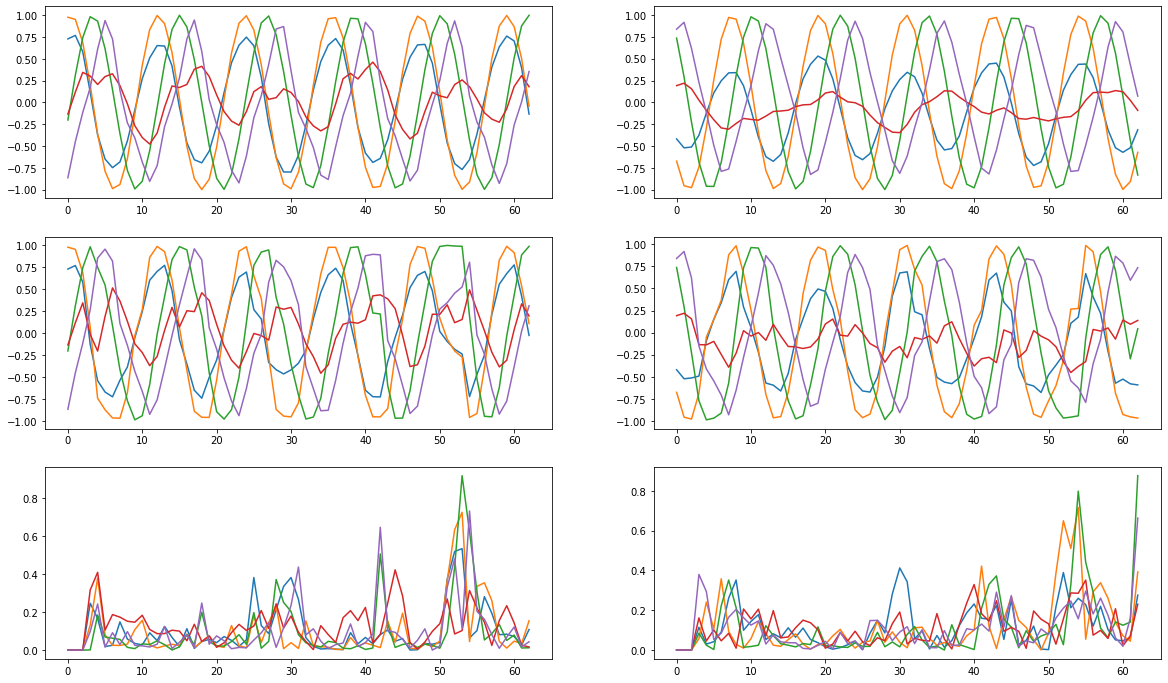

In [203]:
kwargs_opt = {
    "start_from" : 800,
    "nPOD" : nPOD,
    "nLatent" : 100,
    "npredictions" : 60,
    "optimizer_epochs" : 20,
    "dt" : step_size,
    "gan" : gan,
    "cycles" : 30,
    "debug" : debug,
    "disturb" : True
}

optimizer = Optimize(**kwargs_opt)
fld = optimizer.predictDD(training_data,
                           tf.convert_to_tensor(np.array(boundrary_conditions, dtype=np.float32)),
                           dim_steps=added_dims)

show_dims = 5
fig = plt.figure(figsize=(20, 12))

rect = 18

ax1 = fig.add_subplot(321)
ax1.plot(scaled_training[1,optimizer.start_from+rect:rect+optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size,:show_dims])
ax1 = fig.add_subplot(323)
ax1.plot(fld[0, :, :show_dims])
ax1 = fig.add_subplot(325)
ax1.plot(np.abs(scaled_training[1,optimizer.start_from+rect:rect+optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size, :show_dims] - fld[0,:, :show_dims]))


ax1 = fig.add_subplot(322)
ax1.plot(scaled_training[2,optimizer.start_from+rect:rect+optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size, :show_dims])
ax1 = fig.add_subplot(324)
ax1.plot(fld[1, :, :show_dims])
ax1 = fig.add_subplot(326)
ax1.plot(np.abs(scaled_training[2,optimizer.start_from+rect:rect+optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size, :show_dims] - fld[1, :, :show_dims]))

plt.show()

In [19]:
pause

NameError: name 'pause' is not defined

In [ ]:
basis = np.load('../data/processed/pod_basis_field_Velocity.npy')

In [206]:
final_data = []
rect = 18
final_data.append(scales[0].inverse_transform((scaled_training[0,optimizer.start_from+rect:rect+optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size,:nPOD])).T)
for i in range(2):
    final_data.append(scales[1+i].inverse_transform(flds[i]).T)
    
final_data.append(scales[3].inverse_transform((scaled_training[3,optimizer.start_from+rect:rect+optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size,:nPOD])).T)

In [207]:
org_data = []
for i in range(4):
    org_data.append(scales[i].inverse_transform((scaled_training[i,optimizer.start_from+rect:rect+optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size,:nPOD])).T)

In [208]:
cutoff = 40
final_data = np.array(final_data)[:,:,:cutoff]
org_data = np.array(org_data)[:,:,:cutoff]

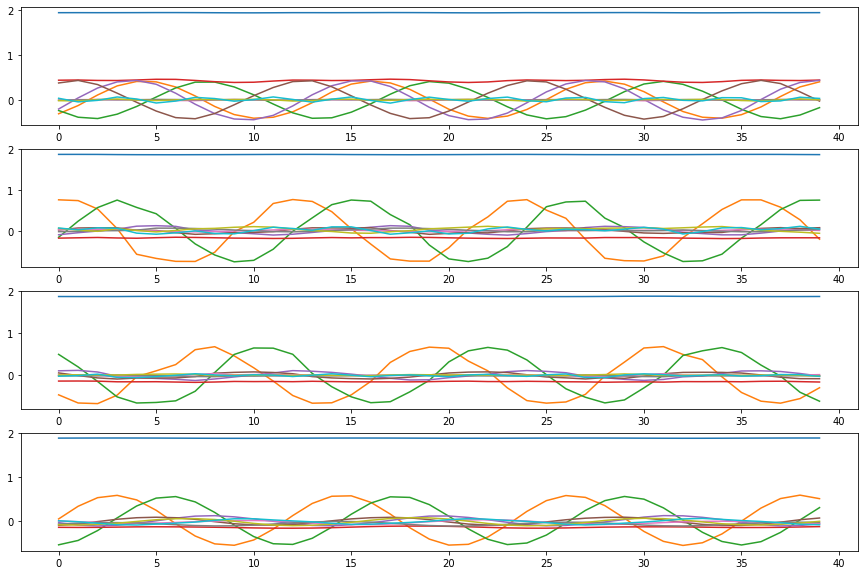

In [209]:
fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(411)
ax1.plot(final_data[0].T)
ax1 = fig.add_subplot(412)
ax1.plot(final_data[1].T)
ax1 = fig.add_subplot(413)
ax1.plot(final_data[2].T)
ax1 = fig.add_subplot(414)
ax1.plot(final_data[3].T)

plt.show()

In [210]:
print_data = []

for i in range(4):
    print_data.append((basis[:,:gan.ndims] @ final_data[i]))

print_data = np.array(print_data).reshape([4, 2, 55, 42, 40])
np.save('../data/reconstructed/Velocity_field_predict_DD.npy', print_data )

In [146]:
org_data_re = []

for i in range(4):
    org_data_re.append(basis[:,:gan.ndims] @ org_data[i])

org_data_re = np.array(org_data_re).reshape([4, 2, 55, 42, 40])
np.save('../data/reconstructed/velocity_field_org_DD.npy', org_data_re )